## Dependencies and imports

In [1]:
#!pip install --no-deps '../input/timm-package/timm-0.1.26-py3-none-any.whl' > /dev/null
#!pip install --no-deps '../input/pycocotools/pycocotools-2.0-cp37-cp37m-linux_x86_64.whl' > /dev/null

In [2]:
#!pip install pycocotools

In [3]:
import sys
sys.path.insert(0, "../../../efficientdet-pytorch")
sys.path.insert(0, "../../../omegaconf")
sys.path.insert(0, "../")

In [4]:
import torch
import torch.nn as nn
import os
from datetime import datetime
import time
import random
import cv2
import pandas as pd
import numpy as np
import albumentations as A
import matplotlib.pyplot as plt
from albumentations.pytorch.transforms import ToTensorV2
from sklearn.model_selection import StratifiedKFold
from torch.utils.data import Dataset,DataLoader
from torch.utils.data.sampler import SequentialSampler, RandomSampler
from glob import glob
from effdet import get_efficientdet_config, EfficientDet, DetBenchTrain, DetBenchEval
from effdet.efficientdet import HeadNet

from metrics import eval_metrics

SEED = 42

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(SEED)

In [5]:
DATA_DIR = '/relevance2-nfs/chec/data/wheat'

In [6]:
marking = pd.read_csv(f'{DATA_DIR}/train.csv')

bboxs = np.stack(marking['bbox'].apply(lambda x: np.fromstring(x[1:-1], sep=',')))
for i, column in enumerate(['x', 'y', 'w', 'h']):
    marking[column] = bboxs[:,i]
marking.drop(columns=['bbox'], inplace=True)

About data splitting you can read [here](https://www.kaggle.com/shonenkov/wbf-approach-for-ensemble):

In [7]:
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

df_folds = marking[['image_id']].copy()
df_folds.loc[:, 'bbox_count'] = 1
df_folds = df_folds.groupby('image_id').count()
df_folds.loc[:, 'source'] = marking[['image_id', 'source']].groupby('image_id').min()['source']
df_folds.loc[:, 'stratify_group'] = np.char.add(
    df_folds['source'].values.astype(str),
    df_folds['bbox_count'].apply(lambda x: f'_{x // 15}').values.astype(str)
)
df_folds.loc[:, 'fold'] = 0

for fold_number, (train_index, val_index) in enumerate(skf.split(X=df_folds.index, y=df_folds['stratify_group'])):
    df_folds.loc[df_folds.iloc[val_index].index, 'fold'] = fold_number

/relevance2-nfs/chec/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)


In [8]:
df_folds.reset_index().head()

image_id  bbox_count     source stratify_group  fold
0  00333207f          55  arvalis_1    arvalis_1_3     3
1  005b0d8bb          20    usask_1      usask_1_1     7
2  006a994f7          25    inrae_1      inrae_1_1     2
3  00764ad5d          41    inrae_1      inrae_1_2     0
4  00b5fefed          25  arvalis_3    arvalis_3_1     6

In [9]:
df_folds['source'].value_counts()

arvalis_1    1055
ethz_1        747
arvalis_3     559
rres_1        432
arvalis_2     204
usask_1       200
inrae_1       176
Name: source, dtype: int64

In [10]:
df_folds.shape

(3373, 4)

In [11]:
image_files = os.listdir(os.path.join(DATA_DIR, 'train'))
all_img_ids = [x.split('.')[0] for x in image_files]
no_box_images = list(set(all_img_ids) - set(marking.image_id.unique()))

In [12]:
def get_fold_img_ids(ifold):
    val_sources = {
        0: 'arvalis_2',
        1: 'usask_1',
        2: 'rres_1',
        3: 'arvalis_3',
        4: 'inrae_1'
    }
    val_ids = df_folds.loc[(df_folds['fold']==ifold) | (df_folds['source']==val_sources[ifold])].index.values.tolist()
    val_ids = val_ids + no_box_images
    #print(len(val_ids))
    train_ids = list(set(df_folds.index.values) - set(val_ids))
    #print(len(train_ids))
    return np.array(train_ids), np.array(val_ids)

In [13]:
marking.head()

image_id  width  height   source      x      y      w      h
0  b6ab77fd7   1024    1024  usask_1  834.0  222.0   56.0   36.0
1  b6ab77fd7   1024    1024  usask_1  226.0  548.0  130.0   58.0
2  b6ab77fd7   1024    1024  usask_1  377.0  504.0   74.0  160.0
3  b6ab77fd7   1024    1024  usask_1  834.0   95.0  109.0  107.0
4  b6ab77fd7   1024    1024  usask_1   26.0  144.0  124.0  117.0

## Albumentations

In [14]:
def get_train_transforms():
    return A.Compose(
        [
            A.RandomSizedCrop(min_max_height=(800, 800), height=1024, width=1024, p=0.5),
            A.OneOf([
                A.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit= 0.2, 
                                     val_shift_limit=0.2, p=0.9),
                #A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=50, p=0.9),
                A.RandomBrightnessContrast(brightness_limit=0.2, 
                                           contrast_limit=0.2, p=0.9),
            ],p=0.9),
            A.Blur(blur_limit=3, p=0.2),
            A.ToGray(p=0.1),
            #A.GaussianBlur(p=1),
            #A.RGBShift(p=1),
            #A.RandomSnow(p=1),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.Resize(height=512, width=512, p=1),
            A.Cutout(num_holes=8, max_h_size=64, max_w_size=64, fill_value=0, p=0.5),
            ToTensorV2(p=1.0),
        ], 
        p=1.0, 
        bbox_params=A.BboxParams(
            format='pascal_voc',
            min_area=0, 
            min_visibility=0,
            label_fields=['labels']
        )
    )

def get_valid_transforms():
    return A.Compose(
        [
            A.Resize(height=512, width=512, p=1.0),
            ToTensorV2(p=1.0),
        ], 
        p=1.0, 
        bbox_params=A.BboxParams(
            format='pascal_voc',
            min_area=0, 
            min_visibility=0,
            label_fields=['labels']
        )
    )

## Dataset

In [15]:
TRAIN_ROOT_PATH = f'{DATA_DIR}/train'

class DatasetRetriever(Dataset):

    def __init__(self, marking, image_ids, transforms=None, test=False):
        super().__init__()

        self.image_ids = image_ids
        self.marking = marking
        self.transforms = transforms
        self.test = test
        self.yxyx = True
        self.img_size = 1024

    def __getitem__(self, index: int):
        image_id = self.image_ids[index]
        
        source =  'none'
        if self.test:
            image, boxes, source = self.load_image_and_boxes(index)
            if boxes is None:
                boxes = np.array([[0., 0., 1., 1.]])
                labels = torch.tensor([2.]).long()
            # there is only one class
            else:
                labels = torch.ones((boxes.shape[0],), dtype=torch.int64)
        else:
            r = random.random()
            if r < 0.1:
                image, boxes = self.load_image_and_boxes(index)
            elif r < 0.2:
                #print('mixup1')
                image, boxes = self.mixup1(index)
            elif r < 0.6:
                #print('mixup3')
                image, boxes = self.mixup3(index)
            else:
                #print('cutmix')
                image, boxes = self.load_cutmix_image_and_boxes(index)

            # there is only one class
            labels = torch.ones((boxes.shape[0],), dtype=torch.int64)
        
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        target['image_id'] = torch.tensor([index])
        target['source'] = source

        if self.transforms:
            for i in range(10):
                sample = self.transforms(**{
                    'image': image,
                    'bboxes': target['boxes'],
                    'labels': labels
                })
                if len(sample['bboxes']) > 0:
                    image = sample['image']
                    target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1, 0)
                    target['boxes'][:,[0,1,2,3]] = target['boxes'][:,[1,0,3,2]]  #yxyx: be warning
                    break

        return image, target, image_id

    def __len__(self) -> int:
        return self.image_ids.shape[0]

    def load_image_and_boxes(self, index):
        image_id = self.image_ids[index]
        image = cv2.imread(f'{TRAIN_ROOT_PATH}/{image_id}.jpg', cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
        records = self.marking[self.marking['image_id'] == image_id]
        if len(records) < 1:
            if self.test:
                return image, None, 'unknown'
            else:
                return image, None
        #print(records)
        source = records['source'].values[0]
        boxes = records[['x', 'y', 'w', 'h']].values
        boxes[:, 2] = boxes[:, 0] + boxes[:, 2]
        boxes[:, 3] = boxes[:, 1] + boxes[:, 3]
        #print('>>>boxes:', boxes)
        #print('image shape:', image.shape)
        if self.test:
            return image, boxes, source
        else:
            return image, boxes
    
    def mixup1(self, index):
        img, boxes = self.load_image_and_boxes(index)
        rindex = random.randint(0, self.image_ids.shape[0] - 1)
        rimg, rboxes = self.load_image_and_boxes(rindex)
        
        mixup_image = (img + rimg)/2
        mixup_boxes = np.concatenate([boxes, rboxes], 0)
        #print(boxes.shape, rboxes.shape, mixup_boxes.shape)
        
        return mixup_image, mixup_boxes
    
    def mixup3(self, index):
        image, boxes = self.load_image_and_boxes(index)
        rindex = random.randint(0, self.image_ids.shape[0] - 1)
        r_image, r_boxes = self.load_image_and_boxes(rindex)


        #for box in r_boxes.astype(int):
        #    cv2.rectangle(r_image,(box[0], box[1]),(box[2],  box[3]),(1, 0, 0), 3)

        imsize = image.shape[0]
        w,h = imsize, imsize
        s = imsize // 2

        xc, yc = [int(random.uniform(imsize * 0.4, imsize * 0.6)) for _ in range(2)]
        direct = random.randint(0, 3)

        result_image = image.copy()
        result_boxes = []

        if direct == 0:
            x1a, y1a, x2a, y2a = max(xc - w, 0), max(yc - h, 0), xc, yc  # xmin, ymin, xmax, ymax (large image)
            x1b, y1b, x2b, y2b = w - (x2a - x1a), h - (y2a - y1a), w, h  # xmin, ymin, xmax, ymax (small image)
        elif direct == 1:  # top right
            x1a, y1a, x2a, y2a = xc, max(yc - h, 0), min(xc + w, s * 2), yc
            x1b, y1b, x2b, y2b = 0, h - (y2a - y1a), min(w, x2a - x1a), h
        elif direct == 2:  # bottom left
            x1a, y1a, x2a, y2a = max(xc - w, 0), yc, xc, min(s * 2, yc + h)
            x1b, y1b, x2b, y2b = w - (x2a - x1a), 0, max(xc, w), min(y2a - y1a, h)
        elif direct == 3:  # bottom right
            x1a, y1a, x2a, y2a = xc, yc, min(xc + w, s * 2), min(s * 2, yc + h)
            x1b, y1b, x2b, y2b = 0, 0, min(w, x2a - x1a), min(y2a - y1a, h)

        padw = x1a - x1b
        padh = y1a - y1b

        r_boxes[:, 0] += padw
        r_boxes[:, 1] += padh
        r_boxes[:, 2] += padw
        r_boxes[:, 3] += padh

        result_boxes.append(r_boxes)

        result_image[y1a:y2a, x1a:x2a] = (result_image[y1a:y2a, x1a:x2a] + r_image[y1b:y2b, x1b:x2b]) / 2 

        cv2.rectangle(image,(x1a, y1a),(x2a,  y2a),(0, 1, 1), 5)
        cv2.rectangle(r_image,(x1b, y1b),(x2b,  y2b),(0, 1, 1), 5)
        cv2.rectangle(result_image,(x1a, y1a),(x2a,  y2a),(0, 1, 1), 5)

        result_boxes = np.concatenate(result_boxes, 0)
        np.clip(result_boxes[:, 0:], 0, 2 * s, out=result_boxes[:, 0:])
        result_boxes = result_boxes.astype(np.int32)
        result_boxes = result_boxes[np.where((result_boxes[:,2]-result_boxes[:,0])*(result_boxes[:,3]-result_boxes[:,1]) > 0)]

        #for box in boxes.astype(int):
        #    cv2.rectangle(image,(box[0], box[1]),(box[2],  box[3]),(0, 0, 1), 3)
        #    cv2.rectangle(result_image,(box[0], box[1]),(box[2],  box[3]),(0, 0, 1), 3)

        #for box in result_boxes.astype(int):
        #    cv2.rectangle(result_image,(box[0], box[1]),(box[2],  box[3]),(1, 0, 0), 3)

        #ax[i][0].imshow(image)
        #ax[i][1].imshow(r_image)
        #ax[i][2].imshow(result_image)
        
        return result_image, np.concatenate([result_boxes, boxes])

    def load_cutmix_image_and_boxes(self, index, imsize=1024):
        """ 
        This implementation of cutmix author:  https://www.kaggle.com/nvnnghia 
        Refactoring and adaptation: https://www.kaggle.com/shonenkov
        """
        w, h = imsize, imsize
        s = imsize // 2
    
        xc, yc = [int(random.uniform(imsize * 0.25, imsize * 0.75)) for _ in range(2)]  # center x, y
        indexes = [index] + [random.randint(0, self.image_ids.shape[0] - 1) for _ in range(3)]

        result_image = np.full((imsize, imsize, 3), 1, dtype=np.float32)
        result_boxes = []

        for i, index in enumerate(indexes):
            image, boxes = self.load_image_and_boxes(index)
            if i == 0:
                x1a, y1a, x2a, y2a = max(xc - w, 0), max(yc - h, 0), xc, yc  # xmin, ymin, xmax, ymax (large image)
                x1b, y1b, x2b, y2b = w - (x2a - x1a), h - (y2a - y1a), w, h  # xmin, ymin, xmax, ymax (small image)
            elif i == 1:  # top right
                x1a, y1a, x2a, y2a = xc, max(yc - h, 0), min(xc + w, s * 2), yc
                x1b, y1b, x2b, y2b = 0, h - (y2a - y1a), min(w, x2a - x1a), h
            elif i == 2:  # bottom left
                x1a, y1a, x2a, y2a = max(xc - w, 0), yc, xc, min(s * 2, yc + h)
                x1b, y1b, x2b, y2b = w - (x2a - x1a), 0, max(xc, w), min(y2a - y1a, h)
            elif i == 3:  # bottom right
                x1a, y1a, x2a, y2a = xc, yc, min(xc + w, s * 2), min(s * 2, yc + h)
                x1b, y1b, x2b, y2b = 0, 0, min(w, x2a - x1a), min(y2a - y1a, h)
            result_image[y1a:y2a, x1a:x2a] = image[y1b:y2b, x1b:x2b]
            padw = x1a - x1b
            padh = y1a - y1b

            boxes[:, 0] += padw
            boxes[:, 1] += padh
            boxes[:, 2] += padw
            boxes[:, 3] += padh

            result_boxes.append(boxes)

        result_boxes = np.concatenate(result_boxes, 0)
        np.clip(result_boxes[:, 0:], 0, 2 * s, out=result_boxes[:, 0:])
        result_boxes = result_boxes.astype(np.int32)
        result_boxes = result_boxes[np.where((result_boxes[:,2]-result_boxes[:,0])*(result_boxes[:,3]-result_boxes[:,1]) > 0)]
        return result_image, result_boxes
    
    def load_mosaic(self, index):
        # loads images in a mosaic
        
        labels4 = []
        s = self.img_size
        xc, yc = [int(random.uniform(s * 0.5, s * 1.5)) for _ in range(2)]  # mosaic center x, y
        indices = [index] + [random.randint(0, len(self.image_ids) - 1) for _ in range(3)]  # 3 additional image indices
        for i, index in enumerate(indices):
            # Load image
            img, boxes  = self.load_image_and_boxes(index)
            h, w = 1024, 1024

            # place img in img4
            if i == 0:  # top left
                img4 = np.full((s * 2, s * 2, img.shape[2]), 114, dtype=np.uint8)  # base image with 4 tiles
                x1a, y1a, x2a, y2a = max(xc - w, 0), max(yc - h, 0), xc, yc  # xmin, ymin, xmax, ymax (large image)
                x1b, y1b, x2b, y2b = w - (x2a - x1a), h - (y2a - y1a), w, h  # xmin, ymin, xmax, ymax (small image)
            elif i == 1:  # top right
                x1a, y1a, x2a, y2a = xc, max(yc - h, 0), min(xc + w, s * 2), yc
                x1b, y1b, x2b, y2b = 0, h - (y2a - y1a), min(w, x2a - x1a), h
            elif i == 2:  # bottom left
                x1a, y1a, x2a, y2a = max(xc - w, 0), yc, xc, min(s * 2, yc + h)
                x1b, y1b, x2b, y2b = w - (x2a - x1a), 0, max(xc, w), min(y2a - y1a, h)
            elif i == 3:  # bottom right
                x1a, y1a, x2a, y2a = xc, yc, min(xc + w, s * 2), min(s * 2, yc + h)
                x1b, y1b, x2b, y2b = 0, 0, min(w, x2a - x1a), min(y2a - y1a, h)

            img4[y1a:y2a, x1a:x2a] = img[y1b:y2b, x1b:x2b]  # img4[ymin:ymax, xmin:xmax]
            padw = x1a - x1b
            padh = y1a - y1b

            # Labels
            x = boxes #self.labels[index]
            
            labels = x.copy()
            if x.size > 0:  # Normalized xywh to pixel xyxy format
                labels[:, 1] = w * (x[:, 1] - x[:, 3] / 2) + padw
                labels[:, 2] = h * (x[:, 2] - x[:, 4] / 2) + padh
                labels[:, 3] = w * (x[:, 1] + x[:, 3] / 2) + padw
                labels[:, 4] = h * (x[:, 2] + x[:, 4] / 2) + padh
            labels4.append(labels)

        # Concat/clip labels
        if len(labels4):
            labels4 = np.concatenate(labels4, 0)
            # np.clip(labels4[:, 1:] - s / 2, 0, s, out=labels4[:, 1:])  # use with center crop
            np.clip(labels4[:, 1:], 0, 2 * s, out=labels4[:, 1:])  # use with random_affine

        # Augment
        # img4 = img4[s // 2: int(s * 1.5), s // 2:int(s * 1.5)]  # center crop (WARNING, requires box pruning)
        img4, labels4 = self.random_affine(img4, labels4,
                                      degrees=1.98 * 2,
                                      translate=0.05 * 2,
                                      scale=0.05 * 2,
                                      shear=0.641 * 2,
                                      border=-s // 2)  # border to remove

        return img4, labels4
    
    def random_affine(self, img, targets=(), degrees=10, translate=.1, scale=.1, shear=10, border=0):
        # torchvision.transforms.RandomAffine(degrees=(-10, 10), translate=(.1, .1), scale=(.9, 1.1), shear=(-10, 10))
        # https://medium.com/uruvideo/dataset-augmentation-with-random-homographies-a8f4b44830d4

        if targets is None:  # targets = [cls, xyxy]
            targets = []
        height = img.shape[0] + border * 2
        width = img.shape[1] + border * 2

        # Rotation and Scale
        R = np.eye(3)
        a = random.uniform(-degrees, degrees)
        # a += random.choice([-180, -90, 0, 90])  # add 90deg rotations to small rotations
        s = random.uniform(1 - scale, 1 + scale)
        R[:2] = cv2.getRotationMatrix2D(angle=a, center=(img.shape[1] / 2, img.shape[0] / 2), scale=s)

        # Translation
        T = np.eye(3)
        T[0, 2] = random.uniform(-translate, translate) * img.shape[0] + border  # x translation (pixels)
        T[1, 2] = random.uniform(-translate, translate) * img.shape[1] + border  # y translation (pixels)

        # Shear
        S = np.eye(3)
        S[0, 1] = math.tan(random.uniform(-shear, shear) * math.pi / 180)  # x shear (deg)
        S[1, 0] = math.tan(random.uniform(-shear, shear) * math.pi / 180)  # y shear (deg)

        # Combined rotation matrix
        M = S @ T @ R  # ORDER IS IMPORTANT HERE!!
        if (border != 0) or (M != np.eye(3)).any():  # image changed
            img = cv2.warpAffine(img, M[:2], dsize=(width, height), flags=cv2.INTER_LINEAR, borderValue=(114, 114, 114))

        # Transform label coordinates
        n = len(targets)
        if n:
            # warp points
            xy = np.ones((n * 4, 3))
            xy[:, :2] = targets[:, [1, 2, 3, 4, 1, 4, 3, 2]].reshape(n * 4, 2)  # x1y1, x2y2, x1y2, x2y1
            xy = (xy @ M.T)[:, :2].reshape(n, 8)

            # create new boxes
            x = xy[:, [0, 2, 4, 6]]
            y = xy[:, [1, 3, 5, 7]]
            xy = np.concatenate((x.min(1), y.min(1), x.max(1), y.max(1))).reshape(4, n).T

            # # apply angle-based reduction of bounding boxes
            # radians = a * math.pi / 180
            # reduction = max(abs(math.sin(radians)), abs(math.cos(radians))) ** 0.5
            # x = (xy[:, 2] + xy[:, 0]) / 2
            # y = (xy[:, 3] + xy[:, 1]) / 2
            # w = (xy[:, 2] - xy[:, 0]) * reduction
            # h = (xy[:, 3] - xy[:, 1]) * reduction
            # xy = np.concatenate((x - w / 2, y - h / 2, x + w / 2, y + h / 2)).reshape(4, n).T

            # reject warped points outside of image
            xy[:, [0, 2]] = xy[:, [0, 2]].clip(0, width)
            xy[:, [1, 3]] = xy[:, [1, 3]].clip(0, height)
            w = xy[:, 2] - xy[:, 0]
            h = xy[:, 3] - xy[:, 1]
            area = w * h
            area0 = (targets[:, 3] - targets[:, 1]) * (targets[:, 4] - targets[:, 2])
            ar = np.maximum(w / (h + 1e-16), h / (w + 1e-16))  # aspect ratio
            i = (w > 4) & (h > 4) & (area / (area0 * s + 1e-16) > 0.2) & (ar < 10)

            targets = targets[i]
            targets[:, 1:5] = xy[i]

        return img, targets

In [16]:
def get_train_val_datasets(fold=0):
    #val_ids_all = np.concatenate([df_folds[df_folds['fold'] == fold].index.values, np.array(list(no_box_images))], 0)
    train_ids, val_ids = get_fold_img_ids(fold)

    train_dataset = DatasetRetriever(
        image_ids=train_ids,
        marking=marking,
        transforms=get_train_transforms(),
        test=False,
    )

    validation_dataset = DatasetRetriever(
        image_ids=val_ids,
        marking=marking,
        transforms=get_valid_transforms(),
        test=True,
    )
    return train_dataset, validation_dataset

In [17]:
#fold_number = 0
train_dataset, validation_datase = get_train_val_datasets(0)

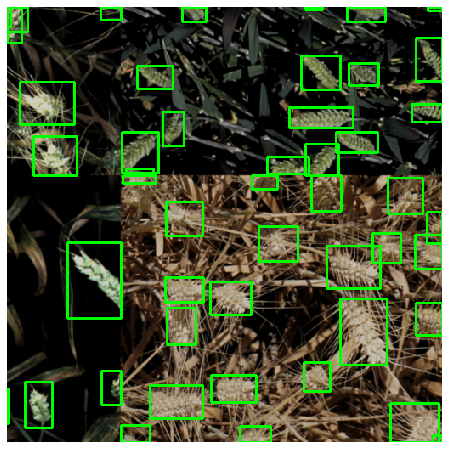

In [18]:
image, target, image_id = train_dataset[0]
boxes = target['boxes'].cpu().numpy().astype(np.int32)

numpy_image = image.permute(1,2,0).cpu().numpy()

fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for box in boxes:
    cv2.rectangle(numpy_image, (box[1], box[0]), (box[3],  box[2]), (0, 1, 0), 2)
    
ax.set_axis_off()
ax.imshow(numpy_image);

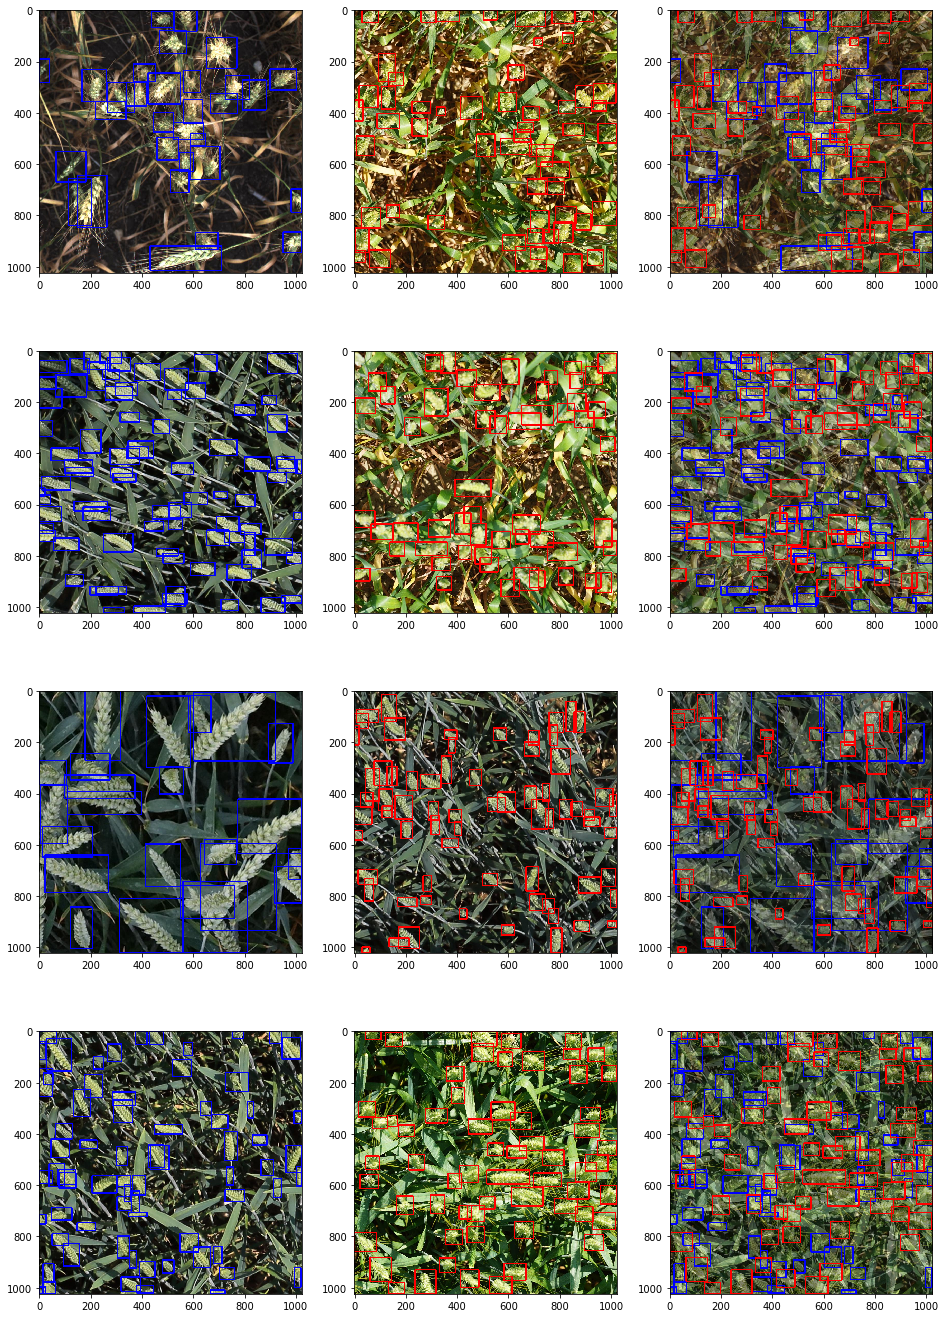

In [19]:
count = 4

fig, ax = plt.subplots(count, 3, figsize=(16, 6*count))

for i in range(count):
    image, boxes = train_dataset.load_image_and_boxes(random.randint(0, train_dataset.image_ids.shape[0] - 1))
    r_image, r_boxes = train_dataset.load_image_and_boxes(random.randint(0, train_dataset.image_ids.shape[0] - 1))
    mixup_image = (image+r_image)/2

    for box in boxes.astype(int):
        cv2.rectangle(image,(box[0], box[1]),(box[2],  box[3]),(0, 0, 1), 3)
        cv2.rectangle(mixup_image,(box[0], box[1]),(box[2],  box[3]),(0, 0, 1), 3)
        
    for box in r_boxes.astype(int):
        cv2.rectangle(r_image,(box[0], box[1]),(box[2],  box[3]),(1, 0, 0), 3)
        cv2.rectangle(mixup_image,(box[0], box[1]),(box[2],  box[3]),(1, 0, 0), 3)
        
    ax[i][0].imshow(image)
    ax[i][1].imshow(r_image)
    ax[i][2].imshow(mixup_image)

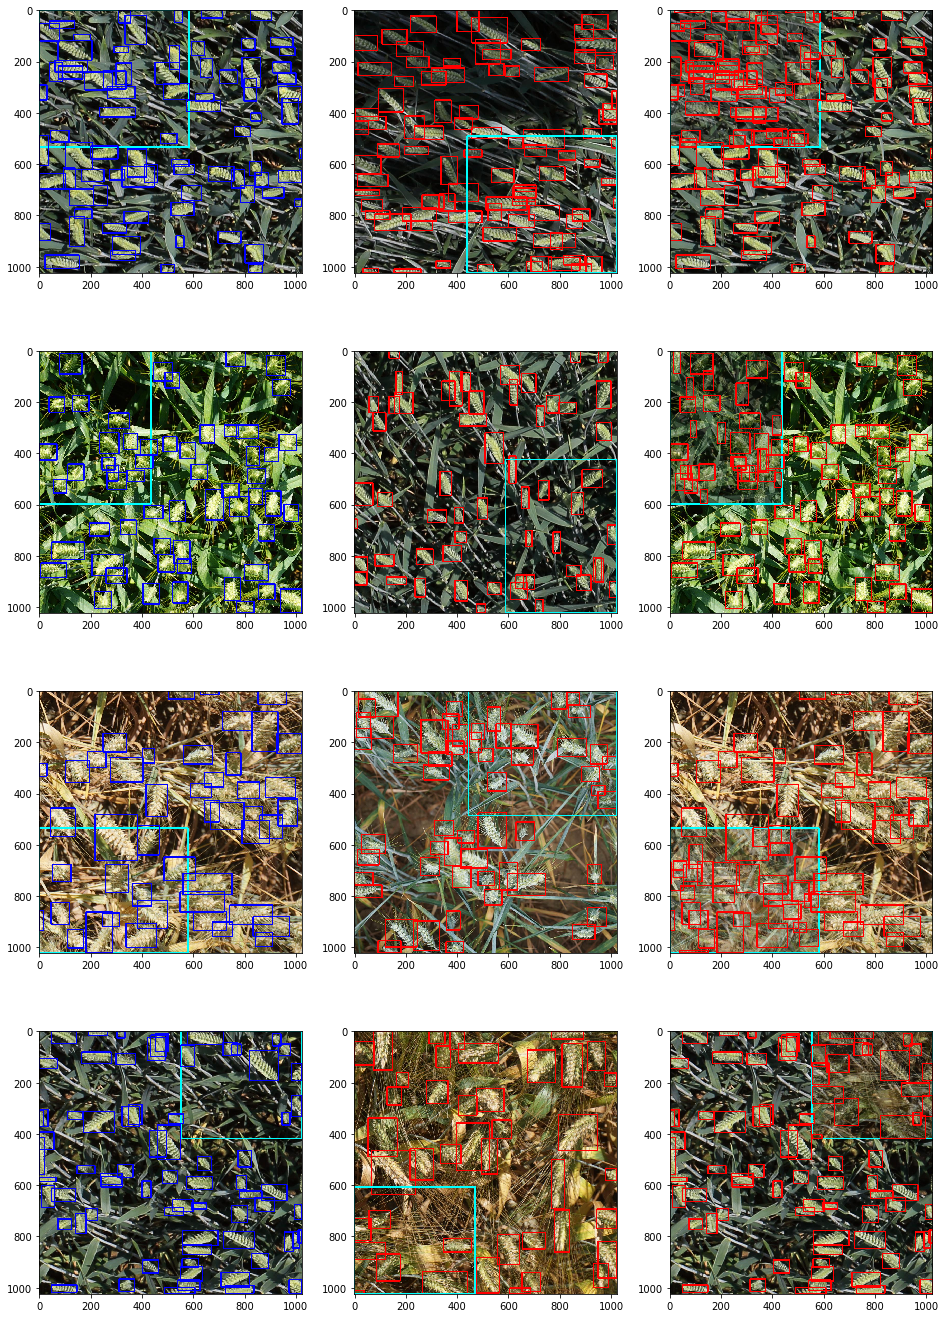

In [20]:
count = 4

fig, ax = plt.subplots(count, 3, figsize=(16, 6*count))

for i in range(count):
    image, boxes = train_dataset.load_image_and_boxes(random.randint(0, train_dataset.image_ids.shape[0] - 1))
    r_image, r_boxes = train_dataset.load_image_and_boxes(random.randint(0, train_dataset.image_ids.shape[0] - 1))
    
    for box in r_boxes.astype(int):
        cv2.rectangle(r_image,(box[0], box[1]),(box[2],  box[3]),(1, 0, 0), 3)

    imsize = image.shape[0]
    w,h = imsize, imsize
    s = imsize // 2

    xc, yc = [int(random.uniform(imsize * 0.4, imsize * 0.6)) for _ in range(2)]
    direct = random.randint(0, 3)

    result_image = image.copy()
    result_boxes = []

    if direct == 0:
        x1a, y1a, x2a, y2a = max(xc - w, 0), max(yc - h, 0), xc, yc  # xmin, ymin, xmax, ymax (large image)
        x1b, y1b, x2b, y2b = w - (x2a - x1a), h - (y2a - y1a), w, h  # xmin, ymin, xmax, ymax (small image)
    elif direct == 1:  # top right
        x1a, y1a, x2a, y2a = xc, max(yc - h, 0), min(xc + w, s * 2), yc
        x1b, y1b, x2b, y2b = 0, h - (y2a - y1a), min(w, x2a - x1a), h
    elif direct == 2:  # bottom left
        x1a, y1a, x2a, y2a = max(xc - w, 0), yc, xc, min(s * 2, yc + h)
        x1b, y1b, x2b, y2b = w - (x2a - x1a), 0, max(xc, w), min(y2a - y1a, h)
    elif direct == 3:  # bottom right
        x1a, y1a, x2a, y2a = xc, yc, min(xc + w, s * 2), min(s * 2, yc + h)
        x1b, y1b, x2b, y2b = 0, 0, min(w, x2a - x1a), min(y2a - y1a, h)

    padw = x1a - x1b
    padh = y1a - y1b

    r_boxes[:, 0] += padw
    r_boxes[:, 1] += padh
    r_boxes[:, 2] += padw
    r_boxes[:, 3] += padh

    result_boxes.append(r_boxes)

    result_image[y1a:y2a, x1a:x2a] = (result_image[y1a:y2a, x1a:x2a] + r_image[y1b:y2b, x1b:x2b]) / 2 
    
    cv2.rectangle(image,(x1a, y1a),(x2a,  y2a),(0, 1, 1), 5)
    cv2.rectangle(r_image,(x1b, y1b),(x2b,  y2b),(0, 1, 1), 5)
    cv2.rectangle(result_image,(x1a, y1a),(x2a,  y2a),(0, 1, 1), 5)
    
    result_boxes = np.concatenate(result_boxes, 0)
    np.clip(result_boxes[:, 0:], 0, 2 * s, out=result_boxes[:, 0:])
    result_boxes = result_boxes.astype(np.int32)
    result_boxes = result_boxes[np.where((result_boxes[:,2]-result_boxes[:,0])*(result_boxes[:,3]-result_boxes[:,1]) > 0)]
    
    for box in boxes.astype(int):
        cv2.rectangle(image,(box[0], box[1]),(box[2],  box[3]),(0, 0, 1), 3)
        #cv2.rectangle(result_image,(box[0], box[1]),(box[2],  box[3]),(0, 0, 1), 3)
        
    for box in np.concatenate([result_boxes,boxes]).astype(int):
        cv2.rectangle(result_image,(box[0], box[1]),(box[2],  box[3]),(1, 0, 0), 3)
        
    ax[i][0].imshow(image)
    ax[i][1].imshow(r_image)
    ax[i][2].imshow(result_image)

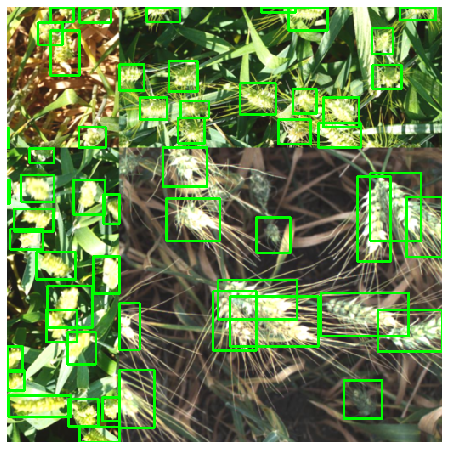

In [21]:
image, target, image_id = train_dataset[0]
boxes = target['boxes'].cpu().numpy().astype(np.int32)

numpy_image = image.permute(1,2,0).cpu().numpy()

fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for box in boxes:
    cv2.rectangle(numpy_image, (box[1], box[0]), (box[3],  box[2]), (0, 1, 0), 2)
    
ax.set_axis_off()
ax.imshow(numpy_image);

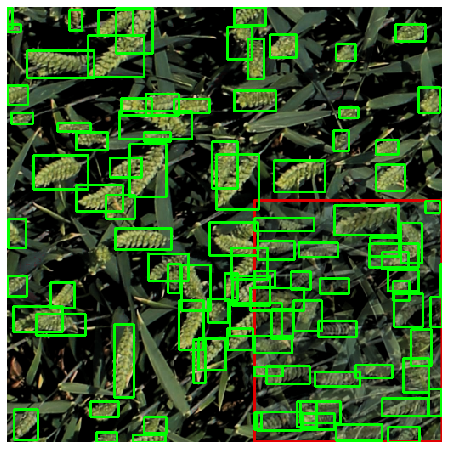

In [22]:
image, target, image_id = train_dataset[1]
boxes = target['boxes'].cpu().numpy().astype(np.int32)

numpy_image = image.permute(1,2,0).cpu().numpy()

fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for box in boxes:
    cv2.rectangle(numpy_image, (box[1], box[0]), (box[3],  box[2]), (0, 1, 0), 2)
    
ax.set_axis_off()
ax.imshow(numpy_image);

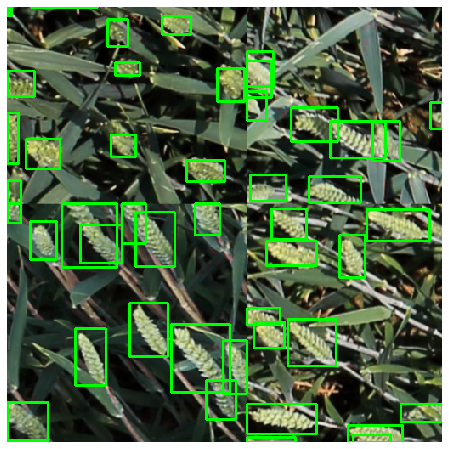

In [23]:
image, target, image_id = train_dataset[1]
boxes = target['boxes'].cpu().numpy().astype(np.int32)

numpy_image = image.permute(1,2,0).cpu().numpy()

fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for box in boxes:
    cv2.rectangle(numpy_image, (box[1], box[0]), (box[3],  box[2]), (0, 1, 0), 2)
    
ax.set_axis_off()
ax.imshow(numpy_image);

## Fitter

In [24]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [25]:
f'{1+2}'

'3'

In [26]:
import warnings

warnings.filterwarnings("ignore")

class Fitter:
    
    def __init__(self, model, device, config):
        self.config = config
        self.epoch = 0

        self.base_dir = f'./{config.folder}'
        if not os.path.exists(self.base_dir):
            os.makedirs(self.base_dir)
        
        self.log_path = f'{self.base_dir}/log_{self.config.ifold}.txt'
        #self.best_summary_loss = 10**5
        self.best_score = 0.
        self.model_file_best = f'{self.base_dir}/best-fold-{self.config.ifold}.pth'
        self.model_file_last = f'{self.base_dir}/last-fold-{self.config.ifold}.pth'

        self.model = model
        self.device = device

        param_optimizer = list(self.model.named_parameters())
        no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
        optimizer_grouped_parameters = [
            {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.001},
            {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
        ] 

        self.optimizer = torch.optim.AdamW(optimizer_grouped_parameters, lr=config.lr)
        #self.optimizer = torch.optim.SGD(self.model.parameters(), lr=config.lr, momentum=0.9, weight_decay=1e-4)
        lrs_config = config.lrs[config.lrs_name]
        self.scheduler = lrs_config['schedule_class'](self.optimizer, **lrs_config['schedule_params'])
        #self.scheduler = config.SchedulerClass(self.optimizer, **config.scheduler_params)
        self.log(f'Fitter prepared. Device is {self.device}')

    def lrs_step(self, metrics):
        if self.config.lrs_name == 'plateau':
            self.scheduler.step(metrics)
        else:
            self.scheduler.step()

    def fit(self, train_loader, validation_loader):
        if self.load_best():
            if not isinstance(self.model.model, nn.DataParallel):
                self.model.model = nn.DataParallel(self.model.model)

            metrics = self.validation(validation_loader)
            self.best_score = metrics['best_score']
            print(metrics)
        else:
            if not isinstance(self.model.model, nn.DataParallel):
                self.model.model = nn.DataParallel(self.model.model)
        
        for e in range(self.config.n_epochs):
            if self.config.verbose:
                lr = self.optimizer.param_groups[0]['lr']
                timestamp = datetime.utcnow().isoformat()
                self.log(f'\n{timestamp}\nLR: {lr}')

            t = time.time()
            summary_loss = self.train_one_epoch(train_loader)

            self.log(f'[RESULT]: Train. Epoch: {self.epoch}, summary_loss: {summary_loss.avg:.5f}, time: {(time.time() - t):.5f}')
            self.save(self.model_file_last)

            t = time.time()
            metrics = self.validation(validation_loader)

            #self.log(f'[RESULT]: Val. Epoch: {self.epoch}, score: {metrics['best_score']}, \
            #    best: {self.best_score}, time: {(time.time() - t):.5f}')
            self.log('[VAL RESULT] Epoch {}, score: {}, best: {}, time: {:.5f}'.format(
                self.epoch, metrics['best_score'], self.best_score, (time.time() - t
            )))
            print(metrics)
            
            if metrics['best_score'] > self.best_score:
                self.best_score = metrics['best_score']
                self.model.eval()
                self.save(self.model_file_best)
                print('**saved**')
                
                #self.save(f'{self.base_dir}/best-checkpoint-{str(self.epoch).zfill(3)}epoch.bin')
                #for path in sorted(glob(f'{self.base_dir}/best-checkpoint-*epoch.bin'))[:-3]:
                #    os.remove(path)

            if self.config.validation_scheduler:
                #self.scheduler.step(metrics=summary_loss.avg)
                self.lrs_step(metrics=metrics['best_score'])

            self.epoch += 1

    def get_eval_det_model(self, model):
        config = get_efficientdet_config('tf_efficientdet_d5')
        config.num_classes = 1
        config.image_size = 512
        return DetBenchEval(model, config).cuda()
    
    def validation(self, val_loader):
        self.model.eval()
        eval_model = self.get_eval_det_model(self.model.model)
        metrics = eval_metrics(eval_model, val_loader, by_source=True)
        
        return metrics
        
    def validation_old(self, val_loader):
        self.model.eval()
        summary_loss = AverageMeter()
        t = time.time()
        for step, (images, targets, image_ids) in enumerate(val_loader):
            if self.config.verbose:
                if step % self.config.verbose_step == 0:
                    print(
                        f'Val Step {step}/{len(val_loader)}, ' + \
                        f'summary_loss: {summary_loss.avg:.5f}, ' + \
                        f'time: {(time.time() - t):.5f}', end='\r'
                    )
            with torch.no_grad():
                images = torch.stack(images)
                batch_size = images.shape[0]
                images = images.to(self.device).float()
                boxes = [target['boxes'].to(self.device).float() for target in targets]
                labels = [target['labels'].to(self.device).float() for target in targets]

                loss, _, _ = self.model(images, boxes, labels)
                summary_loss.update(loss.detach().item(), batch_size)

        return summary_loss

    def train_one_epoch(self, train_loader):
        self.model.train()
        summary_loss = AverageMeter()
        t = time.time()
        for step, (images, targets, image_ids) in enumerate(train_loader):
            if self.config.verbose:
                if step % self.config.verbose_step == 0:
                    print(
                        f'Train Step {step}/{len(train_loader)}, ' + \
                        f'summary_loss: {summary_loss.avg:.5f}, ' + \
                        f'time: {(time.time() - t):.5f}', end='\r'
                    )
            
            images = torch.stack(images)
            images = images.to(self.device).float()
            batch_size = images.shape[0]
            boxes = [target['boxes'].to(self.device).float() for target in targets]
            labels = [target['labels'].to(self.device).float() for target in targets]

            self.optimizer.zero_grad()
            
            loss, _, _ = self.model(images, boxes, labels)
            
            loss.backward()

            summary_loss.update(loss.detach().item(), batch_size)

            self.optimizer.step()

            if self.config.step_scheduler:
                #self.scheduler.step()
                self.lrs_step(summary_loss.avg)

        return summary_loss
    
    def save(self, path):
        self.model.eval()
        model_state = self.model.model.module.state_dict() if isinstance(self.model.model, nn.DataParallel) else self.model.model.state_dict()
        torch.save({
            'model_state_dict': model_state,
            'optimizer_state_dict': self.optimizer.state_dict(),
            'scheduler_state_dict': self.scheduler.state_dict(),
            'best_score': self.best_score,
            'epoch': self.epoch,
        }, path)

    def load_best(self):
        if os.path.exists(self.model_file_best):
            print(f'loading {self.model_file_best}...')
            self.load(self.model_file_best)
            return True
        else:
            print(f'{self.model_file_best} does not exist')
            return False

    def load(self, path):
        checkpoint = torch.load(path)
        self.model.model.load_state_dict(checkpoint['model_state_dict'])
        #self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        #self.scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        #self.best_score = checkpoint['best_score']
        self.epoch = checkpoint['epoch'] + 1
        
    def log(self, message):
        if self.config.verbose:
            print(message)
        with open(self.log_path, 'a+') as logger:
            logger.write(f'{message}\n')

In [27]:
#os.path.exists('a')

In [32]:
class TrainGlobalConfig:
    num_workers = 24
    batch_size = 30
    n_epochs = 300 # n_epochs = 40
    lr = 1e-4

    folder = 'ed5-mixup' #'effdet5-cutmix-augmix' #'ed5-mixup'
    ifold = 0

    # -------------------
    verbose = True
    verbose_step = 1
    # -------------------

    # --------------------
    step_scheduler = False  # do scheduler.step after optimizer.step
    validation_scheduler = True  # do scheduler.step after validation stage loss
    
    lrs_name = 'cosine' # plateau, cosine
    lrs = {
        'cosine': {
            'schedule_class': torch.optim.lr_scheduler.CosineAnnealingLR,
            'schedule_params': dict(
                T_max=12,
                eta_min=1e-6
            )
        },
        'plateau': {
            'schedule_class': torch.optim.lr_scheduler.ReduceLROnPlateau,
            'schedule_params': dict(
                mode='max',
                factor=0.5,
                patience=2,
                verbose=False, 
                threshold=0.0001,
                threshold_mode='abs',
                cooldown=0, 
                min_lr=2e-6,
                eps=1e-8
            )
        }
    }
    
    # --------------------
    #     SchedulerClass = torch.optim.lr_scheduler.OneCycleLR
    #     scheduler_params = dict(
    #         max_lr=0.001,
    #         epochs=n_epochs,
    #         steps_per_epoch=int(len(train_dataset) / batch_size),
    #         pct_start=0.1,
    #         anneal_strategy='cos', 
    #         final_div_factor=10**5
    #     )


In [33]:
def collate_fn(batch):
    return tuple(zip(*batch))

def run_training():
    device = torch.device('cuda')
    net.to(device)
    #net.cuda()
    #net.model = nn.DataParallel(net.model)
    
    train_dataset, validation_dataset = get_train_val_datasets(TrainGlobalConfig.ifold)

    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=TrainGlobalConfig.batch_size,
        sampler=RandomSampler(train_dataset),
        pin_memory=False,
        drop_last=True,
        num_workers=TrainGlobalConfig.num_workers,
        collate_fn=collate_fn,
    )
    val_loader = torch.utils.data.DataLoader(
        validation_dataset, 
        batch_size=TrainGlobalConfig.batch_size,
        num_workers=TrainGlobalConfig.num_workers,
        shuffle=False,
        sampler=SequentialSampler(validation_dataset),
        pin_memory=False,
        collate_fn=collate_fn,
    )

    fitter = Fitter(model=net, device=device, config=TrainGlobalConfig)
    fitter.fit(train_loader, val_loader)

In [34]:
#!pip install typing_extensions

In [35]:
def get_net():
    config = get_efficientdet_config('tf_efficientdet_d5')
    net = EfficientDet(config, pretrained_backbone=True)
    checkpoint = torch.load('../5folds/pretrained/efficientdet_d5-ef44aea8.pth')
    net.load_state_dict(checkpoint)
    config.num_classes = 1
    config.image_size = 512
    net.class_net = HeadNet(config, num_outputs=config.num_classes, norm_kwargs=dict(eps=.001, momentum=.01))
    
    return DetBenchTrain(net, config)

net = get_net()

In [ ]:
run_training()

Fitter prepared. Device is cuda
loading ./ed5-mixup/best-fold-0.pth...



{'best_score': 0.43977, 'best_threshold': 0.46, 0.3: 0.18497, 0.37: 0.18497, 0.4: 0.18497, 0.42: 0.18497, 0.45: 0.30263, 0.5: 0.17098, 0.55: 0.08603, 0.6: 0.08581, 'arvalis_1': {'score': 0.4285, 'num': 107}, 'arvalis_2': {'score': 0.31164, 'num': 204}, 'arvalis_3': {'score': 0.52352, 'num': 55}, 'ethz_1': {'score': 0.37833, 'num': 75}, 'rres_1': {'score': 0.70439, 'num': 43}, 'usask_1': {'score': 0.5241, 'num': 19}, 'inrae_1': {'score': 0.59321, 'num': 19}, 'unknown': {'score': 0.67347, 'num': 49}}

2020-05-28T19:15:17.503027
LR: 0.0004
[RESULT]: Train. Epoch: 2, summary_loss: 0.53872, time: 201.36101



[VAL RESULT] Epoch 2, score: 0.57763, best: 0.43977, time: 26.51896
{'best_score': 0.57763, 'best_threshold': 0.42, 0.3: 0.27286, 0.37: 0.53949, 0.4: 0.56572, 0.42: 0.57763, 0.45: 0.568, 0.5: 0.50927, 0.55: 0.38955, 0.6: 0.23963, 'arvalis_1': {'score': 0.54987, 'num': 107}, 'arvalis_2': {'score': 0.43929, 'num': 204}, 'arvalis_3': {'score': 0.66172, 'num': 55}, 'ethz_1': {'score': 0.64085, 'num': 75}, 'rres_1': {'score': 0.77963, 'num': 43}, 'usask_1': {'score': 0.67412, 'num': 19}, 'inrae_1': {'score': 0.71491, 'num': 19}, 'unknown': {'score': 0.7551, 'num': 49}}
**saved**

2020-05-28T19:19:11.866456
LR: 0.0004
[RESULT]: Train. Epoch: 3, summary_loss: 0.50768, time: 187.38164



[VAL RESULT] Epoch 3, score: 0.58597, best: 0.57763, time: 26.88862
{'best_score': 0.58597, 'best_threshold': 0.49, 0.3: 0.49369, 0.37: 0.55846, 0.4: 0.56959, 0.42: 0.57468, 0.45: 0.58062, 0.5: 0.5813, 0.55: 0.54786, 0.6: 0.48293, 'arvalis_1': {'score': 0.5447, 'num': 107}, 'arvalis_2': {'score': 0.45746, 'num': 204}, 'arvalis_3': {'score': 0.67563, 'num': 55}, 'ethz_1': {'score': 0.62953, 'num': 75}, 'rres_1': {'score': 0.78326, 'num': 43}, 'usask_1': {'score': 0.4224, 'num': 19}, 'inrae_1': {'score': 0.73182, 'num': 19}, 'unknown': {'score': 0.87755, 'num': 49}}
**saved**

2020-05-28T19:22:52.013721
LR: 0.0004
[RESULT]: Train. Epoch: 4, summary_loss: 0.49618, time: 190.32853



[VAL RESULT] Epoch 4, score: 0.60358, best: 0.58597, time: 27.37091
{'best_score': 0.60358, 'best_threshold': 0.45, 0.3: 0.54496, 0.37: 0.58859, 0.4: 0.59854, 0.42: 0.60233, 0.45: 0.60358, 0.5: 0.59368, 0.55: 0.56469, 0.6: 0.50475, 'arvalis_1': {'score': 0.57142, 'num': 107}, 'arvalis_2': {'score': 0.46178, 'num': 204}, 'arvalis_3': {'score': 0.67517, 'num': 55}, 'ethz_1': {'score': 0.6692, 'num': 75}, 'rres_1': {'score': 0.79368, 'num': 43}, 'usask_1': {'score': 0.67, 'num': 19}, 'inrae_1': {'score': 0.74303, 'num': 19}, 'unknown': {'score': 0.83673, 'num': 49}}
**saved**

2020-05-28T19:26:36.024936
LR: 0.0004
[RESULT]: Train. Epoch: 5, summary_loss: 0.49104, time: 191.55221



[VAL RESULT] Epoch 5, score: 0.59142, best: 0.60358, time: 26.33393
{'best_score': 0.59142, 'best_threshold': 0.44, 0.3: 0.53852, 0.37: 0.57367, 0.4: 0.58107, 0.42: 0.58601, 0.45: 0.59084, 0.5: 0.58199, 0.55: 0.55547, 0.6: 0.50202, 'arvalis_1': {'score': 0.56243, 'num': 107}, 'arvalis_2': {'score': 0.44743, 'num': 204}, 'arvalis_3': {'score': 0.66062, 'num': 55}, 'ethz_1': {'score': 0.67044, 'num': 75}, 'rres_1': {'score': 0.79009, 'num': 43}, 'usask_1': {'score': 0.70061, 'num': 19}, 'inrae_1': {'score': 0.75476, 'num': 19}, 'unknown': {'score': 0.77551, 'num': 49}}

2020-05-28T19:30:18.387704
LR: 0.0004
[RESULT]: Train. Epoch: 6, summary_loss: 0.48497, time: 188.58912



[VAL RESULT] Epoch 6, score: 0.625, best: 0.60358, time: 26.17841
{'best_score': 0.625, 'best_threshold': 0.45, 0.3: 0.58048, 0.37: 0.60479, 0.4: 0.6163, 0.42: 0.62074, 0.45: 0.625, 0.5: 0.61108, 0.55: 0.57982, 0.6: 0.52354, 'arvalis_1': {'score': 0.57952, 'num': 107}, 'arvalis_2': {'score': 0.46895, 'num': 204}, 'arvalis_3': {'score': 0.68773, 'num': 55}, 'ethz_1': {'score': 0.68833, 'num': 75}, 'rres_1': {'score': 0.80417, 'num': 43}, 'usask_1': {'score': 0.71846, 'num': 19}, 'inrae_1': {'score': 0.76429, 'num': 19}, 'unknown': {'score': 0.95918, 'num': 49}}
**saved**

2020-05-28T19:33:59.620731
LR: 0.0004
[RESULT]: Train. Epoch: 7, summary_loss: 0.47768, time: 188.96929



[VAL RESULT] Epoch 7, score: 0.61666, best: 0.625, time: 25.89373
{'best_score': 0.61666, 'best_threshold': 0.43, 0.3: 0.57859, 0.37: 0.60812, 0.4: 0.61361, 0.42: 0.61549, 0.45: 0.6161, 0.5: 0.60821, 0.55: 0.58092, 0.6: 0.53376, 'arvalis_1': {'score': 0.57649, 'num': 107}, 'arvalis_2': {'score': 0.48543, 'num': 204}, 'arvalis_3': {'score': 0.6973, 'num': 55}, 'ethz_1': {'score': 0.66171, 'num': 75}, 'rres_1': {'score': 0.79139, 'num': 43}, 'usask_1': {'score': 0.68812, 'num': 19}, 'inrae_1': {'score': 0.75348, 'num': 19}, 'unknown': {'score': 0.85714, 'num': 49}}

2020-05-28T19:37:38.792484
LR: 0.0004
[RESULT]: Train. Epoch: 8, summary_loss: 0.47546, time: 188.01818



[VAL RESULT] Epoch 8, score: 0.60794, best: 0.625, time: 26.12504
{'best_score': 0.60794, 'best_threshold': 0.44, 0.3: 0.56415, 0.37: 0.59132, 0.4: 0.60408, 0.42: 0.60558, 0.45: 0.60598, 0.5: 0.59777, 0.55: 0.56712, 0.6: 0.51151, 'arvalis_1': {'score': 0.58211, 'num': 107}, 'arvalis_2': {'score': 0.46823, 'num': 204}, 'arvalis_3': {'score': 0.69275, 'num': 55}, 'ethz_1': {'score': 0.68308, 'num': 75}, 'rres_1': {'score': 0.79314, 'num': 43}, 'usask_1': {'score': 0.71614, 'num': 19}, 'inrae_1': {'score': 0.75187, 'num': 19}, 'unknown': {'score': 0.77551, 'num': 49}}

2020-05-28T19:41:15.700689
LR: 0.0004
[RESULT]: Train. Epoch: 9, summary_loss: 0.47096, time: 187.79450



[VAL RESULT] Epoch 9, score: 0.60357, best: 0.625, time: 26.43302
{'best_score': 0.60357, 'best_threshold': 0.46, 0.3: 0.54404, 0.37: 0.57658, 0.4: 0.58808, 0.42: 0.59748, 0.45: 0.6035, 0.5: 0.60031, 0.55: 0.58823, 0.6: 0.5479, 'arvalis_1': {'score': 0.54728, 'num': 107}, 'arvalis_2': {'score': 0.46872, 'num': 204}, 'arvalis_3': {'score': 0.67466, 'num': 55}, 'ethz_1': {'score': 0.67731, 'num': 75}, 'rres_1': {'score': 0.79054, 'num': 43}, 'usask_1': {'score': 0.69652, 'num': 19}, 'inrae_1': {'score': 0.75412, 'num': 19}, 'unknown': {'score': 0.83673, 'num': 49}}

2020-05-28T19:44:53.877484
LR: 0.0002
[RESULT]: Train. Epoch: 10, summary_loss: 0.46292, time: 188.49524



[VAL RESULT] Epoch 10, score: 0.6289, best: 0.625, time: 26.17121
{'best_score': 0.6289, 'best_threshold': 0.41, 0.3: 0.59321, 0.37: 0.62101, 0.4: 0.62867, 0.42: 0.62826, 0.45: 0.62727, 0.5: 0.62034, 0.55: 0.60192, 0.6: 0.55588, 'arvalis_1': {'score': 0.59794, 'num': 107}, 'arvalis_2': {'score': 0.47942, 'num': 204}, 'arvalis_3': {'score': 0.69918, 'num': 55}, 'ethz_1': {'score': 0.69229, 'num': 75}, 'rres_1': {'score': 0.80188, 'num': 43}, 'usask_1': {'score': 0.71329, 'num': 19}, 'inrae_1': {'score': 0.78484, 'num': 19}, 'unknown': {'score': 0.89796, 'num': 49}}
**saved**

2020-05-28T19:48:36.795240
LR: 0.0002
[RESULT]: Train. Epoch: 11, summary_loss: 0.45798, time: 187.25374



[VAL RESULT] Epoch 11, score: 0.63461, best: 0.6289, time: 25.97333
{'best_score': 0.63461, 'best_threshold': 0.44, 0.3: 0.59735, 0.37: 0.62903, 0.4: 0.63162, 0.42: 0.63324, 0.45: 0.63375, 0.5: 0.62955, 0.55: 0.60826, 0.6: 0.56078, 'arvalis_1': {'score': 0.59541, 'num': 107}, 'arvalis_2': {'score': 0.4941, 'num': 204}, 'arvalis_3': {'score': 0.70551, 'num': 55}, 'ethz_1': {'score': 0.68756, 'num': 75}, 'rres_1': {'score': 0.801, 'num': 43}, 'usask_1': {'score': 0.70952, 'num': 19}, 'inrae_1': {'score': 0.76642, 'num': 19}, 'unknown': {'score': 0.91837, 'num': 49}}
**saved**

2020-05-28T19:52:15.321365
LR: 0.0002
[RESULT]: Train. Epoch: 12, summary_loss: 0.45484, time: 189.11034



[VAL RESULT] Epoch 12, score: 0.6372, best: 0.63461, time: 26.06295
{'best_score': 0.6372, 'best_threshold': 0.4, 0.3: 0.60724, 0.37: 0.63225, 0.4: 0.6372, 0.42: 0.63522, 0.45: 0.63314, 0.5: 0.6231, 0.55: 0.58982, 0.6: 0.53301, 'arvalis_1': {'score': 0.59951, 'num': 107}, 'arvalis_2': {'score': 0.49417, 'num': 204}, 'arvalis_3': {'score': 0.70132, 'num': 55}, 'ethz_1': {'score': 0.70124, 'num': 75}, 'rres_1': {'score': 0.81477, 'num': 43}, 'usask_1': {'score': 0.72794, 'num': 19}, 'inrae_1': {'score': 0.78155, 'num': 19}, 'unknown': {'score': 0.89796, 'num': 49}}
**saved**

2020-05-28T19:55:56.525520
LR: 0.0002
[RESULT]: Train. Epoch: 13, summary_loss: 0.45366, time: 186.43062



[VAL RESULT] Epoch 13, score: 0.63556, best: 0.6372, time: 26.04896
{'best_score': 0.63556, 'best_threshold': 0.43, 0.3: 0.6052, 0.37: 0.62821, 0.4: 0.63173, 0.42: 0.63551, 0.45: 0.63301, 0.5: 0.62423, 0.55: 0.60038, 0.6: 0.55353, 'arvalis_1': {'score': 0.59086, 'num': 107}, 'arvalis_2': {'score': 0.48704, 'num': 204}, 'arvalis_3': {'score': 0.70002, 'num': 55}, 'ethz_1': {'score': 0.69949, 'num': 75}, 'rres_1': {'score': 0.80586, 'num': 43}, 'usask_1': {'score': 0.72921, 'num': 19}, 'inrae_1': {'score': 0.78183, 'num': 19}, 'unknown': {'score': 0.93878, 'num': 49}}

2020-05-28T19:59:32.746630
LR: 0.0002
[RESULT]: Train. Epoch: 14, summary_loss: 0.44913, time: 190.92571



[VAL RESULT] Epoch 14, score: 0.62065, best: 0.6372, time: 25.85252
{'best_score': 0.62065, 'best_threshold': 0.44, 0.3: 0.60473, 0.37: 0.61858, 0.4: 0.6192, 0.42: 0.61883, 0.45: 0.61927, 0.5: 0.60706, 0.55: 0.57694, 0.6: 0.5212, 'arvalis_1': {'score': 0.57571, 'num': 107}, 'arvalis_2': {'score': 0.46306, 'num': 204}, 'arvalis_3': {'score': 0.67955, 'num': 55}, 'ethz_1': {'score': 0.6753, 'num': 75}, 'rres_1': {'score': 0.80633, 'num': 43}, 'usask_1': {'score': 0.68531, 'num': 19}, 'inrae_1': {'score': 0.76892, 'num': 19}, 'unknown': {'score': 0.97959, 'num': 49}}

2020-05-28T20:03:12.506212
LR: 0.0002
[RESULT]: Train. Epoch: 15, summary_loss: 0.45296, time: 192.50192



[VAL RESULT] Epoch 15, score: 0.63195, best: 0.6372, time: 26.24370
{'best_score': 0.63195, 'best_threshold': 0.42, 0.3: 0.60829, 0.37: 0.62513, 0.4: 0.63044, 0.42: 0.63195, 0.45: 0.63033, 0.5: 0.62292, 0.55: 0.60144, 0.6: 0.55374, 'arvalis_1': {'score': 0.59658, 'num': 107}, 'arvalis_2': {'score': 0.47422, 'num': 204}, 'arvalis_3': {'score': 0.69768, 'num': 55}, 'ethz_1': {'score': 0.69806, 'num': 75}, 'rres_1': {'score': 0.80956, 'num': 43}, 'usask_1': {'score': 0.72624, 'num': 19}, 'inrae_1': {'score': 0.78575, 'num': 19}, 'unknown': {'score': 0.93878, 'num': 49}}

2020-05-28T20:06:54.141545
LR: 0.0001
[RESULT]: Train. Epoch: 16, summary_loss: 0.44477, time: 191.03437



[VAL RESULT] Epoch 16, score: 0.637, best: 0.6372, time: 25.93773
{'best_score': 0.637, 'best_threshold': 0.44, 0.3: 0.60125, 0.37: 0.62701, 0.4: 0.63196, 0.42: 0.63177, 0.45: 0.6358, 0.5: 0.62749, 0.55: 0.60508, 0.6: 0.55825, 'arvalis_1': {'score': 0.59892, 'num': 107}, 'arvalis_2': {'score': 0.48643, 'num': 204}, 'arvalis_3': {'score': 0.70761, 'num': 55}, 'ethz_1': {'score': 0.68793, 'num': 75}, 'rres_1': {'score': 0.81236, 'num': 43}, 'usask_1': {'score': 0.74376, 'num': 19}, 'inrae_1': {'score': 0.78083, 'num': 19}, 'unknown': {'score': 0.93878, 'num': 49}}

2020-05-28T20:10:34.416732
LR: 0.0001
[RESULT]: Train. Epoch: 17, summary_loss: 0.44441, time: 188.95756



[VAL RESULT] Epoch 17, score: 0.63347, best: 0.6372, time: 26.78307
{'best_score': 0.63347, 'best_threshold': 0.46, 0.3: 0.6008, 0.37: 0.62835, 0.4: 0.6313, 0.42: 0.63094, 0.45: 0.6313, 0.5: 0.6262, 0.55: 0.60335, 0.6: 0.55343, 'arvalis_1': {'score': 0.5999, 'num': 107}, 'arvalis_2': {'score': 0.48057, 'num': 204}, 'arvalis_3': {'score': 0.69895, 'num': 55}, 'ethz_1': {'score': 0.68718, 'num': 75}, 'rres_1': {'score': 0.80923, 'num': 43}, 'usask_1': {'score': 0.73682, 'num': 19}, 'inrae_1': {'score': 0.77426, 'num': 19}, 'unknown': {'score': 0.93878, 'num': 49}}

2020-05-28T20:14:13.975786
LR: 0.0001
[RESULT]: Train. Epoch: 18, summary_loss: 0.44175, time: 187.80161



[VAL RESULT] Epoch 18, score: 0.64078, best: 0.6372, time: 25.92996
{'best_score': 0.64078, 'best_threshold': 0.45, 0.3: 0.60716, 0.37: 0.63228, 0.4: 0.63536, 0.42: 0.63849, 0.45: 0.64078, 0.5: 0.63234, 0.55: 0.60664, 0.6: 0.55532, 'arvalis_1': {'score': 0.59806, 'num': 107}, 'arvalis_2': {'score': 0.49593, 'num': 204}, 'arvalis_3': {'score': 0.70514, 'num': 55}, 'ethz_1': {'score': 0.69525, 'num': 75}, 'rres_1': {'score': 0.81056, 'num': 43}, 'usask_1': {'score': 0.74421, 'num': 19}, 'inrae_1': {'score': 0.77919, 'num': 19}, 'unknown': {'score': 0.93878, 'num': 49}}
**saved**

2020-05-28T20:17:54.460397
LR: 0.0001
[RESULT]: Train. Epoch: 19, summary_loss: 0.43948, time: 187.22083



[VAL RESULT] Epoch 19, score: 0.63417, best: 0.64078, time: 25.83833
{'best_score': 0.63417, 'best_threshold': 0.41, 0.3: 0.61238, 0.37: 0.63051, 0.4: 0.63385, 0.42: 0.6338, 0.45: 0.63398, 0.5: 0.62824, 0.55: 0.59938, 0.6: 0.54434, 'arvalis_1': {'score': 0.60455, 'num': 107}, 'arvalis_2': {'score': 0.48914, 'num': 204}, 'arvalis_3': {'score': 0.7054, 'num': 55}, 'ethz_1': {'score': 0.7039, 'num': 75}, 'rres_1': {'score': 0.80818, 'num': 43}, 'usask_1': {'score': 0.75377, 'num': 19}, 'inrae_1': {'score': 0.78827, 'num': 19}, 'unknown': {'score': 0.85714, 'num': 49}}

2020-05-28T20:21:30.197431
LR: 0.0001
[RESULT]: Train. Epoch: 20, summary_loss: 0.43808, time: 192.28921



[VAL RESULT] Epoch 20, score: 0.64158, best: 0.64078, time: 26.42654
{'best_score': 0.64158, 'best_threshold': 0.42, 0.3: 0.61286, 0.37: 0.63431, 0.4: 0.63828, 0.42: 0.64158, 0.45: 0.63873, 0.5: 0.6321, 0.55: 0.60333, 0.6: 0.54349, 'arvalis_1': {'score': 0.60486, 'num': 107}, 'arvalis_2': {'score': 0.49909, 'num': 204}, 'arvalis_3': {'score': 0.69968, 'num': 55}, 'ethz_1': {'score': 0.69657, 'num': 75}, 'rres_1': {'score': 0.80905, 'num': 43}, 'usask_1': {'score': 0.75232, 'num': 19}, 'inrae_1': {'score': 0.78941, 'num': 19}, 'unknown': {'score': 0.91837, 'num': 49}}
**saved**

2020-05-28T20:25:14.579168
LR: 0.0001
[RESULT]: Train. Epoch: 21, summary_loss: 0.43618, time: 191.35900



[VAL RESULT] Epoch 21, score: 0.64138, best: 0.64158, time: 26.40011
{'best_score': 0.64138, 'best_threshold': 0.46, 0.3: 0.60326, 0.37: 0.63055, 0.4: 0.63863, 0.42: 0.64133, 0.45: 0.63943, 0.5: 0.63334, 0.55: 0.60758, 0.6: 0.5581, 'arvalis_1': {'score': 0.59906, 'num': 107}, 'arvalis_2': {'score': 0.50079, 'num': 204}, 'arvalis_3': {'score': 0.71018, 'num': 55}, 'ethz_1': {'score': 0.68183, 'num': 75}, 'rres_1': {'score': 0.81031, 'num': 43}, 'usask_1': {'score': 0.73185, 'num': 19}, 'inrae_1': {'score': 0.79063, 'num': 19}, 'unknown': {'score': 0.93878, 'num': 49}}

2020-05-28T20:28:55.350790
LR: 0.0001
[RESULT]: Train. Epoch: 22, summary_loss: 0.43203, time: 188.70826



[VAL RESULT] Epoch 22, score: 0.63533, best: 0.64158, time: 26.01896
{'best_score': 0.63533, 'best_threshold': 0.43, 0.3: 0.60643, 0.37: 0.6252, 0.4: 0.63081, 0.42: 0.63414, 0.45: 0.63487, 0.5: 0.62277, 0.55: 0.59508, 0.6: 0.54517, 'arvalis_1': {'score': 0.601, 'num': 107}, 'arvalis_2': {'score': 0.48378, 'num': 204}, 'arvalis_3': {'score': 0.70146, 'num': 55}, 'ethz_1': {'score': 0.68805, 'num': 75}, 'rres_1': {'score': 0.81372, 'num': 43}, 'usask_1': {'score': 0.7371, 'num': 19}, 'inrae_1': {'score': 0.76821, 'num': 19}, 'unknown': {'score': 0.93878, 'num': 49}}

2020-05-28T20:32:34.630773
LR: 0.0001
[RESULT]: Train. Epoch: 23, summary_loss: 0.43795, time: 188.44373



[VAL RESULT] Epoch 23, score: 0.64319, best: 0.64158, time: 25.93528
{'best_score': 0.64319, 'best_threshold': 0.46, 0.3: 0.60964, 0.37: 0.63304, 0.4: 0.63901, 0.42: 0.63893, 0.45: 0.64282, 0.5: 0.63314, 0.55: 0.60507, 0.6: 0.55312, 'arvalis_1': {'score': 0.60287, 'num': 107}, 'arvalis_2': {'score': 0.50188, 'num': 204}, 'arvalis_3': {'score': 0.71235, 'num': 55}, 'ethz_1': {'score': 0.68831, 'num': 75}, 'rres_1': {'score': 0.81112, 'num': 43}, 'usask_1': {'score': 0.73759, 'num': 19}, 'inrae_1': {'score': 0.77239, 'num': 19}, 'unknown': {'score': 0.93878, 'num': 49}}
**saved**

2020-05-28T20:36:14.421502
LR: 0.0001
[RESULT]: Train. Epoch: 24, summary_loss: 0.43464, time: 189.04081



[VAL RESULT] Epoch 24, score: 0.63767, best: 0.64319, time: 26.38380
{'best_score': 0.63767, 'best_threshold': 0.43, 0.3: 0.60963, 0.37: 0.62872, 0.4: 0.63436, 0.42: 0.63551, 0.45: 0.63477, 0.5: 0.62567, 0.55: 0.60356, 0.6: 0.55948, 'arvalis_1': {'score': 0.60622, 'num': 107}, 'arvalis_2': {'score': 0.48875, 'num': 204}, 'arvalis_3': {'score': 0.70842, 'num': 55}, 'ethz_1': {'score': 0.70037, 'num': 75}, 'rres_1': {'score': 0.81526, 'num': 43}, 'usask_1': {'score': 0.74891, 'num': 19}, 'inrae_1': {'score': 0.7768, 'num': 19}, 'unknown': {'score': 0.89796, 'num': 49}}

2020-05-28T20:39:53.123734
LR: 0.0001
[RESULT]: Train. Epoch: 25, summary_loss: 0.43608, time: 188.91185



[VAL RESULT] Epoch 25, score: 0.64574, best: 0.64319, time: 25.96478
{'best_score': 0.64574, 'best_threshold': 0.41, 0.3: 0.62569, 0.37: 0.64189, 0.4: 0.64563, 0.42: 0.64547, 0.45: 0.64485, 0.5: 0.63439, 0.55: 0.608, 0.6: 0.56214, 'arvalis_1': {'score': 0.60891, 'num': 107}, 'arvalis_2': {'score': 0.50023, 'num': 204}, 'arvalis_3': {'score': 0.71251, 'num': 55}, 'ethz_1': {'score': 0.70967, 'num': 75}, 'rres_1': {'score': 0.81187, 'num': 43}, 'usask_1': {'score': 0.73951, 'num': 19}, 'inrae_1': {'score': 0.79695, 'num': 19}, 'unknown': {'score': 0.91837, 'num': 49}}
**saved**

2020-05-28T20:43:44.333839
LR: 0.0001
[RESULT]: Train. Epoch: 26, summary_loss: 0.43707, time: 189.40685



[VAL RESULT] Epoch 26, score: 0.64243, best: 0.64574, time: 26.26829
{'best_score': 0.64243, 'best_threshold': 0.42, 0.3: 0.61651, 0.37: 0.63613, 0.4: 0.63755, 0.42: 0.64243, 0.45: 0.6391, 0.5: 0.62389, 0.55: 0.5979, 0.6: 0.54391, 'arvalis_1': {'score': 0.60349, 'num': 107}, 'arvalis_2': {'score': 0.49384, 'num': 204}, 'arvalis_3': {'score': 0.70391, 'num': 55}, 'ethz_1': {'score': 0.70763, 'num': 75}, 'rres_1': {'score': 0.81305, 'num': 43}, 'usask_1': {'score': 0.73815, 'num': 19}, 'inrae_1': {'score': 0.77555, 'num': 19}, 'unknown': {'score': 0.93878, 'num': 49}}

2020-05-28T20:47:22.904506
LR: 0.0001
[RESULT]: Train. Epoch: 27, summary_loss: 0.43097, time: 189.01378



[VAL RESULT] Epoch 27, score: 0.63479, best: 0.64574, time: 26.08100
{'best_score': 0.63479, 'best_threshold': 0.43, 0.3: 0.61159, 0.37: 0.62901, 0.4: 0.63121, 0.42: 0.63356, 0.45: 0.63313, 0.5: 0.62834, 0.55: 0.6073, 0.6: 0.56035, 'arvalis_1': {'score': 0.6012, 'num': 107}, 'arvalis_2': {'score': 0.48509, 'num': 204}, 'arvalis_3': {'score': 0.70749, 'num': 55}, 'ethz_1': {'score': 0.6923, 'num': 75}, 'rres_1': {'score': 0.8165, 'num': 43}, 'usask_1': {'score': 0.74727, 'num': 19}, 'inrae_1': {'score': 0.7914, 'num': 19}, 'unknown': {'score': 0.89796, 'num': 49}}

2020-05-28T20:51:00.565285
LR: 0.0001
[RESULT]: Train. Epoch: 28, summary_loss: 0.43402, time: 188.73694



[VAL RESULT] Epoch 28, score: 0.64207, best: 0.64574, time: 26.08198
{'best_score': 0.64207, 'best_threshold': 0.46, 0.3: 0.61564, 0.37: 0.63431, 0.4: 0.6376, 0.42: 0.63747, 0.45: 0.63902, 0.5: 0.63121, 0.55: 0.60689, 0.6: 0.55611, 'arvalis_1': {'score': 0.60692, 'num': 107}, 'arvalis_2': {'score': 0.49786, 'num': 204}, 'arvalis_3': {'score': 0.70408, 'num': 55}, 'ethz_1': {'score': 0.68362, 'num': 75}, 'rres_1': {'score': 0.81188, 'num': 43}, 'usask_1': {'score': 0.75201, 'num': 19}, 'inrae_1': {'score': 0.78539, 'num': 19}, 'unknown': {'score': 0.93878, 'num': 49}}

2020-05-28T20:54:38.277183
LR: 5e-05
[RESULT]: Train. Epoch: 29, summary_loss: 0.43199, time: 187.56224



[VAL RESULT] Epoch 29, score: 0.64057, best: 0.64574, time: 27.43924
{'best_score': 0.64057, 'best_threshold': 0.42, 0.3: 0.61076, 0.37: 0.63348, 0.4: 0.6381, 0.42: 0.64057, 0.45: 0.63997, 0.5: 0.63316, 0.55: 0.61486, 0.6: 0.57525, 'arvalis_1': {'score': 0.60518, 'num': 107}, 'arvalis_2': {'score': 0.49362, 'num': 204}, 'arvalis_3': {'score': 0.7093, 'num': 55}, 'ethz_1': {'score': 0.70782, 'num': 75}, 'rres_1': {'score': 0.8144, 'num': 43}, 'usask_1': {'score': 0.75075, 'num': 19}, 'inrae_1': {'score': 0.78596, 'num': 19}, 'unknown': {'score': 0.89796, 'num': 49}}

2020-05-28T20:58:20.807729
LR: 5e-05
[RESULT]: Train. Epoch: 30, summary_loss: 0.42774, time: 191.57079



[VAL RESULT] Epoch 30, score: 0.6456, best: 0.64574, time: 26.42227
{'best_score': 0.6456, 'best_threshold': 0.44, 0.3: 0.61803, 0.37: 0.63609, 0.4: 0.64206, 0.42: 0.64479, 0.45: 0.64489, 0.5: 0.63844, 0.55: 0.61404, 0.6: 0.56753, 'arvalis_1': {'score': 0.60838, 'num': 107}, 'arvalis_2': {'score': 0.50052, 'num': 204}, 'arvalis_3': {'score': 0.70566, 'num': 55}, 'ethz_1': {'score': 0.69722, 'num': 75}, 'rres_1': {'score': 0.81574, 'num': 43}, 'usask_1': {'score': 0.75215, 'num': 19}, 'inrae_1': {'score': 0.78766, 'num': 19}, 'unknown': {'score': 0.93878, 'num': 49}}

2020-05-28T21:02:02.026706
LR: 5e-05
[RESULT]: Train. Epoch: 31, summary_loss: 0.42992, time: 188.86926



[VAL RESULT] Epoch 31, score: 0.64857, best: 0.64574, time: 26.46171
{'best_score': 0.64857, 'best_threshold': 0.44, 0.3: 0.62982, 0.37: 0.64656, 0.4: 0.6483, 0.42: 0.64747, 0.45: 0.64755, 0.5: 0.63574, 0.55: 0.61065, 0.6: 0.56467, 'arvalis_1': {'score': 0.60633, 'num': 107}, 'arvalis_2': {'score': 0.50223, 'num': 204}, 'arvalis_3': {'score': 0.7171, 'num': 55}, 'ethz_1': {'score': 0.69934, 'num': 75}, 'rres_1': {'score': 0.81481, 'num': 43}, 'usask_1': {'score': 0.74772, 'num': 19}, 'inrae_1': {'score': 0.78244, 'num': 19}, 'unknown': {'score': 0.95918, 'num': 49}}
**saved**

2020-05-28T21:05:44.226956
LR: 5e-05
[RESULT]: Train. Epoch: 32, summary_loss: 0.43006, time: 191.15546



[VAL RESULT] Epoch 32, score: 0.64473, best: 0.64857, time: 26.35603
{'best_score': 0.64473, 'best_threshold': 0.43, 0.3: 0.62202, 0.37: 0.64091, 0.4: 0.6422, 0.42: 0.6446, 0.45: 0.64202, 0.5: 0.63053, 0.55: 0.60284, 0.6: 0.55634, 'arvalis_1': {'score': 0.60684, 'num': 107}, 'arvalis_2': {'score': 0.49886, 'num': 204}, 'arvalis_3': {'score': 0.70998, 'num': 55}, 'ethz_1': {'score': 0.69499, 'num': 75}, 'rres_1': {'score': 0.81701, 'num': 43}, 'usask_1': {'score': 0.7501, 'num': 19}, 'inrae_1': {'score': 0.78328, 'num': 19}, 'unknown': {'score': 0.93878, 'num': 49}}

2020-05-28T21:09:24.377278
LR: 5e-05
[RESULT]: Train. Epoch: 33, summary_loss: 0.42565, time: 187.56910



[VAL RESULT] Epoch 33, score: 0.64446, best: 0.64857, time: 25.97312
{'best_score': 0.64446, 'best_threshold': 0.41, 0.3: 0.62013, 0.37: 0.63966, 0.4: 0.64281, 0.42: 0.64441, 0.45: 0.64385, 0.5: 0.63053, 0.55: 0.60442, 0.6: 0.56216, 'arvalis_1': {'score': 0.60767, 'num': 107}, 'arvalis_2': {'score': 0.49207, 'num': 204}, 'arvalis_3': {'score': 0.71974, 'num': 55}, 'ethz_1': {'score': 0.70587, 'num': 75}, 'rres_1': {'score': 0.81533, 'num': 43}, 'usask_1': {'score': 0.75326, 'num': 19}, 'inrae_1': {'score': 0.77306, 'num': 19}, 'unknown': {'score': 0.93878, 'num': 49}}

2020-05-28T21:13:00.819755
LR: 5e-05
[RESULT]: Train. Epoch: 34, summary_loss: 0.42582, time: 189.14636



[VAL RESULT] Epoch 34, score: 0.64363, best: 0.64857, time: 25.79029
{'best_score': 0.64363, 'best_threshold': 0.44, 0.3: 0.62329, 0.37: 0.64197, 0.4: 0.64255, 0.42: 0.64291, 0.45: 0.64252, 0.5: 0.63186, 0.55: 0.60683, 0.6: 0.56161, 'arvalis_1': {'score': 0.6053, 'num': 107}, 'arvalis_2': {'score': 0.49804, 'num': 204}, 'arvalis_3': {'score': 0.7098, 'num': 55}, 'ethz_1': {'score': 0.69307, 'num': 75}, 'rres_1': {'score': 0.815, 'num': 43}, 'usask_1': {'score': 0.75384, 'num': 19}, 'inrae_1': {'score': 0.77677, 'num': 19}, 'unknown': {'score': 0.93878, 'num': 49}}

2020-05-28T21:16:38.900503
LR: 2.5e-05
[RESULT]: Train. Epoch: 35, summary_loss: 0.42338, time: 188.70756



[VAL RESULT] Epoch 35, score: 0.64618, best: 0.64857, time: 26.70103
{'best_score': 0.64618, 'best_threshold': 0.45, 0.3: 0.6191, 0.37: 0.63854, 0.4: 0.64274, 0.42: 0.64603, 0.45: 0.64618, 0.5: 0.63517, 0.55: 0.61511, 0.6: 0.57608, 'arvalis_1': {'score': 0.60786, 'num': 107}, 'arvalis_2': {'score': 0.50015, 'num': 204}, 'arvalis_3': {'score': 0.71813, 'num': 55}, 'ethz_1': {'score': 0.69507, 'num': 75}, 'rres_1': {'score': 0.81832, 'num': 43}, 'usask_1': {'score': 0.75669, 'num': 19}, 'inrae_1': {'score': 0.77406, 'num': 19}, 'unknown': {'score': 0.93878, 'num': 49}}

2020-05-28T21:20:17.943496
LR: 2.5e-05
[RESULT]: Train. Epoch: 36, summary_loss: 0.42396, time: 188.65254



[VAL RESULT] Epoch 36, score: 0.64523, best: 0.64857, time: 26.07202
{'best_score': 0.64523, 'best_threshold': 0.43, 0.3: 0.62209, 0.37: 0.63985, 0.4: 0.64405, 0.42: 0.64463, 0.45: 0.64444, 0.5: 0.6319, 0.55: 0.61203, 0.6: 0.56649, 'arvalis_1': {'score': 0.60733, 'num': 107}, 'arvalis_2': {'score': 0.49569, 'num': 204}, 'arvalis_3': {'score': 0.72154, 'num': 55}, 'ethz_1': {'score': 0.70306, 'num': 75}, 'rres_1': {'score': 0.81718, 'num': 43}, 'usask_1': {'score': 0.74926, 'num': 19}, 'inrae_1': {'score': 0.76494, 'num': 19}, 'unknown': {'score': 0.93878, 'num': 49}}

2020-05-28T21:23:56.391245
LR: 2.5e-05
[RESULT]: Train. Epoch: 37, summary_loss: 0.42243, time: 188.22092



[VAL RESULT] Epoch 37, score: 0.64881, best: 0.64857, time: 25.94301
{'best_score': 0.64881, 'best_threshold': 0.43, 0.3: 0.62585, 0.37: 0.64238, 0.4: 0.6469, 0.42: 0.64713, 0.45: 0.64704, 0.5: 0.63634, 0.55: 0.61471, 0.6: 0.57576, 'arvalis_1': {'score': 0.61073, 'num': 107}, 'arvalis_2': {'score': 0.49855, 'num': 204}, 'arvalis_3': {'score': 0.71676, 'num': 55}, 'ethz_1': {'score': 0.70393, 'num': 75}, 'rres_1': {'score': 0.81433, 'num': 43}, 'usask_1': {'score': 0.75776, 'num': 19}, 'inrae_1': {'score': 0.77826, 'num': 19}, 'unknown': {'score': 0.95918, 'num': 49}}
**saved**

2020-05-28T21:27:37.930368
LR: 2.5e-05
[RESULT]: Train. Epoch: 38, summary_loss: 0.42259, time: 187.86991



[VAL RESULT] Epoch 38, score: 0.64754, best: 0.64881, time: 26.11247
{'best_score': 0.64754, 'best_threshold': 0.45, 0.3: 0.62487, 0.37: 0.6432, 0.4: 0.64685, 0.42: 0.64729, 0.45: 0.64754, 0.5: 0.63623, 0.55: 0.61007, 0.6: 0.56492, 'arvalis_1': {'score': 0.6071, 'num': 107}, 'arvalis_2': {'score': 0.50072, 'num': 204}, 'arvalis_3': {'score': 0.71761, 'num': 55}, 'ethz_1': {'score': 0.69367, 'num': 75}, 'rres_1': {'score': 0.81751, 'num': 43}, 'usask_1': {'score': 0.74542, 'num': 19}, 'inrae_1': {'score': 0.78054, 'num': 19}, 'unknown': {'score': 0.95918, 'num': 49}}

2020-05-28T21:31:16.871775
LR: 2.5e-05
[RESULT]: Train. Epoch: 39, summary_loss: 0.42326, time: 189.09275



[VAL RESULT] Epoch 39, score: 0.64804, best: 0.64881, time: 25.88726
{'best_score': 0.64804, 'best_threshold': 0.44, 0.3: 0.62097, 0.37: 0.63893, 0.4: 0.64291, 0.42: 0.64561, 0.45: 0.6474, 0.5: 0.63622, 0.55: 0.61311, 0.6: 0.56775, 'arvalis_1': {'score': 0.61017, 'num': 107}, 'arvalis_2': {'score': 0.49998, 'num': 204}, 'arvalis_3': {'score': 0.71742, 'num': 55}, 'ethz_1': {'score': 0.69704, 'num': 75}, 'rres_1': {'score': 0.81353, 'num': 43}, 'usask_1': {'score': 0.7481, 'num': 19}, 'inrae_1': {'score': 0.77992, 'num': 19}, 'unknown': {'score': 0.95918, 'num': 49}}

2020-05-28T21:34:55.695901
LR: 2.5e-05
[RESULT]: Train. Epoch: 40, summary_loss: 0.42291, time: 186.90154



[VAL RESULT] Epoch 40, score: 0.64903, best: 0.64881, time: 25.95560
{'best_score': 0.64903, 'best_threshold': 0.45, 0.3: 0.62765, 0.37: 0.64371, 0.4: 0.64592, 0.42: 0.64809, 0.45: 0.64903, 0.5: 0.63851, 0.55: 0.6184, 0.6: 0.57994, 'arvalis_1': {'score': 0.61007, 'num': 107}, 'arvalis_2': {'score': 0.5023, 'num': 204}, 'arvalis_3': {'score': 0.71392, 'num': 55}, 'ethz_1': {'score': 0.69644, 'num': 75}, 'rres_1': {'score': 0.81818, 'num': 43}, 'usask_1': {'score': 0.75768, 'num': 19}, 'inrae_1': {'score': 0.77734, 'num': 19}, 'unknown': {'score': 0.95918, 'num': 49}}
**saved**

2020-05-28T21:38:35.690233
LR: 2.5e-05
[RESULT]: Train. Epoch: 41, summary_loss: 0.42178, time: 187.06970



[VAL RESULT] Epoch 41, score: 0.64643, best: 0.64903, time: 25.92903
{'best_score': 0.64643, 'best_threshold': 0.44, 0.3: 0.62387, 0.37: 0.6413, 0.4: 0.64434, 0.42: 0.64446, 0.45: 0.646, 0.5: 0.63734, 0.55: 0.61504, 0.6: 0.57392, 'arvalis_1': {'score': 0.60987, 'num': 107}, 'arvalis_2': {'score': 0.49892, 'num': 204}, 'arvalis_3': {'score': 0.72122, 'num': 55}, 'ethz_1': {'score': 0.69559, 'num': 75}, 'rres_1': {'score': 0.81584, 'num': 43}, 'usask_1': {'score': 0.75549, 'num': 19}, 'inrae_1': {'score': 0.77897, 'num': 19}, 'unknown': {'score': 0.93878, 'num': 49}}

2020-05-28T21:42:14.090058
LR: 2.5e-05
[RESULT]: Train. Epoch: 42, summary_loss: 0.41794, time: 187.35471



[VAL RESULT] Epoch 42, score: 0.6461, best: 0.64903, time: 26.08744
{'best_score': 0.6461, 'best_threshold': 0.45, 0.3: 0.627, 0.37: 0.64293, 0.4: 0.64444, 0.42: 0.64481, 0.45: 0.6461, 0.5: 0.63427, 0.55: 0.61269, 0.6: 0.56878, 'arvalis_1': {'score': 0.60802, 'num': 107}, 'arvalis_2': {'score': 0.49842, 'num': 204}, 'arvalis_3': {'score': 0.71628, 'num': 55}, 'ethz_1': {'score': 0.69241, 'num': 75}, 'rres_1': {'score': 0.81732, 'num': 43}, 'usask_1': {'score': 0.74229, 'num': 19}, 'inrae_1': {'score': 0.76921, 'num': 19}, 'unknown': {'score': 0.95918, 'num': 49}}

2020-05-28T21:45:50.615994
LR: 2.5e-05
[RESULT]: Train. Epoch: 43, summary_loss: 0.42153, time: 188.02420



[VAL RESULT] Epoch 43, score: 0.65137, best: 0.64903, time: 25.77847
{'best_score': 0.65137, 'best_threshold': 0.41, 0.3: 0.63376, 0.37: 0.64618, 0.4: 0.64923, 0.42: 0.65099, 0.45: 0.6487, 0.5: 0.63651, 0.55: 0.61032, 0.6: 0.56766, 'arvalis_1': {'score': 0.61071, 'num': 107}, 'arvalis_2': {'score': 0.50608, 'num': 204}, 'arvalis_3': {'score': 0.71588, 'num': 55}, 'ethz_1': {'score': 0.70557, 'num': 75}, 'rres_1': {'score': 0.81566, 'num': 43}, 'usask_1': {'score': 0.75104, 'num': 19}, 'inrae_1': {'score': 0.77417, 'num': 19}, 'unknown': {'score': 0.95918, 'num': 49}}
**saved**

2020-05-28T21:49:31.336846
LR: 2.5e-05
[RESULT]: Train. Epoch: 44, summary_loss: 0.42439, time: 187.50472



[VAL RESULT] Epoch 44, score: 0.64973, best: 0.65137, time: 25.96618
{'best_score': 0.64973, 'best_threshold': 0.44, 0.3: 0.62686, 0.37: 0.64554, 0.4: 0.64718, 0.42: 0.6484, 0.45: 0.64925, 0.5: 0.63933, 0.55: 0.61731, 0.6: 0.57472, 'arvalis_1': {'score': 0.60904, 'num': 107}, 'arvalis_2': {'score': 0.50702, 'num': 204}, 'arvalis_3': {'score': 0.71996, 'num': 55}, 'ethz_1': {'score': 0.70051, 'num': 75}, 'rres_1': {'score': 0.81713, 'num': 43}, 'usask_1': {'score': 0.75233, 'num': 19}, 'inrae_1': {'score': 0.78041, 'num': 19}, 'unknown': {'score': 0.93878, 'num': 49}}

2020-05-28T21:53:07.472631
LR: 2.5e-05
[RESULT]: Train. Epoch: 45, summary_loss: 0.42114, time: 188.43849



[VAL RESULT] Epoch 45, score: 0.6456, best: 0.65137, time: 25.99483
{'best_score': 0.6456, 'best_threshold': 0.42, 0.3: 0.62466, 0.37: 0.64341, 0.4: 0.64527, 0.42: 0.6456, 0.45: 0.64528, 0.5: 0.63606, 0.55: 0.61305, 0.6: 0.57213, 'arvalis_1': {'score': 0.6097, 'num': 107}, 'arvalis_2': {'score': 0.50118, 'num': 204}, 'arvalis_3': {'score': 0.71885, 'num': 55}, 'ethz_1': {'score': 0.70154, 'num': 75}, 'rres_1': {'score': 0.81509, 'num': 43}, 'usask_1': {'score': 0.75068, 'num': 19}, 'inrae_1': {'score': 0.77336, 'num': 19}, 'unknown': {'score': 0.91837, 'num': 49}}

2020-05-28T21:56:44.560009
LR: 2.5e-05
[RESULT]: Train. Epoch: 46, summary_loss: 0.42066, time: 187.66034



[VAL RESULT] Epoch 46, score: 0.64933, best: 0.65137, time: 26.05118
{'best_score': 0.64933, 'best_threshold': 0.42, 0.3: 0.6239, 0.37: 0.6413, 0.4: 0.64345, 0.42: 0.64933, 0.45: 0.64865, 0.5: 0.63896, 0.55: 0.61916, 0.6: 0.57679, 'arvalis_1': {'score': 0.6142, 'num': 107}, 'arvalis_2': {'score': 0.50205, 'num': 204}, 'arvalis_3': {'score': 0.71701, 'num': 55}, 'ethz_1': {'score': 0.70375, 'num': 75}, 'rres_1': {'score': 0.81546, 'num': 43}, 'usask_1': {'score': 0.75639, 'num': 19}, 'inrae_1': {'score': 0.78833, 'num': 19}, 'unknown': {'score': 0.93878, 'num': 49}}

2020-05-28T22:00:23.466890
LR: 1.25e-05
[RESULT]: Train. Epoch: 47, summary_loss: 0.42095, time: 188.38633



[VAL RESULT] Epoch 47, score: 0.64921, best: 0.65137, time: 26.06959
{'best_score': 0.64921, 'best_threshold': 0.42, 0.3: 0.62911, 0.37: 0.64444, 0.4: 0.64885, 0.42: 0.64921, 0.45: 0.64714, 0.5: 0.63638, 0.55: 0.6175, 0.6: 0.57462, 'arvalis_1': {'score': 0.61151, 'num': 107}, 'arvalis_2': {'score': 0.50111, 'num': 204}, 'arvalis_3': {'score': 0.72401, 'num': 55}, 'ethz_1': {'score': 0.70785, 'num': 75}, 'rres_1': {'score': 0.81477, 'num': 43}, 'usask_1': {'score': 0.75734, 'num': 19}, 'inrae_1': {'score': 0.77416, 'num': 19}, 'unknown': {'score': 0.93878, 'num': 49}}

2020-05-28T22:04:02.092773
LR: 1.25e-05
[RESULT]: Train. Epoch: 48, summary_loss: 0.41984, time: 186.84400



[VAL RESULT] Epoch 48, score: 0.65032, best: 0.65137, time: 25.78726
{'best_score': 0.65032, 'best_threshold': 0.41, 0.3: 0.62711, 0.37: 0.64625, 0.4: 0.65013, 0.42: 0.65028, 0.45: 0.64833, 0.5: 0.63818, 0.55: 0.61784, 0.6: 0.57536, 'arvalis_1': {'score': 0.61308, 'num': 107}, 'arvalis_2': {'score': 0.50346, 'num': 204}, 'arvalis_3': {'score': 0.7195, 'num': 55}, 'ethz_1': {'score': 0.70782, 'num': 75}, 'rres_1': {'score': 0.81605, 'num': 43}, 'usask_1': {'score': 0.7591, 'num': 19}, 'inrae_1': {'score': 0.78182, 'num': 19}, 'unknown': {'score': 0.93878, 'num': 49}}

2020-05-28T22:07:37.392397
LR: 1.25e-05
[RESULT]: Train. Epoch: 49, summary_loss: 0.41988, time: 187.91098



[VAL RESULT] Epoch 49, score: 0.64565, best: 0.65137, time: 25.99849
{'best_score': 0.64565, 'best_threshold': 0.42, 0.3: 0.62245, 0.37: 0.63787, 0.4: 0.6427, 0.42: 0.64565, 0.45: 0.64461, 0.5: 0.6356, 0.55: 0.6191, 0.6: 0.58359, 'arvalis_1': {'score': 0.61185, 'num': 107}, 'arvalis_2': {'score': 0.49786, 'num': 204}, 'arvalis_3': {'score': 0.71818, 'num': 55}, 'ethz_1': {'score': 0.70575, 'num': 75}, 'rres_1': {'score': 0.81406, 'num': 43}, 'usask_1': {'score': 0.76227, 'num': 19}, 'inrae_1': {'score': 0.77453, 'num': 19}, 'unknown': {'score': 0.91837, 'num': 49}}

2020-05-28T22:11:13.957374
LR: 6.25e-06
[RESULT]: Train. Epoch: 50, summary_loss: 0.41862, time: 187.10577



[VAL RESULT] Epoch 50, score: 0.64988, best: 0.65137, time: 26.13325
{'best_score': 0.64988, 'best_threshold': 0.43, 0.3: 0.62284, 0.37: 0.64156, 0.4: 0.64677, 0.42: 0.64963, 0.45: 0.64788, 0.5: 0.63862, 0.55: 0.62079, 0.6: 0.58284, 'arvalis_1': {'score': 0.61348, 'num': 107}, 'arvalis_2': {'score': 0.50292, 'num': 204}, 'arvalis_3': {'score': 0.72346, 'num': 55}, 'ethz_1': {'score': 0.70281, 'num': 75}, 'rres_1': {'score': 0.81513, 'num': 43}, 'usask_1': {'score': 0.76062, 'num': 19}, 'inrae_1': {'score': 0.78112, 'num': 19}, 'unknown': {'score': 0.93878, 'num': 49}}

2020-05-28T22:14:49.858887
LR: 6.25e-06
[RESULT]: Train. Epoch: 51, summary_loss: 0.41950, time: 187.41225



[VAL RESULT] Epoch 51, score: 0.6475, best: 0.65137, time: 26.19254
{'best_score': 0.6475, 'best_threshold': 0.42, 0.3: 0.62583, 0.37: 0.64323, 0.4: 0.64627, 0.42: 0.6475, 0.45: 0.64607, 0.5: 0.63486, 0.55: 0.61515, 0.6: 0.5739, 'arvalis_1': {'score': 0.61262, 'num': 107}, 'arvalis_2': {'score': 0.50185, 'num': 204}, 'arvalis_3': {'score': 0.71882, 'num': 55}, 'ethz_1': {'score': 0.70579, 'num': 75}, 'rres_1': {'score': 0.81526, 'num': 43}, 'usask_1': {'score': 0.76064, 'num': 19}, 'inrae_1': {'score': 0.77995, 'num': 19}, 'unknown': {'score': 0.91837, 'num': 49}}

2020-05-28T22:18:26.143454
LR: 6.25e-06
[RESULT]: Train. Epoch: 52, summary_loss: 0.41926, time: 187.10285



[VAL RESULT] Epoch 52, score: 0.65024, best: 0.65137, time: 26.15522
{'best_score': 0.65024, 'best_threshold': 0.41, 0.3: 0.62821, 0.37: 0.64406, 0.4: 0.64971, 0.42: 0.65019, 0.45: 0.64796, 0.5: 0.63808, 0.55: 0.61438, 0.6: 0.57149, 'arvalis_1': {'score': 0.61243, 'num': 107}, 'arvalis_2': {'score': 0.50264, 'num': 204}, 'arvalis_3': {'score': 0.71828, 'num': 55}, 'ethz_1': {'score': 0.70988, 'num': 75}, 'rres_1': {'score': 0.81757, 'num': 43}, 'usask_1': {'score': 0.75763, 'num': 19}, 'inrae_1': {'score': 0.78527, 'num': 19}, 'unknown': {'score': 0.93878, 'num': 49}}

2020-05-28T22:22:02.127768
LR: 3.125e-06
[RESULT]: Train. Epoch: 53, summary_loss: 0.42016, time: 189.90253



[VAL RESULT] Epoch 53, score: 0.6473, best: 0.65137, time: 26.41194
{'best_score': 0.6473, 'best_threshold': 0.42, 0.3: 0.62496, 0.37: 0.64375, 0.4: 0.64669, 0.42: 0.6473, 0.45: 0.64574, 0.5: 0.63692, 0.55: 0.6178, 0.6: 0.57616, 'arvalis_1': {'score': 0.61136, 'num': 107}, 'arvalis_2': {'score': 0.49777, 'num': 204}, 'arvalis_3': {'score': 0.71719, 'num': 55}, 'ethz_1': {'score': 0.70608, 'num': 75}, 'rres_1': {'score': 0.81579, 'num': 43}, 'usask_1': {'score': 0.75642, 'num': 19}, 'inrae_1': {'score': 0.77872, 'num': 19}, 'unknown': {'score': 0.93878, 'num': 49}}

2020-05-28T22:25:41.088007
LR: 3.125e-06
[RESULT]: Train. Epoch: 54, summary_loss: 0.41885, time: 188.88404



[VAL RESULT] Epoch 54, score: 0.64935, best: 0.65137, time: 26.28092
{'best_score': 0.64935, 'best_threshold': 0.43, 0.3: 0.62533, 0.37: 0.64336, 0.4: 0.64591, 0.42: 0.64894, 0.45: 0.64737, 0.5: 0.63963, 0.55: 0.61905, 0.6: 0.57682, 'arvalis_1': {'score': 0.61249, 'num': 107}, 'arvalis_2': {'score': 0.5049, 'num': 204}, 'arvalis_3': {'score': 0.71784, 'num': 55}, 'ethz_1': {'score': 0.70104, 'num': 75}, 'rres_1': {'score': 0.81271, 'num': 43}, 'usask_1': {'score': 0.75353, 'num': 19}, 'inrae_1': {'score': 0.78539, 'num': 19}, 'unknown': {'score': 0.93878, 'num': 49}}

2020-05-28T22:29:18.912819
LR: 3.125e-06
[RESULT]: Train. Epoch: 55, summary_loss: 0.41954, time: 188.03863



[VAL RESULT] Epoch 55, score: 0.6499, best: 0.65137, time: 26.00102
{'best_score': 0.6499, 'best_threshold': 0.42, 0.3: 0.62548, 0.37: 0.64471, 0.4: 0.64958, 0.42: 0.6499, 0.45: 0.64821, 0.5: 0.63986, 0.55: 0.61965, 0.6: 0.57743, 'arvalis_1': {'score': 0.61339, 'num': 107}, 'arvalis_2': {'score': 0.50213, 'num': 204}, 'arvalis_3': {'score': 0.72275, 'num': 55}, 'ethz_1': {'score': 0.70638, 'num': 75}, 'rres_1': {'score': 0.81615, 'num': 43}, 'usask_1': {'score': 0.75912, 'num': 19}, 'inrae_1': {'score': 0.77792, 'num': 19}, 'unknown': {'score': 0.93878, 'num': 49}}

2020-05-28T22:32:55.701994
LR: 2e-06
[RESULT]: Train. Epoch: 56, summary_loss: 0.41946, time: 187.25524



[VAL RESULT] Epoch 56, score: 0.64685, best: 0.65137, time: 25.98638
{'best_score': 0.64685, 'best_threshold': 0.43, 0.3: 0.62253, 0.37: 0.64274, 0.4: 0.6434, 0.42: 0.64651, 0.45: 0.64617, 0.5: 0.63816, 0.55: 0.62011, 0.6: 0.57929, 'arvalis_1': {'score': 0.61148, 'num': 107}, 'arvalis_2': {'score': 0.50137, 'num': 204}, 'arvalis_3': {'score': 0.72059, 'num': 55}, 'ethz_1': {'score': 0.70527, 'num': 75}, 'rres_1': {'score': 0.81386, 'num': 43}, 'usask_1': {'score': 0.75622, 'num': 19}, 'inrae_1': {'score': 0.77649, 'num': 19}, 'unknown': {'score': 0.91837, 'num': 49}}

2020-05-28T22:36:31.654104
LR: 2e-06
[RESULT]: Train. Epoch: 57, summary_loss: 0.42043, time: 189.22533



[VAL RESULT] Epoch 57, score: 0.64967, best: 0.65137, time: 25.99091
{'best_score': 0.64967, 'best_threshold': 0.42, 0.3: 0.62448, 0.37: 0.64391, 0.4: 0.64662, 0.42: 0.64967, 0.45: 0.64804, 0.5: 0.63695, 0.55: 0.61914, 0.6: 0.57641, 'arvalis_1': {'score': 0.61147, 'num': 107}, 'arvalis_2': {'score': 0.50295, 'num': 204}, 'arvalis_3': {'score': 0.72001, 'num': 55}, 'ethz_1': {'score': 0.70624, 'num': 75}, 'rres_1': {'score': 0.81481, 'num': 43}, 'usask_1': {'score': 0.75823, 'num': 19}, 'inrae_1': {'score': 0.78543, 'num': 19}, 'unknown': {'score': 0.93878, 'num': 49}}

2020-05-28T22:40:09.746516
LR: 2e-06
[RESULT]: Train. Epoch: 58, summary_loss: 0.42150, time: 190.70741



[VAL RESULT] Epoch 58, score: 0.64962, best: 0.65137, time: 26.24727
{'best_score': 0.64962, 'best_threshold': 0.43, 0.3: 0.62443, 0.37: 0.64374, 0.4: 0.6471, 0.42: 0.64921, 0.45: 0.64772, 0.5: 0.63872, 0.55: 0.61758, 0.6: 0.57618, 'arvalis_1': {'score': 0.61261, 'num': 107}, 'arvalis_2': {'score': 0.5042, 'num': 204}, 'arvalis_3': {'score': 0.71887, 'num': 55}, 'ethz_1': {'score': 0.70242, 'num': 75}, 'rres_1': {'score': 0.8152, 'num': 43}, 'usask_1': {'score': 0.75723, 'num': 19}, 'inrae_1': {'score': 0.78239, 'num': 19}, 'unknown': {'score': 0.93878, 'num': 49}}

2020-05-28T22:43:50.418660
LR: 2e-06
[RESULT]: Train. Epoch: 59, summary_loss: 0.41897, time: 188.89316



[VAL RESULT] Epoch 59, score: 0.64953, best: 0.65137, time: 26.38315
{'best_score': 0.64953, 'best_threshold': 0.43, 0.3: 0.62238, 0.37: 0.64315, 0.4: 0.64672, 0.42: 0.64929, 0.45: 0.64781, 0.5: 0.63876, 0.55: 0.61831, 0.6: 0.5772, 'arvalis_1': {'score': 0.61149, 'num': 107}, 'arvalis_2': {'score': 0.50305, 'num': 204}, 'arvalis_3': {'score': 0.72274, 'num': 55}, 'ethz_1': {'score': 0.70303, 'num': 75}, 'rres_1': {'score': 0.8164, 'num': 43}, 'usask_1': {'score': 0.75536, 'num': 19}, 'inrae_1': {'score': 0.78398, 'num': 19}, 'unknown': {'score': 0.93878, 'num': 49}}

2020-05-28T22:47:29.358050
LR: 2e-06
[RESULT]: Train. Epoch: 60, summary_loss: 0.41786, time: 188.33538



[VAL RESULT] Epoch 60, score: 0.64879, best: 0.65137, time: 25.95027
{'best_score': 0.64879, 'best_threshold': 0.44, 0.3: 0.62318, 0.37: 0.64314, 0.4: 0.6443, 0.42: 0.64745, 0.45: 0.64814, 0.5: 0.63863, 0.55: 0.62083, 0.6: 0.58067, 'arvalis_1': {'score': 0.61159, 'num': 107}, 'arvalis_2': {'score': 0.50281, 'num': 204}, 'arvalis_3': {'score': 0.72361, 'num': 55}, 'ethz_1': {'score': 0.69989, 'num': 75}, 'rres_1': {'score': 0.81569, 'num': 43}, 'usask_1': {'score': 0.75036, 'num': 19}, 'inrae_1': {'score': 0.78007, 'num': 19}, 'unknown': {'score': 0.93878, 'num': 49}}

2020-05-28T22:51:07.858509
LR: 2e-06
[RESULT]: Train. Epoch: 61, summary_loss: 0.42081, time: 188.82954



[VAL RESULT] Epoch 61, score: 0.64907, best: 0.65137, time: 26.09520
{'best_score': 0.64907, 'best_threshold': 0.41, 0.3: 0.6264, 0.37: 0.64685, 0.4: 0.64831, 0.42: 0.64871, 0.45: 0.64714, 0.5: 0.63945, 0.55: 0.61724, 0.6: 0.57751, 'arvalis_1': {'score': 0.61086, 'num': 107}, 'arvalis_2': {'score': 0.50108, 'num': 204}, 'arvalis_3': {'score': 0.72059, 'num': 55}, 'ethz_1': {'score': 0.70733, 'num': 75}, 'rres_1': {'score': 0.81489, 'num': 43}, 'usask_1': {'score': 0.75896, 'num': 19}, 'inrae_1': {'score': 0.78398, 'num': 19}, 'unknown': {'score': 0.93878, 'num': 49}}

2020-05-28T22:54:45.849857
LR: 2e-06
[RESULT]: Train. Epoch: 62, summary_loss: 0.42029, time: 186.76421



[VAL RESULT] Epoch 62, score: 0.64971, best: 0.65137, time: 26.01280
{'best_score': 0.64971, 'best_threshold': 0.43, 0.3: 0.62394, 0.37: 0.64364, 0.4: 0.64694, 0.42: 0.64952, 0.45: 0.64842, 0.5: 0.63747, 0.55: 0.61895, 0.6: 0.57685, 'arvalis_1': {'score': 0.61331, 'num': 107}, 'arvalis_2': {'score': 0.50344, 'num': 204}, 'arvalis_3': {'score': 0.72005, 'num': 55}, 'ethz_1': {'score': 0.70148, 'num': 75}, 'rres_1': {'score': 0.81529, 'num': 43}, 'usask_1': {'score': 0.76083, 'num': 19}, 'inrae_1': {'score': 0.78584, 'num': 19}, 'unknown': {'score': 0.93878, 'num': 49}}

2020-05-28T22:58:25.489045
LR: 2e-06
[RESULT]: Train. Epoch: 63, summary_loss: 0.41697, time: 189.59506



[VAL RESULT] Epoch 63, score: 0.64954, best: 0.65137, time: 26.26099
{'best_score': 0.64954, 'best_threshold': 0.42, 0.3: 0.62936, 0.37: 0.64502, 0.4: 0.64923, 0.42: 0.64954, 0.45: 0.64809, 0.5: 0.63801, 0.55: 0.61672, 0.6: 0.57475, 'arvalis_1': {'score': 0.61204, 'num': 107}, 'arvalis_2': {'score': 0.50213, 'num': 204}, 'arvalis_3': {'score': 0.72093, 'num': 55}, 'ethz_1': {'score': 0.70644, 'num': 75}, 'rres_1': {'score': 0.81446, 'num': 43}, 'usask_1': {'score': 0.75708, 'num': 19}, 'inrae_1': {'score': 0.78534, 'num': 19}, 'unknown': {'score': 0.93878, 'num': 49}}

2020-05-28T23:02:04.380790
LR: 2e-06
[RESULT]: Train. Epoch: 64, summary_loss: 0.41820, time: 188.31939



[VAL RESULT] Epoch 64, score: 0.64961, best: 0.65137, time: 26.20027
{'best_score': 0.64961, 'best_threshold': 0.42, 0.3: 0.62851, 0.37: 0.64376, 0.4: 0.6472, 0.42: 0.64961, 0.45: 0.64781, 0.5: 0.63852, 0.55: 0.6178, 0.6: 0.57738, 'arvalis_1': {'score': 0.61223, 'num': 107}, 'arvalis_2': {'score': 0.50324, 'num': 204}, 'arvalis_3': {'score': 0.71975, 'num': 55}, 'ethz_1': {'score': 0.70639, 'num': 75}, 'rres_1': {'score': 0.8158, 'num': 43}, 'usask_1': {'score': 0.75445, 'num': 19}, 'inrae_1': {'score': 0.7776, 'num': 19}, 'unknown': {'score': 0.93878, 'num': 49}}

2020-05-28T23:05:43.164117
LR: 2e-06
[RESULT]: Train. Epoch: 65, summary_loss: 0.41747, time: 188.37872



[VAL RESULT] Epoch 65, score: 0.6471, best: 0.65137, time: 25.86975
{'best_score': 0.6471, 'best_threshold': 0.43, 0.3: 0.62333, 0.37: 0.64292, 0.4: 0.64399, 0.42: 0.6469, 0.45: 0.64559, 0.5: 0.63953, 0.55: 0.61805, 0.6: 0.57807, 'arvalis_1': {'score': 0.61187, 'num': 107}, 'arvalis_2': {'score': 0.50216, 'num': 204}, 'arvalis_3': {'score': 0.71999, 'num': 55}, 'ethz_1': {'score': 0.70226, 'num': 75}, 'rres_1': {'score': 0.81285, 'num': 43}, 'usask_1': {'score': 0.75878, 'num': 19}, 'inrae_1': {'score': 0.78656, 'num': 19}, 'unknown': {'score': 0.91837, 'num': 49}}

2020-05-28T23:09:20.393169
LR: 2e-06
[RESULT]: Train. Epoch: 66, summary_loss: 0.41645, time: 188.51203



[VAL RESULT] Epoch 66, score: 0.65031, best: 0.65137, time: 25.93942
{'best_score': 0.65031, 'best_threshold': 0.42, 0.3: 0.632, 0.37: 0.64763, 0.4: 0.64995, 0.42: 0.65031, 0.45: 0.64918, 0.5: 0.63851, 0.55: 0.61607, 0.6: 0.575, 'arvalis_1': {'score': 0.61304, 'num': 107}, 'arvalis_2': {'score': 0.5034, 'num': 204}, 'arvalis_3': {'score': 0.72071, 'num': 55}, 'ethz_1': {'score': 0.70711, 'num': 75}, 'rres_1': {'score': 0.81602, 'num': 43}, 'usask_1': {'score': 0.75854, 'num': 19}, 'inrae_1': {'score': 0.78223, 'num': 19}, 'unknown': {'score': 0.93878, 'num': 49}}

2020-05-28T23:12:57.715455
LR: 2e-06
[RESULT]: Train. Epoch: 67, summary_loss: 0.42262, time: 187.91377



[VAL RESULT] Epoch 67, score: 0.64848, best: 0.65137, time: 26.01748
{'best_score': 0.64848, 'best_threshold': 0.44, 0.3: 0.62405, 0.37: 0.64173, 0.4: 0.64479, 0.42: 0.64712, 0.45: 0.64699, 0.5: 0.63694, 0.55: 0.61863, 0.6: 0.57771, 'arvalis_1': {'score': 0.61066, 'num': 107}, 'arvalis_2': {'score': 0.50292, 'num': 204}, 'arvalis_3': {'score': 0.72074, 'num': 55}, 'ethz_1': {'score': 0.70005, 'num': 75}, 'rres_1': {'score': 0.81524, 'num': 43}, 'usask_1': {'score': 0.75096, 'num': 19}, 'inrae_1': {'score': 0.78293, 'num': 19}, 'unknown': {'score': 0.93878, 'num': 49}}

2020-05-28T23:16:34.607725
LR: 2e-06
[RESULT]: Train. Epoch: 68, summary_loss: 0.41835, time: 187.24807



[VAL RESULT] Epoch 68, score: 0.65076, best: 0.65137, time: 26.09830
{'best_score': 0.65076, 'best_threshold': 0.42, 0.3: 0.62803, 0.37: 0.64786, 0.4: 0.64969, 0.42: 0.65076, 0.45: 0.64893, 0.5: 0.63902, 0.55: 0.61818, 0.6: 0.57561, 'arvalis_1': {'score': 0.61302, 'num': 107}, 'arvalis_2': {'score': 0.50502, 'num': 204}, 'arvalis_3': {'score': 0.71773, 'num': 55}, 'ethz_1': {'score': 0.70704, 'num': 75}, 'rres_1': {'score': 0.81488, 'num': 43}, 'usask_1': {'score': 0.76549, 'num': 19}, 'inrae_1': {'score': 0.78323, 'num': 19}, 'unknown': {'score': 0.93878, 'num': 49}}

2020-05-28T23:20:11.896186
LR: 2e-06
[RESULT]: Train. Epoch: 69, summary_loss: 0.42140, time: 187.79715



[VAL RESULT] Epoch 69, score: 0.65081, best: 0.65137, time: 26.45659
{'best_score': 0.65081, 'best_threshold': 0.42, 0.3: 0.62827, 0.37: 0.64689, 0.4: 0.65015, 0.42: 0.65081, 0.45: 0.64974, 0.5: 0.63987, 0.55: 0.62105, 0.6: 0.58042, 'arvalis_1': {'score': 0.61339, 'num': 107}, 'arvalis_2': {'score': 0.50284, 'num': 204}, 'arvalis_3': {'score': 0.72689, 'num': 55}, 'ethz_1': {'score': 0.70693, 'num': 75}, 'rres_1': {'score': 0.81582, 'num': 43}, 'usask_1': {'score': 0.75929, 'num': 19}, 'inrae_1': {'score': 0.78393, 'num': 19}, 'unknown': {'score': 0.93878, 'num': 49}}

2020-05-28T23:23:49.991634
LR: 2e-06
[RESULT]: Train. Epoch: 70, summary_loss: 0.41959, time: 186.84395



[VAL RESULT] Epoch 70, score: 0.65005, best: 0.65137, time: 25.97598
{'best_score': 0.65005, 'best_threshold': 0.42, 0.3: 0.62718, 0.37: 0.64519, 0.4: 0.64901, 0.42: 0.65005, 0.45: 0.64843, 0.5: 0.63653, 0.55: 0.61751, 0.6: 0.57644, 'arvalis_1': {'score': 0.6118, 'num': 107}, 'arvalis_2': {'score': 0.50318, 'num': 204}, 'arvalis_3': {'score': 0.71971, 'num': 55}, 'ethz_1': {'score': 0.70835, 'num': 75}, 'rres_1': {'score': 0.81612, 'num': 43}, 'usask_1': {'score': 0.75894, 'num': 19}, 'inrae_1': {'score': 0.78137, 'num': 19}, 'unknown': {'score': 0.93878, 'num': 49}}

2020-05-28T23:27:25.490842
LR: 2e-06
[RESULT]: Train. Epoch: 71, summary_loss: 0.41945, time: 186.73883



[VAL RESULT] Epoch 71, score: 0.64887, best: 0.65137, time: 26.70641
{'best_score': 0.64887, 'best_threshold': 0.41, 0.3: 0.62584, 0.37: 0.64481, 0.4: 0.64799, 0.42: 0.64887, 0.45: 0.64735, 0.5: 0.63901, 0.55: 0.61753, 0.6: 0.5781, 'arvalis_1': {'score': 0.61202, 'num': 107}, 'arvalis_2': {'score': 0.50063, 'num': 204}, 'arvalis_3': {'score': 0.71695, 'num': 55}, 'ethz_1': {'score': 0.70853, 'num': 75}, 'rres_1': {'score': 0.81487, 'num': 43}, 'usask_1': {'score': 0.75716, 'num': 19}, 'inrae_1': {'score': 0.78382, 'num': 19}, 'unknown': {'score': 0.93878, 'num': 49}}

2020-05-28T23:31:01.727930
LR: 2e-06
[RESULT]: Train. Epoch: 72, summary_loss: 0.41755, time: 189.71577



[VAL RESULT] Epoch 72, score: 0.64968, best: 0.65137, time: 25.99712
{'best_score': 0.64968, 'best_threshold': 0.4, 0.3: 0.62806, 0.37: 0.64752, 0.4: 0.64968, 0.42: 0.64968, 0.45: 0.64855, 0.5: 0.63674, 0.55: 0.61741, 0.6: 0.57669, 'arvalis_1': {'score': 0.61216, 'num': 107}, 'arvalis_2': {'score': 0.50108, 'num': 204}, 'arvalis_3': {'score': 0.72274, 'num': 55}, 'ethz_1': {'score': 0.7124, 'num': 75}, 'rres_1': {'score': 0.814, 'num': 43}, 'usask_1': {'score': 0.75241, 'num': 19}, 'inrae_1': {'score': 0.77732, 'num': 19}, 'unknown': {'score': 0.93878, 'num': 49}}

2020-05-28T23:34:40.117875
LR: 2e-06
[RESULT]: Train. Epoch: 73, summary_loss: 0.41649, time: 187.06535



[VAL RESULT] Epoch 73, score: 0.6496, best: 0.65137, time: 26.79137
{'best_score': 0.6496, 'best_threshold': 0.43, 0.3: 0.62544, 0.37: 0.64361, 0.4: 0.64596, 0.42: 0.64784, 0.45: 0.6489, 0.5: 0.63862, 0.55: 0.61852, 0.6: 0.57814, 'arvalis_1': {'score': 0.61259, 'num': 107}, 'arvalis_2': {'score': 0.50286, 'num': 204}, 'arvalis_3': {'score': 0.72205, 'num': 55}, 'ethz_1': {'score': 0.70396, 'num': 75}, 'rres_1': {'score': 0.81491, 'num': 43}, 'usask_1': {'score': 0.75826, 'num': 19}, 'inrae_1': {'score': 0.78083, 'num': 19}, 'unknown': {'score': 0.93878, 'num': 49}}

2020-05-28T23:38:18.314843
LR: 2e-06
[RESULT]: Train. Epoch: 74, summary_loss: 0.41890, time: 188.58246



[VAL RESULT] Epoch 74, score: 0.6496, best: 0.65137, time: 26.34686
{'best_score': 0.6496, 'best_threshold': 0.42, 0.3: 0.62855, 0.37: 0.64421, 0.4: 0.6486, 0.42: 0.6496, 0.45: 0.64736, 0.5: 0.63763, 0.55: 0.62054, 0.6: 0.58031, 'arvalis_1': {'score': 0.61228, 'num': 107}, 'arvalis_2': {'score': 0.50307, 'num': 204}, 'arvalis_3': {'score': 0.71949, 'num': 55}, 'ethz_1': {'score': 0.70585, 'num': 75}, 'rres_1': {'score': 0.8151, 'num': 43}, 'usask_1': {'score': 0.75553, 'num': 19}, 'inrae_1': {'score': 0.78257, 'num': 19}, 'unknown': {'score': 0.93878, 'num': 49}}

2020-05-28T23:41:55.997790
LR: 2e-06
[RESULT]: Train. Epoch: 75, summary_loss: 0.42013, time: 190.01984



[VAL RESULT] Epoch 75, score: 0.64815, best: 0.65137, time: 26.13593
{'best_score': 0.64815, 'best_threshold': 0.43, 0.3: 0.62436, 0.37: 0.6435, 0.4: 0.64544, 0.42: 0.64644, 0.45: 0.6469, 0.5: 0.63876, 0.55: 0.61821, 0.6: 0.57964, 'arvalis_1': {'score': 0.61157, 'num': 107}, 'arvalis_2': {'score': 0.50417, 'num': 204}, 'arvalis_3': {'score': 0.72008, 'num': 55}, 'ethz_1': {'score': 0.70436, 'num': 75}, 'rres_1': {'score': 0.81524, 'num': 43}, 'usask_1': {'score': 0.75974, 'num': 19}, 'inrae_1': {'score': 0.78344, 'num': 19}, 'unknown': {'score': 0.91837, 'num': 49}}

2020-05-28T23:45:34.865811
LR: 2e-06
[RESULT]: Train. Epoch: 76, summary_loss: 0.41791, time: 189.63223



[VAL RESULT] Epoch 76, score: 0.6497, best: 0.65137, time: 26.30484
{'best_score': 0.6497, 'best_threshold': 0.43, 0.3: 0.62693, 0.37: 0.64402, 0.4: 0.64772, 0.42: 0.64959, 0.45: 0.64851, 0.5: 0.6377, 0.55: 0.61798, 0.6: 0.57801, 'arvalis_1': {'score': 0.61302, 'num': 107}, 'arvalis_2': {'score': 0.50372, 'num': 204}, 'arvalis_3': {'score': 0.72141, 'num': 55}, 'ethz_1': {'score': 0.70439, 'num': 75}, 'rres_1': {'score': 0.81488, 'num': 43}, 'usask_1': {'score': 0.75824, 'num': 19}, 'inrae_1': {'score': 0.77224, 'num': 19}, 'unknown': {'score': 0.93878, 'num': 49}}

2020-05-28T23:49:14.747447
LR: 2e-06
[RESULT]: Train. Epoch: 77, summary_loss: 0.42526, time: 189.26868



[VAL RESULT] Epoch 77, score: 0.64703, best: 0.65137, time: 25.92475
{'best_score': 0.64703, 'best_threshold': 0.43, 0.3: 0.62597, 0.37: 0.6425, 0.4: 0.64664, 0.42: 0.64698, 0.45: 0.64573, 0.5: 0.63744, 0.55: 0.61693, 0.6: 0.57678, 'arvalis_1': {'score': 0.61213, 'num': 107}, 'arvalis_2': {'score': 0.50206, 'num': 204}, 'arvalis_3': {'score': 0.72028, 'num': 55}, 'ethz_1': {'score': 0.70243, 'num': 75}, 'rres_1': {'score': 0.8158, 'num': 43}, 'usask_1': {'score': 0.75854, 'num': 19}, 'inrae_1': {'score': 0.776, 'num': 19}, 'unknown': {'score': 0.91837, 'num': 49}}

2020-05-28T23:52:53.439320
LR: 2e-06
[RESULT]: Train. Epoch: 78, summary_loss: 0.41553, time: 187.90922



[VAL RESULT] Epoch 78, score: 0.64872, best: 0.65137, time: 26.32328
{'best_score': 0.64872, 'best_threshold': 0.43, 0.3: 0.62415, 0.37: 0.6451, 0.4: 0.64771, 0.42: 0.64862, 0.45: 0.64806, 0.5: 0.63663, 0.55: 0.61649, 0.6: 0.57728, 'arvalis_1': {'score': 0.60984, 'num': 107}, 'arvalis_2': {'score': 0.50076, 'num': 204}, 'arvalis_3': {'score': 0.72505, 'num': 55}, 'ethz_1': {'score': 0.70404, 'num': 75}, 'rres_1': {'score': 0.8158, 'num': 43}, 'usask_1': {'score': 0.75952, 'num': 19}, 'inrae_1': {'score': 0.7801, 'num': 19}, 'unknown': {'score': 0.93878, 'num': 49}}

2020-05-28T23:56:30.808920
LR: 2e-06
[RESULT]: Train. Epoch: 79, summary_loss: 0.41865, time: 187.28766



[VAL RESULT] Epoch 79, score: 0.64755, best: 0.65137, time: 26.10467
{'best_score': 0.64755, 'best_threshold': 0.42, 0.3: 0.62243, 0.37: 0.64275, 0.4: 0.6453, 0.42: 0.64755, 0.45: 0.64603, 0.5: 0.63839, 0.55: 0.61715, 0.6: 0.57702, 'arvalis_1': {'score': 0.61203, 'num': 107}, 'arvalis_2': {'score': 0.50236, 'num': 204}, 'arvalis_3': {'score': 0.71814, 'num': 55}, 'ethz_1': {'score': 0.70661, 'num': 75}, 'rres_1': {'score': 0.81482, 'num': 43}, 'usask_1': {'score': 0.76087, 'num': 19}, 'inrae_1': {'score': 0.77868, 'num': 19}, 'unknown': {'score': 0.91837, 'num': 49}}

2020-05-29T00:00:09.277744
LR: 2e-06
[RESULT]: Train. Epoch: 80, summary_loss: 0.41765, time: 189.40870



[VAL RESULT] Epoch 80, score: 0.64925, best: 0.65137, time: 26.06070
{'best_score': 0.64925, 'best_threshold': 0.42, 0.3: 0.62273, 0.37: 0.64764, 0.4: 0.6485, 0.42: 0.64925, 0.45: 0.64813, 0.5: 0.63901, 0.55: 0.6192, 0.6: 0.57982, 'arvalis_1': {'score': 0.61152, 'num': 107}, 'arvalis_2': {'score': 0.50239, 'num': 204}, 'arvalis_3': {'score': 0.71754, 'num': 55}, 'ethz_1': {'score': 0.706, 'num': 75}, 'rres_1': {'score': 0.81553, 'num': 43}, 'usask_1': {'score': 0.7642, 'num': 19}, 'inrae_1': {'score': 0.77885, 'num': 19}, 'unknown': {'score': 0.93878, 'num': 49}}

2020-05-29T00:03:47.821343
LR: 2e-06
[RESULT]: Train. Epoch: 81, summary_loss: 0.41930, time: 187.94868



[VAL RESULT] Epoch 81, score: 0.64969, best: 0.65137, time: 26.37405
{'best_score': 0.64969, 'best_threshold': 0.43, 0.3: 0.62719, 0.37: 0.64355, 0.4: 0.64608, 0.42: 0.6479, 0.45: 0.64864, 0.5: 0.63952, 0.55: 0.61717, 0.6: 0.57558, 'arvalis_1': {'score': 0.61243, 'num': 107}, 'arvalis_2': {'score': 0.50376, 'num': 204}, 'arvalis_3': {'score': 0.71886, 'num': 55}, 'ethz_1': {'score': 0.70309, 'num': 75}, 'rres_1': {'score': 0.81634, 'num': 43}, 'usask_1': {'score': 0.75794, 'num': 19}, 'inrae_1': {'score': 0.78443, 'num': 19}, 'unknown': {'score': 0.93878, 'num': 49}}

2020-05-29T00:07:24.853538
LR: 2e-06
[RESULT]: Train. Epoch: 82, summary_loss: 0.41897, time: 187.08121



[VAL RESULT] Epoch 82, score: 0.64823, best: 0.65137, time: 25.98843
{'best_score': 0.64823, 'best_threshold': 0.43, 0.3: 0.62109, 0.37: 0.64079, 0.4: 0.64535, 0.42: 0.64777, 0.45: 0.6473, 0.5: 0.63868, 0.55: 0.61886, 0.6: 0.58005, 'arvalis_1': {'score': 0.61163, 'num': 107}, 'arvalis_2': {'score': 0.50094, 'num': 204}, 'arvalis_3': {'score': 0.71643, 'num': 55}, 'ethz_1': {'score': 0.70352, 'num': 75}, 'rres_1': {'score': 0.81483, 'num': 43}, 'usask_1': {'score': 0.75771, 'num': 19}, 'inrae_1': {'score': 0.78425, 'num': 19}, 'unknown': {'score': 0.93878, 'num': 49}}

2020-05-29T00:11:00.840047
LR: 2e-06
[RESULT]: Train. Epoch: 83, summary_loss: 0.41776, time: 190.14209



[VAL RESULT] Epoch 83, score: 0.64859, best: 0.65137, time: 26.07537
{'best_score': 0.64859, 'best_threshold': 0.43, 0.3: 0.62644, 0.37: 0.64316, 0.4: 0.6449, 0.42: 0.64827, 0.45: 0.64692, 0.5: 0.63722, 0.55: 0.61691, 0.6: 0.57581, 'arvalis_1': {'score': 0.6108, 'num': 107}, 'arvalis_2': {'score': 0.50127, 'num': 204}, 'arvalis_3': {'score': 0.72077, 'num': 55}, 'ethz_1': {'score': 0.70312, 'num': 75}, 'rres_1': {'score': 0.81665, 'num': 43}, 'usask_1': {'score': 0.75821, 'num': 19}, 'inrae_1': {'score': 0.78052, 'num': 19}, 'unknown': {'score': 0.93878, 'num': 49}}

2020-05-29T00:14:40.121100
LR: 2e-06
[RESULT]: Train. Epoch: 84, summary_loss: 0.41740, time: 189.73316



[VAL RESULT] Epoch 84, score: 0.64802, best: 0.65137, time: 26.32632
{'best_score': 0.64802, 'best_threshold': 0.41, 0.3: 0.62431, 0.37: 0.64347, 0.4: 0.64771, 0.42: 0.64751, 0.45: 0.64623, 0.5: 0.63772, 0.55: 0.61745, 0.6: 0.57581, 'arvalis_1': {'score': 0.61276, 'num': 107}, 'arvalis_2': {'score': 0.50312, 'num': 204}, 'arvalis_3': {'score': 0.7171, 'num': 55}, 'ethz_1': {'score': 0.70907, 'num': 75}, 'rres_1': {'score': 0.81302, 'num': 43}, 'usask_1': {'score': 0.75794, 'num': 19}, 'inrae_1': {'score': 0.781, 'num': 19}, 'unknown': {'score': 0.91837, 'num': 49}}

2020-05-29T00:18:19.121884
LR: 2e-06
[RESULT]: Train. Epoch: 85, summary_loss: 0.42114, time: 189.79016



[VAL RESULT] Epoch 85, score: 0.64964, best: 0.65137, time: 26.25039
{'best_score': 0.64964, 'best_threshold': 0.41, 0.3: 0.62672, 0.37: 0.64506, 0.4: 0.64908, 0.42: 0.64894, 0.45: 0.64806, 0.5: 0.63824, 0.55: 0.61697, 0.6: 0.57645, 'arvalis_1': {'score': 0.61167, 'num': 107}, 'arvalis_2': {'score': 0.50348, 'num': 204}, 'arvalis_3': {'score': 0.71541, 'num': 55}, 'ethz_1': {'score': 0.70943, 'num': 75}, 'rres_1': {'score': 0.8145, 'num': 43}, 'usask_1': {'score': 0.75672, 'num': 19}, 'inrae_1': {'score': 0.78039, 'num': 19}, 'unknown': {'score': 0.93878, 'num': 49}}

2020-05-29T00:21:58.160729
LR: 2e-06
[RESULT]: Train. Epoch: 86, summary_loss: 0.41710, time: 190.24173



[VAL RESULT] Epoch 86, score: 0.64825, best: 0.65137, time: 27.42127
{'best_score': 0.64825, 'best_threshold': 0.45, 0.3: 0.62373, 0.37: 0.64321, 0.4: 0.64756, 0.42: 0.64804, 0.45: 0.64825, 0.5: 0.64066, 0.55: 0.62098, 0.6: 0.57929, 'arvalis_1': {'score': 0.61163, 'num': 107}, 'arvalis_2': {'score': 0.50382, 'num': 204}, 'arvalis_3': {'score': 0.72051, 'num': 55}, 'ethz_1': {'score': 0.69269, 'num': 75}, 'rres_1': {'score': 0.81481, 'num': 43}, 'usask_1': {'score': 0.75013, 'num': 19}, 'inrae_1': {'score': 0.79264, 'num': 19}, 'unknown': {'score': 0.93878, 'num': 49}}

2020-05-29T00:25:38.671935
LR: 2e-06
[RESULT]: Train. Epoch: 87, summary_loss: 0.41836, time: 191.16057



[VAL RESULT] Epoch 87, score: 0.65066, best: 0.65137, time: 26.84252
{'best_score': 0.65066, 'best_threshold': 0.43, 0.3: 0.62492, 0.37: 0.64618, 0.4: 0.64974, 0.42: 0.6506, 0.45: 0.64934, 0.5: 0.63825, 0.55: 0.61896, 0.6: 0.57807, 'arvalis_1': {'score': 0.61286, 'num': 107}, 'arvalis_2': {'score': 0.50514, 'num': 204}, 'arvalis_3': {'score': 0.71993, 'num': 55}, 'ethz_1': {'score': 0.70483, 'num': 75}, 'rres_1': {'score': 0.81521, 'num': 43}, 'usask_1': {'score': 0.76095, 'num': 19}, 'inrae_1': {'score': 0.78598, 'num': 19}, 'unknown': {'score': 0.93878, 'num': 49}}

2020-05-29T00:29:19.574270
LR: 2e-06
[RESULT]: Train. Epoch: 88, summary_loss: 0.42010, time: 191.76688



[VAL RESULT] Epoch 88, score: 0.64996, best: 0.65137, time: 26.07497
{'best_score': 0.64996, 'best_threshold': 0.41, 0.3: 0.62583, 0.37: 0.64602, 0.4: 0.64938, 0.42: 0.64953, 0.45: 0.64823, 0.5: 0.63875, 0.55: 0.6161, 0.6: 0.57756, 'arvalis_1': {'score': 0.61141, 'num': 107}, 'arvalis_2': {'score': 0.50333, 'num': 204}, 'arvalis_3': {'score': 0.71855, 'num': 55}, 'ethz_1': {'score': 0.70828, 'num': 75}, 'rres_1': {'score': 0.81428, 'num': 43}, 'usask_1': {'score': 0.76242, 'num': 19}, 'inrae_1': {'score': 0.78333, 'num': 19}, 'unknown': {'score': 0.93878, 'num': 49}}

2020-05-29T00:33:00.257755
LR: 2e-06
[RESULT]: Train. Epoch: 89, summary_loss: 0.41654, time: 191.65968



[VAL RESULT] Epoch 89, score: 0.6506, best: 0.65137, time: 25.94828
{'best_score': 0.6506, 'best_threshold': 0.42, 0.3: 0.62698, 0.37: 0.64638, 0.4: 0.64816, 0.42: 0.6506, 0.45: 0.64879, 0.5: 0.64, 0.55: 0.62043, 0.6: 0.57994, 'arvalis_1': {'score': 0.61281, 'num': 107}, 'arvalis_2': {'score': 0.50521, 'num': 204}, 'arvalis_3': {'score': 0.72038, 'num': 55}, 'ethz_1': {'score': 0.70634, 'num': 75}, 'rres_1': {'score': 0.81434, 'num': 43}, 'usask_1': {'score': 0.75485, 'num': 19}, 'inrae_1': {'score': 0.78447, 'num': 19}, 'unknown': {'score': 0.93878, 'num': 49}}

2020-05-29T00:36:40.870822
LR: 2e-06
[RESULT]: Train. Epoch: 90, summary_loss: 0.41714, time: 190.09698



[VAL RESULT] Epoch 90, score: 0.65066, best: 0.65137, time: 26.24966
{'best_score': 0.65066, 'best_threshold': 0.41, 0.3: 0.63031, 0.37: 0.64622, 0.4: 0.65023, 0.42: 0.65063, 0.45: 0.64933, 0.5: 0.63865, 0.55: 0.61726, 0.6: 0.57543, 'arvalis_1': {'score': 0.6117, 'num': 107}, 'arvalis_2': {'score': 0.50461, 'num': 204}, 'arvalis_3': {'score': 0.72025, 'num': 55}, 'ethz_1': {'score': 0.70941, 'num': 75}, 'rres_1': {'score': 0.81442, 'num': 43}, 'usask_1': {'score': 0.75676, 'num': 19}, 'inrae_1': {'score': 0.78525, 'num': 19}, 'unknown': {'score': 0.93878, 'num': 49}}

2020-05-29T00:40:21.721762
LR: 2e-06
[RESULT]: Train. Epoch: 91, summary_loss: 0.41917, time: 188.18907



[VAL RESULT] Epoch 91, score: 0.6496, best: 0.65137, time: 25.99053
{'best_score': 0.6496, 'best_threshold': 0.42, 0.3: 0.6252, 0.37: 0.64373, 0.4: 0.6471, 0.42: 0.6496, 0.45: 0.64791, 0.5: 0.63583, 0.55: 0.61758, 0.6: 0.57651, 'arvalis_1': {'score': 0.61134, 'num': 107}, 'arvalis_2': {'score': 0.50243, 'num': 204}, 'arvalis_3': {'score': 0.72203, 'num': 55}, 'ethz_1': {'score': 0.70673, 'num': 75}, 'rres_1': {'score': 0.81445, 'num': 43}, 'usask_1': {'score': 0.75797, 'num': 19}, 'inrae_1': {'score': 0.78291, 'num': 19}, 'unknown': {'score': 0.93878, 'num': 49}}

2020-05-29T00:43:58.522016
LR: 2e-06
[RESULT]: Train. Epoch: 92, summary_loss: 0.41623, time: 189.41878



[VAL RESULT] Epoch 92, score: 0.64961, best: 0.65137, time: 26.17522
{'best_score': 0.64961, 'best_threshold': 0.42, 0.3: 0.62631, 0.37: 0.64365, 0.4: 0.64768, 0.42: 0.64961, 0.45: 0.6475, 0.5: 0.63733, 0.55: 0.61515, 0.6: 0.57377, 'arvalis_1': {'score': 0.61198, 'num': 107}, 'arvalis_2': {'score': 0.50334, 'num': 204}, 'arvalis_3': {'score': 0.71943, 'num': 55}, 'ethz_1': {'score': 0.70523, 'num': 75}, 'rres_1': {'score': 0.8137, 'num': 43}, 'usask_1': {'score': 0.7581, 'num': 19}, 'inrae_1': {'score': 0.78475, 'num': 19}, 'unknown': {'score': 0.93878, 'num': 49}}

2020-05-29T00:47:37.769422
LR: 2e-06
[RESULT]: Train. Epoch: 93, summary_loss: 0.41835, time: 189.17087



[VAL RESULT] Epoch 93, score: 0.64918, best: 0.65137, time: 26.28891
{'best_score': 0.64918, 'best_threshold': 0.42, 0.3: 0.62662, 0.37: 0.64489, 0.4: 0.64846, 0.42: 0.64918, 0.45: 0.64787, 0.5: 0.6385, 0.55: 0.61851, 0.6: 0.57936, 'arvalis_1': {'score': 0.61333, 'num': 107}, 'arvalis_2': {'score': 0.50128, 'num': 204}, 'arvalis_3': {'score': 0.72026, 'num': 55}, 'ethz_1': {'score': 0.70694, 'num': 75}, 'rres_1': {'score': 0.81446, 'num': 43}, 'usask_1': {'score': 0.7585, 'num': 19}, 'inrae_1': {'score': 0.77507, 'num': 19}, 'unknown': {'score': 0.93878, 'num': 49}}

2020-05-29T00:51:15.979426
LR: 2e-06
[RESULT]: Train. Epoch: 94, summary_loss: 0.41910, time: 191.05470



[VAL RESULT] Epoch 94, score: 0.6464, best: 0.65137, time: 26.17323
{'best_score': 0.6464, 'best_threshold': 0.41, 0.3: 0.62367, 0.37: 0.64305, 0.4: 0.64612, 0.42: 0.64625, 0.45: 0.64551, 0.5: 0.63617, 0.55: 0.61953, 0.6: 0.58029, 'arvalis_1': {'score': 0.60939, 'num': 107}, 'arvalis_2': {'score': 0.49483, 'num': 204}, 'arvalis_3': {'score': 0.71816, 'num': 55}, 'ethz_1': {'score': 0.70753, 'num': 75}, 'rres_1': {'score': 0.81557, 'num': 43}, 'usask_1': {'score': 0.75879, 'num': 19}, 'inrae_1': {'score': 0.78403, 'num': 19}, 'unknown': {'score': 0.93878, 'num': 49}}

2020-05-29T00:54:57.706928
LR: 2e-06
[RESULT]: Train. Epoch: 95, summary_loss: 0.41715, time: 188.00347



[VAL RESULT] Epoch 95, score: 0.64809, best: 0.65137, time: 26.38284
{'best_score': 0.64809, 'best_threshold': 0.42, 0.3: 0.62541, 0.37: 0.64226, 0.4: 0.64591, 0.42: 0.64809, 0.45: 0.64707, 0.5: 0.63632, 0.55: 0.61813, 0.6: 0.57781, 'arvalis_1': {'score': 0.61116, 'num': 107}, 'arvalis_2': {'score': 0.50008, 'num': 204}, 'arvalis_3': {'score': 0.7169, 'num': 55}, 'ethz_1': {'score': 0.70741, 'num': 75}, 'rres_1': {'score': 0.81418, 'num': 43}, 'usask_1': {'score': 0.75964, 'num': 19}, 'inrae_1': {'score': 0.77466, 'num': 19}, 'unknown': {'score': 0.93878, 'num': 49}}

2020-05-29T00:58:34.762390
LR: 2e-06
[RESULT]: Train. Epoch: 96, summary_loss: 0.41487, time: 189.54164



[VAL RESULT] Epoch 96, score: 0.64753, best: 0.65137, time: 26.32742
{'best_score': 0.64753, 'best_threshold': 0.43, 0.3: 0.6255, 0.37: 0.6411, 0.4: 0.64667, 0.42: 0.647, 0.45: 0.64675, 0.5: 0.64016, 0.55: 0.62021, 0.6: 0.57964, 'arvalis_1': {'score': 0.61192, 'num': 107}, 'arvalis_2': {'score': 0.5037, 'num': 204}, 'arvalis_3': {'score': 0.71708, 'num': 55}, 'ethz_1': {'score': 0.70435, 'num': 75}, 'rres_1': {'score': 0.81706, 'num': 43}, 'usask_1': {'score': 0.75637, 'num': 19}, 'inrae_1': {'score': 0.77578, 'num': 19}, 'unknown': {'score': 0.91837, 'num': 49}}

2020-05-29T01:02:13.662891
LR: 2e-06
[RESULT]: Train. Epoch: 97, summary_loss: 0.41638, time: 188.62240



[VAL RESULT] Epoch 97, score: 0.64979, best: 0.65137, time: 26.24273
{'best_score': 0.64979, 'best_threshold': 0.42, 0.3: 0.62929, 0.37: 0.64749, 0.4: 0.64916, 0.42: 0.64979, 0.45: 0.64839, 0.5: 0.63902, 0.55: 0.61945, 0.6: 0.57946, 'arvalis_1': {'score': 0.61226, 'num': 107}, 'arvalis_2': {'score': 0.50319, 'num': 204}, 'arvalis_3': {'score': 0.71808, 'num': 55}, 'ethz_1': {'score': 0.70694, 'num': 75}, 'rres_1': {'score': 0.81574, 'num': 43}, 'usask_1': {'score': 0.75852, 'num': 19}, 'inrae_1': {'score': 0.78216, 'num': 19}, 'unknown': {'score': 0.93878, 'num': 49}}

2020-05-29T01:05:52.261529
LR: 2e-06
[RESULT]: Train. Epoch: 98, summary_loss: 0.41921, time: 190.08920



[VAL RESULT] Epoch 98, score: 0.65034, best: 0.65137, time: 27.09055
{'best_score': 0.65034, 'best_threshold': 0.44, 0.3: 0.6289, 0.37: 0.64636, 0.4: 0.64857, 0.42: 0.6489, 0.45: 0.64992, 0.5: 0.63733, 0.55: 0.61564, 0.6: 0.57424, 'arvalis_1': {'score': 0.61061, 'num': 107}, 'arvalis_2': {'score': 0.50259, 'num': 204}, 'arvalis_3': {'score': 0.71889, 'num': 55}, 'ethz_1': {'score': 0.70067, 'num': 75}, 'rres_1': {'score': 0.81785, 'num': 43}, 'usask_1': {'score': 0.75486, 'num': 19}, 'inrae_1': {'score': 0.78315, 'num': 19}, 'unknown': {'score': 0.95918, 'num': 49}}

2020-05-29T01:09:32.180435
LR: 2e-06
[RESULT]: Train. Epoch: 99, summary_loss: 0.41388, time: 188.85973



[VAL RESULT] Epoch 99, score: 0.64925, best: 0.65137, time: 26.15630
{'best_score': 0.64925, 'best_threshold': 0.42, 0.3: 0.62316, 0.37: 0.64282, 0.4: 0.64849, 0.42: 0.64925, 0.45: 0.64737, 0.5: 0.6391, 0.55: 0.61877, 0.6: 0.57781, 'arvalis_1': {'score': 0.6115, 'num': 107}, 'arvalis_2': {'score': 0.50166, 'num': 204}, 'arvalis_3': {'score': 0.71723, 'num': 55}, 'ethz_1': {'score': 0.70681, 'num': 75}, 'rres_1': {'score': 0.81584, 'num': 43}, 'usask_1': {'score': 0.76134, 'num': 19}, 'inrae_1': {'score': 0.78682, 'num': 19}, 'unknown': {'score': 0.93878, 'num': 49}}

2020-05-29T01:13:09.878047
LR: 2e-06
[RESULT]: Train. Epoch: 100, summary_loss: 0.41720, time: 188.95351



[VAL RESULT] Epoch 100, score: 0.64931, best: 0.65137, time: 26.34263
{'best_score': 0.64931, 'best_threshold': 0.43, 0.3: 0.62438, 0.37: 0.64353, 0.4: 0.64846, 0.42: 0.64888, 0.45: 0.64742, 0.5: 0.63851, 0.55: 0.61775, 0.6: 0.57607, 'arvalis_1': {'score': 0.61271, 'num': 107}, 'arvalis_2': {'score': 0.50244, 'num': 204}, 'arvalis_3': {'score': 0.7194, 'num': 55}, 'ethz_1': {'score': 0.70243, 'num': 75}, 'rres_1': {'score': 0.81588, 'num': 43}, 'usask_1': {'score': 0.76076, 'num': 19}, 'inrae_1': {'score': 0.78477, 'num': 19}, 'unknown': {'score': 0.93878, 'num': 49}}

2020-05-29T01:16:48.991898
LR: 2e-06
[RESULT]: Train. Epoch: 101, summary_loss: 0.41879, time: 188.96940



[VAL RESULT] Epoch 101, score: 0.64809, best: 0.65137, time: 26.24297
{'best_score': 0.64809, 'best_threshold': 0.43, 0.3: 0.62248, 0.37: 0.64373, 0.4: 0.6467, 0.42: 0.64773, 0.45: 0.64621, 0.5: 0.63757, 0.55: 0.61713, 0.6: 0.57565, 'arvalis_1': {'score': 0.61165, 'num': 107}, 'arvalis_2': {'score': 0.49993, 'num': 204}, 'arvalis_3': {'score': 0.71936, 'num': 55}, 'ethz_1': {'score': 0.70385, 'num': 75}, 'rres_1': {'score': 0.81345, 'num': 43}, 'usask_1': {'score': 0.7577, 'num': 19}, 'inrae_1': {'score': 0.78408, 'num': 19}, 'unknown': {'score': 0.93878, 'num': 49}}

2020-05-29T01:20:28.306900
LR: 2e-06
[RESULT]: Train. Epoch: 102, summary_loss: 0.41792, time: 187.58985



[VAL RESULT] Epoch 102, score: 0.64845, best: 0.65137, time: 26.07749
{'best_score': 0.64845, 'best_threshold': 0.42, 0.3: 0.62297, 0.37: 0.64047, 0.4: 0.64512, 0.42: 0.64845, 0.45: 0.64729, 0.5: 0.63835, 0.55: 0.62009, 0.6: 0.58064, 'arvalis_1': {'score': 0.61163, 'num': 107}, 'arvalis_2': {'score': 0.49942, 'num': 204}, 'arvalis_3': {'score': 0.71713, 'num': 55}, 'ethz_1': {'score': 0.70785, 'num': 75}, 'rres_1': {'score': 0.81595, 'num': 43}, 'usask_1': {'score': 0.76275, 'num': 19}, 'inrae_1': {'score': 0.78041, 'num': 19}, 'unknown': {'score': 0.93878, 'num': 49}}

2020-05-29T01:24:04.836562
LR: 2e-06
[RESULT]: Train. Epoch: 103, summary_loss: 0.41989, time: 188.39332



[VAL RESULT] Epoch 103, score: 0.64845, best: 0.65137, time: 25.97083
{'best_score': 0.64845, 'best_threshold': 0.42, 0.3: 0.62707, 0.37: 0.64585, 0.4: 0.6477, 0.42: 0.64845, 0.45: 0.64714, 0.5: 0.63845, 0.55: 0.61756, 0.6: 0.57672, 'arvalis_1': {'score': 0.61181, 'num': 107}, 'arvalis_2': {'score': 0.5004, 'num': 204}, 'arvalis_3': {'score': 0.71541, 'num': 55}, 'ethz_1': {'score': 0.70635, 'num': 75}, 'rres_1': {'score': 0.81472, 'num': 43}, 'usask_1': {'score': 0.75994, 'num': 19}, 'inrae_1': {'score': 0.78559, 'num': 19}, 'unknown': {'score': 0.93878, 'num': 49}}

2020-05-29T01:27:42.068735
LR: 2e-06
[RESULT]: Train. Epoch: 104, summary_loss: 0.41928, time: 190.02638



[VAL RESULT] Epoch 104, score: 0.64851, best: 0.65137, time: 26.12274
{'best_score': 0.64851, 'best_threshold': 0.43, 0.3: 0.62468, 0.37: 0.64046, 0.4: 0.64535, 0.42: 0.64803, 0.45: 0.64702, 0.5: 0.63842, 0.55: 0.62094, 0.6: 0.58252, 'arvalis_1': {'score': 0.61347, 'num': 107}, 'arvalis_2': {'score': 0.50147, 'num': 204}, 'arvalis_3': {'score': 0.7171, 'num': 55}, 'ethz_1': {'score': 0.70186, 'num': 75}, 'rres_1': {'score': 0.81417, 'num': 43}, 'usask_1': {'score': 0.75774, 'num': 19}, 'inrae_1': {'score': 0.78266, 'num': 19}, 'unknown': {'score': 0.93878, 'num': 49}}

2020-05-29T01:31:22.423469
LR: 2e-06
[RESULT]: Train. Epoch: 105, summary_loss: 0.41972, time: 189.55917



[VAL RESULT] Epoch 105, score: 0.64926, best: 0.65137, time: 26.06615
{'best_score': 0.64926, 'best_threshold': 0.41, 0.3: 0.62627, 0.37: 0.64492, 0.4: 0.64838, 0.42: 0.6488, 0.45: 0.64758, 0.5: 0.63795, 0.55: 0.61738, 0.6: 0.57626, 'arvalis_1': {'score': 0.61289, 'num': 107}, 'arvalis_2': {'score': 0.49999, 'num': 204}, 'arvalis_3': {'score': 0.71766, 'num': 55}, 'ethz_1': {'score': 0.70891, 'num': 75}, 'rres_1': {'score': 0.81632, 'num': 43}, 'usask_1': {'score': 0.75899, 'num': 19}, 'inrae_1': {'score': 0.78894, 'num': 19}, 'unknown': {'score': 0.93878, 'num': 49}}

2020-05-29T01:35:00.703000
LR: 2e-06
[RESULT]: Train. Epoch: 106, summary_loss: 0.41783, time: 190.59682



[VAL RESULT] Epoch 106, score: 0.64906, best: 0.65137, time: 26.20087
{'best_score': 0.64906, 'best_threshold': 0.45, 0.3: 0.62421, 0.37: 0.64368, 0.4: 0.64704, 0.42: 0.64756, 0.45: 0.64906, 0.5: 0.63938, 0.55: 0.61939, 0.6: 0.58259, 'arvalis_1': {'score': 0.61065, 'num': 107}, 'arvalis_2': {'score': 0.50477, 'num': 204}, 'arvalis_3': {'score': 0.72014, 'num': 55}, 'ethz_1': {'score': 0.69585, 'num': 75}, 'rres_1': {'score': 0.81762, 'num': 43}, 'usask_1': {'score': 0.75524, 'num': 19}, 'inrae_1': {'score': 0.78936, 'num': 19}, 'unknown': {'score': 0.93878, 'num': 49}}

2020-05-29T01:38:40.175127
LR: 2e-06
[RESULT]: Train. Epoch: 107, summary_loss: 0.41659, time: 190.69571



[VAL RESULT] Epoch 107, score: 0.64953, best: 0.65137, time: 26.45779
{'best_score': 0.64953, 'best_threshold': 0.43, 0.3: 0.6264, 0.37: 0.64644, 0.4: 0.64897, 0.42: 0.64908, 0.45: 0.64766, 0.5: 0.6399, 0.55: 0.61872, 0.6: 0.57828, 'arvalis_1': {'score': 0.61148, 'num': 107}, 'arvalis_2': {'score': 0.5038, 'num': 204}, 'arvalis_3': {'score': 0.7199, 'num': 55}, 'ethz_1': {'score': 0.7032, 'num': 75}, 'rres_1': {'score': 0.81341, 'num': 43}, 'usask_1': {'score': 0.75871, 'num': 19}, 'inrae_1': {'score': 0.78694, 'num': 19}, 'unknown': {'score': 0.93878, 'num': 49}}

2020-05-29T01:42:20.233993
LR: 2e-06
[RESULT]: Train. Epoch: 108, summary_loss: 0.42244, time: 188.39877



[VAL RESULT] Epoch 108, score: 0.64926, best: 0.65137, time: 26.40025
{'best_score': 0.64926, 'best_threshold': 0.42, 0.3: 0.62747, 0.37: 0.64682, 0.4: 0.64878, 0.42: 0.64926, 0.45: 0.64782, 0.5: 0.63768, 0.55: 0.61615, 0.6: 0.57503, 'arvalis_1': {'score': 0.61124, 'num': 107}, 'arvalis_2': {'score': 0.50291, 'num': 204}, 'arvalis_3': {'score': 0.71754, 'num': 55}, 'ethz_1': {'score': 0.70661, 'num': 75}, 'rres_1': {'score': 0.81525, 'num': 43}, 'usask_1': {'score': 0.76125, 'num': 19}, 'inrae_1': {'score': 0.77628, 'num': 19}, 'unknown': {'score': 0.93878, 'num': 49}}

2020-05-29T01:45:57.925549
LR: 2e-06
[RESULT]: Train. Epoch: 109, summary_loss: 0.41696, time: 189.68396



[VAL RESULT] Epoch 109, score: 0.64708, best: 0.65137, time: 26.95851
{'best_score': 0.64708, 'best_threshold': 0.43, 0.3: 0.62655, 0.37: 0.64288, 0.4: 0.64633, 0.42: 0.64693, 0.45: 0.64563, 0.5: 0.6367, 0.55: 0.61773, 0.6: 0.57678, 'arvalis_1': {'score': 0.61105, 'num': 107}, 'arvalis_2': {'score': 0.50174, 'num': 204}, 'arvalis_3': {'score': 0.72173, 'num': 55}, 'ethz_1': {'score': 0.70298, 'num': 75}, 'rres_1': {'score': 0.81551, 'num': 43}, 'usask_1': {'score': 0.75982, 'num': 19}, 'inrae_1': {'score': 0.78006, 'num': 19}, 'unknown': {'score': 0.91837, 'num': 49}}

2020-05-29T01:49:37.367939
LR: 2e-06
[RESULT]: Train. Epoch: 110, summary_loss: 0.41939, time: 188.93377



[VAL RESULT] Epoch 110, score: 0.64872, best: 0.65137, time: 26.67849
{'best_score': 0.64872, 'best_threshold': 0.4, 0.3: 0.62878, 0.37: 0.64573, 0.4: 0.64872, 0.42: 0.64837, 0.45: 0.6477, 0.5: 0.63665, 0.55: 0.61544, 0.6: 0.57421, 'arvalis_1': {'score': 0.61223, 'num': 107}, 'arvalis_2': {'score': 0.50091, 'num': 204}, 'arvalis_3': {'score': 0.71414, 'num': 55}, 'ethz_1': {'score': 0.71074, 'num': 75}, 'rres_1': {'score': 0.81623, 'num': 43}, 'usask_1': {'score': 0.75457, 'num': 19}, 'inrae_1': {'score': 0.77397, 'num': 19}, 'unknown': {'score': 0.93878, 'num': 49}}

2020-05-29T01:53:17.110345
LR: 2e-06
[RESULT]: Train. Epoch: 111, summary_loss: 0.41826, time: 190.31253



[VAL RESULT] Epoch 111, score: 0.64896, best: 0.65137, time: 26.26702
{'best_score': 0.64896, 'best_threshold': 0.41, 0.3: 0.62645, 0.37: 0.64676, 0.4: 0.648, 0.42: 0.64858, 0.45: 0.64792, 0.5: 0.63825, 0.55: 0.61774, 0.6: 0.57612, 'arvalis_1': {'score': 0.61018, 'num': 107}, 'arvalis_2': {'score': 0.50131, 'num': 204}, 'arvalis_3': {'score': 0.71704, 'num': 55}, 'ethz_1': {'score': 0.70842, 'num': 75}, 'rres_1': {'score': 0.81534, 'num': 43}, 'usask_1': {'score': 0.76007, 'num': 19}, 'inrae_1': {'score': 0.78594, 'num': 19}, 'unknown': {'score': 0.93878, 'num': 49}}

2020-05-29T01:56:57.051993
LR: 2e-06
[RESULT]: Train. Epoch: 112, summary_loss: 0.41884, time: 187.88417



[VAL RESULT] Epoch 112, score: 0.6493, best: 0.65137, time: 26.28527
{'best_score': 0.6493, 'best_threshold': 0.42, 0.3: 0.62975, 0.37: 0.64483, 0.4: 0.6469, 0.42: 0.6493, 0.45: 0.64882, 0.5: 0.639, 0.55: 0.61843, 0.6: 0.58092, 'arvalis_1': {'score': 0.61166, 'num': 107}, 'arvalis_2': {'score': 0.50132, 'num': 204}, 'arvalis_3': {'score': 0.72266, 'num': 55}, 'ethz_1': {'score': 0.70603, 'num': 75}, 'rres_1': {'score': 0.81649, 'num': 43}, 'usask_1': {'score': 0.75812, 'num': 19}, 'inrae_1': {'score': 0.78015, 'num': 19}, 'unknown': {'score': 0.93878, 'num': 49}}

2020-05-29T02:00:34.257526
LR: 2e-06
[RESULT]: Train. Epoch: 113, summary_loss: 0.41515, time: 189.25143



[VAL RESULT] Epoch 113, score: 0.64774, best: 0.65137, time: 26.66371
{'best_score': 0.64774, 'best_threshold': 0.44, 0.3: 0.62087, 0.37: 0.64221, 0.4: 0.6451, 0.42: 0.64737, 0.45: 0.64727, 0.5: 0.63802, 0.55: 0.62051, 0.6: 0.5813, 'arvalis_1': {'score': 0.61001, 'num': 107}, 'arvalis_2': {'score': 0.50177, 'num': 204}, 'arvalis_3': {'score': 0.71952, 'num': 55}, 'ethz_1': {'score': 0.70052, 'num': 75}, 'rres_1': {'score': 0.81494, 'num': 43}, 'usask_1': {'score': 0.75608, 'num': 19}, 'inrae_1': {'score': 0.77404, 'num': 19}, 'unknown': {'score': 0.93878, 'num': 49}}

2020-05-29T02:04:12.892067
LR: 2e-06
[RESULT]: Train. Epoch: 114, summary_loss: 0.41620, time: 190.96638



[VAL RESULT] Epoch 114, score: 0.64842, best: 0.65137, time: 26.33507
{'best_score': 0.64842, 'best_threshold': 0.42, 0.3: 0.62886, 0.37: 0.64564, 0.4: 0.64749, 0.42: 0.64842, 0.45: 0.64841, 0.5: 0.64001, 0.55: 0.61934, 0.6: 0.57837, 'arvalis_1': {'score': 0.61281, 'num': 107}, 'arvalis_2': {'score': 0.50321, 'num': 204}, 'arvalis_3': {'score': 0.71976, 'num': 55}, 'ethz_1': {'score': 0.70707, 'num': 75}, 'rres_1': {'score': 0.8155, 'num': 43}, 'usask_1': {'score': 0.76613, 'num': 19}, 'inrae_1': {'score': 0.77801, 'num': 19}, 'unknown': {'score': 0.91837, 'num': 49}}

2020-05-29T02:07:52.880847
LR: 2e-06
[RESULT]: Train. Epoch: 115, summary_loss: 0.41525, time: 188.59349



[VAL RESULT] Epoch 115, score: 0.64892, best: 0.65137, time: 26.10394
{'best_score': 0.64892, 'best_threshold': 0.43, 0.3: 0.62514, 0.37: 0.64252, 0.4: 0.64455, 0.42: 0.64866, 0.45: 0.64787, 0.5: 0.63898, 0.55: 0.61988, 0.6: 0.58122, 'arvalis_1': {'score': 0.61206, 'num': 107}, 'arvalis_2': {'score': 0.50173, 'num': 204}, 'arvalis_3': {'score': 0.71628, 'num': 55}, 'ethz_1': {'score': 0.70544, 'num': 75}, 'rres_1': {'score': 0.81573, 'num': 43}, 'usask_1': {'score': 0.76008, 'num': 19}, 'inrae_1': {'score': 0.7826, 'num': 19}, 'unknown': {'score': 0.93878, 'num': 49}}

2020-05-29T02:11:30.275066
LR: 2e-06
[RESULT]: Train. Epoch: 116, summary_loss: 0.41770, time: 188.22595



[VAL RESULT] Epoch 116, score: 0.64949, best: 0.65137, time: 26.40432
{'best_score': 0.64949, 'best_threshold': 0.43, 0.3: 0.62641, 0.37: 0.64485, 0.4: 0.64807, 0.42: 0.64879, 0.45: 0.64866, 0.5: 0.63998, 0.55: 0.61997, 0.6: 0.58139, 'arvalis_1': {'score': 0.61062, 'num': 107}, 'arvalis_2': {'score': 0.50124, 'num': 204}, 'arvalis_3': {'score': 0.72522, 'num': 55}, 'ethz_1': {'score': 0.70493, 'num': 75}, 'rres_1': {'score': 0.81656, 'num': 43}, 'usask_1': {'score': 0.76062, 'num': 19}, 'inrae_1': {'score': 0.78681, 'num': 19}, 'unknown': {'score': 0.93878, 'num': 49}}

2020-05-29T02:15:08.748334
LR: 2e-06
[RESULT]: Train. Epoch: 117, summary_loss: 0.41741, time: 190.01656



[VAL RESULT] Epoch 117, score: 0.64917, best: 0.65137, time: 26.24705
{'best_score': 0.64917, 'best_threshold': 0.42, 0.3: 0.62618, 0.37: 0.64465, 0.4: 0.64786, 0.42: 0.64917, 0.45: 0.6476, 0.5: 0.63848, 0.55: 0.61732, 0.6: 0.57702, 'arvalis_1': {'score': 0.61131, 'num': 107}, 'arvalis_2': {'score': 0.50218, 'num': 204}, 'arvalis_3': {'score': 0.71839, 'num': 55}, 'ethz_1': {'score': 0.70659, 'num': 75}, 'rres_1': {'score': 0.81481, 'num': 43}, 'usask_1': {'score': 0.75829, 'num': 19}, 'inrae_1': {'score': 0.7825, 'num': 19}, 'unknown': {'score': 0.93878, 'num': 49}}

2020-05-29T02:18:48.003428
LR: 2e-06
[RESULT]: Train. Epoch: 118, summary_loss: 0.41762, time: 188.01965



[VAL RESULT] Epoch 118, score: 0.64898, best: 0.65137, time: 26.25197
{'best_score': 0.64898, 'best_threshold': 0.43, 0.3: 0.62724, 0.37: 0.64614, 0.4: 0.6482, 0.42: 0.64867, 0.45: 0.64732, 0.5: 0.63827, 0.55: 0.61761, 0.6: 0.57683, 'arvalis_1': {'score': 0.6128, 'num': 107}, 'arvalis_2': {'score': 0.50258, 'num': 204}, 'arvalis_3': {'score': 0.71637, 'num': 55}, 'ethz_1': {'score': 0.70374, 'num': 75}, 'rres_1': {'score': 0.81505, 'num': 43}, 'usask_1': {'score': 0.75893, 'num': 19}, 'inrae_1': {'score': 0.78026, 'num': 19}, 'unknown': {'score': 0.93878, 'num': 49}}

2020-05-29T02:22:26.345593
LR: 2e-06
[RESULT]: Train. Epoch: 119, summary_loss: 0.41631, time: 188.05333



[VAL RESULT] Epoch 119, score: 0.64916, best: 0.65137, time: 26.19530
{'best_score': 0.64916, 'best_threshold': 0.43, 0.3: 0.6274, 0.37: 0.64531, 0.4: 0.6485, 0.42: 0.6487, 0.45: 0.64846, 0.5: 0.63852, 0.55: 0.61858, 0.6: 0.57845, 'arvalis_1': {'score': 0.61268, 'num': 107}, 'arvalis_2': {'score': 0.50209, 'num': 204}, 'arvalis_3': {'score': 0.71772, 'num': 55}, 'ethz_1': {'score': 0.70495, 'num': 75}, 'rres_1': {'score': 0.81656, 'num': 43}, 'usask_1': {'score': 0.75607, 'num': 19}, 'inrae_1': {'score': 0.78227, 'num': 19}, 'unknown': {'score': 0.93878, 'num': 49}}

2020-05-29T02:26:05.382157
LR: 2e-06
[RESULT]: Train. Epoch: 120, summary_loss: 0.41915, time: 189.14139



[VAL RESULT] Epoch 120, score: 0.64945, best: 0.65137, time: 26.30357
{'best_score': 0.64945, 'best_threshold': 0.43, 0.3: 0.62701, 0.37: 0.64685, 0.4: 0.64844, 0.42: 0.64896, 0.45: 0.64871, 0.5: 0.63983, 0.55: 0.61914, 0.6: 0.57846, 'arvalis_1': {'score': 0.61087, 'num': 107}, 'arvalis_2': {'score': 0.50393, 'num': 204}, 'arvalis_3': {'score': 0.71954, 'num': 55}, 'ethz_1': {'score': 0.70114, 'num': 75}, 'rres_1': {'score': 0.81637, 'num': 43}, 'usask_1': {'score': 0.7618, 'num': 19}, 'inrae_1': {'score': 0.78606, 'num': 19}, 'unknown': {'score': 0.93878, 'num': 49}}

2020-05-29T02:29:45.289512
LR: 2e-06
[RESULT]: Train. Epoch: 121, summary_loss: 0.41563, time: 187.95446



[VAL RESULT] Epoch 121, score: 0.65013, best: 0.65137, time: 26.90958
{'best_score': 0.65013, 'best_threshold': 0.42, 0.3: 0.62468, 0.37: 0.64589, 0.4: 0.64875, 0.42: 0.65013, 0.45: 0.64902, 0.5: 0.64079, 0.55: 0.62259, 0.6: 0.58396, 'arvalis_1': {'score': 0.61249, 'num': 107}, 'arvalis_2': {'score': 0.50318, 'num': 204}, 'arvalis_3': {'score': 0.71842, 'num': 55}, 'ethz_1': {'score': 0.70684, 'num': 75}, 'rres_1': {'score': 0.81668, 'num': 43}, 'usask_1': {'score': 0.76121, 'num': 19}, 'inrae_1': {'score': 0.78606, 'num': 19}, 'unknown': {'score': 0.93878, 'num': 49}}

2020-05-29T02:33:23.840487
LR: 2e-06
[RESULT]: Train. Epoch: 122, summary_loss: 0.41683, time: 189.31144



[VAL RESULT] Epoch 122, score: 0.64837, best: 0.65137, time: 26.39253
{'best_score': 0.64837, 'best_threshold': 0.43, 0.3: 0.62608, 0.37: 0.6446, 0.4: 0.6479, 0.42: 0.64819, 0.45: 0.64763, 0.5: 0.63943, 0.55: 0.62019, 0.6: 0.58045, 'arvalis_1': {'score': 0.61127, 'num': 107}, 'arvalis_2': {'score': 0.50049, 'num': 204}, 'arvalis_3': {'score': 0.71786, 'num': 55}, 'ethz_1': {'score': 0.70332, 'num': 75}, 'rres_1': {'score': 0.81443, 'num': 43}, 'usask_1': {'score': 0.76024, 'num': 19}, 'inrae_1': {'score': 0.79031, 'num': 19}, 'unknown': {'score': 0.93878, 'num': 49}}

2020-05-29T02:37:04.319220
LR: 2e-06


In [ ]:
run_training()

Fitter prepared. Device is cuda
loading ./ed5-mixup/best-fold-0.pth...



{'best_score': 0.65137, 'best_threshold': 0.41, 0.3: 0.63376, 0.37: 0.64618, 0.4: 0.64923, 0.42: 0.65099, 0.45: 0.6487, 0.5: 0.63651, 0.55: 0.61032, 0.6: 0.56766, 'arvalis_1': {'score': 0.61071, 'num': 107, 'best_score': 0.61273, 'best_threshold': 0.36}, 'arvalis_2': {'score': 0.50608, 'num': 204, 'best_score': 0.50656, 'best_threshold': 0.43}, 'arvalis_3': {'score': 0.71588, 'num': 55, 'best_score': 0.71918, 'best_threshold': 0.44}, 'ethz_1': {'score': 0.70557, 'num': 75, 'best_score': 0.72073, 'best_threshold': 0.32}, 'rres_1': {'score': 0.81566, 'num': 43, 'best_score': 0.82085, 'best_threshold': 0.45}, 'usask_1': {'score': 0.75104, 'num': 19, 'best_score': 0.7522, 'best_threshold': 0.39}, 'inrae_1': {'score': 0.77417, 'num': 19, 'best_score': 0.79394, 'best_threshold': 0.52}, 'unknown': {'score': 0.95918, 'num': 49, 'best_score': 1.0, 'best_threshold': 0.59}}

2020-05-29T02:40:07.946277
LR: 0.0001
[RESULT]: Train. Epoch: 44, summary_loss: 0.42752, time: 201.96041



[VAL RESULT] Epoch 44, score: 0.64221, best: 0.65137, time: 35.32749
{'best_score': 0.64221, 'best_threshold': 0.44, 0.3: 0.60979, 0.37: 0.6314, 0.4: 0.63835, 0.42: 0.6416, 0.45: 0.64146, 0.5: 0.63616, 0.55: 0.62083, 0.6: 0.59266, 'arvalis_1': {'score': 0.60788, 'num': 107, 'best_score': 0.60914, 'best_threshold': 0.41}, 'arvalis_2': {'score': 0.494, 'num': 204, 'best_score': 0.49524, 'best_threshold': 0.49}, 'arvalis_3': {'score': 0.70522, 'num': 55, 'best_score': 0.70522, 'best_threshold': 0.44}, 'ethz_1': {'score': 0.6946, 'num': 75, 'best_score': 0.71909, 'best_threshold': 0.34}, 'rres_1': {'score': 0.81333, 'num': 43, 'best_score': 0.81453, 'best_threshold': 0.5}, 'usask_1': {'score': 0.74463, 'num': 19, 'best_score': 0.74564, 'best_threshold': 0.43}, 'inrae_1': {'score': 0.78314, 'num': 19, 'best_score': 0.79513, 'best_threshold': 0.57}, 'unknown': {'score': 0.93878, 'num': 49, 'best_score': 1.0, 'best_threshold': 0.61}}

2020-05-29T02:44:08.828751
LR: 9.831332840130888e-05
[RES


[VAL RESULT] Epoch 45, score: 0.6437, best: 0.65137, time: 34.63548
{'best_score': 0.6437, 'best_threshold': 0.48, 0.3: 0.61863, 0.37: 0.63362, 0.4: 0.63891, 0.42: 0.63926, 0.45: 0.64053, 0.5: 0.63974, 0.55: 0.62347, 0.6: 0.58955, 'arvalis_1': {'score': 0.60257, 'num': 107, 'best_score': 0.61032, 'best_threshold': 0.42}, 'arvalis_2': {'score': 0.49822, 'num': 204, 'best_score': 0.4989, 'best_threshold': 0.47}, 'arvalis_3': {'score': 0.71254, 'num': 55, 'best_score': 0.71498, 'best_threshold': 0.45}, 'ethz_1': {'score': 0.68473, 'num': 75, 'best_score': 0.72342, 'best_threshold': 0.31}, 'rres_1': {'score': 0.81457, 'num': 43, 'best_score': 0.81514, 'best_threshold': 0.49}, 'usask_1': {'score': 0.73568, 'num': 19, 'best_score': 0.75322, 'best_threshold': 0.45}, 'inrae_1': {'score': 0.7836, 'num': 19, 'best_score': 0.79268, 'best_threshold': 0.53}, 'unknown': {'score': 0.95918, 'num': 49, 'best_score': 1.0, 'best_threshold': 0.69}}

2020-05-29T02:47:57.031064
LR: 9.336825748732972e-05
[R


[VAL RESULT] Epoch 46, score: 0.64641, best: 0.65137, time: 34.25498
{'best_score': 0.64641, 'best_threshold': 0.42, 0.3: 0.61789, 0.37: 0.63982, 0.4: 0.64299, 0.42: 0.64641, 0.45: 0.64572, 0.5: 0.63386, 0.55: 0.611, 0.6: 0.57312, 'arvalis_1': {'score': 0.6086, 'num': 107, 'best_score': 0.60968, 'best_threshold': 0.38}, 'arvalis_2': {'score': 0.49459, 'num': 204, 'best_score': 0.49718, 'best_threshold': 0.45}, 'arvalis_3': {'score': 0.71263, 'num': 55, 'best_score': 0.71381, 'best_threshold': 0.45}, 'ethz_1': {'score': 0.70241, 'num': 75, 'best_score': 0.72317, 'best_threshold': 0.33}, 'rres_1': {'score': 0.81562, 'num': 43, 'best_score': 0.8181, 'best_threshold': 0.44}, 'usask_1': {'score': 0.75365, 'num': 19, 'best_score': 0.75818, 'best_threshold': 0.4}, 'inrae_1': {'score': 0.77989, 'num': 19, 'best_score': 0.79843, 'best_threshold': 0.54}, 'unknown': {'score': 0.95918, 'num': 49, 'best_score': 1.0, 'best_threshold': 0.7}}

2020-05-29T02:51:44.772969
LR: 8.55017856687341e-05
[RESU


[VAL RESULT] Epoch 47, score: 0.64002, best: 0.65137, time: 34.34216
{'best_score': 0.64002, 'best_threshold': 0.45, 0.3: 0.61331, 0.37: 0.63288, 0.4: 0.63772, 0.42: 0.63791, 0.45: 0.64002, 0.5: 0.63297, 0.55: 0.61911, 0.6: 0.5819, 'arvalis_1': {'score': 0.60611, 'num': 107, 'best_score': 0.60675, 'best_threshold': 0.43}, 'arvalis_2': {'score': 0.48931, 'num': 204, 'best_score': 0.48963, 'best_threshold': 0.44}, 'arvalis_3': {'score': 0.71237, 'num': 55, 'best_score': 0.71237, 'best_threshold': 0.45}, 'ethz_1': {'score': 0.70074, 'num': 75, 'best_score': 0.72422, 'best_threshold': 0.34}, 'rres_1': {'score': 0.81664, 'num': 43, 'best_score': 0.8174, 'best_threshold': 0.51}, 'usask_1': {'score': 0.74678, 'num': 19, 'best_score': 0.74941, 'best_threshold': 0.42}, 'inrae_1': {'score': 0.77571, 'num': 19, 'best_score': 0.79374, 'best_threshold': 0.53}, 'unknown': {'score': 0.91837, 'num': 49, 'best_score': 1.0, 'best_threshold': 0.72}}

2020-05-29T02:55:32.883151
LR: 7.525e-05
[RESULT]: Tr


[VAL RESULT] Epoch 48, score: 0.64999, best: 0.65137, time: 34.31622
{'best_score': 0.64999, 'best_threshold': 0.44, 0.3: 0.62597, 0.37: 0.64362, 0.4: 0.64921, 0.42: 0.6492, 0.45: 0.64994, 0.5: 0.63763, 0.55: 0.61406, 0.6: 0.57222, 'arvalis_1': {'score': 0.60707, 'num': 107, 'best_score': 0.6103, 'best_threshold': 0.38}, 'arvalis_2': {'score': 0.50919, 'num': 204, 'best_score': 0.51022, 'best_threshold': 0.45}, 'arvalis_3': {'score': 0.71333, 'num': 55, 'best_score': 0.71508, 'best_threshold': 0.45}, 'ethz_1': {'score': 0.69228, 'num': 75, 'best_score': 0.71976, 'best_threshold': 0.32}, 'rres_1': {'score': 0.81604, 'num': 43, 'best_score': 0.8183, 'best_threshold': 0.46}, 'usask_1': {'score': 0.74074, 'num': 19, 'best_score': 0.75667, 'best_threshold': 0.38}, 'inrae_1': {'score': 0.78927, 'num': 19, 'best_score': 0.7994, 'best_threshold': 0.54}, 'unknown': {'score': 0.95918, 'num': 49, 'best_score': 1.0, 'best_threshold': 0.65}}

2020-05-29T02:59:31.272037
LR: 6.331154273257477e-05
[R


[VAL RESULT] Epoch 49, score: 0.64183, best: 0.65137, time: 34.26266
{'best_score': 0.64183, 'best_threshold': 0.46, 0.3: 0.61936, 0.37: 0.63762, 0.4: 0.64062, 0.42: 0.64023, 0.45: 0.64105, 0.5: 0.63522, 0.55: 0.61454, 0.6: 0.57396, 'arvalis_1': {'score': 0.60275, 'num': 107, 'best_score': 0.60869, 'best_threshold': 0.37}, 'arvalis_2': {'score': 0.49219, 'num': 204, 'best_score': 0.49434, 'best_threshold': 0.44}, 'arvalis_3': {'score': 0.71472, 'num': 55, 'best_score': 0.71472, 'best_threshold': 0.46}, 'ethz_1': {'score': 0.69324, 'num': 75, 'best_score': 0.72687, 'best_threshold': 0.32}, 'rres_1': {'score': 0.81346, 'num': 43, 'best_score': 0.81494, 'best_threshold': 0.48}, 'usask_1': {'score': 0.75408, 'num': 19, 'best_score': 0.76823, 'best_threshold': 0.41}, 'inrae_1': {'score': 0.78813, 'num': 19, 'best_score': 0.80608, 'best_threshold': 0.56}, 'unknown': {'score': 0.93878, 'num': 49, 'best_score': 1.0, 'best_threshold': 0.71}}

2020-05-29T03:03:19.330063
LR: 5.0499999999999994e-


[VAL RESULT] Epoch 50, score: 0.6454, best: 0.65137, time: 34.08388
{'best_score': 0.6454, 'best_threshold': 0.43, 0.3: 0.61908, 0.37: 0.63715, 0.4: 0.64192, 0.42: 0.64429, 0.45: 0.64457, 0.5: 0.63913, 0.55: 0.61776, 0.6: 0.57981, 'arvalis_1': {'score': 0.6097, 'num': 107, 'best_score': 0.61121, 'best_threshold': 0.39}, 'arvalis_2': {'score': 0.49608, 'num': 204, 'best_score': 0.49703, 'best_threshold': 0.42}, 'arvalis_3': {'score': 0.71179, 'num': 55, 'best_score': 0.71401, 'best_threshold': 0.45}, 'ethz_1': {'score': 0.70314, 'num': 75, 'best_score': 0.72625, 'best_threshold': 0.32}, 'rres_1': {'score': 0.8129, 'num': 43, 'best_score': 0.8169, 'best_threshold': 0.47}, 'usask_1': {'score': 0.75959, 'num': 19, 'best_score': 0.76201, 'best_threshold': 0.4}, 'inrae_1': {'score': 0.77978, 'num': 19, 'best_score': 0.79954, 'best_threshold': 0.55}, 'unknown': {'score': 0.93878, 'num': 49, 'best_score': 1.0, 'best_threshold': 0.7}}

2020-05-29T03:07:09.483015
LR: 3.768845726742522e-05
[RESU


[VAL RESULT] Epoch 51, score: 0.64699, best: 0.65137, time: 33.92231
{'best_score': 0.64699, 'best_threshold': 0.44, 0.3: 0.6228, 0.37: 0.64253, 0.4: 0.64524, 0.42: 0.64584, 0.45: 0.64694, 0.5: 0.63578, 0.55: 0.61335, 0.6: 0.57089, 'arvalis_1': {'score': 0.60838, 'num': 107, 'best_score': 0.61181, 'best_threshold': 0.36}, 'arvalis_2': {'score': 0.49769, 'num': 204, 'best_score': 0.49871, 'best_threshold': 0.46}, 'arvalis_3': {'score': 0.7129, 'num': 55, 'best_score': 0.71518, 'best_threshold': 0.46}, 'ethz_1': {'score': 0.70028, 'num': 75, 'best_score': 0.72649, 'best_threshold': 0.31}, 'rres_1': {'score': 0.81479, 'num': 43, 'best_score': 0.81749, 'best_threshold': 0.45}, 'usask_1': {'score': 0.75022, 'num': 19, 'best_score': 0.76314, 'best_threshold': 0.39}, 'inrae_1': {'score': 0.77808, 'num': 19, 'best_score': 0.80327, 'best_threshold': 0.53}, 'unknown': {'score': 0.95918, 'num': 49, 'best_score': 1.0, 'best_threshold': 0.68}}

2020-05-29T03:11:00.579812
LR: 2.575000000000001e-05



[VAL RESULT] Epoch 52, score: 0.64974, best: 0.65137, time: 34.67408
{'best_score': 0.64974, 'best_threshold': 0.44, 0.3: 0.62531, 0.37: 0.64566, 0.4: 0.64835, 0.42: 0.64834, 0.45: 0.64921, 0.5: 0.63778, 0.55: 0.61539, 0.6: 0.57593, 'arvalis_1': {'score': 0.60767, 'num': 107, 'best_score': 0.61316, 'best_threshold': 0.37}, 'arvalis_2': {'score': 0.50517, 'num': 204, 'best_score': 0.50517, 'best_threshold': 0.44}, 'arvalis_3': {'score': 0.71539, 'num': 55, 'best_score': 0.71586, 'best_threshold': 0.43}, 'ethz_1': {'score': 0.69982, 'num': 75, 'best_score': 0.72448, 'best_threshold': 0.31}, 'rres_1': {'score': 0.81454, 'num': 43, 'best_score': 0.81735, 'best_threshold': 0.47}, 'usask_1': {'score': 0.74227, 'num': 19, 'best_score': 0.75301, 'best_threshold': 0.39}, 'inrae_1': {'score': 0.78764, 'num': 19, 'best_score': 0.80061, 'best_threshold': 0.54}, 'unknown': {'score': 0.95918, 'num': 49, 'best_score': 1.0, 'best_threshold': 0.72}}

2020-05-29T03:14:52.545583
LR: 1.54982143312659e-05


[VAL RESULT] Epoch 53, score: 0.64816, best: 0.65137, time: 35.02987
{'best_score': 0.64816, 'best_threshold': 0.45, 0.3: 0.62714, 0.37: 0.64255, 0.4: 0.64571, 0.42: 0.64662, 0.45: 0.64816, 0.5: 0.63667, 0.55: 0.61555, 0.6: 0.57525, 'arvalis_1': {'score': 0.60804, 'num': 107, 'best_score': 0.61344, 'best_threshold': 0.39}, 'arvalis_2': {'score': 0.50228, 'num': 204, 'best_score': 0.50229, 'best_threshold': 0.44}, 'arvalis_3': {'score': 0.71684, 'num': 55, 'best_score': 0.71784, 'best_threshold': 0.44}, 'ethz_1': {'score': 0.68986, 'num': 75, 'best_score': 0.7247, 'best_threshold': 0.31}, 'rres_1': {'score': 0.81811, 'num': 43, 'best_score': 0.81811, 'best_threshold': 0.45}, 'usask_1': {'score': 0.74944, 'num': 19, 'best_score': 0.76395, 'best_threshold': 0.39}, 'inrae_1': {'score': 0.78907, 'num': 19, 'best_score': 0.8004, 'best_threshold': 0.56}, 'unknown': {'score': 0.95918, 'num': 49, 'best_score': 1.0, 'best_threshold': 0.69}}

2020-05-29T03:18:41.938252
LR: 7.631742512670284e-06



[VAL RESULT] Epoch 54, score: 0.64798, best: 0.65137, time: 34.21274
{'best_score': 0.64798, 'best_threshold': 0.44, 0.3: 0.62705, 0.37: 0.64414, 0.4: 0.64574, 0.42: 0.64702, 0.45: 0.64748, 0.5: 0.6376, 0.55: 0.61651, 0.6: 0.57699, 'arvalis_1': {'score': 0.61113, 'num': 107, 'best_score': 0.61477, 'best_threshold': 0.39}, 'arvalis_2': {'score': 0.50106, 'num': 204, 'best_score': 0.5014, 'best_threshold': 0.45}, 'arvalis_3': {'score': 0.71315, 'num': 55, 'best_score': 0.7137, 'best_threshold': 0.43}, 'ethz_1': {'score': 0.69619, 'num': 75, 'best_score': 0.72478, 'best_threshold': 0.31}, 'rres_1': {'score': 0.81283, 'num': 43, 'best_score': 0.81549, 'best_threshold': 0.48}, 'usask_1': {'score': 0.7477, 'num': 19, 'best_score': 0.76232, 'best_threshold': 0.4}, 'inrae_1': {'score': 0.77853, 'num': 19, 'best_score': 0.79922, 'best_threshold': 0.57}, 'unknown': {'score': 0.95918, 'num': 49, 'best_score': 1.0, 'best_threshold': 0.68}}

2020-05-29T03:22:29.904809
LR: 2.6866715986911244e-06
[R


[VAL RESULT] Epoch 55, score: 0.64768, best: 0.65137, time: 34.44499
{'best_score': 0.64768, 'best_threshold': 0.41, 0.3: 0.62652, 0.37: 0.64188, 0.4: 0.64584, 0.42: 0.64742, 0.45: 0.64688, 0.5: 0.64001, 0.55: 0.61844, 0.6: 0.58029, 'arvalis_1': {'score': 0.61529, 'num': 107, 'best_score': 0.61575, 'best_threshold': 0.39}, 'arvalis_2': {'score': 0.49925, 'num': 204, 'best_score': 0.50225, 'best_threshold': 0.45}, 'arvalis_3': {'score': 0.70859, 'num': 55, 'best_score': 0.71225, 'best_threshold': 0.45}, 'ethz_1': {'score': 0.70737, 'num': 75, 'best_score': 0.72556, 'best_threshold': 0.31}, 'rres_1': {'score': 0.81289, 'num': 43, 'best_score': 0.81674, 'best_threshold': 0.47}, 'usask_1': {'score': 0.75942, 'num': 19, 'best_score': 0.76208, 'best_threshold': 0.4}, 'inrae_1': {'score': 0.77543, 'num': 19, 'best_score': 0.80228, 'best_threshold': 0.52}, 'unknown': {'score': 0.93878, 'num': 49, 'best_score': 1.0, 'best_threshold': 0.68}}

2020-05-29T03:26:17.429859
LR: 1e-06
[RESULT]: Train


[VAL RESULT] Epoch 56, score: 0.64903, best: 0.65137, time: 33.92398
{'best_score': 0.64903, 'best_threshold': 0.45, 0.3: 0.62605, 0.37: 0.64383, 0.4: 0.64758, 0.42: 0.64789, 0.45: 0.64903, 0.5: 0.63858, 0.55: 0.61823, 0.6: 0.57884, 'arvalis_1': {'score': 0.60871, 'num': 107, 'best_score': 0.61424, 'best_threshold': 0.39}, 'arvalis_2': {'score': 0.50311, 'num': 204, 'best_score': 0.50334, 'best_threshold': 0.46}, 'arvalis_3': {'score': 0.71737, 'num': 55, 'best_score': 0.71737, 'best_threshold': 0.45}, 'ethz_1': {'score': 0.6964, 'num': 75, 'best_score': 0.72528, 'best_threshold': 0.31}, 'rres_1': {'score': 0.81497, 'num': 43, 'best_score': 0.81667, 'best_threshold': 0.46}, 'usask_1': {'score': 0.75361, 'num': 19, 'best_score': 0.76439, 'best_threshold': 0.4}, 'inrae_1': {'score': 0.77802, 'num': 19, 'best_score': 0.80282, 'best_threshold': 0.56}, 'unknown': {'score': 0.95918, 'num': 49, 'best_score': 1.0, 'best_threshold': 0.7}}

2020-05-29T03:30:05.675204
LR: 2.6866715986911185e-06



[VAL RESULT] Epoch 57, score: 0.64974, best: 0.65137, time: 34.06554
{'best_score': 0.64974, 'best_threshold': 0.45, 0.3: 0.62715, 0.37: 0.64413, 0.4: 0.64709, 0.42: 0.64839, 0.45: 0.64974, 0.5: 0.63916, 0.55: 0.61745, 0.6: 0.57636, 'arvalis_1': {'score': 0.60961, 'num': 107, 'best_score': 0.61497, 'best_threshold': 0.38}, 'arvalis_2': {'score': 0.50489, 'num': 204, 'best_score': 0.50489, 'best_threshold': 0.45}, 'arvalis_3': {'score': 0.71489, 'num': 55, 'best_score': 0.71601, 'best_threshold': 0.43}, 'ethz_1': {'score': 0.69587, 'num': 75, 'best_score': 0.72551, 'best_threshold': 0.32}, 'rres_1': {'score': 0.81499, 'num': 43, 'best_score': 0.81578, 'best_threshold': 0.47}, 'usask_1': {'score': 0.74627, 'num': 19, 'best_score': 0.76272, 'best_threshold': 0.4}, 'inrae_1': {'score': 0.79159, 'num': 19, 'best_score': 0.80217, 'best_threshold': 0.52}, 'unknown': {'score': 0.95918, 'num': 49, 'best_score': 1.0, 'best_threshold': 0.69}}

2020-05-29T03:33:54.824205
LR: 7.63174251267028e-06



[VAL RESULT] Epoch 58, score: 0.65031, best: 0.65137, time: 34.57641
{'best_score': 0.65031, 'best_threshold': 0.43, 0.3: 0.62888, 0.37: 0.6424, 0.4: 0.64634, 0.42: 0.64697, 0.45: 0.64892, 0.5: 0.63788, 0.55: 0.61538, 0.6: 0.57521, 'arvalis_1': {'score': 0.60952, 'num': 107, 'best_score': 0.61434, 'best_threshold': 0.38}, 'arvalis_2': {'score': 0.5037, 'num': 204, 'best_score': 0.50386, 'best_threshold': 0.44}, 'arvalis_3': {'score': 0.71773, 'num': 55, 'best_score': 0.71803, 'best_threshold': 0.42}, 'ethz_1': {'score': 0.70282, 'num': 75, 'best_score': 0.72692, 'best_threshold': 0.32}, 'rres_1': {'score': 0.81452, 'num': 43, 'best_score': 0.81755, 'best_threshold': 0.47}, 'usask_1': {'score': 0.7596, 'num': 19, 'best_score': 0.76567, 'best_threshold': 0.4}, 'inrae_1': {'score': 0.77425, 'num': 19, 'best_score': 0.79784, 'best_threshold': 0.53}, 'unknown': {'score': 0.95918, 'num': 49, 'best_score': 1.0, 'best_threshold': 0.69}}

2020-05-29T03:37:45.345824
LR: 1.549821433126588e-05
[R


[VAL RESULT] Epoch 59, score: 0.64837, best: 0.65137, time: 34.38210
{'best_score': 0.64837, 'best_threshold': 0.44, 0.3: 0.6226, 0.37: 0.64258, 0.4: 0.64584, 0.42: 0.64827, 0.45: 0.64829, 0.5: 0.63725, 0.55: 0.61541, 0.6: 0.57381, 'arvalis_1': {'score': 0.60984, 'num': 107, 'best_score': 0.61595, 'best_threshold': 0.39}, 'arvalis_2': {'score': 0.50186, 'num': 204, 'best_score': 0.50419, 'best_threshold': 0.45}, 'arvalis_3': {'score': 0.71371, 'num': 55, 'best_score': 0.71386, 'best_threshold': 0.43}, 'ethz_1': {'score': 0.69843, 'num': 75, 'best_score': 0.72699, 'best_threshold': 0.31}, 'rres_1': {'score': 0.81476, 'num': 43, 'best_score': 0.81691, 'best_threshold': 0.48}, 'usask_1': {'score': 0.74408, 'num': 19, 'best_score': 0.75702, 'best_threshold': 0.41}, 'inrae_1': {'score': 0.77793, 'num': 19, 'best_score': 0.80256, 'best_threshold': 0.57}, 'unknown': {'score': 0.95918, 'num': 49, 'best_score': 1.0, 'best_threshold': 0.7}}

2020-05-29T03:41:33.597445
LR: 2.574999999999998e-05



[VAL RESULT] Epoch 60, score: 0.64878, best: 0.65137, time: 34.26921
{'best_score': 0.64878, 'best_threshold': 0.41, 0.3: 0.62831, 0.37: 0.64082, 0.4: 0.64702, 0.42: 0.64861, 0.45: 0.64758, 0.5: 0.63833, 0.55: 0.61818, 0.6: 0.57853, 'arvalis_1': {'score': 0.61266, 'num': 107, 'best_score': 0.61606, 'best_threshold': 0.38}, 'arvalis_2': {'score': 0.50117, 'num': 204, 'best_score': 0.50467, 'best_threshold': 0.44}, 'arvalis_3': {'score': 0.70897, 'num': 55, 'best_score': 0.70897, 'best_threshold': 0.41}, 'ethz_1': {'score': 0.70617, 'num': 75, 'best_score': 0.72481, 'best_threshold': 0.31}, 'rres_1': {'score': 0.81143, 'num': 43, 'best_score': 0.81584, 'best_threshold': 0.48}, 'usask_1': {'score': 0.74328, 'num': 19, 'best_score': 0.75109, 'best_threshold': 0.38}, 'inrae_1': {'score': 0.7732, 'num': 19, 'best_score': 0.80344, 'best_threshold': 0.58}, 'unknown': {'score': 0.95918, 'num': 49, 'best_score': 1.0, 'best_threshold': 0.68}}

2020-05-29T03:45:21.132931
LR: 3.768845726742523e-05


[VAL RESULT] Epoch 61, score: 0.6523, best: 0.65137, time: 34.04169
{'best_score': 0.6523, 'best_threshold': 0.42, 0.3: 0.63215, 0.37: 0.65028, 0.4: 0.652, 0.42: 0.6523, 0.45: 0.65017, 0.5: 0.63745, 0.55: 0.61308, 0.6: 0.56657, 'arvalis_1': {'score': 0.60852, 'num': 107, 'best_score': 0.61197, 'best_threshold': 0.36}, 'arvalis_2': {'score': 0.50933, 'num': 204, 'best_score': 0.50962, 'best_threshold': 0.43}, 'arvalis_3': {'score': 0.71364, 'num': 55, 'best_score': 0.71364, 'best_threshold': 0.42}, 'ethz_1': {'score': 0.70634, 'num': 75, 'best_score': 0.72129, 'best_threshold': 0.32}, 'rres_1': {'score': 0.81289, 'num': 43, 'best_score': 0.81755, 'best_threshold': 0.48}, 'usask_1': {'score': 0.75744, 'num': 19, 'best_score': 0.75923, 'best_threshold': 0.41}, 'inrae_1': {'score': 0.78303, 'num': 19, 'best_score': 0.79876, 'best_threshold': 0.49}, 'unknown': {'score': 0.95918, 'num': 49, 'best_score': 1.0, 'best_threshold': 0.63}}
**saved**

2020-05-29T03:49:14.879999
LR: 5.0499999999999


[VAL RESULT] Epoch 62, score: 0.652, best: 0.6523, time: 34.59823
{'best_score': 0.652, 'best_threshold': 0.46, 0.3: 0.63498, 0.37: 0.64771, 0.4: 0.65052, 0.42: 0.65121, 0.45: 0.6502, 0.5: 0.64252, 0.55: 0.6155, 0.6: 0.57104, 'arvalis_1': {'score': 0.60467, 'num': 107, 'best_score': 0.61275, 'best_threshold': 0.37}, 'arvalis_2': {'score': 0.50998, 'num': 204, 'best_score': 0.51148, 'best_threshold': 0.45}, 'arvalis_3': {'score': 0.72066, 'num': 55, 'best_score': 0.72619, 'best_threshold': 0.41}, 'ethz_1': {'score': 0.69789, 'num': 75, 'best_score': 0.72442, 'best_threshold': 0.33}, 'rres_1': {'score': 0.81896, 'num': 43, 'best_score': 0.82005, 'best_threshold': 0.47}, 'usask_1': {'score': 0.74363, 'num': 19, 'best_score': 0.75285, 'best_threshold': 0.37}, 'inrae_1': {'score': 0.80175, 'num': 19, 'best_score': 0.81161, 'best_threshold': 0.51}, 'unknown': {'score': 0.95918, 'num': 49, 'best_score': 1.0, 'best_threshold': 0.64}}

2020-05-29T03:53:03.288302
LR: 6.331154273257475e-05
[RESU


[VAL RESULT] Epoch 63, score: 0.64785, best: 0.6523, time: 34.05525
{'best_score': 0.64785, 'best_threshold': 0.45, 0.3: 0.62565, 0.37: 0.64487, 0.4: 0.64571, 0.42: 0.64713, 0.45: 0.64785, 0.5: 0.64019, 0.55: 0.62148, 0.6: 0.58446, 'arvalis_1': {'score': 0.60826, 'num': 107, 'best_score': 0.61239, 'best_threshold': 0.39}, 'arvalis_2': {'score': 0.50299, 'num': 204, 'best_score': 0.50299, 'best_threshold': 0.45}, 'arvalis_3': {'score': 0.71783, 'num': 55, 'best_score': 0.72008, 'best_threshold': 0.43}, 'ethz_1': {'score': 0.7005, 'num': 75, 'best_score': 0.72488, 'best_threshold': 0.34}, 'rres_1': {'score': 0.81358, 'num': 43, 'best_score': 0.81551, 'best_threshold': 0.5}, 'usask_1': {'score': 0.74231, 'num': 19, 'best_score': 0.7553, 'best_threshold': 0.42}, 'inrae_1': {'score': 0.79579, 'num': 19, 'best_score': 0.80226, 'best_threshold': 0.55}, 'unknown': {'score': 0.93878, 'num': 49, 'best_score': 1.0, 'best_threshold': 0.68}}

2020-05-29T03:56:53.121238
LR: 7.524999999999999e-05
[R


[VAL RESULT] Epoch 64, score: 0.63971, best: 0.6523, time: 34.80013
{'best_score': 0.63971, 'best_threshold': 0.41, 0.3: 0.62004, 0.37: 0.63751, 0.4: 0.63819, 0.42: 0.63967, 0.45: 0.63811, 0.5: 0.63065, 0.55: 0.61232, 0.6: 0.57534, 'arvalis_1': {'score': 0.6077, 'num': 107, 'best_score': 0.61034, 'best_threshold': 0.37}, 'arvalis_2': {'score': 0.48836, 'num': 204, 'best_score': 0.49051, 'best_threshold': 0.47}, 'arvalis_3': {'score': 0.69404, 'num': 55, 'best_score': 0.69857, 'best_threshold': 0.47}, 'ethz_1': {'score': 0.71265, 'num': 75, 'best_score': 0.72895, 'best_threshold': 0.33}, 'rres_1': {'score': 0.81355, 'num': 43, 'best_score': 0.81696, 'best_threshold': 0.43}, 'usask_1': {'score': 0.74694, 'num': 19, 'best_score': 0.75482, 'best_threshold': 0.39}, 'inrae_1': {'score': 0.78043, 'num': 19, 'best_score': 0.79352, 'best_threshold': 0.55}, 'unknown': {'score': 0.91837, 'num': 49, 'best_score': 1.0, 'best_threshold': 0.69}}

2020-05-29T04:00:43.356133
LR: 8.550178566873408e-05



[VAL RESULT] Epoch 65, score: 0.64575, best: 0.6523, time: 34.78069
{'best_score': 0.64575, 'best_threshold': 0.46, 0.3: 0.61511, 0.37: 0.63731, 0.4: 0.64246, 0.42: 0.64464, 0.45: 0.64438, 0.5: 0.64155, 0.55: 0.62525, 0.6: 0.59258, 'arvalis_1': {'score': 0.6044, 'num': 107, 'best_score': 0.61071, 'best_threshold': 0.41}, 'arvalis_2': {'score': 0.50699, 'num': 204, 'best_score': 0.50788, 'best_threshold': 0.47}, 'arvalis_3': {'score': 0.70866, 'num': 55, 'best_score': 0.71128, 'best_threshold': 0.51}, 'ethz_1': {'score': 0.69392, 'num': 75, 'best_score': 0.725, 'best_threshold': 0.33}, 'rres_1': {'score': 0.80894, 'num': 43, 'best_score': 0.81494, 'best_threshold': 0.5}, 'usask_1': {'score': 0.74942, 'num': 19, 'best_score': 0.75049, 'best_threshold': 0.4}, 'inrae_1': {'score': 0.76742, 'num': 19, 'best_score': 0.79287, 'best_threshold': 0.54}, 'unknown': {'score': 0.93878, 'num': 49, 'best_score': 1.0, 'best_threshold': 0.74}}

2020-05-29T04:04:32.407847
LR: 9.336825748732968e-05
[RES


[VAL RESULT] Epoch 66, score: 0.64383, best: 0.6523, time: 34.74437
{'best_score': 0.64383, 'best_threshold': 0.46, 0.3: 0.61603, 0.37: 0.63787, 0.4: 0.64143, 0.42: 0.64169, 0.45: 0.6426, 0.5: 0.63624, 0.55: 0.61597, 0.6: 0.57669, 'arvalis_1': {'score': 0.60411, 'num': 107, 'best_score': 0.60814, 'best_threshold': 0.37}, 'arvalis_2': {'score': 0.49883, 'num': 204, 'best_score': 0.49936, 'best_threshold': 0.45}, 'arvalis_3': {'score': 0.70684, 'num': 55, 'best_score': 0.7078, 'best_threshold': 0.45}, 'ethz_1': {'score': 0.68578, 'num': 75, 'best_score': 0.71848, 'best_threshold': 0.34}, 'rres_1': {'score': 0.81572, 'num': 43, 'best_score': 0.81644, 'best_threshold': 0.47}, 'usask_1': {'score': 0.73938, 'num': 19, 'best_score': 0.74409, 'best_threshold': 0.42}, 'inrae_1': {'score': 0.77853, 'num': 19, 'best_score': 0.78939, 'best_threshold': 0.53}, 'unknown': {'score': 0.95918, 'num': 49, 'best_score': 1.0, 'best_threshold': 0.66}}

2020-05-29T04:08:23.234735
LR: 9.831332840130886e-05
[


[VAL RESULT] Epoch 67, score: 0.64408, best: 0.6523, time: 34.53049
{'best_score': 0.64408, 'best_threshold': 0.45, 0.3: 0.62389, 0.37: 0.63972, 0.4: 0.64171, 0.42: 0.64274, 0.45: 0.64408, 0.5: 0.63723, 0.55: 0.61919, 0.6: 0.5904, 'arvalis_1': {'score': 0.60793, 'num': 107, 'best_score': 0.60986, 'best_threshold': 0.39}, 'arvalis_2': {'score': 0.49701, 'num': 204, 'best_score': 0.49701, 'best_threshold': 0.45}, 'arvalis_3': {'score': 0.72555, 'num': 55, 'best_score': 0.72555, 'best_threshold': 0.45}, 'ethz_1': {'score': 0.69827, 'num': 75, 'best_score': 0.7227, 'best_threshold': 0.31}, 'rres_1': {'score': 0.81674, 'num': 43, 'best_score': 0.81674, 'best_threshold': 0.47}, 'usask_1': {'score': 0.73854, 'num': 19, 'best_score': 0.74635, 'best_threshold': 0.42}, 'inrae_1': {'score': 0.78454, 'num': 19, 'best_score': 0.79471, 'best_threshold': 0.47}, 'unknown': {'score': 0.91837, 'num': 49, 'best_score': 1.0, 'best_threshold': 0.66}}

2020-05-29T04:12:14.038295
LR: 9.999999999999998e-05
[


[VAL RESULT] Epoch 68, score: 0.63279, best: 0.6523, time: 34.18501
{'best_score': 0.63279, 'best_threshold': 0.4, 0.3: 0.61852, 0.37: 0.63006, 0.4: 0.63279, 0.42: 0.63196, 0.45: 0.63135, 0.5: 0.62409, 0.55: 0.60502, 0.6: 0.56539, 'arvalis_1': {'score': 0.60286, 'num': 107, 'best_score': 0.60286, 'best_threshold': 0.4}, 'arvalis_2': {'score': 0.47839, 'num': 204, 'best_score': 0.48048, 'best_threshold': 0.43}, 'arvalis_3': {'score': 0.69676, 'num': 55, 'best_score': 0.69851, 'best_threshold': 0.46}, 'ethz_1': {'score': 0.71385, 'num': 75, 'best_score': 0.72218, 'best_threshold': 0.32}, 'rres_1': {'score': 0.80814, 'num': 43, 'best_score': 0.81202, 'best_threshold': 0.44}, 'usask_1': {'score': 0.74486, 'num': 19, 'best_score': 0.74768, 'best_threshold': 0.45}, 'inrae_1': {'score': 0.76117, 'num': 19, 'best_score': 0.78441, 'best_threshold': 0.51}, 'unknown': {'score': 0.89796, 'num': 49, 'best_score': 1.0, 'best_threshold': 0.68}}

2020-05-29T04:16:02.729521
LR: 9.831332840130885e-05
[


[VAL RESULT] Epoch 69, score: 0.64874, best: 0.6523, time: 34.46968
{'best_score': 0.64874, 'best_threshold': 0.45, 0.3: 0.63063, 0.37: 0.64526, 0.4: 0.64629, 0.42: 0.64736, 0.45: 0.64874, 0.5: 0.64155, 0.55: 0.62141, 0.6: 0.58427, 'arvalis_1': {'score': 0.6097, 'num': 107, 'best_score': 0.61226, 'best_threshold': 0.38}, 'arvalis_2': {'score': 0.50015, 'num': 204, 'best_score': 0.50144, 'best_threshold': 0.43}, 'arvalis_3': {'score': 0.72953, 'num': 55, 'best_score': 0.73434, 'best_threshold': 0.41}, 'ethz_1': {'score': 0.69652, 'num': 75, 'best_score': 0.72495, 'best_threshold': 0.3}, 'rres_1': {'score': 0.80905, 'num': 43, 'best_score': 0.81284, 'best_threshold': 0.49}, 'usask_1': {'score': 0.73851, 'num': 19, 'best_score': 0.74942, 'best_threshold': 0.37}, 'inrae_1': {'score': 0.78833, 'num': 19, 'best_score': 0.80482, 'best_threshold': 0.57}, 'unknown': {'score': 0.95918, 'num': 49, 'best_score': 1.0, 'best_threshold': 0.72}}

2020-05-29T04:19:49.846877
LR: 9.33682574873297e-05
[R


[VAL RESULT] Epoch 70, score: 0.64624, best: 0.6523, time: 34.58261
{'best_score': 0.64624, 'best_threshold': 0.45, 0.3: 0.62508, 0.37: 0.64004, 0.4: 0.64545, 0.42: 0.64586, 0.45: 0.64624, 0.5: 0.64043, 0.55: 0.62423, 0.6: 0.59049, 'arvalis_1': {'score': 0.60484, 'num': 107, 'best_score': 0.6111, 'best_threshold': 0.37}, 'arvalis_2': {'score': 0.51669, 'num': 204, 'best_score': 0.51767, 'best_threshold': 0.46}, 'arvalis_3': {'score': 0.70774, 'num': 55, 'best_score': 0.70905, 'best_threshold': 0.43}, 'ethz_1': {'score': 0.69453, 'num': 75, 'best_score': 0.72077, 'best_threshold': 0.33}, 'rres_1': {'score': 0.81365, 'num': 43, 'best_score': 0.81457, 'best_threshold': 0.41}, 'usask_1': {'score': 0.73919, 'num': 19, 'best_score': 0.74331, 'best_threshold': 0.4}, 'inrae_1': {'score': 0.78075, 'num': 19, 'best_score': 0.80969, 'best_threshold': 0.53}, 'unknown': {'score': 0.89796, 'num': 49, 'best_score': 1.0, 'best_threshold': 0.71}}

2020-05-29T04:23:38.451098
LR: 8.550178566873408e-05
[


[VAL RESULT] Epoch 71, score: 0.6384, best: 0.6523, time: 35.52093
{'best_score': 0.6384, 'best_threshold': 0.46, 0.3: 0.61946, 0.37: 0.63459, 0.4: 0.63532, 0.42: 0.6357, 0.45: 0.6383, 0.5: 0.63141, 0.55: 0.61266, 0.6: 0.57916, 'arvalis_1': {'score': 0.60336, 'num': 107, 'best_score': 0.60924, 'best_threshold': 0.38}, 'arvalis_2': {'score': 0.48997, 'num': 204, 'best_score': 0.49068, 'best_threshold': 0.45}, 'arvalis_3': {'score': 0.72476, 'num': 55, 'best_score': 0.72624, 'best_threshold': 0.45}, 'ethz_1': {'score': 0.68513, 'num': 75, 'best_score': 0.7225, 'best_threshold': 0.33}, 'rres_1': {'score': 0.81555, 'num': 43, 'best_score': 0.81682, 'best_threshold': 0.47}, 'usask_1': {'score': 0.73102, 'num': 19, 'best_score': 0.74036, 'best_threshold': 0.42}, 'inrae_1': {'score': 0.77942, 'num': 19, 'best_score': 0.80503, 'best_threshold': 0.54}, 'unknown': {'score': 0.91837, 'num': 49, 'best_score': 1.0, 'best_threshold': 0.74}}

2020-05-29T04:27:28.430917
LR: 7.525e-05
[RESULT]: Train.


[VAL RESULT] Epoch 72, score: 0.64628, best: 0.6523, time: 34.50029
{'best_score': 0.64628, 'best_threshold': 0.39, 0.3: 0.6262, 0.37: 0.64348, 0.4: 0.64623, 0.42: 0.64589, 0.45: 0.64493, 0.5: 0.63326, 0.55: 0.61169, 0.6: 0.57614, 'arvalis_1': {'score': 0.61316, 'num': 107, 'best_score': 0.61377, 'best_threshold': 0.38}, 'arvalis_2': {'score': 0.50097, 'num': 204, 'best_score': 0.50482, 'best_threshold': 0.44}, 'arvalis_3': {'score': 0.72045, 'num': 55, 'best_score': 0.72709, 'best_threshold': 0.46}, 'ethz_1': {'score': 0.71192, 'num': 75, 'best_score': 0.72143, 'best_threshold': 0.33}, 'rres_1': {'score': 0.80981, 'num': 43, 'best_score': 0.81284, 'best_threshold': 0.44}, 'usask_1': {'score': 0.74153, 'num': 19, 'best_score': 0.74482, 'best_threshold': 0.41}, 'inrae_1': {'score': 0.75225, 'num': 19, 'best_score': 0.80487, 'best_threshold': 0.56}, 'unknown': {'score': 0.91837, 'num': 49, 'best_score': 1.0, 'best_threshold': 0.77}}

2020-05-29T04:31:17.969268
LR: 6.331154273257475e-05



[VAL RESULT] Epoch 73, score: 0.64952, best: 0.6523, time: 34.07905
{'best_score': 0.64952, 'best_threshold': 0.42, 0.3: 0.62742, 0.37: 0.64228, 0.4: 0.64695, 0.42: 0.64952, 0.45: 0.647, 0.5: 0.63923, 0.55: 0.61668, 0.6: 0.57747, 'arvalis_1': {'score': 0.60777, 'num': 107, 'best_score': 0.61097, 'best_threshold': 0.36}, 'arvalis_2': {'score': 0.51135, 'num': 204, 'best_score': 0.51135, 'best_threshold': 0.42}, 'arvalis_3': {'score': 0.72967, 'num': 55, 'best_score': 0.73021, 'best_threshold': 0.44}, 'ethz_1': {'score': 0.7029, 'num': 75, 'best_score': 0.72204, 'best_threshold': 0.33}, 'rres_1': {'score': 0.81319, 'num': 43, 'best_score': 0.81515, 'best_threshold': 0.5}, 'usask_1': {'score': 0.74038, 'num': 19, 'best_score': 0.743, 'best_threshold': 0.43}, 'inrae_1': {'score': 0.77061, 'num': 19, 'best_score': 0.80703, 'best_threshold': 0.55}, 'unknown': {'score': 0.91837, 'num': 49, 'best_score': 1.0, 'best_threshold': 0.74}}

2020-05-29T04:35:04.770208
LR: 5.050000000000003e-05
[RESU


[VAL RESULT] Epoch 74, score: 0.64592, best: 0.6523, time: 34.16714
{'best_score': 0.64592, 'best_threshold': 0.46, 0.3: 0.62234, 0.37: 0.64218, 0.4: 0.64412, 0.42: 0.64441, 0.45: 0.64519, 0.5: 0.639, 0.55: 0.6235, 0.6: 0.58696, 'arvalis_1': {'score': 0.61186, 'num': 107, 'best_score': 0.61649, 'best_threshold': 0.4}, 'arvalis_2': {'score': 0.50601, 'num': 204, 'best_score': 0.50659, 'best_threshold': 0.45}, 'arvalis_3': {'score': 0.71627, 'num': 55, 'best_score': 0.71769, 'best_threshold': 0.44}, 'ethz_1': {'score': 0.6941, 'num': 75, 'best_score': 0.72224, 'best_threshold': 0.33}, 'rres_1': {'score': 0.81453, 'num': 43, 'best_score': 0.81566, 'best_threshold': 0.48}, 'usask_1': {'score': 0.72229, 'num': 19, 'best_score': 0.73329, 'best_threshold': 0.38}, 'inrae_1': {'score': 0.78546, 'num': 19, 'best_score': 0.8046, 'best_threshold': 0.53}, 'unknown': {'score': 0.91837, 'num': 49, 'best_score': 1.0, 'best_threshold': 0.72}}

2020-05-29T04:38:51.791242
LR: 3.7688457267425234e-05
[RES


[VAL RESULT] Epoch 75, score: 0.64351, best: 0.6523, time: 35.39166
{'best_score': 0.64351, 'best_threshold': 0.42, 0.3: 0.62219, 0.37: 0.63938, 0.4: 0.64262, 0.42: 0.64351, 0.45: 0.64185, 0.5: 0.63428, 0.55: 0.61543, 0.6: 0.58072, 'arvalis_1': {'score': 0.60954, 'num': 107, 'best_score': 0.60981, 'best_threshold': 0.39}, 'arvalis_2': {'score': 0.49221, 'num': 204, 'best_score': 0.49246, 'best_threshold': 0.48}, 'arvalis_3': {'score': 0.71826, 'num': 55, 'best_score': 0.7229, 'best_threshold': 0.47}, 'ethz_1': {'score': 0.70111, 'num': 75, 'best_score': 0.72444, 'best_threshold': 0.31}, 'rres_1': {'score': 0.81134, 'num': 43, 'best_score': 0.81673, 'best_threshold': 0.48}, 'usask_1': {'score': 0.73389, 'num': 19, 'best_score': 0.73861, 'best_threshold': 0.39}, 'inrae_1': {'score': 0.78398, 'num': 19, 'best_score': 0.80338, 'best_threshold': 0.49}, 'unknown': {'score': 0.93878, 'num': 49, 'best_score': 1.0, 'best_threshold': 0.69}}

2020-05-29T04:42:40.006632
LR: 2.575000000000003e-05



[VAL RESULT] Epoch 76, score: 0.64693, best: 0.6523, time: 34.29086
{'best_score': 0.64693, 'best_threshold': 0.44, 0.3: 0.62829, 0.37: 0.63913, 0.4: 0.64216, 0.42: 0.64383, 0.45: 0.64621, 0.5: 0.63673, 0.55: 0.61832, 0.6: 0.58565, 'arvalis_1': {'score': 0.6093, 'num': 107, 'best_score': 0.61388, 'best_threshold': 0.37}, 'arvalis_2': {'score': 0.50348, 'num': 204, 'best_score': 0.50348, 'best_threshold': 0.44}, 'arvalis_3': {'score': 0.72455, 'num': 55, 'best_score': 0.72455, 'best_threshold': 0.44}, 'ethz_1': {'score': 0.70041, 'num': 75, 'best_score': 0.72488, 'best_threshold': 0.33}, 'rres_1': {'score': 0.81518, 'num': 43, 'best_score': 0.81874, 'best_threshold': 0.49}, 'usask_1': {'score': 0.75141, 'num': 19, 'best_score': 0.7527, 'best_threshold': 0.43}, 'inrae_1': {'score': 0.77789, 'num': 19, 'best_score': 0.80256, 'best_threshold': 0.5}, 'unknown': {'score': 0.91837, 'num': 49, 'best_score': 1.0, 'best_threshold': 0.7}}

2020-05-29T04:46:29.609298
LR: 1.5498214331265873e-05
[R


[VAL RESULT] Epoch 77, score: 0.64672, best: 0.6523, time: 34.56012
{'best_score': 0.64672, 'best_threshold': 0.42, 0.3: 0.62717, 0.37: 0.63953, 0.4: 0.64397, 0.42: 0.64672, 0.45: 0.64593, 0.5: 0.63727, 0.55: 0.61444, 0.6: 0.58209, 'arvalis_1': {'score': 0.61016, 'num': 107, 'best_score': 0.61226, 'best_threshold': 0.37}, 'arvalis_2': {'score': 0.49772, 'num': 204, 'best_score': 0.49815, 'best_threshold': 0.45}, 'arvalis_3': {'score': 0.71881, 'num': 55, 'best_score': 0.722, 'best_threshold': 0.47}, 'ethz_1': {'score': 0.70679, 'num': 75, 'best_score': 0.72611, 'best_threshold': 0.32}, 'rres_1': {'score': 0.81444, 'num': 43, 'best_score': 0.81901, 'best_threshold': 0.47}, 'usask_1': {'score': 0.74619, 'num': 19, 'best_score': 0.7488, 'best_threshold': 0.43}, 'inrae_1': {'score': 0.77429, 'num': 19, 'best_score': 0.80169, 'best_threshold': 0.51}, 'unknown': {'score': 0.93878, 'num': 49, 'best_score': 1.0, 'best_threshold': 0.7}}

2020-05-29T04:50:18.115104
LR: 7.631742512670276e-06
[RE


[VAL RESULT] Epoch 78, score: 0.64817, best: 0.6523, time: 34.24454
{'best_score': 0.64817, 'best_threshold': 0.41, 0.3: 0.62912, 0.37: 0.64264, 0.4: 0.64404, 0.42: 0.64774, 0.45: 0.64639, 0.5: 0.63709, 0.55: 0.61766, 0.6: 0.58224, 'arvalis_1': {'score': 0.61184, 'num': 107, 'best_score': 0.61359, 'best_threshold': 0.37}, 'arvalis_2': {'score': 0.50018, 'num': 204, 'best_score': 0.50107, 'best_threshold': 0.43}, 'arvalis_3': {'score': 0.71674, 'num': 55, 'best_score': 0.71976, 'best_threshold': 0.48}, 'ethz_1': {'score': 0.70938, 'num': 75, 'best_score': 0.72533, 'best_threshold': 0.32}, 'rres_1': {'score': 0.81511, 'num': 43, 'best_score': 0.81943, 'best_threshold': 0.48}, 'usask_1': {'score': 0.74288, 'num': 19, 'best_score': 0.74524, 'best_threshold': 0.42}, 'inrae_1': {'score': 0.77953, 'num': 19, 'best_score': 0.80676, 'best_threshold': 0.52}, 'unknown': {'score': 0.93878, 'num': 49, 'best_score': 1.0, 'best_threshold': 0.67}}

2020-05-29T04:54:08.121012
LR: 2.686671598691118e-06


[VAL RESULT] Epoch 79, score: 0.64551, best: 0.6523, time: 34.33084
{'best_score': 0.64551, 'best_threshold': 0.45, 0.3: 0.62687, 0.37: 0.64062, 0.4: 0.64228, 0.42: 0.64479, 0.45: 0.64551, 0.5: 0.63621, 0.55: 0.61789, 0.6: 0.58525, 'arvalis_1': {'score': 0.6093, 'num': 107, 'best_score': 0.61261, 'best_threshold': 0.39}, 'arvalis_2': {'score': 0.49973, 'num': 204, 'best_score': 0.50003, 'best_threshold': 0.44}, 'arvalis_3': {'score': 0.71215, 'num': 55, 'best_score': 0.71255, 'best_threshold': 0.44}, 'ethz_1': {'score': 0.69494, 'num': 75, 'best_score': 0.72542, 'best_threshold': 0.32}, 'rres_1': {'score': 0.81603, 'num': 43, 'best_score': 0.81922, 'best_threshold': 0.48}, 'usask_1': {'score': 0.73686, 'num': 19, 'best_score': 0.74668, 'best_threshold': 0.41}, 'inrae_1': {'score': 0.79309, 'num': 19, 'best_score': 0.80662, 'best_threshold': 0.51}, 'unknown': {'score': 0.93878, 'num': 49, 'best_score': 1.0, 'best_threshold': 0.69}}

2020-05-29T04:57:56.568640
LR: 1e-06
[RESULT]: Train.


[VAL RESULT] Epoch 80, score: 0.64921, best: 0.6523, time: 34.14376
{'best_score': 0.64921, 'best_threshold': 0.42, 0.3: 0.6307, 0.37: 0.64483, 0.4: 0.64851, 0.42: 0.64921, 0.45: 0.64712, 0.5: 0.63707, 0.55: 0.61815, 0.6: 0.58471, 'arvalis_1': {'score': 0.61224, 'num': 107, 'best_score': 0.61369, 'best_threshold': 0.39}, 'arvalis_2': {'score': 0.50273, 'num': 204, 'best_score': 0.50322, 'best_threshold': 0.41}, 'arvalis_3': {'score': 0.71615, 'num': 55, 'best_score': 0.71905, 'best_threshold': 0.47}, 'ethz_1': {'score': 0.7072, 'num': 75, 'best_score': 0.72595, 'best_threshold': 0.32}, 'rres_1': {'score': 0.81553, 'num': 43, 'best_score': 0.8193, 'best_threshold': 0.48}, 'usask_1': {'score': 0.7489, 'num': 19, 'best_score': 0.7489, 'best_threshold': 0.42}, 'inrae_1': {'score': 0.78472, 'num': 19, 'best_score': 0.80925, 'best_threshold': 0.53}, 'unknown': {'score': 0.93878, 'num': 49, 'best_score': 1.0, 'best_threshold': 0.7}}

2020-05-29T05:01:44.159968
LR: 2.6866715986911185e-06
[RES


[VAL RESULT] Epoch 81, score: 0.6458, best: 0.6523, time: 34.56772
{'best_score': 0.6458, 'best_threshold': 0.42, 0.3: 0.62815, 0.37: 0.64103, 0.4: 0.64336, 0.42: 0.6458, 0.45: 0.64355, 0.5: 0.63495, 0.55: 0.61545, 0.6: 0.58436, 'arvalis_1': {'score': 0.61152, 'num': 107, 'best_score': 0.61316, 'best_threshold': 0.39}, 'arvalis_2': {'score': 0.50008, 'num': 204, 'best_score': 0.50047, 'best_threshold': 0.43}, 'arvalis_3': {'score': 0.7123, 'num': 55, 'best_score': 0.7164, 'best_threshold': 0.48}, 'ethz_1': {'score': 0.70685, 'num': 75, 'best_score': 0.72611, 'best_threshold': 0.33}, 'rres_1': {'score': 0.81572, 'num': 43, 'best_score': 0.81796, 'best_threshold': 0.48}, 'usask_1': {'score': 0.74471, 'num': 19, 'best_score': 0.74685, 'best_threshold': 0.41}, 'inrae_1': {'score': 0.78338, 'num': 19, 'best_score': 0.80742, 'best_threshold': 0.52}, 'unknown': {'score': 0.91837, 'num': 49, 'best_score': 1.0, 'best_threshold': 0.69}}

2020-05-29T05:05:31.448555
LR: 7.631742512670283e-06
[RES


[VAL RESULT] Epoch 82, score: 0.64611, best: 0.6523, time: 34.08165
{'best_score': 0.64611, 'best_threshold': 0.43, 0.3: 0.62668, 0.37: 0.64414, 0.4: 0.64478, 0.42: 0.64598, 0.45: 0.64533, 0.5: 0.63518, 0.55: 0.61496, 0.6: 0.58331, 'arvalis_1': {'score': 0.61052, 'num': 107, 'best_score': 0.61234, 'best_threshold': 0.38}, 'arvalis_2': {'score': 0.49688, 'num': 204, 'best_score': 0.49702, 'best_threshold': 0.45}, 'arvalis_3': {'score': 0.71473, 'num': 55, 'best_score': 0.71696, 'best_threshold': 0.47}, 'ethz_1': {'score': 0.70582, 'num': 75, 'best_score': 0.72764, 'best_threshold': 0.32}, 'rres_1': {'score': 0.8145, 'num': 43, 'best_score': 0.81782, 'best_threshold': 0.48}, 'usask_1': {'score': 0.7427, 'num': 19, 'best_score': 0.74565, 'best_threshold': 0.4}, 'inrae_1': {'score': 0.78212, 'num': 19, 'best_score': 0.8029, 'best_threshold': 0.5}, 'unknown': {'score': 0.93878, 'num': 49, 'best_score': 1.0, 'best_threshold': 0.69}}

2020-05-29T05:09:21.340008
LR: 1.5498214331265897e-05
[RE


[VAL RESULT] Epoch 83, score: 0.64593, best: 0.6523, time: 34.69965
{'best_score': 0.64593, 'best_threshold': 0.43, 0.3: 0.62807, 0.37: 0.64229, 0.4: 0.64376, 0.42: 0.64467, 0.45: 0.64537, 0.5: 0.63547, 0.55: 0.61486, 0.6: 0.582, 'arvalis_1': {'score': 0.61076, 'num': 107, 'best_score': 0.61256, 'best_threshold': 0.36}, 'arvalis_2': {'score': 0.50213, 'num': 204, 'best_score': 0.50266, 'best_threshold': 0.44}, 'arvalis_3': {'score': 0.71339, 'num': 55, 'best_score': 0.71743, 'best_threshold': 0.45}, 'ethz_1': {'score': 0.70362, 'num': 75, 'best_score': 0.72687, 'best_threshold': 0.31}, 'rres_1': {'score': 0.81426, 'num': 43, 'best_score': 0.81717, 'best_threshold': 0.48}, 'usask_1': {'score': 0.74061, 'num': 19, 'best_score': 0.74618, 'best_threshold': 0.41}, 'inrae_1': {'score': 0.78671, 'num': 19, 'best_score': 0.81169, 'best_threshold': 0.5}, 'unknown': {'score': 0.91837, 'num': 49, 'best_score': 1.0, 'best_threshold': 0.69}}

2020-05-29T05:13:10.298464
LR: 2.5750000000000087e-05
[


[VAL RESULT] Epoch 84, score: 0.64466, best: 0.6523, time: 34.31944
{'best_score': 0.64466, 'best_threshold': 0.42, 0.3: 0.62785, 0.37: 0.64133, 0.4: 0.64326, 0.42: 0.64466, 0.45: 0.64268, 0.5: 0.63748, 0.55: 0.62207, 0.6: 0.59298, 'arvalis_1': {'score': 0.61058, 'num': 107, 'best_score': 0.61058, 'best_threshold': 0.42}, 'arvalis_2': {'score': 0.50462, 'num': 204, 'best_score': 0.50514, 'best_threshold': 0.43}, 'arvalis_3': {'score': 0.71494, 'num': 55, 'best_score': 0.7174, 'best_threshold': 0.47}, 'ethz_1': {'score': 0.70626, 'num': 75, 'best_score': 0.72465, 'best_threshold': 0.32}, 'rres_1': {'score': 0.80892, 'num': 43, 'best_score': 0.8131, 'best_threshold': 0.48}, 'usask_1': {'score': 0.74014, 'num': 19, 'best_score': 0.74301, 'best_threshold': 0.41}, 'inrae_1': {'score': 0.77315, 'num': 19, 'best_score': 0.80211, 'best_threshold': 0.53}, 'unknown': {'score': 0.89796, 'num': 49, 'best_score': 1.0, 'best_threshold': 0.69}}

2020-05-29T05:16:59.379262
LR: 3.768845726742524e-05
[


[VAL RESULT] Epoch 85, score: 0.64645, best: 0.6523, time: 34.02699
{'best_score': 0.64645, 'best_threshold': 0.42, 0.3: 0.62974, 0.37: 0.64227, 0.4: 0.64521, 0.42: 0.64645, 0.45: 0.64485, 0.5: 0.63512, 0.55: 0.61632, 0.6: 0.58189, 'arvalis_1': {'score': 0.60833, 'num': 107, 'best_score': 0.6084, 'best_threshold': 0.41}, 'arvalis_2': {'score': 0.50054, 'num': 204, 'best_score': 0.50221, 'best_threshold': 0.45}, 'arvalis_3': {'score': 0.71487, 'num': 55, 'best_score': 0.71548, 'best_threshold': 0.43}, 'ethz_1': {'score': 0.70383, 'num': 75, 'best_score': 0.72386, 'best_threshold': 0.33}, 'rres_1': {'score': 0.81139, 'num': 43, 'best_score': 0.81564, 'best_threshold': 0.46}, 'usask_1': {'score': 0.7456, 'num': 19, 'best_score': 0.74795, 'best_threshold': 0.39}, 'inrae_1': {'score': 0.77681, 'num': 19, 'best_score': 0.80194, 'best_threshold': 0.49}, 'unknown': {'score': 0.93878, 'num': 49, 'best_score': 1.0, 'best_threshold': 0.68}}

2020-05-29T05:20:52.964838
LR: 5.050000000000012e-05
[


[VAL RESULT] Epoch 86, score: 0.64753, best: 0.6523, time: 34.25896
{'best_score': 0.64753, 'best_threshold': 0.46, 0.3: 0.63057, 0.37: 0.64575, 0.4: 0.64731, 0.42: 0.64675, 0.45: 0.64675, 0.5: 0.64004, 0.55: 0.62021, 0.6: 0.58468, 'arvalis_1': {'score': 0.61022, 'num': 107, 'best_score': 0.61254, 'best_threshold': 0.39}, 'arvalis_2': {'score': 0.51009, 'num': 204, 'best_score': 0.51074, 'best_threshold': 0.44}, 'arvalis_3': {'score': 0.71455, 'num': 55, 'best_score': 0.71589, 'best_threshold': 0.45}, 'ethz_1': {'score': 0.68849, 'num': 75, 'best_score': 0.72367, 'best_threshold': 0.32}, 'rres_1': {'score': 0.81608, 'num': 43, 'best_score': 0.81673, 'best_threshold': 0.45}, 'usask_1': {'score': 0.73018, 'num': 19, 'best_score': 0.73951, 'best_threshold': 0.41}, 'inrae_1': {'score': 0.81494, 'num': 19, 'best_score': 0.81494, 'best_threshold': 0.46}, 'unknown': {'score': 0.91837, 'num': 49, 'best_score': 1.0, 'best_threshold': 0.67}}

2020-05-29T05:24:40.927957
LR: 6.331154273257494e-05


[VAL RESULT] Epoch 87, score: 0.64703, best: 0.6523, time: 34.17862
{'best_score': 0.64703, 'best_threshold': 0.42, 0.3: 0.63076, 0.37: 0.64446, 0.4: 0.64599, 0.42: 0.64703, 0.45: 0.64664, 0.5: 0.63841, 0.55: 0.61884, 0.6: 0.58606, 'arvalis_1': {'score': 0.60776, 'num': 107, 'best_score': 0.60842, 'best_threshold': 0.41}, 'arvalis_2': {'score': 0.50631, 'num': 204, 'best_score': 0.50641, 'best_threshold': 0.45}, 'arvalis_3': {'score': 0.6966, 'num': 55, 'best_score': 0.70058, 'best_threshold': 0.44}, 'ethz_1': {'score': 0.71294, 'num': 75, 'best_score': 0.72405, 'best_threshold': 0.35}, 'rres_1': {'score': 0.80997, 'num': 43, 'best_score': 0.81413, 'best_threshold': 0.49}, 'usask_1': {'score': 0.72903, 'num': 19, 'best_score': 0.73327, 'best_threshold': 0.36}, 'inrae_1': {'score': 0.77241, 'num': 19, 'best_score': 0.80244, 'best_threshold': 0.46}, 'unknown': {'score': 0.93878, 'num': 49, 'best_score': 1.0, 'best_threshold': 0.66}}

2020-05-29T05:28:27.742361
LR: 7.525000000000019e-05



[VAL RESULT] Epoch 88, score: 0.64614, best: 0.6523, time: 34.00673
{'best_score': 0.64614, 'best_threshold': 0.43, 0.3: 0.62678, 0.37: 0.6406, 0.4: 0.64272, 0.42: 0.64467, 0.45: 0.64535, 0.5: 0.63466, 0.55: 0.61515, 0.6: 0.58059, 'arvalis_1': {'score': 0.61104, 'num': 107, 'best_score': 0.61319, 'best_threshold': 0.4}, 'arvalis_2': {'score': 0.49988, 'num': 204, 'best_score': 0.50089, 'best_threshold': 0.45}, 'arvalis_3': {'score': 0.70598, 'num': 55, 'best_score': 0.706, 'best_threshold': 0.44}, 'ethz_1': {'score': 0.70557, 'num': 75, 'best_score': 0.72788, 'best_threshold': 0.33}, 'rres_1': {'score': 0.81384, 'num': 43, 'best_score': 0.81418, 'best_threshold': 0.48}, 'usask_1': {'score': 0.73776, 'num': 19, 'best_score': 0.7421, 'best_threshold': 0.4}, 'inrae_1': {'score': 0.7807, 'num': 19, 'best_score': 0.79593, 'best_threshold': 0.52}, 'unknown': {'score': 0.93878, 'num': 49, 'best_score': 1.0, 'best_threshold': 0.71}}

2020-05-29T05:32:18.082233
LR: 8.550178566873438e-05
[RESUL


[VAL RESULT] Epoch 89, score: 0.63728, best: 0.6523, time: 34.51878
{'best_score': 0.63728, 'best_threshold': 0.45, 0.3: 0.61693, 0.37: 0.63393, 0.4: 0.63429, 0.42: 0.63529, 0.45: 0.63728, 0.5: 0.62879, 0.55: 0.61104, 0.6: 0.57994, 'arvalis_1': {'score': 0.60094, 'num': 107, 'best_score': 0.60495, 'best_threshold': 0.38}, 'arvalis_2': {'score': 0.47809, 'num': 204, 'best_score': 0.4793, 'best_threshold': 0.42}, 'arvalis_3': {'score': 0.71614, 'num': 55, 'best_score': 0.71614, 'best_threshold': 0.45}, 'ethz_1': {'score': 0.70288, 'num': 75, 'best_score': 0.72545, 'best_threshold': 0.34}, 'rres_1': {'score': 0.81304, 'num': 43, 'best_score': 0.81444, 'best_threshold': 0.48}, 'usask_1': {'score': 0.74516, 'num': 19, 'best_score': 0.74754, 'best_threshold': 0.42}, 'inrae_1': {'score': 0.78074, 'num': 19, 'best_score': 0.79512, 'best_threshold': 0.49}, 'unknown': {'score': 0.93878, 'num': 49, 'best_score': 1.0, 'best_threshold': 0.69}}

2020-05-29T05:36:06.731908
LR: 9.336825748732995e-05



[VAL RESULT] Epoch 90, score: 0.64516, best: 0.6523, time: 34.26752
{'best_score': 0.64516, 'best_threshold': 0.46, 0.3: 0.61981, 0.37: 0.64133, 0.4: 0.64236, 0.42: 0.64253, 0.45: 0.64257, 0.5: 0.63667, 0.55: 0.61717, 0.6: 0.58306, 'arvalis_1': {'score': 0.60616, 'num': 107, 'best_score': 0.61034, 'best_threshold': 0.41}, 'arvalis_2': {'score': 0.5069, 'num': 204, 'best_score': 0.50692, 'best_threshold': 0.44}, 'arvalis_3': {'score': 0.7117, 'num': 55, 'best_score': 0.71271, 'best_threshold': 0.48}, 'ethz_1': {'score': 0.68899, 'num': 75, 'best_score': 0.72876, 'best_threshold': 0.32}, 'rres_1': {'score': 0.81311, 'num': 43, 'best_score': 0.81421, 'best_threshold': 0.47}, 'usask_1': {'score': 0.73999, 'num': 19, 'best_score': 0.74509, 'best_threshold': 0.35}, 'inrae_1': {'score': 0.80405, 'num': 19, 'best_score': 0.80602, 'best_threshold': 0.51}, 'unknown': {'score': 0.91837, 'num': 49, 'best_score': 1.0, 'best_threshold': 0.68}}

2020-05-29T05:39:55.084639
LR: 9.831332840130916e-05
[


[VAL RESULT] Epoch 91, score: 0.64509, best: 0.6523, time: 34.55489
{'best_score': 0.64509, 'best_threshold': 0.44, 0.3: 0.62583, 0.37: 0.63887, 0.4: 0.64306, 0.42: 0.64307, 0.45: 0.64392, 0.5: 0.63414, 0.55: 0.61501, 0.6: 0.58323, 'arvalis_1': {'score': 0.59988, 'num': 107, 'best_score': 0.60204, 'best_threshold': 0.42}, 'arvalis_2': {'score': 0.50119, 'num': 204, 'best_score': 0.50119, 'best_threshold': 0.44}, 'arvalis_3': {'score': 0.72702, 'num': 55, 'best_score': 0.72786, 'best_threshold': 0.47}, 'ethz_1': {'score': 0.69827, 'num': 75, 'best_score': 0.72373, 'best_threshold': 0.3}, 'rres_1': {'score': 0.81451, 'num': 43, 'best_score': 0.81488, 'best_threshold': 0.45}, 'usask_1': {'score': 0.71474, 'num': 19, 'best_score': 0.72784, 'best_threshold': 0.35}, 'inrae_1': {'score': 0.78733, 'num': 19, 'best_score': 0.80453, 'best_threshold': 0.54}, 'unknown': {'score': 0.93878, 'num': 49, 'best_score': 1.0, 'best_threshold': 0.72}}

2020-05-29T05:43:46.323965
LR: 0.00010000000000000029


[VAL RESULT] Epoch 92, score: 0.64287, best: 0.6523, time: 34.43804
{'best_score': 0.64287, 'best_threshold': 0.44, 0.3: 0.6267, 0.37: 0.63992, 0.4: 0.6413, 0.42: 0.64164, 0.45: 0.64215, 0.5: 0.63157, 0.55: 0.60953, 0.6: 0.56969, 'arvalis_1': {'score': 0.61004, 'num': 107, 'best_score': 0.61187, 'best_threshold': 0.43}, 'arvalis_2': {'score': 0.49332, 'num': 204, 'best_score': 0.49405, 'best_threshold': 0.45}, 'arvalis_3': {'score': 0.71477, 'num': 55, 'best_score': 0.71541, 'best_threshold': 0.47}, 'ethz_1': {'score': 0.6956, 'num': 75, 'best_score': 0.72738, 'best_threshold': 0.31}, 'rres_1': {'score': 0.81266, 'num': 43, 'best_score': 0.81431, 'best_threshold': 0.48}, 'usask_1': {'score': 0.73286, 'num': 19, 'best_score': 0.74199, 'best_threshold': 0.36}, 'inrae_1': {'score': 0.77989, 'num': 19, 'best_score': 0.79452, 'best_threshold': 0.53}, 'unknown': {'score': 0.93878, 'num': 49, 'best_score': 1.0, 'best_threshold': 0.66}}

2020-05-29T05:47:36.806948
LR: 9.831332840130918e-05
[R


[VAL RESULT] Epoch 93, score: 0.64613, best: 0.6523, time: 34.42464
{'best_score': 0.64613, 'best_threshold': 0.42, 0.3: 0.62873, 0.37: 0.64322, 0.4: 0.64547, 0.42: 0.64613, 0.45: 0.64447, 0.5: 0.63491, 0.55: 0.61388, 0.6: 0.58254, 'arvalis_1': {'score': 0.60487, 'num': 107, 'best_score': 0.60576, 'best_threshold': 0.4}, 'arvalis_2': {'score': 0.50242, 'num': 204, 'best_score': 0.50392, 'best_threshold': 0.45}, 'arvalis_3': {'score': 0.70756, 'num': 55, 'best_score': 0.71259, 'best_threshold': 0.47}, 'ethz_1': {'score': 0.71076, 'num': 75, 'best_score': 0.72616, 'best_threshold': 0.34}, 'rres_1': {'score': 0.81353, 'num': 43, 'best_score': 0.81451, 'best_threshold': 0.43}, 'usask_1': {'score': 0.71677, 'num': 19, 'best_score': 0.72995, 'best_threshold': 0.37}, 'inrae_1': {'score': 0.78416, 'num': 19, 'best_score': 0.79017, 'best_threshold': 0.56}, 'unknown': {'score': 0.93878, 'num': 49, 'best_score': 1.0, 'best_threshold': 0.73}}

2020-05-29T05:51:25.869249
LR: 9.336825748732996e-05



[VAL RESULT] Epoch 94, score: 0.64862, best: 0.6523, time: 34.12141
{'best_score': 0.64862, 'best_threshold': 0.42, 0.3: 0.6258, 0.37: 0.64552, 0.4: 0.64835, 0.42: 0.64862, 0.45: 0.64784, 0.5: 0.63899, 0.55: 0.62132, 0.6: 0.58716, 'arvalis_1': {'score': 0.60578, 'num': 107, 'best_score': 0.60834, 'best_threshold': 0.37}, 'arvalis_2': {'score': 0.51304, 'num': 204, 'best_score': 0.5153, 'best_threshold': 0.46}, 'arvalis_3': {'score': 0.69548, 'num': 55, 'best_score': 0.69863, 'best_threshold': 0.45}, 'ethz_1': {'score': 0.7066, 'num': 75, 'best_score': 0.72314, 'best_threshold': 0.29}, 'rres_1': {'score': 0.81163, 'num': 43, 'best_score': 0.81447, 'best_threshold': 0.5}, 'usask_1': {'score': 0.73388, 'num': 19, 'best_score': 0.73656, 'best_threshold': 0.39}, 'inrae_1': {'score': 0.77864, 'num': 19, 'best_score': 0.79841, 'best_threshold': 0.51}, 'unknown': {'score': 0.93878, 'num': 49, 'best_score': 1.0, 'best_threshold': 0.72}}

2020-05-29T05:55:13.691314
LR: 8.55017856687344e-05
[RES


[VAL RESULT] Epoch 95, score: 0.64452, best: 0.6523, time: 34.32271
{'best_score': 0.64452, 'best_threshold': 0.44, 0.3: 0.62233, 0.37: 0.63862, 0.4: 0.64321, 0.42: 0.64405, 0.45: 0.64388, 0.5: 0.63496, 0.55: 0.61369, 0.6: 0.58246, 'arvalis_1': {'score': 0.60666, 'num': 107, 'best_score': 0.60944, 'best_threshold': 0.41}, 'arvalis_2': {'score': 0.49783, 'num': 204, 'best_score': 0.49916, 'best_threshold': 0.42}, 'arvalis_3': {'score': 0.71328, 'num': 55, 'best_score': 0.71775, 'best_threshold': 0.49}, 'ethz_1': {'score': 0.69525, 'num': 75, 'best_score': 0.72466, 'best_threshold': 0.3}, 'rres_1': {'score': 0.8156, 'num': 43, 'best_score': 0.8156, 'best_threshold': 0.44}, 'usask_1': {'score': 0.74135, 'num': 19, 'best_score': 0.74135, 'best_threshold': 0.44}, 'inrae_1': {'score': 0.79038, 'num': 19, 'best_score': 0.80194, 'best_threshold': 0.58}, 'unknown': {'score': 0.93878, 'num': 49, 'best_score': 1.0, 'best_threshold': 0.71}}

2020-05-29T05:59:02.542991
LR: 7.52500000000002e-05
[RE


[VAL RESULT] Epoch 96, score: 0.64792, best: 0.6523, time: 39.69578
{'best_score': 0.64792, 'best_threshold': 0.45, 0.3: 0.62696, 0.37: 0.64298, 0.4: 0.6446, 0.42: 0.64588, 0.45: 0.64792, 0.5: 0.63973, 0.55: 0.62147, 0.6: 0.5943, 'arvalis_1': {'score': 0.60376, 'num': 107, 'best_score': 0.60486, 'best_threshold': 0.4}, 'arvalis_2': {'score': 0.50774, 'num': 204, 'best_score': 0.50774, 'best_threshold': 0.45}, 'arvalis_3': {'score': 0.71361, 'num': 55, 'best_score': 0.71575, 'best_threshold': 0.48}, 'ethz_1': {'score': 0.69761, 'num': 75, 'best_score': 0.72881, 'best_threshold': 0.3}, 'rres_1': {'score': 0.81419, 'num': 43, 'best_score': 0.81572, 'best_threshold': 0.48}, 'usask_1': {'score': 0.74232, 'num': 19, 'best_score': 0.74457, 'best_threshold': 0.39}, 'inrae_1': {'score': 0.79459, 'num': 19, 'best_score': 0.79882, 'best_threshold': 0.47}, 'unknown': {'score': 0.93878, 'num': 49, 'best_score': 1.0, 'best_threshold': 0.77}}

2020-05-29T06:03:04.563689
LR: 6.331154273257496e-05
[RE


[VAL RESULT] Epoch 97, score: 0.64491, best: 0.6523, time: 34.67983
{'best_score': 0.64491, 'best_threshold': 0.44, 0.3: 0.61885, 0.37: 0.63877, 0.4: 0.64209, 0.42: 0.64282, 0.45: 0.64476, 0.5: 0.63664, 0.55: 0.61932, 0.6: 0.59376, 'arvalis_1': {'score': 0.60954, 'num': 107, 'best_score': 0.6096, 'best_threshold': 0.41}, 'arvalis_2': {'score': 0.4993, 'num': 204, 'best_score': 0.50025, 'best_threshold': 0.45}, 'arvalis_3': {'score': 0.72544, 'num': 55, 'best_score': 0.72971, 'best_threshold': 0.48}, 'ethz_1': {'score': 0.69883, 'num': 75, 'best_score': 0.72504, 'best_threshold': 0.32}, 'rres_1': {'score': 0.81313, 'num': 43, 'best_score': 0.81502, 'best_threshold': 0.49}, 'usask_1': {'score': 0.73319, 'num': 19, 'best_score': 0.74053, 'best_threshold': 0.37}, 'inrae_1': {'score': 0.78729, 'num': 19, 'best_score': 0.80422, 'best_threshold': 0.5}, 'unknown': {'score': 0.91837, 'num': 49, 'best_score': 1.0, 'best_threshold': 0.73}}

2020-05-29T06:06:54.857647
LR: 5.050000000000016e-05
[R


[VAL RESULT] Epoch 98, score: 0.64188, best: 0.6523, time: 34.67093
{'best_score': 0.64188, 'best_threshold': 0.43, 0.3: 0.61987, 0.37: 0.63904, 0.4: 0.64153, 0.42: 0.6415, 0.45: 0.63986, 0.5: 0.63094, 0.55: 0.61362, 0.6: 0.58309, 'arvalis_1': {'score': 0.60617, 'num': 107, 'best_score': 0.60727, 'best_threshold': 0.4}, 'arvalis_2': {'score': 0.49413, 'num': 204, 'best_score': 0.49413, 'best_threshold': 0.43}, 'arvalis_3': {'score': 0.7047, 'num': 55, 'best_score': 0.71218, 'best_threshold': 0.5}, 'ethz_1': {'score': 0.69961, 'num': 75, 'best_score': 0.72664, 'best_threshold': 0.33}, 'rres_1': {'score': 0.81153, 'num': 43, 'best_score': 0.81361, 'best_threshold': 0.45}, 'usask_1': {'score': 0.73019, 'num': 19, 'best_score': 0.73841, 'best_threshold': 0.38}, 'inrae_1': {'score': 0.78156, 'num': 19, 'best_score': 0.7968, 'best_threshold': 0.5}, 'unknown': {'score': 0.93878, 'num': 49, 'best_score': 1.0, 'best_threshold': 0.75}}

2020-05-29T06:10:43.761538
LR: 3.7688457267425275e-05
[RES


[VAL RESULT] Epoch 99, score: 0.63994, best: 0.6523, time: 34.60170
{'best_score': 0.63994, 'best_threshold': 0.42, 0.3: 0.61841, 0.37: 0.63521, 0.4: 0.63598, 0.42: 0.63994, 0.45: 0.63887, 0.5: 0.63042, 0.55: 0.61222, 0.6: 0.57943, 'arvalis_1': {'score': 0.60593, 'num': 107, 'best_score': 0.60601, 'best_threshold': 0.39}, 'arvalis_2': {'score': 0.491, 'num': 204, 'best_score': 0.49214, 'best_threshold': 0.45}, 'arvalis_3': {'score': 0.70186, 'num': 55, 'best_score': 0.70854, 'best_threshold': 0.49}, 'ethz_1': {'score': 0.70768, 'num': 75, 'best_score': 0.72604, 'best_threshold': 0.31}, 'rres_1': {'score': 0.81179, 'num': 43, 'best_score': 0.81655, 'best_threshold': 0.48}, 'usask_1': {'score': 0.72752, 'num': 19, 'best_score': 0.73501, 'best_threshold': 0.38}, 'inrae_1': {'score': 0.78925, 'num': 19, 'best_score': 0.79293, 'best_threshold': 0.45}, 'unknown': {'score': 0.91837, 'num': 49, 'best_score': 1.0, 'best_threshold': 0.74}}

2020-05-29T06:14:41.067888
LR: 2.5750000000000118e-05



[VAL RESULT] Epoch 100, score: 0.64859, best: 0.6523, time: 34.58002
{'best_score': 0.64859, 'best_threshold': 0.44, 0.3: 0.63153, 0.37: 0.64547, 0.4: 0.64626, 0.42: 0.64805, 0.45: 0.64768, 0.5: 0.63781, 0.55: 0.62023, 0.6: 0.59209, 'arvalis_1': {'score': 0.6054, 'num': 107, 'best_score': 0.60759, 'best_threshold': 0.36}, 'arvalis_2': {'score': 0.50761, 'num': 204, 'best_score': 0.50761, 'best_threshold': 0.44}, 'arvalis_3': {'score': 0.71241, 'num': 55, 'best_score': 0.71454, 'best_threshold': 0.47}, 'ethz_1': {'score': 0.70279, 'num': 75, 'best_score': 0.72778, 'best_threshold': 0.33}, 'rres_1': {'score': 0.81337, 'num': 43, 'best_score': 0.81658, 'best_threshold': 0.48}, 'usask_1': {'score': 0.7265, 'num': 19, 'best_score': 0.74393, 'best_threshold': 0.37}, 'inrae_1': {'score': 0.8076, 'num': 19, 'best_score': 0.81095, 'best_threshold': 0.46}, 'unknown': {'score': 0.93878, 'num': 49, 'best_score': 1.0, 'best_threshold': 0.72}}

2020-05-29T06:18:27.292777
LR: 1.549821433126599e-05
[


[VAL RESULT] Epoch 101, score: 0.64593, best: 0.6523, time: 34.52351
{'best_score': 0.64593, 'best_threshold': 0.42, 0.3: 0.62809, 0.37: 0.64175, 0.4: 0.64351, 0.42: 0.64593, 0.45: 0.64547, 0.5: 0.6371, 0.55: 0.6187, 0.6: 0.59262, 'arvalis_1': {'score': 0.60862, 'num': 107, 'best_score': 0.60889, 'best_threshold': 0.41}, 'arvalis_2': {'score': 0.49824, 'num': 204, 'best_score': 0.50144, 'best_threshold': 0.45}, 'arvalis_3': {'score': 0.71645, 'num': 55, 'best_score': 0.721, 'best_threshold': 0.47}, 'ethz_1': {'score': 0.70308, 'num': 75, 'best_score': 0.72612, 'best_threshold': 0.32}, 'rres_1': {'score': 0.81449, 'num': 43, 'best_score': 0.817, 'best_threshold': 0.47}, 'usask_1': {'score': 0.73036, 'num': 19, 'best_score': 0.73832, 'best_threshold': 0.37}, 'inrae_1': {'score': 0.79079, 'num': 19, 'best_score': 0.80452, 'best_threshold': 0.46}, 'unknown': {'score': 0.93878, 'num': 49, 'best_score': 1.0, 'best_threshold': 0.72}}

2020-05-29T06:22:17.296024
LR: 7.631742512670306e-06
[RES


[VAL RESULT] Epoch 102, score: 0.64616, best: 0.6523, time: 34.54075
{'best_score': 0.64616, 'best_threshold': 0.43, 0.3: 0.6256, 0.37: 0.63933, 0.4: 0.64488, 0.42: 0.64531, 0.45: 0.64479, 0.5: 0.63814, 0.55: 0.61921, 0.6: 0.59363, 'arvalis_1': {'score': 0.60669, 'num': 107, 'best_score': 0.60691, 'best_threshold': 0.42}, 'arvalis_2': {'score': 0.49893, 'num': 204, 'best_score': 0.50007, 'best_threshold': 0.48}, 'arvalis_3': {'score': 0.71806, 'num': 55, 'best_score': 0.72155, 'best_threshold': 0.45}, 'ethz_1': {'score': 0.70309, 'num': 75, 'best_score': 0.72553, 'best_threshold': 0.32}, 'rres_1': {'score': 0.81387, 'num': 43, 'best_score': 0.81792, 'best_threshold': 0.48}, 'usask_1': {'score': 0.73121, 'num': 19, 'best_score': 0.73933, 'best_threshold': 0.39}, 'inrae_1': {'score': 0.79731, 'num': 19, 'best_score': 0.80935, 'best_threshold': 0.5}, 'unknown': {'score': 0.93878, 'num': 49, 'best_score': 1.0, 'best_threshold': 0.73}}

2020-05-29T06:26:05.746496
LR: 2.6866715986911286e-06


[VAL RESULT] Epoch 103, score: 0.64623, best: 0.6523, time: 34.44954
{'best_score': 0.64623, 'best_threshold': 0.43, 0.3: 0.62791, 0.37: 0.64129, 0.4: 0.64568, 0.42: 0.64609, 0.45: 0.64603, 0.5: 0.63794, 0.55: 0.61922, 0.6: 0.59188, 'arvalis_1': {'score': 0.6096, 'num': 107, 'best_score': 0.60997, 'best_threshold': 0.4}, 'arvalis_2': {'score': 0.49819, 'num': 204, 'best_score': 0.49945, 'best_threshold': 0.45}, 'arvalis_3': {'score': 0.71337, 'num': 55, 'best_score': 0.71717, 'best_threshold': 0.48}, 'ethz_1': {'score': 0.70596, 'num': 75, 'best_score': 0.72709, 'best_threshold': 0.33}, 'rres_1': {'score': 0.8163, 'num': 43, 'best_score': 0.81755, 'best_threshold': 0.48}, 'usask_1': {'score': 0.72678, 'num': 19, 'best_score': 0.74007, 'best_threshold': 0.37}, 'inrae_1': {'score': 0.79186, 'num': 19, 'best_score': 0.80541, 'best_threshold': 0.47}, 'unknown': {'score': 0.93878, 'num': 49, 'best_score': 1.0, 'best_threshold': 0.72}}

2020-05-29T06:29:56.885505
LR: 1e-06
[RESULT]: Train. 


[VAL RESULT] Epoch 104, score: 0.6463, best: 0.6523, time: 34.58544
{'best_score': 0.6463, 'best_threshold': 0.44, 0.3: 0.62095, 0.37: 0.63966, 0.4: 0.64301, 0.42: 0.6458, 0.45: 0.64539, 0.5: 0.63916, 0.55: 0.62115, 0.6: 0.59565, 'arvalis_1': {'score': 0.60944, 'num': 107, 'best_score': 0.61071, 'best_threshold': 0.42}, 'arvalis_2': {'score': 0.49861, 'num': 204, 'best_score': 0.50036, 'best_threshold': 0.47}, 'arvalis_3': {'score': 0.72021, 'num': 55, 'best_score': 0.72612, 'best_threshold': 0.48}, 'ethz_1': {'score': 0.70068, 'num': 75, 'best_score': 0.72448, 'best_threshold': 0.32}, 'rres_1': {'score': 0.81607, 'num': 43, 'best_score': 0.81729, 'best_threshold': 0.47}, 'usask_1': {'score': 0.72699, 'num': 19, 'best_score': 0.73886, 'best_threshold': 0.4}, 'inrae_1': {'score': 0.79164, 'num': 19, 'best_score': 0.80546, 'best_threshold': 0.51}, 'unknown': {'score': 0.93878, 'num': 49, 'best_score': 1.0, 'best_threshold': 0.75}}

2020-05-29T06:33:45.041835
LR: 2.6866715986911185e-06
[


[VAL RESULT] Epoch 105, score: 0.64673, best: 0.6523, time: 35.24579
{'best_score': 0.64673, 'best_threshold': 0.42, 0.3: 0.62514, 0.37: 0.64211, 0.4: 0.64442, 0.42: 0.64673, 0.45: 0.64643, 0.5: 0.63958, 0.55: 0.62049, 0.6: 0.59487, 'arvalis_1': {'score': 0.60975, 'num': 107, 'best_score': 0.60975, 'best_threshold': 0.42}, 'arvalis_2': {'score': 0.49881, 'num': 204, 'best_score': 0.50174, 'best_threshold': 0.45}, 'arvalis_3': {'score': 0.71503, 'num': 55, 'best_score': 0.72021, 'best_threshold': 0.49}, 'ethz_1': {'score': 0.70714, 'num': 75, 'best_score': 0.72596, 'best_threshold': 0.32}, 'rres_1': {'score': 0.81414, 'num': 43, 'best_score': 0.81823, 'best_threshold': 0.48}, 'usask_1': {'score': 0.74098, 'num': 19, 'best_score': 0.74298, 'best_threshold': 0.41}, 'inrae_1': {'score': 0.78079, 'num': 19, 'best_score': 0.80444, 'best_threshold': 0.49}, 'unknown': {'score': 0.93878, 'num': 49, 'best_score': 1.0, 'best_threshold': 0.74}}

2020-05-29T06:37:33.916746
LR: 7.6317425126703e-06



[VAL RESULT] Epoch 106, score: 0.64754, best: 0.6523, time: 34.63668
{'best_score': 0.64754, 'best_threshold': 0.43, 0.3: 0.62809, 0.37: 0.64427, 0.4: 0.6457, 0.42: 0.64736, 0.45: 0.64675, 0.5: 0.63888, 0.55: 0.62455, 0.6: 0.59527, 'arvalis_1': {'score': 0.60732, 'num': 107, 'best_score': 0.6079, 'best_threshold': 0.39}, 'arvalis_2': {'score': 0.50304, 'num': 204, 'best_score': 0.50365, 'best_threshold': 0.47}, 'arvalis_3': {'score': 0.71616, 'num': 55, 'best_score': 0.71987, 'best_threshold': 0.47}, 'ethz_1': {'score': 0.7044, 'num': 75, 'best_score': 0.72699, 'best_threshold': 0.33}, 'rres_1': {'score': 0.81564, 'num': 43, 'best_score': 0.8168, 'best_threshold': 0.4}, 'usask_1': {'score': 0.72734, 'num': 19, 'best_score': 0.74136, 'best_threshold': 0.4}, 'inrae_1': {'score': 0.79123, 'num': 19, 'best_score': 0.80613, 'best_threshold': 0.46}, 'unknown': {'score': 0.93878, 'num': 49, 'best_score': 1.0, 'best_threshold': 0.74}}

2020-05-29T06:41:23.360743
LR: 1.5498214331266002e-05
[RE


[VAL RESULT] Epoch 107, score: 0.64675, best: 0.6523, time: 34.47563
{'best_score': 0.64675, 'best_threshold': 0.43, 0.3: 0.62784, 0.37: 0.64323, 0.4: 0.64645, 0.42: 0.64654, 0.45: 0.64594, 0.5: 0.63511, 0.55: 0.6165, 0.6: 0.58686, 'arvalis_1': {'score': 0.60941, 'num': 107, 'best_score': 0.60981, 'best_threshold': 0.39}, 'arvalis_2': {'score': 0.50207, 'num': 204, 'best_score': 0.5027, 'best_threshold': 0.45}, 'arvalis_3': {'score': 0.71216, 'num': 55, 'best_score': 0.71455, 'best_threshold': 0.44}, 'ethz_1': {'score': 0.70387, 'num': 75, 'best_score': 0.72714, 'best_threshold': 0.33}, 'rres_1': {'score': 0.813, 'num': 43, 'best_score': 0.81608, 'best_threshold': 0.48}, 'usask_1': {'score': 0.72383, 'num': 19, 'best_score': 0.72985, 'best_threshold': 0.39}, 'inrae_1': {'score': 0.78918, 'num': 19, 'best_score': 0.80079, 'best_threshold': 0.48}, 'unknown': {'score': 0.93878, 'num': 49, 'best_score': 1.0, 'best_threshold': 0.74}}

2020-05-29T06:45:12.431976
LR: 2.5750000000000087e-05
[


[VAL RESULT] Epoch 108, score: 0.64383, best: 0.6523, time: 34.49708
{'best_score': 0.64383, 'best_threshold': 0.41, 0.3: 0.62726, 0.37: 0.64273, 0.4: 0.64377, 0.42: 0.64328, 0.45: 0.64168, 0.5: 0.6347, 0.55: 0.61987, 0.6: 0.59087, 'arvalis_1': {'score': 0.60978, 'num': 107, 'best_score': 0.61075, 'best_threshold': 0.4}, 'arvalis_2': {'score': 0.49245, 'num': 204, 'best_score': 0.49359, 'best_threshold': 0.44}, 'arvalis_3': {'score': 0.70365, 'num': 55, 'best_score': 0.71029, 'best_threshold': 0.48}, 'ethz_1': {'score': 0.70908, 'num': 75, 'best_score': 0.72776, 'best_threshold': 0.31}, 'rres_1': {'score': 0.81709, 'num': 43, 'best_score': 0.81783, 'best_threshold': 0.47}, 'usask_1': {'score': 0.73486, 'num': 19, 'best_score': 0.73919, 'best_threshold': 0.4}, 'inrae_1': {'score': 0.7863, 'num': 19, 'best_score': 0.80145, 'best_threshold': 0.49}, 'unknown': {'score': 0.93878, 'num': 49, 'best_score': 1.0, 'best_threshold': 0.72}}

2020-05-29T06:49:00.321487
LR: 3.7688457267425444e-05
[


[VAL RESULT] Epoch 109, score: 0.6454, best: 0.6523, time: 35.22308
{'best_score': 0.6454, 'best_threshold': 0.45, 0.3: 0.61857, 0.37: 0.64135, 0.4: 0.64353, 0.42: 0.64383, 0.45: 0.6454, 0.5: 0.63743, 0.55: 0.62319, 0.6: 0.59304, 'arvalis_1': {'score': 0.60209, 'num': 107, 'best_score': 0.60434, 'best_threshold': 0.42}, 'arvalis_2': {'score': 0.5074, 'num': 204, 'best_score': 0.5074, 'best_threshold': 0.45}, 'arvalis_3': {'score': 0.7123, 'num': 55, 'best_score': 0.71405, 'best_threshold': 0.47}, 'ethz_1': {'score': 0.68651, 'num': 75, 'best_score': 0.72377, 'best_threshold': 0.31}, 'rres_1': {'score': 0.81013, 'num': 43, 'best_score': 0.81265, 'best_threshold': 0.47}, 'usask_1': {'score': 0.73371, 'num': 19, 'best_score': 0.74111, 'best_threshold': 0.4}, 'inrae_1': {'score': 0.79728, 'num': 19, 'best_score': 0.80525, 'best_threshold': 0.51}, 'unknown': {'score': 0.93878, 'num': 49, 'best_score': 1.0, 'best_threshold': 0.73}}

2020-05-29T06:52:49.231510
LR: 5.050000000000038e-05
[RESU


[VAL RESULT] Epoch 110, score: 0.64851, best: 0.6523, time: 34.64679
{'best_score': 0.64851, 'best_threshold': 0.43, 0.3: 0.6288, 0.37: 0.6451, 0.4: 0.64779, 0.42: 0.64849, 0.45: 0.64775, 0.5: 0.6391, 0.55: 0.62304, 0.6: 0.59457, 'arvalis_1': {'score': 0.60407, 'num': 107, 'best_score': 0.60496, 'best_threshold': 0.38}, 'arvalis_2': {'score': 0.50983, 'num': 204, 'best_score': 0.51112, 'best_threshold': 0.45}, 'arvalis_3': {'score': 0.7142, 'num': 55, 'best_score': 0.71669, 'best_threshold': 0.45}, 'ethz_1': {'score': 0.6992, 'num': 75, 'best_score': 0.72695, 'best_threshold': 0.31}, 'rres_1': {'score': 0.81345, 'num': 43, 'best_score': 0.81469, 'best_threshold': 0.45}, 'usask_1': {'score': 0.72846, 'num': 19, 'best_score': 0.73132, 'best_threshold': 0.42}, 'inrae_1': {'score': 0.79569, 'num': 19, 'best_score': 0.81117, 'best_threshold': 0.54}, 'unknown': {'score': 0.93878, 'num': 49, 'best_score': 1.0, 'best_threshold': 0.74}}

2020-05-29T06:56:40.328521
LR: 6.331154273257514e-05
[RE


[VAL RESULT] Epoch 111, score: 0.64789, best: 0.6523, time: 35.44990
{'best_score': 0.64789, 'best_threshold': 0.42, 0.3: 0.63195, 0.37: 0.64549, 0.4: 0.64735, 0.42: 0.64789, 0.45: 0.64511, 0.5: 0.63575, 0.55: 0.61815, 0.6: 0.58405, 'arvalis_1': {'score': 0.60469, 'num': 107, 'best_score': 0.60469, 'best_threshold': 0.42}, 'arvalis_2': {'score': 0.50275, 'num': 204, 'best_score': 0.50275, 'best_threshold': 0.42}, 'arvalis_3': {'score': 0.72041, 'num': 55, 'best_score': 0.72429, 'best_threshold': 0.44}, 'ethz_1': {'score': 0.71048, 'num': 75, 'best_score': 0.72647, 'best_threshold': 0.34}, 'rres_1': {'score': 0.80968, 'num': 43, 'best_score': 0.81535, 'best_threshold': 0.49}, 'usask_1': {'score': 0.73337, 'num': 19, 'best_score': 0.73589, 'best_threshold': 0.41}, 'inrae_1': {'score': 0.79064, 'num': 19, 'best_score': 0.79934, 'best_threshold': 0.47}, 'unknown': {'score': 0.93878, 'num': 49, 'best_score': 1.0, 'best_threshold': 0.72}}

2020-05-29T07:00:31.765689
LR: 7.525000000000051e-0


[VAL RESULT] Epoch 112, score: 0.64366, best: 0.6523, time: 34.80861
{'best_score': 0.64366, 'best_threshold': 0.42, 0.3: 0.62427, 0.37: 0.64092, 0.4: 0.6435, 0.42: 0.64366, 0.45: 0.64253, 0.5: 0.64072, 0.55: 0.62633, 0.6: 0.59901, 'arvalis_1': {'score': 0.60675, 'num': 107, 'best_score': 0.60817, 'best_threshold': 0.39}, 'arvalis_2': {'score': 0.50009, 'num': 204, 'best_score': 0.50061, 'best_threshold': 0.46}, 'arvalis_3': {'score': 0.72266, 'num': 55, 'best_score': 0.72631, 'best_threshold': 0.47}, 'ethz_1': {'score': 0.70878, 'num': 75, 'best_score': 0.72573, 'best_threshold': 0.32}, 'rres_1': {'score': 0.81103, 'num': 43, 'best_score': 0.81861, 'best_threshold': 0.5}, 'usask_1': {'score': 0.7372, 'num': 19, 'best_score': 0.73832, 'best_threshold': 0.34}, 'inrae_1': {'score': 0.77919, 'num': 19, 'best_score': 0.80238, 'best_threshold': 0.49}, 'unknown': {'score': 0.89796, 'num': 49, 'best_score': 1.0, 'best_threshold': 0.76}}

2020-05-29T07:04:19.604211
LR: 8.55017856687346e-05
[R


[VAL RESULT] Epoch 113, score: 0.64113, best: 0.6523, time: 34.59923
{'best_score': 0.64113, 'best_threshold': 0.4, 0.3: 0.62202, 0.37: 0.63745, 0.4: 0.64113, 0.42: 0.6402, 0.45: 0.63981, 0.5: 0.63061, 0.55: 0.61391, 0.6: 0.58462, 'arvalis_1': {'score': 0.59576, 'num': 107, 'best_score': 0.59732, 'best_threshold': 0.38}, 'arvalis_2': {'score': 0.4958, 'num': 204, 'best_score': 0.49888, 'best_threshold': 0.45}, 'arvalis_3': {'score': 0.70588, 'num': 55, 'best_score': 0.71113, 'best_threshold': 0.45}, 'ethz_1': {'score': 0.71667, 'num': 75, 'best_score': 0.72683, 'best_threshold': 0.32}, 'rres_1': {'score': 0.81296, 'num': 43, 'best_score': 0.81447, 'best_threshold': 0.52}, 'usask_1': {'score': 0.73459, 'num': 19, 'best_score': 0.73624, 'best_threshold': 0.38}, 'inrae_1': {'score': 0.77395, 'num': 19, 'best_score': 0.8015, 'best_threshold': 0.57}, 'unknown': {'score': 0.91837, 'num': 49, 'best_score': 1.0, 'best_threshold': 0.77}}

2020-05-29T07:08:08.920525
LR: 9.336825748733033e-05
[R


[VAL RESULT] Epoch 114, score: 0.64188, best: 0.6523, time: 34.44908
{'best_score': 0.64188, 'best_threshold': 0.44, 0.3: 0.62896, 0.37: 0.63717, 0.4: 0.64024, 0.42: 0.64178, 0.45: 0.6409, 0.5: 0.63096, 0.55: 0.61075, 0.6: 0.57666, 'arvalis_1': {'score': 0.59816, 'num': 107, 'best_score': 0.59897, 'best_threshold': 0.39}, 'arvalis_2': {'score': 0.49735, 'num': 204, 'best_score': 0.49735, 'best_threshold': 0.44}, 'arvalis_3': {'score': 0.70463, 'num': 55, 'best_score': 0.70759, 'best_threshold': 0.46}, 'ethz_1': {'score': 0.69901, 'num': 75, 'best_score': 0.72546, 'best_threshold': 0.3}, 'rres_1': {'score': 0.81319, 'num': 43, 'best_score': 0.81597, 'best_threshold': 0.48}, 'usask_1': {'score': 0.73267, 'num': 19, 'best_score': 0.73969, 'best_threshold': 0.41}, 'inrae_1': {'score': 0.78855, 'num': 19, 'best_score': 0.7898, 'best_threshold': 0.5}, 'unknown': {'score': 0.93878, 'num': 49, 'best_score': 1.0, 'best_threshold': 0.65}}

2020-05-29T07:11:55.438779
LR: 9.831332840130954e-05
[R


[VAL RESULT] Epoch 115, score: 0.63948, best: 0.6523, time: 34.76867
{'best_score': 0.63948, 'best_threshold': 0.44, 0.3: 0.6217, 0.37: 0.63511, 0.4: 0.63752, 0.42: 0.63793, 0.45: 0.63838, 0.5: 0.63216, 0.55: 0.61566, 0.6: 0.58748, 'arvalis_1': {'score': 0.60245, 'num': 107, 'best_score': 0.60514, 'best_threshold': 0.38}, 'arvalis_2': {'score': 0.49562, 'num': 204, 'best_score': 0.49562, 'best_threshold': 0.44}, 'arvalis_3': {'score': 0.67445, 'num': 55, 'best_score': 0.6761, 'best_threshold': 0.47}, 'ethz_1': {'score': 0.69657, 'num': 75, 'best_score': 0.72021, 'best_threshold': 0.31}, 'rres_1': {'score': 0.81131, 'num': 43, 'best_score': 0.81466, 'best_threshold': 0.5}, 'usask_1': {'score': 0.72537, 'num': 19, 'best_score': 0.73333, 'best_threshold': 0.41}, 'inrae_1': {'score': 0.76694, 'num': 19, 'best_score': 0.78168, 'best_threshold': 0.54}, 'unknown': {'score': 0.95918, 'num': 49, 'best_score': 1.0, 'best_threshold': 0.73}}

2020-05-29T07:15:43.588863
LR: 0.00010000000000000066



[VAL RESULT] Epoch 116, score: 0.63905, best: 0.6523, time: 34.88456
{'best_score': 0.63905, 'best_threshold': 0.44, 0.3: 0.62072, 0.37: 0.6345, 0.4: 0.63677, 0.42: 0.63675, 0.45: 0.63854, 0.5: 0.63238, 0.55: 0.6199, 0.6: 0.5945, 'arvalis_1': {'score': 0.59947, 'num': 107, 'best_score': 0.60078, 'best_threshold': 0.39}, 'arvalis_2': {'score': 0.4892, 'num': 204, 'best_score': 0.4892, 'best_threshold': 0.44}, 'arvalis_3': {'score': 0.70502, 'num': 55, 'best_score': 0.71073, 'best_threshold': 0.47}, 'ethz_1': {'score': 0.70211, 'num': 75, 'best_score': 0.72729, 'best_threshold': 0.33}, 'rres_1': {'score': 0.81149, 'num': 43, 'best_score': 0.81424, 'best_threshold': 0.47}, 'usask_1': {'score': 0.73138, 'num': 19, 'best_score': 0.73796, 'best_threshold': 0.42}, 'inrae_1': {'score': 0.77546, 'num': 19, 'best_score': 0.79172, 'best_threshold': 0.52}, 'unknown': {'score': 0.93878, 'num': 49, 'best_score': 1.0, 'best_threshold': 0.69}}

2020-05-29T07:19:31.345833
LR: 9.831332840130957e-05
[RE


[VAL RESULT] Epoch 117, score: 0.64027, best: 0.6523, time: 34.67302
{'best_score': 0.64027, 'best_threshold': 0.43, 0.3: 0.62648, 0.37: 0.63847, 0.4: 0.63928, 0.42: 0.63884, 0.45: 0.63905, 0.5: 0.62976, 0.55: 0.61754, 0.6: 0.59063, 'arvalis_1': {'score': 0.60357, 'num': 107, 'best_score': 0.6058, 'best_threshold': 0.4}, 'arvalis_2': {'score': 0.48475, 'num': 204, 'best_score': 0.48492, 'best_threshold': 0.44}, 'arvalis_3': {'score': 0.70696, 'num': 55, 'best_score': 0.70701, 'best_threshold': 0.44}, 'ethz_1': {'score': 0.7022, 'num': 75, 'best_score': 0.72415, 'best_threshold': 0.32}, 'rres_1': {'score': 0.81354, 'num': 43, 'best_score': 0.81567, 'best_threshold': 0.38}, 'usask_1': {'score': 0.72414, 'num': 19, 'best_score': 0.73627, 'best_threshold': 0.35}, 'inrae_1': {'score': 0.78077, 'num': 19, 'best_score': 0.79767, 'best_threshold': 0.54}, 'unknown': {'score': 0.95918, 'num': 49, 'best_score': 1.0, 'best_threshold': 0.66}}

2020-05-29T07:23:19.948024
LR: 9.336825748733036e-05
[


[VAL RESULT] Epoch 118, score: 0.64645, best: 0.6523, time: 34.61241
{'best_score': 0.64645, 'best_threshold': 0.45, 0.3: 0.62577, 0.37: 0.63866, 0.4: 0.64187, 0.42: 0.64256, 0.45: 0.64645, 0.5: 0.63917, 0.55: 0.62256, 0.6: 0.59397, 'arvalis_1': {'score': 0.59088, 'num': 107, 'best_score': 0.59822, 'best_threshold': 0.37}, 'arvalis_2': {'score': 0.51185, 'num': 204, 'best_score': 0.51185, 'best_threshold': 0.45}, 'arvalis_3': {'score': 0.71881, 'num': 55, 'best_score': 0.72027, 'best_threshold': 0.46}, 'ethz_1': {'score': 0.69706, 'num': 75, 'best_score': 0.72557, 'best_threshold': 0.34}, 'rres_1': {'score': 0.81595, 'num': 43, 'best_score': 0.81595, 'best_threshold': 0.45}, 'usask_1': {'score': 0.71356, 'num': 19, 'best_score': 0.72781, 'best_threshold': 0.34}, 'inrae_1': {'score': 0.79061, 'num': 19, 'best_score': 0.8019, 'best_threshold': 0.56}, 'unknown': {'score': 0.93878, 'num': 49, 'best_score': 1.0, 'best_threshold': 0.66}}

2020-05-29T07:27:09.348858
LR: 8.550178566873465e-05


[VAL RESULT] Epoch 119, score: 0.63387, best: 0.6523, time: 34.72342
{'best_score': 0.63387, 'best_threshold': 0.41, 0.3: 0.61517, 0.37: 0.63036, 0.4: 0.63296, 0.42: 0.63304, 0.45: 0.63386, 0.5: 0.62995, 0.55: 0.61557, 0.6: 0.5896, 'arvalis_1': {'score': 0.60024, 'num': 107, 'best_score': 0.6005, 'best_threshold': 0.4}, 'arvalis_2': {'score': 0.47595, 'num': 204, 'best_score': 0.47759, 'best_threshold': 0.43}, 'arvalis_3': {'score': 0.70683, 'num': 55, 'best_score': 0.70893, 'best_threshold': 0.46}, 'ethz_1': {'score': 0.71067, 'num': 75, 'best_score': 0.72423, 'best_threshold': 0.34}, 'rres_1': {'score': 0.81616, 'num': 43, 'best_score': 0.81742, 'best_threshold': 0.43}, 'usask_1': {'score': 0.7229, 'num': 19, 'best_score': 0.72501, 'best_threshold': 0.38}, 'inrae_1': {'score': 0.76927, 'num': 19, 'best_score': 0.78771, 'best_threshold': 0.55}, 'unknown': {'score': 0.91837, 'num': 49, 'best_score': 1.0, 'best_threshold': 0.68}}

2020-05-29T07:30:57.860403
LR: 7.525000000000057e-05
[R


[VAL RESULT] Epoch 120, score: 0.64586, best: 0.6523, time: 34.67109
{'best_score': 0.64586, 'best_threshold': 0.43, 0.3: 0.62352, 0.37: 0.64159, 0.4: 0.64446, 0.42: 0.64542, 0.45: 0.64515, 0.5: 0.64007, 0.55: 0.62697, 0.6: 0.60156, 'arvalis_1': {'score': 0.60339, 'num': 107, 'best_score': 0.60414, 'best_threshold': 0.41}, 'arvalis_2': {'score': 0.50812, 'num': 204, 'best_score': 0.50903, 'best_threshold': 0.44}, 'arvalis_3': {'score': 0.7194, 'num': 55, 'best_score': 0.72553, 'best_threshold': 0.48}, 'ethz_1': {'score': 0.70218, 'num': 75, 'best_score': 0.7283, 'best_threshold': 0.31}, 'rres_1': {'score': 0.80974, 'num': 43, 'best_score': 0.81173, 'best_threshold': 0.49}, 'usask_1': {'score': 0.71735, 'num': 19, 'best_score': 0.72802, 'best_threshold': 0.36}, 'inrae_1': {'score': 0.78349, 'num': 19, 'best_score': 0.80342, 'best_threshold': 0.58}, 'unknown': {'score': 0.91837, 'num': 49, 'best_score': 1.0, 'best_threshold': 0.69}}

2020-05-29T07:34:46.395017
LR: 6.33115427325752e-05
[


[VAL RESULT] Epoch 121, score: 0.64393, best: 0.6523, time: 35.13891
{'best_score': 0.64393, 'best_threshold': 0.4, 0.3: 0.63077, 0.37: 0.64225, 0.4: 0.64393, 0.42: 0.64338, 0.45: 0.64177, 0.5: 0.63879, 0.55: 0.6225, 0.6: 0.59581, 'arvalis_1': {'score': 0.6036, 'num': 107, 'best_score': 0.6036, 'best_threshold': 0.4}, 'arvalis_2': {'score': 0.50956, 'num': 204, 'best_score': 0.5099, 'best_threshold': 0.41}, 'arvalis_3': {'score': 0.71305, 'num': 55, 'best_score': 0.71771, 'best_threshold': 0.42}, 'ethz_1': {'score': 0.70313, 'num': 75, 'best_score': 0.72008, 'best_threshold': 0.32}, 'rres_1': {'score': 0.80803, 'num': 43, 'best_score': 0.80975, 'best_threshold': 0.44}, 'usask_1': {'score': 0.7251, 'num': 19, 'best_score': 0.7307, 'best_threshold': 0.33}, 'inrae_1': {'score': 0.7722, 'num': 19, 'best_score': 0.79936, 'best_threshold': 0.52}, 'unknown': {'score': 0.89796, 'num': 49, 'best_score': 1.0, 'best_threshold': 0.67}}

2020-05-29T07:38:36.513451
LR: 5.050000000000045e-05
[RESULT


[VAL RESULT] Epoch 122, score: 0.64714, best: 0.6523, time: 34.93885
{'best_score': 0.64714, 'best_threshold': 0.42, 0.3: 0.63247, 0.37: 0.64539, 0.4: 0.64583, 0.42: 0.64714, 0.45: 0.64524, 0.5: 0.63823, 0.55: 0.61988, 0.6: 0.59262, 'arvalis_1': {'score': 0.60211, 'num': 107, 'best_score': 0.60313, 'best_threshold': 0.4}, 'arvalis_2': {'score': 0.50641, 'num': 204, 'best_score': 0.50708, 'best_threshold': 0.43}, 'arvalis_3': {'score': 0.72354, 'num': 55, 'best_score': 0.72434, 'best_threshold': 0.41}, 'ethz_1': {'score': 0.7003, 'num': 75, 'best_score': 0.72481, 'best_threshold': 0.29}, 'rres_1': {'score': 0.81281, 'num': 43, 'best_score': 0.81518, 'best_threshold': 0.5}, 'usask_1': {'score': 0.72862, 'num': 19, 'best_score': 0.73283, 'best_threshold': 0.38}, 'inrae_1': {'score': 0.77216, 'num': 19, 'best_score': 0.79918, 'best_threshold': 0.56}, 'unknown': {'score': 0.93878, 'num': 49, 'best_score': 1.0, 'best_threshold': 0.7}}

2020-05-29T07:42:24.582258
LR: 3.768845726742551e-05
[R


[VAL RESULT] Epoch 123, score: 0.6478, best: 0.6523, time: 34.62425
{'best_score': 0.6478, 'best_threshold': 0.44, 0.3: 0.63437, 0.37: 0.64486, 0.4: 0.64737, 0.42: 0.64666, 0.45: 0.64701, 0.5: 0.63855, 0.55: 0.62484, 0.6: 0.59646, 'arvalis_1': {'score': 0.60269, 'num': 107, 'best_score': 0.60529, 'best_threshold': 0.4}, 'arvalis_2': {'score': 0.50637, 'num': 204, 'best_score': 0.50637, 'best_threshold': 0.44}, 'arvalis_3': {'score': 0.71951, 'num': 55, 'best_score': 0.72088, 'best_threshold': 0.39}, 'ethz_1': {'score': 0.69563, 'num': 75, 'best_score': 0.72433, 'best_threshold': 0.31}, 'rres_1': {'score': 0.81015, 'num': 43, 'best_score': 0.81389, 'best_threshold': 0.47}, 'usask_1': {'score': 0.71478, 'num': 19, 'best_score': 0.72784, 'best_threshold': 0.36}, 'inrae_1': {'score': 0.78643, 'num': 19, 'best_score': 0.80174, 'best_threshold': 0.56}, 'unknown': {'score': 0.95918, 'num': 49, 'best_score': 1.0, 'best_threshold': 0.67}}

2020-05-29T07:46:12.490071
LR: 2.5750000000000145e-05



[VAL RESULT] Epoch 124, score: 0.64895, best: 0.6523, time: 35.15516
{'best_score': 0.64895, 'best_threshold': 0.44, 0.3: 0.63555, 0.37: 0.64754, 0.4: 0.64718, 0.42: 0.6485, 0.45: 0.64801, 0.5: 0.63976, 0.55: 0.62049, 0.6: 0.59187, 'arvalis_1': {'score': 0.60351, 'num': 107, 'best_score': 0.60612, 'best_threshold': 0.41}, 'arvalis_2': {'score': 0.50705, 'num': 204, 'best_score': 0.50705, 'best_threshold': 0.44}, 'arvalis_3': {'score': 0.72036, 'num': 55, 'best_score': 0.72491, 'best_threshold': 0.38}, 'ethz_1': {'score': 0.6994, 'num': 75, 'best_score': 0.72691, 'best_threshold': 0.32}, 'rres_1': {'score': 0.81091, 'num': 43, 'best_score': 0.81451, 'best_threshold': 0.49}, 'usask_1': {'score': 0.71914, 'num': 19, 'best_score': 0.73358, 'best_threshold': 0.39}, 'inrae_1': {'score': 0.78588, 'num': 19, 'best_score': 0.80297, 'best_threshold': 0.56}, 'unknown': {'score': 0.95918, 'num': 49, 'best_score': 1.0, 'best_threshold': 0.64}}

2020-05-29T07:50:04.049002
LR: 1.549821433126605e-05



[VAL RESULT] Epoch 125, score: 0.64719, best: 0.6523, time: 34.70137
{'best_score': 0.64719, 'best_threshold': 0.43, 0.3: 0.63637, 0.37: 0.64621, 0.4: 0.64695, 0.42: 0.6462, 0.45: 0.64664, 0.5: 0.63904, 0.55: 0.62092, 0.6: 0.5946, 'arvalis_1': {'score': 0.60147, 'num': 107, 'best_score': 0.60239, 'best_threshold': 0.39}, 'arvalis_2': {'score': 0.50976, 'num': 204, 'best_score': 0.51061, 'best_threshold': 0.45}, 'arvalis_3': {'score': 0.71147, 'num': 55, 'best_score': 0.71642, 'best_threshold': 0.41}, 'ethz_1': {'score': 0.70071, 'num': 75, 'best_score': 0.72389, 'best_threshold': 0.32}, 'rres_1': {'score': 0.81113, 'num': 43, 'best_score': 0.81463, 'best_threshold': 0.48}, 'usask_1': {'score': 0.71956, 'num': 19, 'best_score': 0.73426, 'best_threshold': 0.36}, 'inrae_1': {'score': 0.78769, 'num': 19, 'best_score': 0.8084, 'best_threshold': 0.56}, 'unknown': {'score': 0.93878, 'num': 49, 'best_score': 1.0, 'best_threshold': 0.68}}

2020-05-29T07:53:54.647113
LR: 7.631742512670427e-06
[


[VAL RESULT] Epoch 126, score: 0.65006, best: 0.6523, time: 34.81850
{'best_score': 0.65006, 'best_threshold': 0.43, 0.3: 0.63586, 0.37: 0.64823, 0.4: 0.64969, 0.42: 0.64868, 0.45: 0.64963, 0.5: 0.64397, 0.55: 0.62888, 0.6: 0.60167, 'arvalis_1': {'score': 0.60357, 'num': 107, 'best_score': 0.60527, 'best_threshold': 0.41}, 'arvalis_2': {'score': 0.51469, 'num': 204, 'best_score': 0.51544, 'best_threshold': 0.44}, 'arvalis_3': {'score': 0.71523, 'num': 55, 'best_score': 0.71972, 'best_threshold': 0.41}, 'ethz_1': {'score': 0.70171, 'num': 75, 'best_score': 0.72628, 'best_threshold': 0.32}, 'rres_1': {'score': 0.81138, 'num': 43, 'best_score': 0.81427, 'best_threshold': 0.48}, 'usask_1': {'score': 0.72628, 'num': 19, 'best_score': 0.7427, 'best_threshold': 0.37}, 'inrae_1': {'score': 0.78697, 'num': 19, 'best_score': 0.8077, 'best_threshold': 0.57}, 'unknown': {'score': 0.93878, 'num': 49, 'best_score': 1.0, 'best_threshold': 0.69}}

2020-05-29T07:57:45.476891
LR: 2.6866715986911134e-06


[VAL RESULT] Epoch 127, score: 0.64836, best: 0.6523, time: 34.99771
{'best_score': 0.64836, 'best_threshold': 0.42, 0.3: 0.6356, 0.37: 0.64577, 0.4: 0.6475, 0.42: 0.64836, 0.45: 0.64691, 0.5: 0.64204, 0.55: 0.6259, 0.6: 0.59983, 'arvalis_1': {'score': 0.60324, 'num': 107, 'best_score': 0.60489, 'best_threshold': 0.4}, 'arvalis_2': {'score': 0.51301, 'num': 204, 'best_score': 0.51404, 'best_threshold': 0.45}, 'arvalis_3': {'score': 0.71947, 'num': 55, 'best_score': 0.72125, 'best_threshold': 0.4}, 'ethz_1': {'score': 0.70425, 'num': 75, 'best_score': 0.72594, 'best_threshold': 0.32}, 'rres_1': {'score': 0.81317, 'num': 43, 'best_score': 0.81359, 'best_threshold': 0.4}, 'usask_1': {'score': 0.72127, 'num': 19, 'best_score': 0.73259, 'best_threshold': 0.37}, 'inrae_1': {'score': 0.78713, 'num': 19, 'best_score': 0.8087, 'best_threshold': 0.57}, 'unknown': {'score': 0.91837, 'num': 49, 'best_score': 1.0, 'best_threshold': 0.7}}

2020-05-29T08:01:35.851939
LR: 1e-06
[RESULT]: Train. Epoch


[VAL RESULT] Epoch 128, score: 0.64635, best: 0.6523, time: 34.73983
{'best_score': 0.64635, 'best_threshold': 0.41, 0.3: 0.6328, 0.37: 0.64427, 0.4: 0.64543, 0.42: 0.64557, 0.45: 0.64444, 0.5: 0.64013, 0.55: 0.62689, 0.6: 0.59891, 'arvalis_1': {'score': 0.60429, 'num': 107, 'best_score': 0.60431, 'best_threshold': 0.43}, 'arvalis_2': {'score': 0.50996, 'num': 204, 'best_score': 0.51191, 'best_threshold': 0.47}, 'arvalis_3': {'score': 0.71892, 'num': 55, 'best_score': 0.71892, 'best_threshold': 0.41}, 'ethz_1': {'score': 0.70924, 'num': 75, 'best_score': 0.72694, 'best_threshold': 0.32}, 'rres_1': {'score': 0.81176, 'num': 43, 'best_score': 0.81298, 'best_threshold': 0.49}, 'usask_1': {'score': 0.72977, 'num': 19, 'best_score': 0.73262, 'best_threshold': 0.37}, 'inrae_1': {'score': 0.78275, 'num': 19, 'best_score': 0.8068, 'best_threshold': 0.58}, 'unknown': {'score': 0.89796, 'num': 49, 'best_score': 1.0, 'best_threshold': 0.69}}

2020-05-29T08:05:24.217789
LR: 2.6866715986911185e-06


[VAL RESULT] Epoch 129, score: 0.65044, best: 0.6523, time: 34.63542
{'best_score': 0.65044, 'best_threshold': 0.42, 0.3: 0.63497, 0.37: 0.64741, 0.4: 0.64891, 0.42: 0.65044, 0.45: 0.64975, 0.5: 0.64424, 0.55: 0.62887, 0.6: 0.60052, 'arvalis_1': {'score': 0.60478, 'num': 107, 'best_score': 0.60517, 'best_threshold': 0.41}, 'arvalis_2': {'score': 0.5116, 'num': 204, 'best_score': 0.51329, 'best_threshold': 0.45}, 'arvalis_3': {'score': 0.72229, 'num': 55, 'best_score': 0.72287, 'best_threshold': 0.41}, 'ethz_1': {'score': 0.7063, 'num': 75, 'best_score': 0.72507, 'best_threshold': 0.3}, 'rres_1': {'score': 0.81294, 'num': 43, 'best_score': 0.815, 'best_threshold': 0.48}, 'usask_1': {'score': 0.72302, 'num': 19, 'best_score': 0.73234, 'best_threshold': 0.38}, 'inrae_1': {'score': 0.78582, 'num': 19, 'best_score': 0.80326, 'best_threshold': 0.55}, 'unknown': {'score': 0.93878, 'num': 49, 'best_score': 1.0, 'best_threshold': 0.7}}

2020-05-29T08:09:15.969686
LR: 7.631742512670208e-06
[RES


[VAL RESULT] Epoch 130, score: 0.64702, best: 0.6523, time: 34.88722
{'best_score': 0.64702, 'best_threshold': 0.42, 0.3: 0.63391, 0.37: 0.64385, 0.4: 0.64658, 0.42: 0.64702, 0.45: 0.64513, 0.5: 0.6384, 0.55: 0.62284, 0.6: 0.59589, 'arvalis_1': {'score': 0.60318, 'num': 107, 'best_score': 0.60406, 'best_threshold': 0.4}, 'arvalis_2': {'score': 0.50339, 'num': 204, 'best_score': 0.50339, 'best_threshold': 0.42}, 'arvalis_3': {'score': 0.72298, 'num': 55, 'best_score': 0.72298, 'best_threshold': 0.42}, 'ethz_1': {'score': 0.70386, 'num': 75, 'best_score': 0.72758, 'best_threshold': 0.32}, 'rres_1': {'score': 0.81487, 'num': 43, 'best_score': 0.81487, 'best_threshold': 0.42}, 'usask_1': {'score': 0.72666, 'num': 19, 'best_score': 0.73606, 'best_threshold': 0.36}, 'inrae_1': {'score': 0.77992, 'num': 19, 'best_score': 0.80183, 'best_threshold': 0.57}, 'unknown': {'score': 0.93878, 'num': 49, 'best_score': 1.0, 'best_threshold': 0.68}}

2020-05-29T08:13:05.133897
LR: 1.549821433126568e-05



[VAL RESULT] Epoch 131, score: 0.65135, best: 0.6523, time: 34.74535
{'best_score': 0.65135, 'best_threshold': 0.45, 0.3: 0.63529, 0.37: 0.64609, 0.4: 0.64883, 0.42: 0.64848, 0.45: 0.65135, 0.5: 0.64343, 0.55: 0.62884, 0.6: 0.60402, 'arvalis_1': {'score': 0.60203, 'num': 107, 'best_score': 0.60542, 'best_threshold': 0.4}, 'arvalis_2': {'score': 0.51595, 'num': 204, 'best_score': 0.51603, 'best_threshold': 0.46}, 'arvalis_3': {'score': 0.71373, 'num': 55, 'best_score': 0.71373, 'best_threshold': 0.45}, 'ethz_1': {'score': 0.69979, 'num': 75, 'best_score': 0.72553, 'best_threshold': 0.33}, 'rres_1': {'score': 0.81298, 'num': 43, 'best_score': 0.81461, 'best_threshold': 0.38}, 'usask_1': {'score': 0.70545, 'num': 19, 'best_score': 0.72755, 'best_threshold': 0.39}, 'inrae_1': {'score': 0.7974, 'num': 19, 'best_score': 0.80461, 'best_threshold': 0.55}, 'unknown': {'score': 0.95918, 'num': 49, 'best_score': 1.0, 'best_threshold': 0.69}}

2020-05-29T08:16:53.221698
LR: 2.574999999999975e-05



[VAL RESULT] Epoch 132, score: 0.65562, best: 0.6523, time: 34.88624
{'best_score': 0.65562, 'best_threshold': 0.44, 0.3: 0.63712, 0.37: 0.6503, 0.4: 0.65411, 0.42: 0.65362, 0.45: 0.65539, 0.5: 0.64812, 0.55: 0.63459, 0.6: 0.60814, 'arvalis_1': {'score': 0.60577, 'num': 107, 'best_score': 0.60821, 'best_threshold': 0.4}, 'arvalis_2': {'score': 0.51968, 'num': 204, 'best_score': 0.5201, 'best_threshold': 0.45}, 'arvalis_3': {'score': 0.72787, 'num': 55, 'best_score': 0.72816, 'best_threshold': 0.45}, 'ethz_1': {'score': 0.70231, 'num': 75, 'best_score': 0.72599, 'best_threshold': 0.33}, 'rres_1': {'score': 0.81319, 'num': 43, 'best_score': 0.81435, 'best_threshold': 0.45}, 'usask_1': {'score': 0.72037, 'num': 19, 'best_score': 0.73581, 'best_threshold': 0.38}, 'inrae_1': {'score': 0.79811, 'num': 19, 'best_score': 0.8079, 'best_threshold': 0.55}, 'unknown': {'score': 0.95918, 'num': 49, 'best_score': 1.0, 'best_threshold': 0.67}}
**saved**

2020-05-29T08:20:46.857503
LR: 3.768845726742


[VAL RESULT] Epoch 133, score: 0.64871, best: 0.65562, time: 34.62341
{'best_score': 0.64871, 'best_threshold': 0.43, 0.3: 0.63396, 0.37: 0.64772, 0.4: 0.64856, 0.42: 0.64791, 0.45: 0.64688, 0.5: 0.63692, 0.55: 0.62102, 0.6: 0.59082, 'arvalis_1': {'score': 0.60289, 'num': 107, 'best_score': 0.60419, 'best_threshold': 0.4}, 'arvalis_2': {'score': 0.51413, 'num': 204, 'best_score': 0.51466, 'best_threshold': 0.42}, 'arvalis_3': {'score': 0.70719, 'num': 55, 'best_score': 0.70836, 'best_threshold': 0.46}, 'ethz_1': {'score': 0.70231, 'num': 75, 'best_score': 0.72644, 'best_threshold': 0.33}, 'rres_1': {'score': 0.81227, 'num': 43, 'best_score': 0.81291, 'best_threshold': 0.44}, 'usask_1': {'score': 0.70747, 'num': 19, 'best_score': 0.71877, 'best_threshold': 0.37}, 'inrae_1': {'score': 0.79379, 'num': 19, 'best_score': 0.80676, 'best_threshold': 0.55}, 'unknown': {'score': 0.93878, 'num': 49, 'best_score': 1.0, 'best_threshold': 0.7}}

2020-05-29T08:24:37.272658
LR: 5.049999999999971e-05


[VAL RESULT] Epoch 134, score: 0.64918, best: 0.65562, time: 34.70125
{'best_score': 0.64918, 'best_threshold': 0.4, 0.3: 0.63293, 0.37: 0.64593, 0.4: 0.64918, 0.42: 0.64856, 0.45: 0.64615, 0.5: 0.63743, 0.55: 0.61788, 0.6: 0.58787, 'arvalis_1': {'score': 0.6054, 'num': 107, 'best_score': 0.6054, 'best_threshold': 0.4}, 'arvalis_2': {'score': 0.50133, 'num': 204, 'best_score': 0.50174, 'best_threshold': 0.43}, 'arvalis_3': {'score': 0.71896, 'num': 55, 'best_score': 0.72483, 'best_threshold': 0.48}, 'ethz_1': {'score': 0.71435, 'num': 75, 'best_score': 0.72981, 'best_threshold': 0.3}, 'rres_1': {'score': 0.81388, 'num': 43, 'best_score': 0.8162, 'best_threshold': 0.45}, 'usask_1': {'score': 0.72008, 'num': 19, 'best_score': 0.72183, 'best_threshold': 0.42}, 'inrae_1': {'score': 0.78081, 'num': 19, 'best_score': 0.80346, 'best_threshold': 0.49}, 'unknown': {'score': 0.95918, 'num': 49, 'best_score': 1.0, 'best_threshold': 0.65}}

2020-05-29T08:28:26.081230
LR: 6.33115427325743e-05
[RES


[VAL RESULT] Epoch 135, score: 0.65038, best: 0.65562, time: 34.83236
{'best_score': 0.65038, 'best_threshold': 0.41, 0.3: 0.63432, 0.37: 0.64821, 0.4: 0.64974, 0.42: 0.64988, 0.45: 0.64859, 0.5: 0.64355, 0.55: 0.63408, 0.6: 0.6117, 'arvalis_1': {'score': 0.60408, 'num': 107, 'best_score': 0.60408, 'best_threshold': 0.41}, 'arvalis_2': {'score': 0.50975, 'num': 204, 'best_score': 0.51276, 'best_threshold': 0.45}, 'arvalis_3': {'score': 0.71535, 'num': 55, 'best_score': 0.71746, 'best_threshold': 0.48}, 'ethz_1': {'score': 0.71558, 'num': 75, 'best_score': 0.72906, 'best_threshold': 0.32}, 'rres_1': {'score': 0.81615, 'num': 43, 'best_score': 0.8177, 'best_threshold': 0.43}, 'usask_1': {'score': 0.72548, 'num': 19, 'best_score': 0.72566, 'best_threshold': 0.4}, 'inrae_1': {'score': 0.78148, 'num': 19, 'best_score': 0.80574, 'best_threshold': 0.55}, 'unknown': {'score': 0.93878, 'num': 49, 'best_score': 1.0, 'best_threshold': 0.66}}

2020-05-29T08:32:17.235949
LR: 7.524999999999936e-05



[VAL RESULT] Epoch 136, score: 0.63895, best: 0.65562, time: 34.64709
{'best_score': 0.63895, 'best_threshold': 0.43, 0.3: 0.61718, 0.37: 0.6343, 0.4: 0.63556, 0.42: 0.63839, 0.45: 0.63812, 0.5: 0.63388, 0.55: 0.62235, 0.6: 0.60441, 'arvalis_1': {'score': 0.60108, 'num': 107, 'best_score': 0.60108, 'best_threshold': 0.43}, 'arvalis_2': {'score': 0.48774, 'num': 204, 'best_score': 0.4899, 'best_threshold': 0.46}, 'arvalis_3': {'score': 0.70965, 'num': 55, 'best_score': 0.71615, 'best_threshold': 0.47}, 'ethz_1': {'score': 0.71214, 'num': 75, 'best_score': 0.7283, 'best_threshold': 0.33}, 'rres_1': {'score': 0.81171, 'num': 43, 'best_score': 0.81263, 'best_threshold': 0.47}, 'usask_1': {'score': 0.72661, 'num': 19, 'best_score': 0.73155, 'best_threshold': 0.41}, 'inrae_1': {'score': 0.78278, 'num': 19, 'best_score': 0.8043, 'best_threshold': 0.54}, 'unknown': {'score': 0.91837, 'num': 49, 'best_score': 1.0, 'best_threshold': 0.65}}

2020-05-29T08:36:07.893577
LR: 8.550178566873347e-05
[


[VAL RESULT] Epoch 137, score: 0.63696, best: 0.65562, time: 34.81638
{'best_score': 0.63696, 'best_threshold': 0.42, 0.3: 0.61692, 0.37: 0.62963, 0.4: 0.63227, 0.42: 0.63696, 0.45: 0.63649, 0.5: 0.63171, 0.55: 0.61672, 0.6: 0.59491, 'arvalis_1': {'score': 0.59438, 'num': 107, 'best_score': 0.59471, 'best_threshold': 0.41}, 'arvalis_2': {'score': 0.48594, 'num': 204, 'best_score': 0.489, 'best_threshold': 0.46}, 'arvalis_3': {'score': 0.68673, 'num': 55, 'best_score': 0.69176, 'best_threshold': 0.5}, 'ethz_1': {'score': 0.70887, 'num': 75, 'best_score': 0.7283, 'best_threshold': 0.31}, 'rres_1': {'score': 0.80832, 'num': 43, 'best_score': 0.80985, 'best_threshold': 0.46}, 'usask_1': {'score': 0.71848, 'num': 19, 'best_score': 0.72175, 'best_threshold': 0.39}, 'inrae_1': {'score': 0.77008, 'num': 19, 'best_score': 0.7932, 'best_threshold': 0.54}, 'unknown': {'score': 0.95918, 'num': 49, 'best_score': 1.0, 'best_threshold': 0.68}}

2020-05-29T08:39:58.516875
LR: 9.33682574873291e-05
[RE


[VAL RESULT] Epoch 138, score: 0.64769, best: 0.65562, time: 34.38939
{'best_score': 0.64769, 'best_threshold': 0.45, 0.3: 0.63292, 0.37: 0.64482, 0.4: 0.64634, 0.42: 0.64635, 0.45: 0.64769, 0.5: 0.6443, 0.55: 0.63354, 0.6: 0.60976, 'arvalis_1': {'score': 0.60205, 'num': 107, 'best_score': 0.60449, 'best_threshold': 0.4}, 'arvalis_2': {'score': 0.51667, 'num': 204, 'best_score': 0.51799, 'best_threshold': 0.48}, 'arvalis_3': {'score': 0.71274, 'num': 55, 'best_score': 0.71274, 'best_threshold': 0.45}, 'ethz_1': {'score': 0.69573, 'num': 75, 'best_score': 0.72622, 'best_threshold': 0.29}, 'rres_1': {'score': 0.81004, 'num': 43, 'best_score': 0.81213, 'best_threshold': 0.47}, 'usask_1': {'score': 0.72252, 'num': 19, 'best_score': 0.72754, 'best_threshold': 0.39}, 'inrae_1': {'score': 0.79328, 'num': 19, 'best_score': 0.79859, 'best_threshold': 0.47}, 'unknown': {'score': 0.91837, 'num': 49, 'best_score': 1.0, 'best_threshold': 0.73}}

2020-05-29T08:43:47.215645
LR: 9.831332840130827e-05


[VAL RESULT] Epoch 139, score: 0.64916, best: 0.65562, time: 34.59174
{'best_score': 0.64916, 'best_threshold': 0.44, 0.3: 0.63573, 0.37: 0.64676, 0.4: 0.64815, 0.42: 0.64827, 0.45: 0.64865, 0.5: 0.64266, 0.55: 0.62608, 0.6: 0.59771, 'arvalis_1': {'score': 0.60337, 'num': 107, 'best_score': 0.60684, 'best_threshold': 0.41}, 'arvalis_2': {'score': 0.50999, 'num': 204, 'best_score': 0.50999, 'best_threshold': 0.44}, 'arvalis_3': {'score': 0.72484, 'num': 55, 'best_score': 0.72747, 'best_threshold': 0.43}, 'ethz_1': {'score': 0.70142, 'num': 75, 'best_score': 0.72663, 'best_threshold': 0.31}, 'rres_1': {'score': 0.81222, 'num': 43, 'best_score': 0.81506, 'best_threshold': 0.47}, 'usask_1': {'score': 0.70986, 'num': 19, 'best_score': 0.72851, 'best_threshold': 0.33}, 'inrae_1': {'score': 0.79945, 'num': 19, 'best_score': 0.80414, 'best_threshold': 0.45}, 'unknown': {'score': 0.93878, 'num': 49, 'best_score': 1.0, 'best_threshold': 0.62}}

2020-05-29T08:47:37.662220
LR: 9.999999999999935e-


[VAL RESULT] Epoch 140, score: 0.6417, best: 0.65562, time: 34.69846
{'best_score': 0.6417, 'best_threshold': 0.41, 0.3: 0.62157, 0.37: 0.63796, 0.4: 0.64136, 0.42: 0.6414, 0.45: 0.64149, 0.5: 0.63586, 0.55: 0.62223, 0.6: 0.59633, 'arvalis_1': {'score': 0.60219, 'num': 107, 'best_score': 0.60295, 'best_threshold': 0.38}, 'arvalis_2': {'score': 0.50078, 'num': 204, 'best_score': 0.5062, 'best_threshold': 0.47}, 'arvalis_3': {'score': 0.71098, 'num': 55, 'best_score': 0.71736, 'best_threshold': 0.44}, 'ethz_1': {'score': 0.70136, 'num': 75, 'best_score': 0.71942, 'best_threshold': 0.3}, 'rres_1': {'score': 0.80689, 'num': 43, 'best_score': 0.80873, 'best_threshold': 0.52}, 'usask_1': {'score': 0.71062, 'num': 19, 'best_score': 0.71617, 'best_threshold': 0.38}, 'inrae_1': {'score': 0.78493, 'num': 19, 'best_score': 0.8157, 'best_threshold': 0.52}, 'unknown': {'score': 0.91837, 'num': 49, 'best_score': 1.0, 'best_threshold': 0.73}}

2020-05-29T08:51:26.673436
LR: 9.831332840130828e-05
[RE


[VAL RESULT] Epoch 141, score: 0.64751, best: 0.65562, time: 34.51665
{'best_score': 0.64751, 'best_threshold': 0.43, 0.3: 0.63032, 0.37: 0.64472, 0.4: 0.64683, 0.42: 0.64709, 0.45: 0.64575, 0.5: 0.63984, 0.55: 0.6223, 0.6: 0.59143, 'arvalis_1': {'score': 0.60547, 'num': 107, 'best_score': 0.60547, 'best_threshold': 0.43}, 'arvalis_2': {'score': 0.50166, 'num': 204, 'best_score': 0.50166, 'best_threshold': 0.43}, 'arvalis_3': {'score': 0.72905, 'num': 55, 'best_score': 0.73504, 'best_threshold': 0.47}, 'ethz_1': {'score': 0.7065, 'num': 75, 'best_score': 0.72392, 'best_threshold': 0.32}, 'rres_1': {'score': 0.81178, 'num': 43, 'best_score': 0.81349, 'best_threshold': 0.51}, 'usask_1': {'score': 0.71289, 'num': 19, 'best_score': 0.72616, 'best_threshold': 0.33}, 'inrae_1': {'score': 0.79313, 'num': 19, 'best_score': 0.80213, 'best_threshold': 0.53}, 'unknown': {'score': 0.93878, 'num': 49, 'best_score': 1.0, 'best_threshold': 0.7}}

2020-05-29T08:55:14.546973
LR: 9.336825748732915e-05



[VAL RESULT] Epoch 142, score: 0.65029, best: 0.65562, time: 35.12762
{'best_score': 0.65029, 'best_threshold': 0.43, 0.3: 0.62754, 0.37: 0.64355, 0.4: 0.64874, 0.42: 0.65022, 0.45: 0.64956, 0.5: 0.64437, 0.55: 0.63384, 0.6: 0.61145, 'arvalis_1': {'score': 0.60742, 'num': 107, 'best_score': 0.60844, 'best_threshold': 0.44}, 'arvalis_2': {'score': 0.5075, 'num': 204, 'best_score': 0.50877, 'best_threshold': 0.47}, 'arvalis_3': {'score': 0.71251, 'num': 55, 'best_score': 0.72091, 'best_threshold': 0.49}, 'ethz_1': {'score': 0.70744, 'num': 75, 'best_score': 0.72469, 'best_threshold': 0.31}, 'rres_1': {'score': 0.80765, 'num': 43, 'best_score': 0.80883, 'best_threshold': 0.45}, 'usask_1': {'score': 0.72328, 'num': 19, 'best_score': 0.72689, 'best_threshold': 0.4}, 'inrae_1': {'score': 0.79345, 'num': 19, 'best_score': 0.80701, 'best_threshold': 0.51}, 'unknown': {'score': 0.95918, 'num': 49, 'best_score': 1.0, 'best_threshold': 0.69}}

2020-05-29T08:59:02.948224
LR: 8.550178566873354e-05


[VAL RESULT] Epoch 143, score: 0.64892, best: 0.65562, time: 34.72899
{'best_score': 0.64892, 'best_threshold': 0.47, 0.3: 0.63017, 0.37: 0.64264, 0.4: 0.64419, 0.42: 0.64831, 0.45: 0.64739, 0.5: 0.64266, 0.55: 0.62616, 0.6: 0.59795, 'arvalis_1': {'score': 0.5978, 'num': 107, 'best_score': 0.60391, 'best_threshold': 0.43}, 'arvalis_2': {'score': 0.51136, 'num': 204, 'best_score': 0.51172, 'best_threshold': 0.44}, 'arvalis_3': {'score': 0.71759, 'num': 55, 'best_score': 0.72228, 'best_threshold': 0.42}, 'ethz_1': {'score': 0.68384, 'num': 75, 'best_score': 0.7244, 'best_threshold': 0.3}, 'rres_1': {'score': 0.80735, 'num': 43, 'best_score': 0.81082, 'best_threshold': 0.44}, 'usask_1': {'score': 0.71077, 'num': 19, 'best_score': 0.72273, 'best_threshold': 0.37}, 'inrae_1': {'score': 0.80386, 'num': 19, 'best_score': 0.81718, 'best_threshold': 0.52}, 'unknown': {'score': 0.97959, 'num': 49, 'best_score': 1.0, 'best_threshold': 0.64}}

2020-05-29T09:02:50.780640
LR: 7.524999999999946e-05



[VAL RESULT] Epoch 144, score: 0.64926, best: 0.65562, time: 34.41704
{'best_score': 0.64926, 'best_threshold': 0.41, 0.3: 0.63068, 0.37: 0.64786, 0.4: 0.6492, 0.42: 0.64861, 0.45: 0.64714, 0.5: 0.63981, 0.55: 0.62415, 0.6: 0.59645, 'arvalis_1': {'score': 0.59628, 'num': 107, 'best_score': 0.59705, 'best_threshold': 0.4}, 'arvalis_2': {'score': 0.50562, 'num': 204, 'best_score': 0.5077, 'best_threshold': 0.47}, 'arvalis_3': {'score': 0.71848, 'num': 55, 'best_score': 0.7193, 'best_threshold': 0.44}, 'ethz_1': {'score': 0.70503, 'num': 75, 'best_score': 0.72427, 'best_threshold': 0.31}, 'rres_1': {'score': 0.8074, 'num': 43, 'best_score': 0.80946, 'best_threshold': 0.47}, 'usask_1': {'score': 0.72848, 'num': 19, 'best_score': 0.73447, 'best_threshold': 0.39}, 'inrae_1': {'score': 0.78045, 'num': 19, 'best_score': 0.80032, 'best_threshold': 0.52}, 'unknown': {'score': 0.97959, 'num': 49, 'best_score': 1.0, 'best_threshold': 0.69}}

2020-05-29T09:06:42.263651
LR: 6.33115427325744e-05
[RE


[VAL RESULT] Epoch 145, score: 0.64843, best: 0.65562, time: 34.68634
{'best_score': 0.64843, 'best_threshold': 0.41, 0.3: 0.63552, 0.37: 0.64705, 0.4: 0.64801, 0.42: 0.64841, 0.45: 0.64667, 0.5: 0.64085, 0.55: 0.62614, 0.6: 0.60104, 'arvalis_1': {'score': 0.60354, 'num': 107, 'best_score': 0.60375, 'best_threshold': 0.36}, 'arvalis_2': {'score': 0.50557, 'num': 204, 'best_score': 0.50763, 'best_threshold': 0.44}, 'arvalis_3': {'score': 0.71589, 'num': 55, 'best_score': 0.71687, 'best_threshold': 0.39}, 'ethz_1': {'score': 0.70814, 'num': 75, 'best_score': 0.72345, 'best_threshold': 0.3}, 'rres_1': {'score': 0.80617, 'num': 43, 'best_score': 0.81059, 'best_threshold': 0.46}, 'usask_1': {'score': 0.7156, 'num': 19, 'best_score': 0.71785, 'best_threshold': 0.4}, 'inrae_1': {'score': 0.77853, 'num': 19, 'best_score': 0.79903, 'best_threshold': 0.53}, 'unknown': {'score': 0.95918, 'num': 49, 'best_score': 1.0, 'best_threshold': 0.69}}

2020-05-29T09:10:31.511805
LR: 5.049999999999981e-05



[VAL RESULT] Epoch 146, score: 0.6499, best: 0.65562, time: 34.63001
{'best_score': 0.6499, 'best_threshold': 0.4, 0.3: 0.63652, 0.37: 0.64797, 0.4: 0.6499, 0.42: 0.64971, 0.45: 0.64942, 0.5: 0.64174, 0.55: 0.62892, 0.6: 0.6047, 'arvalis_1': {'score': 0.59928, 'num': 107, 'best_score': 0.59986, 'best_threshold': 0.42}, 'arvalis_2': {'score': 0.51133, 'num': 204, 'best_score': 0.51221, 'best_threshold': 0.46}, 'arvalis_3': {'score': 0.72648, 'num': 55, 'best_score': 0.7279, 'best_threshold': 0.42}, 'ethz_1': {'score': 0.70286, 'num': 75, 'best_score': 0.72015, 'best_threshold': 0.29}, 'rres_1': {'score': 0.80692, 'num': 43, 'best_score': 0.81033, 'best_threshold': 0.47}, 'usask_1': {'score': 0.70392, 'num': 19, 'best_score': 0.70745, 'best_threshold': 0.38}, 'inrae_1': {'score': 0.78522, 'num': 19, 'best_score': 0.80524, 'best_threshold': 0.54}, 'unknown': {'score': 0.95918, 'num': 49, 'best_score': 1.0, 'best_threshold': 0.65}}

2020-05-29T09:14:21.007943
LR: 3.7688457267425045e-05
[R


[VAL RESULT] Epoch 147, score: 0.64384, best: 0.65562, time: 34.76908
{'best_score': 0.64384, 'best_threshold': 0.42, 0.3: 0.6259, 0.37: 0.63568, 0.4: 0.6409, 0.42: 0.64384, 0.45: 0.64223, 0.5: 0.63711, 0.55: 0.62266, 0.6: 0.60046, 'arvalis_1': {'score': 0.6071, 'num': 107, 'best_score': 0.60796, 'best_threshold': 0.41}, 'arvalis_2': {'score': 0.49207, 'num': 204, 'best_score': 0.49371, 'best_threshold': 0.48}, 'arvalis_3': {'score': 0.71549, 'num': 55, 'best_score': 0.71697, 'best_threshold': 0.43}, 'ethz_1': {'score': 0.70563, 'num': 75, 'best_score': 0.72834, 'best_threshold': 0.29}, 'rres_1': {'score': 0.81116, 'num': 43, 'best_score': 0.81326, 'best_threshold': 0.48}, 'usask_1': {'score': 0.7055, 'num': 19, 'best_score': 0.70838, 'best_threshold': 0.34}, 'inrae_1': {'score': 0.77534, 'num': 19, 'best_score': 0.79533, 'best_threshold': 0.54}, 'unknown': {'score': 0.95918, 'num': 49, 'best_score': 1.0, 'best_threshold': 0.69}}

2020-05-29T09:18:12.655287
LR: 2.5749999999999833e-05



[VAL RESULT] Epoch 148, score: 0.64728, best: 0.65562, time: 34.55804
{'best_score': 0.64728, 'best_threshold': 0.41, 0.3: 0.63144, 0.37: 0.64244, 0.4: 0.64692, 0.42: 0.64695, 0.45: 0.64537, 0.5: 0.63956, 0.55: 0.62618, 0.6: 0.60499, 'arvalis_1': {'score': 0.60194, 'num': 107, 'best_score': 0.60215, 'best_threshold': 0.38}, 'arvalis_2': {'score': 0.50012, 'num': 204, 'best_score': 0.50164, 'best_threshold': 0.46}, 'arvalis_3': {'score': 0.72506, 'num': 55, 'best_score': 0.72897, 'best_threshold': 0.45}, 'ethz_1': {'score': 0.70465, 'num': 75, 'best_score': 0.7274, 'best_threshold': 0.28}, 'rres_1': {'score': 0.81209, 'num': 43, 'best_score': 0.81471, 'best_threshold': 0.48}, 'usask_1': {'score': 0.71522, 'num': 19, 'best_score': 0.72526, 'best_threshold': 0.37}, 'inrae_1': {'score': 0.78576, 'num': 19, 'best_score': 0.8055, 'best_threshold': 0.53}, 'unknown': {'score': 0.95918, 'num': 49, 'best_score': 1.0, 'best_threshold': 0.69}}

2020-05-29T09:22:00.888684
LR: 1.5498214331265744e-0


[VAL RESULT] Epoch 149, score: 0.64864, best: 0.65562, time: 34.49666
{'best_score': 0.64864, 'best_threshold': 0.42, 0.3: 0.63791, 0.37: 0.64658, 0.4: 0.64835, 0.42: 0.64864, 0.45: 0.64685, 0.5: 0.63837, 0.55: 0.62282, 0.6: 0.59726, 'arvalis_1': {'score': 0.60222, 'num': 107, 'best_score': 0.60281, 'best_threshold': 0.4}, 'arvalis_2': {'score': 0.50658, 'num': 204, 'best_score': 0.50731, 'best_threshold': 0.43}, 'arvalis_3': {'score': 0.71813, 'num': 55, 'best_score': 0.71813, 'best_threshold': 0.42}, 'ethz_1': {'score': 0.70215, 'num': 75, 'best_score': 0.72837, 'best_threshold': 0.29}, 'rres_1': {'score': 0.81036, 'num': 43, 'best_score': 0.81324, 'best_threshold': 0.47}, 'usask_1': {'score': 0.71606, 'num': 19, 'best_score': 0.72249, 'best_threshold': 0.37}, 'inrae_1': {'score': 0.78858, 'num': 19, 'best_score': 0.80654, 'best_threshold': 0.53}, 'unknown': {'score': 0.95918, 'num': 49, 'best_score': 1.0, 'best_threshold': 0.67}}

2020-05-29T09:25:48.777668
LR: 7.631742512670257e-0


[VAL RESULT] Epoch 150, score: 0.6491, best: 0.65562, time: 34.55652
{'best_score': 0.6491, 'best_threshold': 0.4, 0.3: 0.63696, 0.37: 0.64599, 0.4: 0.6491, 0.42: 0.64905, 0.45: 0.64872, 0.5: 0.64136, 0.55: 0.62906, 0.6: 0.60847, 'arvalis_1': {'score': 0.60501, 'num': 107, 'best_score': 0.60501, 'best_threshold': 0.4}, 'arvalis_2': {'score': 0.50408, 'num': 204, 'best_score': 0.50921, 'best_threshold': 0.45}, 'arvalis_3': {'score': 0.71642, 'num': 55, 'best_score': 0.72004, 'best_threshold': 0.43}, 'ethz_1': {'score': 0.71244, 'num': 75, 'best_score': 0.72969, 'best_threshold': 0.3}, 'rres_1': {'score': 0.80916, 'num': 43, 'best_score': 0.81267, 'best_threshold': 0.49}, 'usask_1': {'score': 0.7201, 'num': 19, 'best_score': 0.7201, 'best_threshold': 0.4}, 'inrae_1': {'score': 0.7766, 'num': 19, 'best_score': 0.80489, 'best_threshold': 0.55}, 'unknown': {'score': 0.95918, 'num': 49, 'best_score': 1.0, 'best_threshold': 0.69}}

2020-05-29T09:29:35.994301
LR: 2.6866715986911405e-06
[RESUL


[VAL RESULT] Epoch 151, score: 0.64763, best: 0.65562, time: 34.94475
{'best_score': 0.64763, 'best_threshold': 0.43, 0.3: 0.63165, 0.37: 0.64578, 0.4: 0.64743, 0.42: 0.64726, 0.45: 0.64663, 0.5: 0.64072, 0.55: 0.6279, 0.6: 0.60736, 'arvalis_1': {'score': 0.60196, 'num': 107, 'best_score': 0.60392, 'best_threshold': 0.39}, 'arvalis_2': {'score': 0.50117, 'num': 204, 'best_score': 0.5033, 'best_threshold': 0.46}, 'arvalis_3': {'score': 0.72711, 'num': 55, 'best_score': 0.72832, 'best_threshold': 0.5}, 'ethz_1': {'score': 0.70224, 'num': 75, 'best_score': 0.72753, 'best_threshold': 0.31}, 'rres_1': {'score': 0.81093, 'num': 43, 'best_score': 0.81345, 'best_threshold': 0.49}, 'usask_1': {'score': 0.71718, 'num': 19, 'best_score': 0.72643, 'best_threshold': 0.4}, 'inrae_1': {'score': 0.78908, 'num': 19, 'best_score': 0.80227, 'best_threshold': 0.56}, 'unknown': {'score': 0.95918, 'num': 49, 'best_score': 1.0, 'best_threshold': 0.7}}

2020-05-29T09:33:24.852414
LR: 1e-06
[RESULT]: Train. E


[VAL RESULT] Epoch 152, score: 0.64462, best: 0.65562, time: 34.77947
{'best_score': 0.64462, 'best_threshold': 0.42, 0.3: 0.62935, 0.37: 0.64249, 0.4: 0.64445, 0.42: 0.64462, 0.45: 0.64346, 0.5: 0.63845, 0.55: 0.62529, 0.6: 0.60525, 'arvalis_1': {'score': 0.60128, 'num': 107, 'best_score': 0.60368, 'best_threshold': 0.39}, 'arvalis_2': {'score': 0.4982, 'num': 204, 'best_score': 0.50001, 'best_threshold': 0.46}, 'arvalis_3': {'score': 0.7222, 'num': 55, 'best_score': 0.72392, 'best_threshold': 0.43}, 'ethz_1': {'score': 0.70761, 'num': 75, 'best_score': 0.7295, 'best_threshold': 0.28}, 'rres_1': {'score': 0.81203, 'num': 43, 'best_score': 0.81355, 'best_threshold': 0.49}, 'usask_1': {'score': 0.71267, 'num': 19, 'best_score': 0.71691, 'best_threshold': 0.39}, 'inrae_1': {'score': 0.78205, 'num': 19, 'best_score': 0.80478, 'best_threshold': 0.55}, 'unknown': {'score': 0.93878, 'num': 49, 'best_score': 1.0, 'best_threshold': 0.69}}

2020-05-29T09:37:14.617873
LR: 2.6866715986911185e-06


[VAL RESULT] Epoch 153, score: 0.64793, best: 0.65562, time: 35.09613
{'best_score': 0.64793, 'best_threshold': 0.42, 0.3: 0.6335, 0.37: 0.64512, 0.4: 0.64745, 0.42: 0.64793, 0.45: 0.64663, 0.5: 0.63968, 0.55: 0.6267, 0.6: 0.60628, 'arvalis_1': {'score': 0.60369, 'num': 107, 'best_score': 0.60369, 'best_threshold': 0.42}, 'arvalis_2': {'score': 0.49978, 'num': 204, 'best_score': 0.50307, 'best_threshold': 0.46}, 'arvalis_3': {'score': 0.72783, 'num': 55, 'best_score': 0.72783, 'best_threshold': 0.42}, 'ethz_1': {'score': 0.70716, 'num': 75, 'best_score': 0.7283, 'best_threshold': 0.31}, 'rres_1': {'score': 0.81197, 'num': 43, 'best_score': 0.81364, 'best_threshold': 0.48}, 'usask_1': {'score': 0.70923, 'num': 19, 'best_score': 0.71936, 'best_threshold': 0.39}, 'inrae_1': {'score': 0.78732, 'num': 19, 'best_score': 0.80274, 'best_threshold': 0.55}, 'unknown': {'score': 0.95918, 'num': 49, 'best_score': 1.0, 'best_threshold': 0.69}}

2020-05-29T09:41:02.016093
LR: 7.631742512670484e-06



[VAL RESULT] Epoch 154, score: 0.64528, best: 0.65562, time: 34.72021
{'best_score': 0.64528, 'best_threshold': 0.42, 0.3: 0.63115, 0.37: 0.64228, 0.4: 0.64343, 0.42: 0.64528, 0.45: 0.64419, 0.5: 0.63755, 0.55: 0.62599, 0.6: 0.60287, 'arvalis_1': {'score': 0.60243, 'num': 107, 'best_score': 0.6037, 'best_threshold': 0.4}, 'arvalis_2': {'score': 0.49703, 'num': 204, 'best_score': 0.49947, 'best_threshold': 0.46}, 'arvalis_3': {'score': 0.72697, 'num': 55, 'best_score': 0.72866, 'best_threshold': 0.44}, 'ethz_1': {'score': 0.70018, 'num': 75, 'best_score': 0.72559, 'best_threshold': 0.29}, 'rres_1': {'score': 0.80824, 'num': 43, 'best_score': 0.81092, 'best_threshold': 0.49}, 'usask_1': {'score': 0.71852, 'num': 19, 'best_score': 0.72109, 'best_threshold': 0.4}, 'inrae_1': {'score': 0.77365, 'num': 19, 'best_score': 0.79868, 'best_threshold': 0.55}, 'unknown': {'score': 0.95918, 'num': 49, 'best_score': 1.0, 'best_threshold': 0.67}}

2020-05-29T09:44:50.325263
LR: 1.549821433126622e-05



[VAL RESULT] Epoch 155, score: 0.64283, best: 0.65562, time: 35.13129
{'best_score': 0.64283, 'best_threshold': 0.41, 0.3: 0.62769, 0.37: 0.64093, 0.4: 0.64256, 0.42: 0.6426, 0.45: 0.64185, 0.5: 0.63661, 0.55: 0.62364, 0.6: 0.6008, 'arvalis_1': {'score': 0.6042, 'num': 107, 'best_score': 0.60477, 'best_threshold': 0.4}, 'arvalis_2': {'score': 0.49, 'num': 204, 'best_score': 0.49165, 'best_threshold': 0.46}, 'arvalis_3': {'score': 0.72538, 'num': 55, 'best_score': 0.72807, 'best_threshold': 0.45}, 'ethz_1': {'score': 0.70974, 'num': 75, 'best_score': 0.72753, 'best_threshold': 0.29}, 'rres_1': {'score': 0.80857, 'num': 43, 'best_score': 0.81138, 'best_threshold': 0.43}, 'usask_1': {'score': 0.72215, 'num': 19, 'best_score': 0.72885, 'best_threshold': 0.36}, 'inrae_1': {'score': 0.78056, 'num': 19, 'best_score': 0.79635, 'best_threshold': 0.5}, 'unknown': {'score': 0.93878, 'num': 49, 'best_score': 1.0, 'best_threshold': 0.72}}

2020-05-29T09:48:38.827209
LR: 2.5750000000000463e-05
[RES


[VAL RESULT] Epoch 156, score: 0.64607, best: 0.65562, time: 34.85243
{'best_score': 0.64607, 'best_threshold': 0.42, 0.3: 0.63093, 0.37: 0.64241, 0.4: 0.64419, 0.42: 0.64607, 0.45: 0.64505, 0.5: 0.63779, 0.55: 0.62297, 0.6: 0.60253, 'arvalis_1': {'score': 0.60249, 'num': 107, 'best_score': 0.60269, 'best_threshold': 0.41}, 'arvalis_2': {'score': 0.49848, 'num': 204, 'best_score': 0.50058, 'best_threshold': 0.45}, 'arvalis_3': {'score': 0.72214, 'num': 55, 'best_score': 0.7237, 'best_threshold': 0.44}, 'ethz_1': {'score': 0.70326, 'num': 75, 'best_score': 0.72808, 'best_threshold': 0.3}, 'rres_1': {'score': 0.8116, 'num': 43, 'best_score': 0.81341, 'best_threshold': 0.47}, 'usask_1': {'score': 0.71389, 'num': 19, 'best_score': 0.71871, 'best_threshold': 0.39}, 'inrae_1': {'score': 0.7804, 'num': 19, 'best_score': 0.79881, 'best_threshold': 0.53}, 'unknown': {'score': 0.95918, 'num': 49, 'best_score': 1.0, 'best_threshold': 0.71}}

2020-05-29T09:52:27.296154
LR: 3.7688457267426014e-05



[VAL RESULT] Epoch 157, score: 0.64373, best: 0.65562, time: 34.98951
{'best_score': 0.64373, 'best_threshold': 0.4, 0.3: 0.62871, 0.37: 0.64134, 0.4: 0.64373, 0.42: 0.64356, 0.45: 0.64184, 0.5: 0.63543, 0.55: 0.62323, 0.6: 0.60073, 'arvalis_1': {'score': 0.60634, 'num': 107, 'best_score': 0.60667, 'best_threshold': 0.42}, 'arvalis_2': {'score': 0.48604, 'num': 204, 'best_score': 0.48918, 'best_threshold': 0.43}, 'arvalis_3': {'score': 0.71947, 'num': 55, 'best_score': 0.72125, 'best_threshold': 0.38}, 'ethz_1': {'score': 0.71425, 'num': 75, 'best_score': 0.7289, 'best_threshold': 0.28}, 'rres_1': {'score': 0.81049, 'num': 43, 'best_score': 0.81504, 'best_threshold': 0.49}, 'usask_1': {'score': 0.72655, 'num': 19, 'best_score': 0.73194, 'best_threshold': 0.38}, 'inrae_1': {'score': 0.77589, 'num': 19, 'best_score': 0.78465, 'best_threshold': 0.54}, 'unknown': {'score': 0.95918, 'num': 49, 'best_score': 1.0, 'best_threshold': 0.72}}

2020-05-29T09:56:16.926014
LR: 5.0500000000000984e-0


[VAL RESULT] Epoch 158, score: 0.65149, best: 0.65562, time: 34.87176
{'best_score': 0.65149, 'best_threshold': 0.43, 0.3: 0.63474, 0.37: 0.64683, 0.4: 0.65023, 0.42: 0.6514, 0.45: 0.65075, 0.5: 0.6448, 0.55: 0.63618, 0.6: 0.61654, 'arvalis_1': {'score': 0.604, 'num': 107, 'best_score': 0.60454, 'best_threshold': 0.42}, 'arvalis_2': {'score': 0.50801, 'num': 204, 'best_score': 0.51091, 'best_threshold': 0.46}, 'arvalis_3': {'score': 0.72772, 'num': 55, 'best_score': 0.7281, 'best_threshold': 0.44}, 'ethz_1': {'score': 0.70619, 'num': 75, 'best_score': 0.72291, 'best_threshold': 0.32}, 'rres_1': {'score': 0.81043, 'num': 43, 'best_score': 0.81346, 'best_threshold': 0.48}, 'usask_1': {'score': 0.72782, 'num': 19, 'best_score': 0.72782, 'best_threshold': 0.43}, 'inrae_1': {'score': 0.7932, 'num': 19, 'best_score': 0.8053, 'best_threshold': 0.52}, 'unknown': {'score': 0.95918, 'num': 49, 'best_score': 1.0, 'best_threshold': 0.74}}

2020-05-29T10:00:08.072670
LR: 6.331154273257629e-05
[RES


[VAL RESULT] Epoch 159, score: 0.64445, best: 0.65562, time: 34.86187
{'best_score': 0.64445, 'best_threshold': 0.4, 0.3: 0.62883, 0.37: 0.64149, 0.4: 0.64445, 0.42: 0.64418, 0.45: 0.64296, 0.5: 0.6346, 0.55: 0.621, 0.6: 0.59915, 'arvalis_1': {'score': 0.60448, 'num': 107, 'best_score': 0.60448, 'best_threshold': 0.4}, 'arvalis_2': {'score': 0.49016, 'num': 204, 'best_score': 0.49375, 'best_threshold': 0.44}, 'arvalis_3': {'score': 0.72416, 'num': 55, 'best_score': 0.72696, 'best_threshold': 0.45}, 'ethz_1': {'score': 0.70939, 'num': 75, 'best_score': 0.72368, 'best_threshold': 0.31}, 'rres_1': {'score': 0.81243, 'num': 43, 'best_score': 0.81433, 'best_threshold': 0.44}, 'usask_1': {'score': 0.72668, 'num': 19, 'best_score': 0.72837, 'best_threshold': 0.41}, 'inrae_1': {'score': 0.76506, 'num': 19, 'best_score': 0.80478, 'best_threshold': 0.51}, 'unknown': {'score': 0.95918, 'num': 49, 'best_score': 1.0, 'best_threshold': 0.73}}

2020-05-29T10:03:59.185153
LR: 7.52500000000017e-05
[RE


[VAL RESULT] Epoch 160, score: 0.64477, best: 0.65562, time: 34.67378
{'best_score': 0.64477, 'best_threshold': 0.41, 0.3: 0.62831, 0.37: 0.64235, 0.4: 0.64471, 0.42: 0.6447, 0.45: 0.64402, 0.5: 0.63945, 0.55: 0.62562, 0.6: 0.60275, 'arvalis_1': {'score': 0.60137, 'num': 107, 'best_score': 0.60251, 'best_threshold': 0.4}, 'arvalis_2': {'score': 0.4971, 'num': 204, 'best_score': 0.5, 'best_threshold': 0.46}, 'arvalis_3': {'score': 0.71176, 'num': 55, 'best_score': 0.71367, 'best_threshold': 0.39}, 'ethz_1': {'score': 0.7099, 'num': 75, 'best_score': 0.72099, 'best_threshold': 0.29}, 'rres_1': {'score': 0.80478, 'num': 43, 'best_score': 0.80841, 'best_threshold': 0.48}, 'usask_1': {'score': 0.71555, 'num': 19, 'best_score': 0.72362, 'best_threshold': 0.39}, 'inrae_1': {'score': 0.77977, 'num': 19, 'best_score': 0.79813, 'best_threshold': 0.49}, 'unknown': {'score': 0.95918, 'num': 49, 'best_score': 1.0, 'best_threshold': 0.73}}

2020-05-29T10:07:48.015850
LR: 8.550178566873596e-05
[RESU


[VAL RESULT] Epoch 161, score: 0.64734, best: 0.65562, time: 35.15910
{'best_score': 0.64734, 'best_threshold': 0.42, 0.3: 0.62701, 0.37: 0.64385, 0.4: 0.64641, 0.42: 0.64734, 0.45: 0.64643, 0.5: 0.64096, 0.55: 0.62715, 0.6: 0.60757, 'arvalis_1': {'score': 0.60085, 'num': 107, 'best_score': 0.60261, 'best_threshold': 0.38}, 'arvalis_2': {'score': 0.50233, 'num': 204, 'best_score': 0.50585, 'best_threshold': 0.47}, 'arvalis_3': {'score': 0.71863, 'num': 55, 'best_score': 0.71914, 'best_threshold': 0.44}, 'ethz_1': {'score': 0.7052, 'num': 75, 'best_score': 0.72398, 'best_threshold': 0.29}, 'rres_1': {'score': 0.81205, 'num': 43, 'best_score': 0.81315, 'best_threshold': 0.45}, 'usask_1': {'score': 0.71242, 'num': 19, 'best_score': 0.72619, 'best_threshold': 0.35}, 'inrae_1': {'score': 0.78925, 'num': 19, 'best_score': 0.79574, 'best_threshold': 0.5}, 'unknown': {'score': 0.95918, 'num': 49, 'best_score': 1.0, 'best_threshold': 0.77}}

2020-05-29T10:11:37.844817
LR: 9.336825748733181e-05


[VAL RESULT] Epoch 162, score: 0.64143, best: 0.65562, time: 35.18084
{'best_score': 0.64143, 'best_threshold': 0.47, 0.3: 0.62494, 0.37: 0.63856, 0.4: 0.6404, 0.42: 0.64082, 0.45: 0.63828, 0.5: 0.63818, 0.55: 0.6271, 0.6: 0.60933, 'arvalis_1': {'score': 0.58265, 'num': 107, 'best_score': 0.58987, 'best_threshold': 0.38}, 'arvalis_2': {'score': 0.50265, 'num': 204, 'best_score': 0.50265, 'best_threshold': 0.47}, 'arvalis_3': {'score': 0.7085, 'num': 55, 'best_score': 0.71034, 'best_threshold': 0.43}, 'ethz_1': {'score': 0.69175, 'num': 75, 'best_score': 0.72719, 'best_threshold': 0.3}, 'rres_1': {'score': 0.80946, 'num': 43, 'best_score': 0.80959, 'best_threshold': 0.46}, 'usask_1': {'score': 0.71174, 'num': 19, 'best_score': 0.72122, 'best_threshold': 0.42}, 'inrae_1': {'score': 0.79966, 'num': 19, 'best_score': 0.80013, 'best_threshold': 0.49}, 'unknown': {'score': 0.95918, 'num': 49, 'best_score': 1.0, 'best_threshold': 0.77}}

2020-05-29T10:15:27.381997
LR: 9.831332840131106e-05
[


[VAL RESULT] Epoch 163, score: 0.63689, best: 0.65562, time: 34.97885
{'best_score': 0.63689, 'best_threshold': 0.43, 0.3: 0.61572, 0.37: 0.63062, 0.4: 0.63305, 0.42: 0.63648, 0.45: 0.63671, 0.5: 0.63665, 0.55: 0.6265, 0.6: 0.60882, 'arvalis_1': {'score': 0.59134, 'num': 107, 'best_score': 0.59134, 'best_threshold': 0.43}, 'arvalis_2': {'score': 0.48904, 'num': 204, 'best_score': 0.49505, 'best_threshold': 0.51}, 'arvalis_3': {'score': 0.72279, 'num': 55, 'best_score': 0.72703, 'best_threshold': 0.49}, 'ethz_1': {'score': 0.70274, 'num': 75, 'best_score': 0.72295, 'best_threshold': 0.3}, 'rres_1': {'score': 0.8129, 'num': 43, 'best_score': 0.81439, 'best_threshold': 0.46}, 'usask_1': {'score': 0.71386, 'num': 19, 'best_score': 0.71693, 'best_threshold': 0.37}, 'inrae_1': {'score': 0.77089, 'num': 19, 'best_score': 0.78727, 'best_threshold': 0.48}, 'unknown': {'score': 0.91837, 'num': 49, 'best_score': 1.0, 'best_threshold': 0.74}}

2020-05-29T10:19:16.777789
LR: 0.00010000000000000225


[VAL RESULT] Epoch 164, score: 0.64519, best: 0.65562, time: 34.71616
{'best_score': 0.64519, 'best_threshold': 0.43, 0.3: 0.63047, 0.37: 0.64244, 0.4: 0.64435, 0.42: 0.64345, 0.45: 0.64399, 0.5: 0.64118, 0.55: 0.62742, 0.6: 0.60665, 'arvalis_1': {'score': 0.5999, 'num': 107, 'best_score': 0.60134, 'best_threshold': 0.38}, 'arvalis_2': {'score': 0.50604, 'num': 204, 'best_score': 0.50686, 'best_threshold': 0.41}, 'arvalis_3': {'score': 0.71554, 'num': 55, 'best_score': 0.71683, 'best_threshold': 0.48}, 'ethz_1': {'score': 0.70474, 'num': 75, 'best_score': 0.72409, 'best_threshold': 0.29}, 'rres_1': {'score': 0.81629, 'num': 43, 'best_score': 0.81689, 'best_threshold': 0.4}, 'usask_1': {'score': 0.72135, 'num': 19, 'best_score': 0.72586, 'best_threshold': 0.46}, 'inrae_1': {'score': 0.78784, 'num': 19, 'best_score': 0.7989, 'best_threshold': 0.47}, 'unknown': {'score': 0.91837, 'num': 49, 'best_score': 1.0, 'best_threshold': 0.74}}

2020-05-29T10:23:06.160345
LR: 9.831332840131109e-05



[VAL RESULT] Epoch 165, score: 0.64571, best: 0.65562, time: 35.25489
{'best_score': 0.64571, 'best_threshold': 0.41, 0.3: 0.62825, 0.37: 0.64158, 0.4: 0.64515, 0.42: 0.64496, 0.45: 0.64424, 0.5: 0.63592, 0.55: 0.61948, 0.6: 0.5979, 'arvalis_1': {'score': 0.59424, 'num': 107, 'best_score': 0.59506, 'best_threshold': 0.38}, 'arvalis_2': {'score': 0.5025, 'num': 204, 'best_score': 0.5052, 'best_threshold': 0.45}, 'arvalis_3': {'score': 0.72005, 'num': 55, 'best_score': 0.72234, 'best_threshold': 0.44}, 'ethz_1': {'score': 0.71319, 'num': 75, 'best_score': 0.72832, 'best_threshold': 0.31}, 'rres_1': {'score': 0.80798, 'num': 43, 'best_score': 0.80849, 'best_threshold': 0.43}, 'usask_1': {'score': 0.72135, 'num': 19, 'best_score': 0.7226, 'best_threshold': 0.37}, 'inrae_1': {'score': 0.79288, 'num': 19, 'best_score': 0.79609, 'best_threshold': 0.47}, 'unknown': {'score': 0.93878, 'num': 49, 'best_score': 1.0, 'best_threshold': 0.68}}

2020-05-29T10:26:56.312482
LR: 9.336825748733186e-05
[


[VAL RESULT] Epoch 166, score: 0.64497, best: 0.65562, time: 35.01654
{'best_score': 0.64497, 'best_threshold': 0.4, 0.3: 0.63293, 0.37: 0.6415, 0.4: 0.64497, 0.42: 0.6445, 0.45: 0.64471, 0.5: 0.63862, 0.55: 0.62611, 0.6: 0.60151, 'arvalis_1': {'score': 0.59856, 'num': 107, 'best_score': 0.59905, 'best_threshold': 0.42}, 'arvalis_2': {'score': 0.49889, 'num': 204, 'best_score': 0.50006, 'best_threshold': 0.41}, 'arvalis_3': {'score': 0.73118, 'num': 55, 'best_score': 0.73259, 'best_threshold': 0.43}, 'ethz_1': {'score': 0.71505, 'num': 75, 'best_score': 0.73078, 'best_threshold': 0.31}, 'rres_1': {'score': 0.80928, 'num': 43, 'best_score': 0.81062, 'best_threshold': 0.46}, 'usask_1': {'score': 0.72658, 'num': 19, 'best_score': 0.72658, 'best_threshold': 0.4}, 'inrae_1': {'score': 0.7901, 'num': 19, 'best_score': 0.80501, 'best_threshold': 0.45}, 'unknown': {'score': 0.91837, 'num': 49, 'best_score': 1.0, 'best_threshold': 0.67}}

2020-05-29T10:30:46.611924
LR: 8.550178566873616e-05
[R


[VAL RESULT] Epoch 167, score: 0.64105, best: 0.65562, time: 34.91226
{'best_score': 0.64105, 'best_threshold': 0.41, 0.3: 0.62545, 0.37: 0.63597, 0.4: 0.639, 0.42: 0.64061, 0.45: 0.63922, 0.5: 0.63206, 0.55: 0.62037, 0.6: 0.5982, 'arvalis_1': {'score': 0.59869, 'num': 107, 'best_score': 0.59902, 'best_threshold': 0.42}, 'arvalis_2': {'score': 0.48873, 'num': 204, 'best_score': 0.49045, 'best_threshold': 0.46}, 'arvalis_3': {'score': 0.71589, 'num': 55, 'best_score': 0.7189, 'best_threshold': 0.44}, 'ethz_1': {'score': 0.70372, 'num': 75, 'best_score': 0.72281, 'best_threshold': 0.27}, 'rres_1': {'score': 0.80867, 'num': 43, 'best_score': 0.80867, 'best_threshold': 0.41}, 'usask_1': {'score': 0.71286, 'num': 19, 'best_score': 0.71985, 'best_threshold': 0.34}, 'inrae_1': {'score': 0.77936, 'num': 19, 'best_score': 0.79734, 'best_threshold': 0.53}, 'unknown': {'score': 0.95918, 'num': 49, 'best_score': 1.0, 'best_threshold': 0.69}}

2020-05-29T10:34:37.455201
LR: 7.525000000000179e-05
[


[VAL RESULT] Epoch 168, score: 0.64548, best: 0.65562, time: 34.77315
{'best_score': 0.64548, 'best_threshold': 0.38, 0.3: 0.63602, 0.37: 0.64493, 0.4: 0.64501, 0.42: 0.64519, 0.45: 0.64404, 0.5: 0.63747, 0.55: 0.62568, 0.6: 0.60147, 'arvalis_1': {'score': 0.59877, 'num': 107, 'best_score': 0.59881, 'best_threshold': 0.37}, 'arvalis_2': {'score': 0.49878, 'num': 204, 'best_score': 0.50294, 'best_threshold': 0.47}, 'arvalis_3': {'score': 0.70581, 'num': 55, 'best_score': 0.71098, 'best_threshold': 0.41}, 'ethz_1': {'score': 0.71929, 'num': 75, 'best_score': 0.727, 'best_threshold': 0.3}, 'rres_1': {'score': 0.80535, 'num': 43, 'best_score': 0.81035, 'best_threshold': 0.46}, 'usask_1': {'score': 0.72143, 'num': 19, 'best_score': 0.72485, 'best_threshold': 0.35}, 'inrae_1': {'score': 0.77078, 'num': 19, 'best_score': 0.79862, 'best_threshold': 0.57}, 'unknown': {'score': 0.95918, 'num': 49, 'best_score': 1.0, 'best_threshold': 0.72}}

2020-05-29T10:38:25.382516
LR: 6.331154273257622e-05



[VAL RESULT] Epoch 169, score: 0.64233, best: 0.65562, time: 34.90824
{'best_score': 0.64233, 'best_threshold': 0.42, 0.3: 0.62799, 0.37: 0.63988, 0.4: 0.641, 0.42: 0.64233, 0.45: 0.64023, 0.5: 0.63316, 0.55: 0.61908, 0.6: 0.59622, 'arvalis_1': {'score': 0.59692, 'num': 107, 'best_score': 0.59819, 'best_threshold': 0.4}, 'arvalis_2': {'score': 0.49477, 'num': 204, 'best_score': 0.49646, 'best_threshold': 0.46}, 'arvalis_3': {'score': 0.71224, 'num': 55, 'best_score': 0.71224, 'best_threshold': 0.42}, 'ethz_1': {'score': 0.69918, 'num': 75, 'best_score': 0.72473, 'best_threshold': 0.28}, 'rres_1': {'score': 0.80774, 'num': 43, 'best_score': 0.81135, 'best_threshold': 0.45}, 'usask_1': {'score': 0.72411, 'num': 19, 'best_score': 0.72492, 'best_threshold': 0.38}, 'inrae_1': {'score': 0.78234, 'num': 19, 'best_score': 0.79861, 'best_threshold': 0.52}, 'unknown': {'score': 0.95918, 'num': 49, 'best_score': 1.0, 'best_threshold': 0.72}}

2020-05-29T10:42:15.835391
LR: 5.050000000000109e-05



[VAL RESULT] Epoch 170, score: 0.64936, best: 0.65562, time: 34.88530
{'best_score': 0.64936, 'best_threshold': 0.44, 0.3: 0.63812, 0.37: 0.64674, 0.4: 0.64722, 0.42: 0.64737, 0.45: 0.64929, 0.5: 0.64273, 0.55: 0.63125, 0.6: 0.60827, 'arvalis_1': {'score': 0.59806, 'num': 107, 'best_score': 0.59806, 'best_threshold': 0.44}, 'arvalis_2': {'score': 0.51015, 'num': 204, 'best_score': 0.51142, 'best_threshold': 0.47}, 'arvalis_3': {'score': 0.72266, 'num': 55, 'best_score': 0.72266, 'best_threshold': 0.44}, 'ethz_1': {'score': 0.69933, 'num': 75, 'best_score': 0.72663, 'best_threshold': 0.31}, 'rres_1': {'score': 0.80551, 'num': 43, 'best_score': 0.80764, 'best_threshold': 0.47}, 'usask_1': {'score': 0.71772, 'num': 19, 'best_score': 0.72822, 'best_threshold': 0.41}, 'inrae_1': {'score': 0.80287, 'num': 19, 'best_score': 0.80845, 'best_threshold': 0.46}, 'unknown': {'score': 0.95918, 'num': 49, 'best_score': 1.0, 'best_threshold': 0.68}}

2020-05-29T10:46:06.491201
LR: 3.768845726742595e-


[VAL RESULT] Epoch 171, score: 0.64713, best: 0.65562, time: 35.52880
{'best_score': 0.64713, 'best_threshold': 0.44, 0.3: 0.63248, 0.37: 0.64248, 0.4: 0.64378, 0.42: 0.64525, 0.45: 0.64679, 0.5: 0.64124, 0.55: 0.63058, 0.6: 0.60948, 'arvalis_1': {'score': 0.60296, 'num': 107, 'best_score': 0.60323, 'best_threshold': 0.42}, 'arvalis_2': {'score': 0.50448, 'num': 204, 'best_score': 0.50691, 'best_threshold': 0.46}, 'arvalis_3': {'score': 0.71464, 'num': 55, 'best_score': 0.71659, 'best_threshold': 0.45}, 'ethz_1': {'score': 0.70012, 'num': 75, 'best_score': 0.72272, 'best_threshold': 0.32}, 'rres_1': {'score': 0.80804, 'num': 43, 'best_score': 0.80937, 'best_threshold': 0.42}, 'usask_1': {'score': 0.71376, 'num': 19, 'best_score': 0.72278, 'best_threshold': 0.4}, 'inrae_1': {'score': 0.78734, 'num': 19, 'best_score': 0.79887, 'best_threshold': 0.46}, 'unknown': {'score': 0.95918, 'num': 49, 'best_score': 1.0, 'best_threshold': 0.72}}

2020-05-29T10:49:59.543124
LR: 2.5750000000000714e-


[VAL RESULT] Epoch 172, score: 0.64564, best: 0.65562, time: 34.77218
{'best_score': 0.64564, 'best_threshold': 0.44, 0.3: 0.63247, 0.37: 0.64478, 0.4: 0.64523, 0.42: 0.64561, 0.45: 0.6448, 0.5: 0.64164, 0.55: 0.62859, 0.6: 0.60943, 'arvalis_1': {'score': 0.59963, 'num': 107, 'best_score': 0.60042, 'best_threshold': 0.41}, 'arvalis_2': {'score': 0.50067, 'num': 204, 'best_score': 0.50146, 'best_threshold': 0.46}, 'arvalis_3': {'score': 0.72715, 'num': 55, 'best_score': 0.72802, 'best_threshold': 0.46}, 'ethz_1': {'score': 0.70237, 'num': 75, 'best_score': 0.72838, 'best_threshold': 0.29}, 'rres_1': {'score': 0.81162, 'num': 43, 'best_score': 0.81291, 'best_threshold': 0.47}, 'usask_1': {'score': 0.72418, 'num': 19, 'best_score': 0.73086, 'best_threshold': 0.38}, 'inrae_1': {'score': 0.79124, 'num': 19, 'best_score': 0.80938, 'best_threshold': 0.51}, 'unknown': {'score': 0.93878, 'num': 49, 'best_score': 1.0, 'best_threshold': 0.72}}

2020-05-29T10:53:50.223417
LR: 1.54982143312663e-05


[VAL RESULT] Epoch 173, score: 0.64462, best: 0.65562, time: 34.39716
{'best_score': 0.64462, 'best_threshold': 0.41, 0.3: 0.63223, 0.37: 0.64304, 0.4: 0.64333, 0.42: 0.64451, 0.45: 0.64243, 0.5: 0.63597, 0.55: 0.62419, 0.6: 0.60351, 'arvalis_1': {'score': 0.59833, 'num': 107, 'best_score': 0.59914, 'best_threshold': 0.39}, 'arvalis_2': {'score': 0.49696, 'num': 204, 'best_score': 0.49885, 'best_threshold': 0.45}, 'arvalis_3': {'score': 0.71847, 'num': 55, 'best_score': 0.71989, 'best_threshold': 0.42}, 'ethz_1': {'score': 0.70568, 'num': 75, 'best_score': 0.72595, 'best_threshold': 0.26}, 'rres_1': {'score': 0.80853, 'num': 43, 'best_score': 0.80993, 'best_threshold': 0.38}, 'usask_1': {'score': 0.71834, 'num': 19, 'best_score': 0.72475, 'best_threshold': 0.38}, 'inrae_1': {'score': 0.77992, 'num': 19, 'best_score': 0.79765, 'best_threshold': 0.46}, 'unknown': {'score': 0.95918, 'num': 49, 'best_score': 1.0, 'best_threshold': 0.69}}

2020-05-29T10:57:40.421830
LR: 7.631742512670456e-


[VAL RESULT] Epoch 174, score: 0.64288, best: 0.65562, time: 35.18314
{'best_score': 0.64288, 'best_threshold': 0.42, 0.3: 0.62786, 0.37: 0.63758, 0.4: 0.64092, 0.42: 0.64288, 0.45: 0.6415, 0.5: 0.63857, 0.55: 0.62742, 0.6: 0.60701, 'arvalis_1': {'score': 0.59737, 'num': 107, 'best_score': 0.59782, 'best_threshold': 0.43}, 'arvalis_2': {'score': 0.49566, 'num': 204, 'best_score': 0.49812, 'best_threshold': 0.45}, 'arvalis_3': {'score': 0.71887, 'num': 55, 'best_score': 0.71994, 'best_threshold': 0.46}, 'ethz_1': {'score': 0.70769, 'num': 75, 'best_score': 0.72665, 'best_threshold': 0.3}, 'rres_1': {'score': 0.80558, 'num': 43, 'best_score': 0.80942, 'best_threshold': 0.36}, 'usask_1': {'score': 0.73123, 'num': 19, 'best_score': 0.73186, 'best_threshold': 0.36}, 'inrae_1': {'score': 0.78449, 'num': 19, 'best_score': 0.79595, 'best_threshold': 0.56}, 'unknown': {'score': 0.93878, 'num': 49, 'best_score': 1.0, 'best_threshold': 0.71}}

2020-05-29T11:01:29.700727
LR: 2.6866715986911515e-0


[VAL RESULT] Epoch 175, score: 0.64387, best: 0.65562, time: 35.57655
{'best_score': 0.64387, 'best_threshold': 0.43, 0.3: 0.62893, 0.37: 0.64013, 0.4: 0.64292, 0.42: 0.64379, 0.45: 0.6433, 0.5: 0.64016, 0.55: 0.62875, 0.6: 0.60986, 'arvalis_1': {'score': 0.60014, 'num': 107, 'best_score': 0.60143, 'best_threshold': 0.38}, 'arvalis_2': {'score': 0.4953, 'num': 204, 'best_score': 0.49801, 'best_threshold': 0.49}, 'arvalis_3': {'score': 0.72186, 'num': 55, 'best_score': 0.72268, 'best_threshold': 0.45}, 'ethz_1': {'score': 0.70491, 'num': 75, 'best_score': 0.72694, 'best_threshold': 0.3}, 'rres_1': {'score': 0.81093, 'num': 43, 'best_score': 0.81129, 'best_threshold': 0.47}, 'usask_1': {'score': 0.72856, 'num': 19, 'best_score': 0.73002, 'best_threshold': 0.39}, 'inrae_1': {'score': 0.79527, 'num': 19, 'best_score': 0.8002, 'best_threshold': 0.56}, 'unknown': {'score': 0.93878, 'num': 49, 'best_score': 1.0, 'best_threshold': 0.73}}

2020-05-29T11:05:20.132884
LR: 1e-06
[RESULT]: Train. 


[VAL RESULT] Epoch 176, score: 0.64415, best: 0.65562, time: 34.98995
{'best_score': 0.64415, 'best_threshold': 0.45, 0.3: 0.62848, 0.37: 0.6404, 0.4: 0.64317, 0.42: 0.64387, 0.45: 0.64415, 0.5: 0.63873, 0.55: 0.62706, 0.6: 0.6062, 'arvalis_1': {'score': 0.59823, 'num': 107, 'best_score': 0.60142, 'best_threshold': 0.37}, 'arvalis_2': {'score': 0.49683, 'num': 204, 'best_score': 0.49925, 'best_threshold': 0.47}, 'arvalis_3': {'score': 0.7209, 'num': 55, 'best_score': 0.72296, 'best_threshold': 0.44}, 'ethz_1': {'score': 0.69655, 'num': 75, 'best_score': 0.72691, 'best_threshold': 0.3}, 'rres_1': {'score': 0.80819, 'num': 43, 'best_score': 0.80954, 'best_threshold': 0.4}, 'usask_1': {'score': 0.72564, 'num': 19, 'best_score': 0.73205, 'best_threshold': 0.41}, 'inrae_1': {'score': 0.79034, 'num': 19, 'best_score': 0.79569, 'best_threshold': 0.46}, 'unknown': {'score': 0.95918, 'num': 49, 'best_score': 1.0, 'best_threshold': 0.72}}

2020-05-29T11:09:10.336818
LR: 2.6866715986911185e-06
[


[VAL RESULT] Epoch 177, score: 0.64175, best: 0.65562, time: 35.01166
{'best_score': 0.64175, 'best_threshold': 0.44, 0.3: 0.62668, 0.37: 0.63958, 0.4: 0.6401, 0.42: 0.64117, 0.45: 0.64088, 0.5: 0.63828, 0.55: 0.62721, 0.6: 0.6098, 'arvalis_1': {'score': 0.59765, 'num': 107, 'best_score': 0.59913, 'best_threshold': 0.42}, 'arvalis_2': {'score': 0.49444, 'num': 204, 'best_score': 0.49581, 'best_threshold': 0.5}, 'arvalis_3': {'score': 0.72115, 'num': 55, 'best_score': 0.72208, 'best_threshold': 0.47}, 'ethz_1': {'score': 0.69823, 'num': 75, 'best_score': 0.72692, 'best_threshold': 0.29}, 'rres_1': {'score': 0.80934, 'num': 43, 'best_score': 0.81068, 'best_threshold': 0.42}, 'usask_1': {'score': 0.71969, 'num': 19, 'best_score': 0.72528, 'best_threshold': 0.38}, 'inrae_1': {'score': 0.79586, 'num': 19, 'best_score': 0.80386, 'best_threshold': 0.56}, 'unknown': {'score': 0.93878, 'num': 49, 'best_score': 1.0, 'best_threshold': 0.74}}

2020-05-29T11:12:59.998162
LR: 7.631742512670413e-06



[VAL RESULT] Epoch 178, score: 0.64679, best: 0.65562, time: 35.12991
{'best_score': 0.64679, 'best_threshold': 0.41, 0.3: 0.63114, 0.37: 0.64414, 0.4: 0.64614, 0.42: 0.64628, 0.45: 0.64569, 0.5: 0.63832, 0.55: 0.62788, 0.6: 0.60885, 'arvalis_1': {'score': 0.60033, 'num': 107, 'best_score': 0.60049, 'best_threshold': 0.38}, 'arvalis_2': {'score': 0.50023, 'num': 204, 'best_score': 0.50282, 'best_threshold': 0.45}, 'arvalis_3': {'score': 0.7157, 'num': 55, 'best_score': 0.71922, 'best_threshold': 0.44}, 'ethz_1': {'score': 0.71126, 'num': 75, 'best_score': 0.72933, 'best_threshold': 0.29}, 'rres_1': {'score': 0.806, 'num': 43, 'best_score': 0.8092, 'best_threshold': 0.37}, 'usask_1': {'score': 0.72666, 'num': 19, 'best_score': 0.72861, 'best_threshold': 0.38}, 'inrae_1': {'score': 0.78237, 'num': 19, 'best_score': 0.79652, 'best_threshold': 0.53}, 'unknown': {'score': 0.95918, 'num': 49, 'best_score': 1.0, 'best_threshold': 0.72}}

2020-05-29T11:16:49.170681
LR: 1.549821433126626e-05
[


[VAL RESULT] Epoch 179, score: 0.64687, best: 0.65562, time: 35.47374
{'best_score': 0.64687, 'best_threshold': 0.4, 0.3: 0.63385, 0.37: 0.64665, 0.4: 0.64687, 0.42: 0.64665, 0.45: 0.64436, 0.5: 0.63965, 0.55: 0.62717, 0.6: 0.60721, 'arvalis_1': {'score': 0.59855, 'num': 107, 'best_score': 0.59855, 'best_threshold': 0.4}, 'arvalis_2': {'score': 0.49999, 'num': 204, 'best_score': 0.50313, 'best_threshold': 0.48}, 'arvalis_3': {'score': 0.72006, 'num': 55, 'best_score': 0.72371, 'best_threshold': 0.37}, 'ethz_1': {'score': 0.71046, 'num': 75, 'best_score': 0.72713, 'best_threshold': 0.3}, 'rres_1': {'score': 0.80789, 'num': 43, 'best_score': 0.8098, 'best_threshold': 0.39}, 'usask_1': {'score': 0.72647, 'num': 19, 'best_score': 0.72992, 'best_threshold': 0.37}, 'inrae_1': {'score': 0.78374, 'num': 19, 'best_score': 0.79861, 'best_threshold': 0.53}, 'unknown': {'score': 0.95918, 'num': 49, 'best_score': 1.0, 'best_threshold': 0.71}}

2020-05-29T11:20:37.069518
LR: 2.5750000000000694e-05



[VAL RESULT] Epoch 180, score: 0.64198, best: 0.65562, time: 35.04188
{'best_score': 0.64198, 'best_threshold': 0.41, 0.3: 0.62922, 0.37: 0.6392, 0.4: 0.6417, 0.42: 0.64187, 0.45: 0.64026, 0.5: 0.63558, 0.55: 0.62422, 0.6: 0.60529, 'arvalis_1': {'score': 0.59808, 'num': 107, 'best_score': 0.59836, 'best_threshold': 0.39}, 'arvalis_2': {'score': 0.49373, 'num': 204, 'best_score': 0.49482, 'best_threshold': 0.45}, 'arvalis_3': {'score': 0.71281, 'num': 55, 'best_score': 0.71411, 'best_threshold': 0.44}, 'ethz_1': {'score': 0.70864, 'num': 75, 'best_score': 0.72421, 'best_threshold': 0.28}, 'rres_1': {'score': 0.80747, 'num': 43, 'best_score': 0.80944, 'best_threshold': 0.43}, 'usask_1': {'score': 0.72256, 'num': 19, 'best_score': 0.72256, 'best_threshold': 0.41}, 'inrae_1': {'score': 0.79243, 'num': 19, 'best_score': 0.80418, 'best_threshold': 0.47}, 'unknown': {'score': 0.93878, 'num': 49, 'best_score': 1.0, 'best_threshold': 0.73}}

2020-05-29T11:24:24.689499
LR: 3.76884572674263e-05



[VAL RESULT] Epoch 181, score: 0.64169, best: 0.65562, time: 35.07455
{'best_score': 0.64169, 'best_threshold': 0.43, 0.3: 0.62673, 0.37: 0.63769, 0.4: 0.64099, 0.42: 0.6413, 0.45: 0.64096, 0.5: 0.63804, 0.55: 0.62731, 0.6: 0.6106, 'arvalis_1': {'score': 0.59695, 'num': 107, 'best_score': 0.597, 'best_threshold': 0.41}, 'arvalis_2': {'score': 0.49909, 'num': 204, 'best_score': 0.50001, 'best_threshold': 0.47}, 'arvalis_3': {'score': 0.70498, 'num': 55, 'best_score': 0.70678, 'best_threshold': 0.39}, 'ethz_1': {'score': 0.70516, 'num': 75, 'best_score': 0.72252, 'best_threshold': 0.32}, 'rres_1': {'score': 0.80866, 'num': 43, 'best_score': 0.81076, 'best_threshold': 0.45}, 'usask_1': {'score': 0.7003, 'num': 19, 'best_score': 0.70796, 'best_threshold': 0.39}, 'inrae_1': {'score': 0.78807, 'num': 19, 'best_score': 0.80186, 'best_threshold': 0.57}, 'unknown': {'score': 0.93878, 'num': 49, 'best_score': 1.0, 'best_threshold': 0.7}}

2020-05-29T11:28:15.658541
LR: 5.050000000000113e-05
[RE


[VAL RESULT] Epoch 182, score: 0.64151, best: 0.65562, time: 35.12719
{'best_score': 0.64151, 'best_threshold': 0.41, 0.3: 0.62723, 0.37: 0.6394, 0.4: 0.64119, 0.42: 0.64128, 0.45: 0.63954, 0.5: 0.63388, 0.55: 0.62071, 0.6: 0.60083, 'arvalis_1': {'score': 0.59899, 'num': 107, 'best_score': 0.59935, 'best_threshold': 0.4}, 'arvalis_2': {'score': 0.48995, 'num': 204, 'best_score': 0.49385, 'best_threshold': 0.45}, 'arvalis_3': {'score': 0.71988, 'num': 55, 'best_score': 0.72471, 'best_threshold': 0.44}, 'ethz_1': {'score': 0.70908, 'num': 75, 'best_score': 0.72643, 'best_threshold': 0.29}, 'rres_1': {'score': 0.80707, 'num': 43, 'best_score': 0.80911, 'best_threshold': 0.5}, 'usask_1': {'score': 0.71338, 'num': 19, 'best_score': 0.71457, 'best_threshold': 0.37}, 'inrae_1': {'score': 0.80154, 'num': 19, 'best_score': 0.8046, 'best_threshold': 0.48}, 'unknown': {'score': 0.93878, 'num': 49, 'best_score': 1.0, 'best_threshold': 0.7}}

2020-05-29T11:32:04.477541
LR: 6.331154273257632e-05
[R


[VAL RESULT] Epoch 183, score: 0.64363, best: 0.65562, time: 35.07414
{'best_score': 0.64363, 'best_threshold': 0.48, 0.3: 0.62422, 0.37: 0.63824, 0.4: 0.64126, 0.42: 0.64158, 0.45: 0.64139, 0.5: 0.64003, 0.55: 0.62922, 0.6: 0.60804, 'arvalis_1': {'score': 0.59504, 'num': 107, 'best_score': 0.59985, 'best_threshold': 0.4}, 'arvalis_2': {'score': 0.50356, 'num': 204, 'best_score': 0.50395, 'best_threshold': 0.47}, 'arvalis_3': {'score': 0.71315, 'num': 55, 'best_score': 0.71556, 'best_threshold': 0.45}, 'ethz_1': {'score': 0.69074, 'num': 75, 'best_score': 0.73048, 'best_threshold': 0.31}, 'rres_1': {'score': 0.81423, 'num': 43, 'best_score': 0.81423, 'best_threshold': 0.48}, 'usask_1': {'score': 0.69028, 'num': 19, 'best_score': 0.70307, 'best_threshold': 0.37}, 'inrae_1': {'score': 0.78737, 'num': 19, 'best_score': 0.79776, 'best_threshold': 0.43}, 'unknown': {'score': 0.95918, 'num': 49, 'best_score': 1.0, 'best_threshold': 0.71}}

2020-05-29T11:35:55.326028
LR: 7.525000000000192e-0


[VAL RESULT] Epoch 184, score: 0.64732, best: 0.65562, time: 35.57397
{'best_score': 0.64732, 'best_threshold': 0.41, 0.3: 0.62671, 0.37: 0.64419, 0.4: 0.64625, 0.42: 0.64659, 0.45: 0.64624, 0.5: 0.64226, 0.55: 0.63053, 0.6: 0.61275, 'arvalis_1': {'score': 0.59654, 'num': 107, 'best_score': 0.59701, 'best_threshold': 0.4}, 'arvalis_2': {'score': 0.5026, 'num': 204, 'best_score': 0.50494, 'best_threshold': 0.5}, 'arvalis_3': {'score': 0.71987, 'num': 55, 'best_score': 0.72203, 'best_threshold': 0.45}, 'ethz_1': {'score': 0.70781, 'num': 75, 'best_score': 0.72224, 'best_threshold': 0.33}, 'rres_1': {'score': 0.80848, 'num': 43, 'best_score': 0.80895, 'best_threshold': 0.4}, 'usask_1': {'score': 0.72562, 'num': 19, 'best_score': 0.72857, 'best_threshold': 0.42}, 'inrae_1': {'score': 0.79102, 'num': 19, 'best_score': 0.8048, 'best_threshold': 0.54}, 'unknown': {'score': 0.95918, 'num': 49, 'best_score': 1.0, 'best_threshold': 0.68}}

2020-05-29T11:39:45.182787
LR: 8.55017856687361e-05
[RE


[VAL RESULT] Epoch 185, score: 0.63796, best: 0.65562, time: 35.16396
{'best_score': 0.63796, 'best_threshold': 0.41, 0.3: 0.62061, 0.37: 0.63285, 0.4: 0.63585, 0.42: 0.63795, 0.45: 0.63503, 0.5: 0.62984, 0.55: 0.61695, 0.6: 0.59449, 'arvalis_1': {'score': 0.59281, 'num': 107, 'best_score': 0.59285, 'best_threshold': 0.39}, 'arvalis_2': {'score': 0.48487, 'num': 204, 'best_score': 0.48676, 'best_threshold': 0.44}, 'arvalis_3': {'score': 0.72249, 'num': 55, 'best_score': 0.72294, 'best_threshold': 0.42}, 'ethz_1': {'score': 0.70927, 'num': 75, 'best_score': 0.73077, 'best_threshold': 0.27}, 'rres_1': {'score': 0.80849, 'num': 43, 'best_score': 0.80884, 'best_threshold': 0.42}, 'usask_1': {'score': 0.71856, 'num': 19, 'best_score': 0.72077, 'best_threshold': 0.42}, 'inrae_1': {'score': 0.76737, 'num': 19, 'best_score': 0.78242, 'best_threshold': 0.47}, 'unknown': {'score': 0.93878, 'num': 49, 'best_score': 1.0, 'best_threshold': 0.7}}

2020-05-29T11:43:35.816275
LR: 9.336825748733219e-0


[VAL RESULT] Epoch 186, score: 0.64243, best: 0.65562, time: 34.90696
{'best_score': 0.64243, 'best_threshold': 0.43, 0.3: 0.63105, 0.37: 0.63956, 0.4: 0.64137, 0.42: 0.64199, 0.45: 0.64152, 0.5: 0.63848, 0.55: 0.63097, 0.6: 0.61004, 'arvalis_1': {'score': 0.59395, 'num': 107, 'best_score': 0.59465, 'best_threshold': 0.39}, 'arvalis_2': {'score': 0.50562, 'num': 204, 'best_score': 0.50637, 'best_threshold': 0.44}, 'arvalis_3': {'score': 0.71334, 'num': 55, 'best_score': 0.71675, 'best_threshold': 0.54}, 'ethz_1': {'score': 0.70301, 'num': 75, 'best_score': 0.72532, 'best_threshold': 0.3}, 'rres_1': {'score': 0.8082, 'num': 43, 'best_score': 0.80937, 'best_threshold': 0.44}, 'usask_1': {'score': 0.71014, 'num': 19, 'best_score': 0.71587, 'best_threshold': 0.42}, 'inrae_1': {'score': 0.78558, 'num': 19, 'best_score': 0.80149, 'best_threshold': 0.53}, 'unknown': {'score': 0.91837, 'num': 49, 'best_score': 1.0, 'best_threshold': 0.55}}

2020-05-29T11:47:25.247898
LR: 9.831332840131137e-05


[VAL RESULT] Epoch 187, score: 0.62892, best: 0.65562, time: 34.81801
{'best_score': 0.62892, 'best_threshold': 0.4, 0.3: 0.61852, 0.37: 0.62597, 0.4: 0.62892, 0.42: 0.62826, 0.45: 0.62634, 0.5: 0.61933, 0.55: 0.6066, 0.6: 0.58409, 'arvalis_1': {'score': 0.58196, 'num': 107, 'best_score': 0.58196, 'best_threshold': 0.4}, 'arvalis_2': {'score': 0.47555, 'num': 204, 'best_score': 0.47796, 'best_threshold': 0.44}, 'arvalis_3': {'score': 0.69311, 'num': 55, 'best_score': 0.69564, 'best_threshold': 0.37}, 'ethz_1': {'score': 0.69378, 'num': 75, 'best_score': 0.71398, 'best_threshold': 0.27}, 'rres_1': {'score': 0.80109, 'num': 43, 'best_score': 0.80225, 'best_threshold': 0.35}, 'usask_1': {'score': 0.71123, 'num': 19, 'best_score': 0.71659, 'best_threshold': 0.36}, 'inrae_1': {'score': 0.77449, 'num': 19, 'best_score': 0.77769, 'best_threshold': 0.48}, 'unknown': {'score': 0.95918, 'num': 49, 'best_score': 1.0, 'best_threshold': 0.66}}

2020-05-29T11:51:18.973531
LR: 0.00010000000000000258


[VAL RESULT] Epoch 188, score: 0.64546, best: 0.65562, time: 35.24897
{'best_score': 0.64546, 'best_threshold': 0.42, 0.3: 0.63343, 0.37: 0.64458, 0.4: 0.64501, 0.42: 0.64546, 0.45: 0.64392, 0.5: 0.63533, 0.55: 0.62444, 0.6: 0.6046, 'arvalis_1': {'score': 0.58699, 'num': 107, 'best_score': 0.58836, 'best_threshold': 0.36}, 'arvalis_2': {'score': 0.51069, 'num': 204, 'best_score': 0.5131, 'best_threshold': 0.45}, 'arvalis_3': {'score': 0.7199, 'num': 55, 'best_score': 0.72124, 'best_threshold': 0.43}, 'ethz_1': {'score': 0.70056, 'num': 75, 'best_score': 0.72328, 'best_threshold': 0.28}, 'rres_1': {'score': 0.80814, 'num': 43, 'best_score': 0.80871, 'best_threshold': 0.35}, 'usask_1': {'score': 0.71471, 'num': 19, 'best_score': 0.72022, 'best_threshold': 0.33}, 'inrae_1': {'score': 0.79479, 'num': 19, 'best_score': 0.79654, 'best_threshold': 0.41}, 'unknown': {'score': 0.93878, 'num': 49, 'best_score': 1.0, 'best_threshold': 0.69}}

2020-05-29T11:55:06.782533
LR: 9.831332840131141e-05



[VAL RESULT] Epoch 189, score: 0.6449, best: 0.65562, time: 34.80961
{'best_score': 0.6449, 'best_threshold': 0.42, 0.3: 0.63153, 0.37: 0.64184, 0.4: 0.64411, 0.42: 0.6449, 0.45: 0.64422, 0.5: 0.63789, 0.55: 0.62528, 0.6: 0.60538, 'arvalis_1': {'score': 0.595, 'num': 107, 'best_score': 0.59559, 'best_threshold': 0.43}, 'arvalis_2': {'score': 0.50273, 'num': 204, 'best_score': 0.50592, 'best_threshold': 0.45}, 'arvalis_3': {'score': 0.70798, 'num': 55, 'best_score': 0.71411, 'best_threshold': 0.48}, 'ethz_1': {'score': 0.70053, 'num': 75, 'best_score': 0.72197, 'best_threshold': 0.3}, 'rres_1': {'score': 0.81163, 'num': 43, 'best_score': 0.81194, 'best_threshold': 0.48}, 'usask_1': {'score': 0.70515, 'num': 19, 'best_score': 0.7173, 'best_threshold': 0.36}, 'inrae_1': {'score': 0.80215, 'num': 19, 'best_score': 0.80967, 'best_threshold': 0.47}, 'unknown': {'score': 0.95918, 'num': 49, 'best_score': 1.0, 'best_threshold': 0.68}}

2020-05-29T11:58:55.765728
LR: 9.336825748733226e-05
[RES


[VAL RESULT] Epoch 190, score: 0.64107, best: 0.65562, time: 35.16041
{'best_score': 0.64107, 'best_threshold': 0.45, 0.3: 0.61981, 0.37: 0.63519, 0.4: 0.63755, 0.42: 0.64024, 0.45: 0.64107, 0.5: 0.63599, 0.55: 0.62699, 0.6: 0.6097, 'arvalis_1': {'score': 0.58468, 'num': 107, 'best_score': 0.58626, 'best_threshold': 0.41}, 'arvalis_2': {'score': 0.50264, 'num': 204, 'best_score': 0.50271, 'best_threshold': 0.47}, 'arvalis_3': {'score': 0.72375, 'num': 55, 'best_score': 0.72462, 'best_threshold': 0.51}, 'ethz_1': {'score': 0.68222, 'num': 75, 'best_score': 0.7194, 'best_threshold': 0.27}, 'rres_1': {'score': 0.80619, 'num': 43, 'best_score': 0.80681, 'best_threshold': 0.5}, 'usask_1': {'score': 0.70201, 'num': 19, 'best_score': 0.70882, 'best_threshold': 0.41}, 'inrae_1': {'score': 0.78807, 'num': 19, 'best_score': 0.79636, 'best_threshold': 0.51}, 'unknown': {'score': 0.95918, 'num': 49, 'best_score': 1.0, 'best_threshold': 0.69}}

2020-05-29T12:02:47.617648
LR: 8.55017856687362e-05
[


[VAL RESULT] Epoch 191, score: 0.64917, best: 0.65562, time: 35.22265
{'best_score': 0.64917, 'best_threshold': 0.42, 0.3: 0.63111, 0.37: 0.64302, 0.4: 0.64823, 0.42: 0.64917, 0.45: 0.64724, 0.5: 0.64228, 0.55: 0.62954, 0.6: 0.60684, 'arvalis_1': {'score': 0.59806, 'num': 107, 'best_score': 0.59889, 'best_threshold': 0.39}, 'arvalis_2': {'score': 0.51004, 'num': 204, 'best_score': 0.5114, 'best_threshold': 0.48}, 'arvalis_3': {'score': 0.7182, 'num': 55, 'best_score': 0.71994, 'best_threshold': 0.44}, 'ethz_1': {'score': 0.70167, 'num': 75, 'best_score': 0.72587, 'best_threshold': 0.3}, 'rres_1': {'score': 0.80896, 'num': 43, 'best_score': 0.81101, 'best_threshold': 0.48}, 'usask_1': {'score': 0.71307, 'num': 19, 'best_score': 0.71383, 'best_threshold': 0.39}, 'inrae_1': {'score': 0.7988, 'num': 19, 'best_score': 0.81003, 'best_threshold': 0.56}, 'unknown': {'score': 0.95918, 'num': 49, 'best_score': 1.0, 'best_threshold': 0.63}}

2020-05-29T12:06:37.512240
LR: 7.525000000000205e-05
[


[VAL RESULT] Epoch 192, score: 0.63846, best: 0.65562, time: 35.35637
{'best_score': 0.63846, 'best_threshold': 0.44, 0.3: 0.62816, 0.37: 0.63661, 0.4: 0.6381, 0.42: 0.63827, 0.45: 0.63838, 0.5: 0.63384, 0.55: 0.62293, 0.6: 0.60621, 'arvalis_1': {'score': 0.59453, 'num': 107, 'best_score': 0.59599, 'best_threshold': 0.39}, 'arvalis_2': {'score': 0.48498, 'num': 204, 'best_score': 0.48684, 'best_threshold': 0.48}, 'arvalis_3': {'score': 0.71923, 'num': 55, 'best_score': 0.71923, 'best_threshold': 0.44}, 'ethz_1': {'score': 0.70182, 'num': 75, 'best_score': 0.72498, 'best_threshold': 0.29}, 'rres_1': {'score': 0.81268, 'num': 43, 'best_score': 0.81294, 'best_threshold': 0.46}, 'usask_1': {'score': 0.70172, 'num': 19, 'best_score': 0.70518, 'best_threshold': 0.46}, 'inrae_1': {'score': 0.76532, 'num': 19, 'best_score': 0.79097, 'best_threshold': 0.5}, 'unknown': {'score': 0.95918, 'num': 49, 'best_score': 1.0, 'best_threshold': 0.69}}

2020-05-29T12:10:30.428641
LR: 6.331154273257647e-05


[VAL RESULT] Epoch 193, score: 0.6414, best: 0.65562, time: 35.34922
{'best_score': 0.6414, 'best_threshold': 0.42, 0.3: 0.62925, 0.37: 0.6393, 0.4: 0.64047, 0.42: 0.6414, 0.45: 0.64073, 0.5: 0.63693, 0.55: 0.62548, 0.6: 0.60675, 'arvalis_1': {'score': 0.59742, 'num': 107, 'best_score': 0.59742, 'best_threshold': 0.42}, 'arvalis_2': {'score': 0.494, 'num': 204, 'best_score': 0.49903, 'best_threshold': 0.46}, 'arvalis_3': {'score': 0.7177, 'num': 55, 'best_score': 0.7184, 'best_threshold': 0.43}, 'ethz_1': {'score': 0.70075, 'num': 75, 'best_score': 0.72489, 'best_threshold': 0.29}, 'rres_1': {'score': 0.80987, 'num': 43, 'best_score': 0.81215, 'best_threshold': 0.51}, 'usask_1': {'score': 0.71231, 'num': 19, 'best_score': 0.71721, 'best_threshold': 0.39}, 'inrae_1': {'score': 0.79741, 'num': 19, 'best_score': 0.80265, 'best_threshold': 0.48}, 'unknown': {'score': 0.93878, 'num': 49, 'best_score': 1.0, 'best_threshold': 0.65}}

2020-05-29T12:14:20.631228
LR: 5.050000000000128e-05
[RESU


[VAL RESULT] Epoch 194, score: 0.64167, best: 0.65562, time: 35.28929
{'best_score': 0.64167, 'best_threshold': 0.38, 0.3: 0.63124, 0.37: 0.63979, 0.4: 0.6416, 0.42: 0.64124, 0.45: 0.64098, 0.5: 0.63485, 0.55: 0.62321, 0.6: 0.6024, 'arvalis_1': {'score': 0.59402, 'num': 107, 'best_score': 0.59483, 'best_threshold': 0.4}, 'arvalis_2': {'score': 0.49745, 'num': 204, 'best_score': 0.50124, 'best_threshold': 0.42}, 'arvalis_3': {'score': 0.7222, 'num': 55, 'best_score': 0.72278, 'best_threshold': 0.4}, 'ethz_1': {'score': 0.71196, 'num': 75, 'best_score': 0.72192, 'best_threshold': 0.29}, 'rres_1': {'score': 0.80834, 'num': 43, 'best_score': 0.80902, 'best_threshold': 0.43}, 'usask_1': {'score': 0.71986, 'num': 19, 'best_score': 0.71986, 'best_threshold': 0.38}, 'inrae_1': {'score': 0.7788, 'num': 19, 'best_score': 0.7979, 'best_threshold': 0.5}, 'unknown': {'score': 0.91837, 'num': 49, 'best_score': 1.0, 'best_threshold': 0.66}}

2020-05-29T12:18:12.902431
LR: 3.7688457267426434e-05
[RES


[VAL RESULT] Epoch 195, score: 0.64039, best: 0.65562, time: 34.68339
{'best_score': 0.64039, 'best_threshold': 0.39, 0.3: 0.63141, 0.37: 0.63786, 0.4: 0.64003, 0.42: 0.63941, 0.45: 0.63744, 0.5: 0.62986, 0.55: 0.6189, 0.6: 0.59754, 'arvalis_1': {'score': 0.59221, 'num': 107, 'best_score': 0.59239, 'best_threshold': 0.4}, 'arvalis_2': {'score': 0.49175, 'num': 204, 'best_score': 0.49367, 'best_threshold': 0.45}, 'arvalis_3': {'score': 0.72212, 'num': 55, 'best_score': 0.72225, 'best_threshold': 0.35}, 'ethz_1': {'score': 0.70456, 'num': 75, 'best_score': 0.72373, 'best_threshold': 0.3}, 'rres_1': {'score': 0.81019, 'num': 43, 'best_score': 0.81558, 'best_threshold': 0.5}, 'usask_1': {'score': 0.71886, 'num': 19, 'best_score': 0.71973, 'best_threshold': 0.35}, 'inrae_1': {'score': 0.7854, 'num': 19, 'best_score': 0.80548, 'best_threshold': 0.46}, 'unknown': {'score': 0.93878, 'num': 49, 'best_score': 1.0, 'best_threshold': 0.68}}

2020-05-29T12:22:03.434920
LR: 2.5750000000000816e-05
[


[VAL RESULT] Epoch 196, score: 0.64002, best: 0.65562, time: 35.13354
{'best_score': 0.64002, 'best_threshold': 0.4, 0.3: 0.63143, 0.37: 0.63924, 0.4: 0.64002, 0.42: 0.63954, 0.45: 0.63974, 0.5: 0.63558, 0.55: 0.62629, 0.6: 0.60636, 'arvalis_1': {'score': 0.59277, 'num': 107, 'best_score': 0.59277, 'best_threshold': 0.4}, 'arvalis_2': {'score': 0.49674, 'num': 204, 'best_score': 0.49915, 'best_threshold': 0.44}, 'arvalis_3': {'score': 0.714, 'num': 55, 'best_score': 0.71868, 'best_threshold': 0.43}, 'ethz_1': {'score': 0.70934, 'num': 75, 'best_score': 0.72929, 'best_threshold': 0.28}, 'rres_1': {'score': 0.81007, 'num': 43, 'best_score': 0.81362, 'best_threshold': 0.47}, 'usask_1': {'score': 0.70529, 'num': 19, 'best_score': 0.70599, 'best_threshold': 0.36}, 'inrae_1': {'score': 0.78862, 'num': 19, 'best_score': 0.80902, 'best_threshold': 0.48}, 'unknown': {'score': 0.91837, 'num': 49, 'best_score': 1.0, 'best_threshold': 0.68}}

2020-05-29T12:25:54.852625
LR: 1.5498214331266364e-05



[VAL RESULT] Epoch 197, score: 0.64033, best: 0.65562, time: 35.10263
{'best_score': 0.64033, 'best_threshold': 0.42, 0.3: 0.62844, 0.37: 0.63952, 0.4: 0.63992, 0.42: 0.64033, 0.45: 0.63863, 0.5: 0.63612, 0.55: 0.62906, 0.6: 0.60965, 'arvalis_1': {'score': 0.59426, 'num': 107, 'best_score': 0.59512, 'best_threshold': 0.37}, 'arvalis_2': {'score': 0.4995, 'num': 204, 'best_score': 0.50194, 'best_threshold': 0.48}, 'arvalis_3': {'score': 0.71366, 'num': 55, 'best_score': 0.7154, 'best_threshold': 0.49}, 'ethz_1': {'score': 0.70175, 'num': 75, 'best_score': 0.72518, 'best_threshold': 0.28}, 'rres_1': {'score': 0.80865, 'num': 43, 'best_score': 0.811, 'best_threshold': 0.47}, 'usask_1': {'score': 0.7095, 'num': 19, 'best_score': 0.71693, 'best_threshold': 0.39}, 'inrae_1': {'score': 0.78999, 'num': 19, 'best_score': 0.80471, 'best_threshold': 0.49}, 'unknown': {'score': 0.91837, 'num': 49, 'best_score': 1.0, 'best_threshold': 0.68}}

2020-05-29T12:29:45.046526
LR: 7.631742512670486e-06
[R


[VAL RESULT] Epoch 198, score: 0.64318, best: 0.65562, time: 35.10188
{'best_score': 0.64318, 'best_threshold': 0.4, 0.3: 0.6315, 0.37: 0.63972, 0.4: 0.64318, 0.42: 0.64244, 0.45: 0.64228, 0.5: 0.63665, 0.55: 0.62784, 0.6: 0.60958, 'arvalis_1': {'score': 0.59389, 'num': 107, 'best_score': 0.59463, 'best_threshold': 0.39}, 'arvalis_2': {'score': 0.49612, 'num': 204, 'best_score': 0.50027, 'best_threshold': 0.46}, 'arvalis_3': {'score': 0.72327, 'num': 55, 'best_score': 0.72392, 'best_threshold': 0.41}, 'ethz_1': {'score': 0.7105, 'num': 75, 'best_score': 0.72636, 'best_threshold': 0.31}, 'rres_1': {'score': 0.80945, 'num': 43, 'best_score': 0.81231, 'best_threshold': 0.49}, 'usask_1': {'score': 0.71777, 'num': 19, 'best_score': 0.71783, 'best_threshold': 0.41}, 'inrae_1': {'score': 0.78889, 'num': 19, 'best_score': 0.80534, 'best_threshold': 0.47}, 'unknown': {'score': 0.93878, 'num': 49, 'best_score': 1.0, 'best_threshold': 0.69}}

2020-05-29T12:33:34.577467
LR: 2.6866715986911574e-06


[VAL RESULT] Epoch 199, score: 0.64225, best: 0.65562, time: 34.94486
{'best_score': 0.64225, 'best_threshold': 0.4, 0.3: 0.63089, 0.37: 0.64093, 0.4: 0.64225, 0.42: 0.64188, 0.45: 0.64004, 0.5: 0.63768, 0.55: 0.62746, 0.6: 0.61006, 'arvalis_1': {'score': 0.59698, 'num': 107, 'best_score': 0.59698, 'best_threshold': 0.4}, 'arvalis_2': {'score': 0.49762, 'num': 204, 'best_score': 0.50059, 'best_threshold': 0.46}, 'arvalis_3': {'score': 0.72112, 'num': 55, 'best_score': 0.7246, 'best_threshold': 0.42}, 'ethz_1': {'score': 0.70943, 'num': 75, 'best_score': 0.72733, 'best_threshold': 0.29}, 'rres_1': {'score': 0.81081, 'num': 43, 'best_score': 0.81163, 'best_threshold': 0.48}, 'usask_1': {'score': 0.71821, 'num': 19, 'best_score': 0.72126, 'best_threshold': 0.38}, 'inrae_1': {'score': 0.78709, 'num': 19, 'best_score': 0.81061, 'best_threshold': 0.47}, 'unknown': {'score': 0.91837, 'num': 49, 'best_score': 1.0, 'best_threshold': 0.68}}

2020-05-29T12:37:22.906961
LR: 1e-06
[RESULT]: Train.


[VAL RESULT] Epoch 200, score: 0.64229, best: 0.65562, time: 34.92727
{'best_score': 0.64229, 'best_threshold': 0.43, 0.3: 0.63041, 0.37: 0.63939, 0.4: 0.64013, 0.42: 0.64043, 0.45: 0.64092, 0.5: 0.63664, 0.55: 0.62885, 0.6: 0.61052, 'arvalis_1': {'score': 0.59243, 'num': 107, 'best_score': 0.59404, 'best_threshold': 0.39}, 'arvalis_2': {'score': 0.49831, 'num': 204, 'best_score': 0.49902, 'best_threshold': 0.46}, 'arvalis_3': {'score': 0.72276, 'num': 55, 'best_score': 0.72276, 'best_threshold': 0.43}, 'ethz_1': {'score': 0.69999, 'num': 75, 'best_score': 0.72464, 'best_threshold': 0.28}, 'rres_1': {'score': 0.81016, 'num': 43, 'best_score': 0.81153, 'best_threshold': 0.42}, 'usask_1': {'score': 0.71289, 'num': 19, 'best_score': 0.72037, 'best_threshold': 0.37}, 'inrae_1': {'score': 0.79312, 'num': 19, 'best_score': 0.80871, 'best_threshold': 0.47}, 'unknown': {'score': 0.93878, 'num': 49, 'best_score': 1.0, 'best_threshold': 0.68}}

2020-05-29T12:41:12.042953
LR: 2.6866715986911185e


[VAL RESULT] Epoch 201, score: 0.64197, best: 0.65562, time: 34.48090
{'best_score': 0.64197, 'best_threshold': 0.39, 0.3: 0.63092, 0.37: 0.64151, 0.4: 0.64154, 0.42: 0.64138, 0.45: 0.64113, 0.5: 0.63791, 0.55: 0.62792, 0.6: 0.60804, 'arvalis_1': {'score': 0.5952, 'num': 107, 'best_score': 0.59617, 'best_threshold': 0.4}, 'arvalis_2': {'score': 0.49284, 'num': 204, 'best_score': 0.49746, 'best_threshold': 0.48}, 'arvalis_3': {'score': 0.7178, 'num': 55, 'best_score': 0.72244, 'best_threshold': 0.44}, 'ethz_1': {'score': 0.71242, 'num': 75, 'best_score': 0.72757, 'best_threshold': 0.28}, 'rres_1': {'score': 0.81028, 'num': 43, 'best_score': 0.81214, 'best_threshold': 0.48}, 'usask_1': {'score': 0.72022, 'num': 19, 'best_score': 0.72168, 'best_threshold': 0.38}, 'inrae_1': {'score': 0.78428, 'num': 19, 'best_score': 0.81073, 'best_threshold': 0.47}, 'unknown': {'score': 0.93878, 'num': 49, 'best_score': 1.0, 'best_threshold': 0.66}}

2020-05-29T12:45:00.879522
LR: 7.631742512670408e-06



[VAL RESULT] Epoch 202, score: 0.64065, best: 0.65562, time: 35.17414
{'best_score': 0.64065, 'best_threshold': 0.46, 0.3: 0.62963, 0.37: 0.63813, 0.4: 0.63889, 0.42: 0.63888, 0.45: 0.63728, 0.5: 0.63604, 0.55: 0.62555, 0.6: 0.60596, 'arvalis_1': {'score': 0.58978, 'num': 107, 'best_score': 0.59452, 'best_threshold': 0.4}, 'arvalis_2': {'score': 0.49553, 'num': 204, 'best_score': 0.49587, 'best_threshold': 0.48}, 'arvalis_3': {'score': 0.71482, 'num': 55, 'best_score': 0.71856, 'best_threshold': 0.43}, 'ethz_1': {'score': 0.69074, 'num': 75, 'best_score': 0.72787, 'best_threshold': 0.28}, 'rres_1': {'score': 0.80993, 'num': 43, 'best_score': 0.81028, 'best_threshold': 0.51}, 'usask_1': {'score': 0.69947, 'num': 19, 'best_score': 0.71702, 'best_threshold': 0.38}, 'inrae_1': {'score': 0.80929, 'num': 19, 'best_score': 0.81187, 'best_threshold': 0.51}, 'unknown': {'score': 0.95918, 'num': 49, 'best_score': 1.0, 'best_threshold': 0.66}}

2020-05-29T12:48:50.892591
LR: 1.5498214331266253e-


[VAL RESULT] Epoch 203, score: 0.64201, best: 0.65562, time: 35.16275
{'best_score': 0.64201, 'best_threshold': 0.41, 0.3: 0.63056, 0.37: 0.64102, 0.4: 0.64187, 0.42: 0.64198, 0.45: 0.64142, 0.5: 0.63603, 0.55: 0.6281, 0.6: 0.60953, 'arvalis_1': {'score': 0.59308, 'num': 107, 'best_score': 0.59308, 'best_threshold': 0.41}, 'arvalis_2': {'score': 0.49592, 'num': 204, 'best_score': 0.50046, 'best_threshold': 0.46}, 'arvalis_3': {'score': 0.71658, 'num': 55, 'best_score': 0.71857, 'best_threshold': 0.42}, 'ethz_1': {'score': 0.70644, 'num': 75, 'best_score': 0.72464, 'best_threshold': 0.3}, 'rres_1': {'score': 0.80987, 'num': 43, 'best_score': 0.81074, 'best_threshold': 0.4}, 'usask_1': {'score': 0.71758, 'num': 19, 'best_score': 0.71967, 'best_threshold': 0.38}, 'inrae_1': {'score': 0.79516, 'num': 19, 'best_score': 0.80935, 'best_threshold': 0.52}, 'unknown': {'score': 0.93878, 'num': 49, 'best_score': 1.0, 'best_threshold': 0.68}}

2020-05-29T12:52:40.968357
LR: 2.575000000000068e-05



[VAL RESULT] Epoch 204, score: 0.64194, best: 0.65562, time: 35.18174
{'best_score': 0.64194, 'best_threshold': 0.43, 0.3: 0.63304, 0.37: 0.64017, 0.4: 0.64138, 0.42: 0.64178, 0.45: 0.64038, 0.5: 0.63641, 0.55: 0.62491, 0.6: 0.60693, 'arvalis_1': {'score': 0.59134, 'num': 107, 'best_score': 0.59182, 'best_threshold': 0.41}, 'arvalis_2': {'score': 0.49818, 'num': 204, 'best_score': 0.49881, 'best_threshold': 0.44}, 'arvalis_3': {'score': 0.72499, 'num': 55, 'best_score': 0.72499, 'best_threshold': 0.43}, 'ethz_1': {'score': 0.69869, 'num': 75, 'best_score': 0.72771, 'best_threshold': 0.3}, 'rres_1': {'score': 0.80927, 'num': 43, 'best_score': 0.81003, 'best_threshold': 0.37}, 'usask_1': {'score': 0.70908, 'num': 19, 'best_score': 0.7179, 'best_threshold': 0.37}, 'inrae_1': {'score': 0.79469, 'num': 19, 'best_score': 0.80222, 'best_threshold': 0.45}, 'unknown': {'score': 0.93878, 'num': 49, 'best_score': 1.0, 'best_threshold': 0.66}}

2020-05-29T12:56:32.752892
LR: 3.768845726742594e-05


[VAL RESULT] Epoch 205, score: 0.63846, best: 0.65562, time: 34.92229
{'best_score': 0.63846, 'best_threshold': 0.41, 0.3: 0.62974, 0.37: 0.63751, 0.4: 0.63833, 0.42: 0.63804, 0.45: 0.63625, 0.5: 0.63146, 0.55: 0.61992, 0.6: 0.60157, 'arvalis_1': {'score': 0.59078, 'num': 107, 'best_score': 0.59102, 'best_threshold': 0.4}, 'arvalis_2': {'score': 0.48676, 'num': 204, 'best_score': 0.48753, 'best_threshold': 0.46}, 'arvalis_3': {'score': 0.72406, 'num': 55, 'best_score': 0.72529, 'best_threshold': 0.44}, 'ethz_1': {'score': 0.70563, 'num': 75, 'best_score': 0.72878, 'best_threshold': 0.29}, 'rres_1': {'score': 0.80786, 'num': 43, 'best_score': 0.80942, 'best_threshold': 0.45}, 'usask_1': {'score': 0.70952, 'num': 19, 'best_score': 0.71584, 'best_threshold': 0.38}, 'inrae_1': {'score': 0.79387, 'num': 19, 'best_score': 0.79742, 'best_threshold': 0.44}, 'unknown': {'score': 0.93878, 'num': 49, 'best_score': 1.0, 'best_threshold': 0.65}}

2020-05-29T13:00:22.498081
LR: 5.050000000000111e-0


[VAL RESULT] Epoch 206, score: 0.64084, best: 0.65562, time: 35.56545
{'best_score': 0.64084, 'best_threshold': 0.41, 0.3: 0.63089, 0.37: 0.63914, 0.4: 0.6405, 0.42: 0.64068, 0.45: 0.64018, 0.5: 0.6364, 0.55: 0.62853, 0.6: 0.61107, 'arvalis_1': {'score': 0.5923, 'num': 107, 'best_score': 0.59266, 'best_threshold': 0.43}, 'arvalis_2': {'score': 0.49299, 'num': 204, 'best_score': 0.49623, 'best_threshold': 0.46}, 'arvalis_3': {'score': 0.72347, 'num': 55, 'best_score': 0.72575, 'best_threshold': 0.44}, 'ethz_1': {'score': 0.70582, 'num': 75, 'best_score': 0.72408, 'best_threshold': 0.31}, 'rres_1': {'score': 0.80626, 'num': 43, 'best_score': 0.80793, 'best_threshold': 0.42}, 'usask_1': {'score': 0.7126, 'num': 19, 'best_score': 0.71376, 'best_threshold': 0.4}, 'inrae_1': {'score': 0.79151, 'num': 19, 'best_score': 0.81052, 'best_threshold': 0.51}, 'unknown': {'score': 0.93878, 'num': 49, 'best_score': 1.0, 'best_threshold': 0.69}}

2020-05-29T13:04:14.785924
LR: 6.33115427325763e-05
[RE


[VAL RESULT] Epoch 207, score: 0.63873, best: 0.65562, time: 35.26103
{'best_score': 0.63873, 'best_threshold': 0.41, 0.3: 0.62668, 0.37: 0.63549, 0.4: 0.63803, 0.42: 0.63797, 0.45: 0.63818, 0.5: 0.63411, 0.55: 0.62497, 0.6: 0.60804, 'arvalis_1': {'score': 0.59184, 'num': 107, 'best_score': 0.59184, 'best_threshold': 0.41}, 'arvalis_2': {'score': 0.49453, 'num': 204, 'best_score': 0.49884, 'best_threshold': 0.48}, 'arvalis_3': {'score': 0.69486, 'num': 55, 'best_score': 0.69676, 'best_threshold': 0.46}, 'ethz_1': {'score': 0.70421, 'num': 75, 'best_score': 0.71391, 'best_threshold': 0.34}, 'rres_1': {'score': 0.80636, 'num': 43, 'best_score': 0.80957, 'best_threshold': 0.51}, 'usask_1': {'score': 0.72479, 'num': 19, 'best_score': 0.72479, 'best_threshold': 0.41}, 'inrae_1': {'score': 0.79069, 'num': 19, 'best_score': 0.80361, 'best_threshold': 0.45}, 'unknown': {'score': 0.93878, 'num': 49, 'best_score': 1.0, 'best_threshold': 0.69}}

2020-05-29T13:08:05.923038
LR: 7.52500000000016e-0


[VAL RESULT] Epoch 208, score: 0.63475, best: 0.65562, time: 35.02450
{'best_score': 0.63475, 'best_threshold': 0.42, 0.3: 0.62222, 0.37: 0.63349, 0.4: 0.63423, 0.42: 0.63475, 0.45: 0.63461, 0.5: 0.62835, 0.55: 0.61972, 0.6: 0.60113, 'arvalis_1': {'score': 0.58758, 'num': 107, 'best_score': 0.58788, 'best_threshold': 0.4}, 'arvalis_2': {'score': 0.48697, 'num': 204, 'best_score': 0.49022, 'best_threshold': 0.47}, 'arvalis_3': {'score': 0.71872, 'num': 55, 'best_score': 0.72358, 'best_threshold': 0.47}, 'ethz_1': {'score': 0.69593, 'num': 75, 'best_score': 0.72346, 'best_threshold': 0.26}, 'rres_1': {'score': 0.80187, 'num': 43, 'best_score': 0.80285, 'best_threshold': 0.53}, 'usask_1': {'score': 0.69137, 'num': 19, 'best_score': 0.69504, 'best_threshold': 0.44}, 'inrae_1': {'score': 0.78368, 'num': 19, 'best_score': 0.7972, 'best_threshold': 0.57}, 'unknown': {'score': 0.93878, 'num': 49, 'best_score': 1.0, 'best_threshold': 0.71}}

2020-05-29T13:11:54.537182
LR: 8.550178566873609e-05


[VAL RESULT] Epoch 209, score: 0.6353, best: 0.65562, time: 35.07563
{'best_score': 0.6353, 'best_threshold': 0.43, 0.3: 0.6243, 0.37: 0.63292, 0.4: 0.63377, 0.42: 0.63492, 0.45: 0.63487, 0.5: 0.63165, 0.55: 0.62519, 0.6: 0.60787, 'arvalis_1': {'score': 0.58886, 'num': 107, 'best_score': 0.58886, 'best_threshold': 0.43}, 'arvalis_2': {'score': 0.48234, 'num': 204, 'best_score': 0.48599, 'best_threshold': 0.48}, 'arvalis_3': {'score': 0.71814, 'num': 55, 'best_score': 0.72056, 'best_threshold': 0.47}, 'ethz_1': {'score': 0.70519, 'num': 75, 'best_score': 0.72649, 'best_threshold': 0.3}, 'rres_1': {'score': 0.81013, 'num': 43, 'best_score': 0.81059, 'best_threshold': 0.44}, 'usask_1': {'score': 0.70257, 'num': 19, 'best_score': 0.70755, 'best_threshold': 0.36}, 'inrae_1': {'score': 0.77786, 'num': 19, 'best_score': 0.79942, 'best_threshold': 0.55}, 'unknown': {'score': 0.93878, 'num': 49, 'best_score': 1.0, 'best_threshold': 0.7}}

2020-05-29T13:15:45.908533
LR: 9.336825748733217e-05


### Thank you for reading my kernel!

So, I have prepared good training SOTA-model baseline for you, my friends! I have used n_epochs = 40 and have got best checkpoint single model that gives 0.7176 LB. You can see [here](https://www.kaggle.com/shonenkov/inference-efficientdet) inference kernel.

Just recently I have started publishing my works, if you like this format of notebooks I would like continue to make kernels.